First off install dependencies. This assumes that the notebook is run in the correct virtualenv.

In [1]:
!pip install pandas numpy seaborn gpy sklearn plotly

You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Load training data
All trajectories must be in the same space, so normalisation is done segement-wise. This will not be Euclidian, so ARD need to be used.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, clear_output
from pandas import DataFrame

from model import learn_trajectory_model, gamma_prior, FunctionModelPriors, TrajectoryModel
from pre_process import pre_process
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')
np.random.seed(1)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 50 #len(n_trajs)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ns = trajs.traj.unique()
seg_ns  = trajs.seg.unique()

# Segment normaliser
from segment_normaliser import normaliser_for_seg
seg_dict = dict(tuple(data.groupby('seg')))
seg_normalisers = {
    seg_n: normaliser_for_seg(seg_dict[seg_n])
    for seg_n in seg_dict
}

# Constants
seg_v_lik_noise = [.06, .06, .06, .03, .03, .03, .05, .05, .2, .03, 0.03] # 1-indexed
stop_compress_delta = 4  # meters
f_p_likelihood_noise = 1 # meters

def load_train_seg(traj_n, seg_n):
    return trajs[(trajs.traj == traj_n) & (trajs.seg == seg_n)]

def in_sample_seg_loader(seg_n, traj_id, seg_size=1):
    return pre_process(
        load_train_seg(traj_id, seg_n), 
        stop_compress_delta, 
        seg_normalisers[seg_n],
        seg_size
    )

## Learn a model
Problem with velocity log likelihood becoming inf for fixed noise 0.004, but solved for 0.04. However, this gives all models a high likelihood, and shit performance.

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.96968585243154
Optimization restart 2/3, f = -51.96968585257716
Optimization restart 3/3, f = -51.96968585258551


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.60014873570361
Optimization restart 2/3, f = -67.60014873568495
Optimization restart 3/3, f = -67.60014873571464
Optimization restart 1/3, f = 65.47904928640247
Optimization restart 2/3, f = 65.47904980156588
Optimization restart 3/3, f = 65.47904927497603
Optimization restart 1/3, f = 0.9534311021062614
Optimization restart 2/3, f = 0.9534311021076505
Optimization restart 3/3, f = 0.9534311021069399
Optimization restart 1/3, f = -1278.8647118654528
Optimization restart 2/3, f = -1278.864711876015
Optimization restart 3/3, f = -1278.8647120006292
Optimization restart 1/3, f = 193.55819216834425
Optimization restart 2/3, f = 193.32192946719732
Optimization restart 3/3, f = 248.15865386165453


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


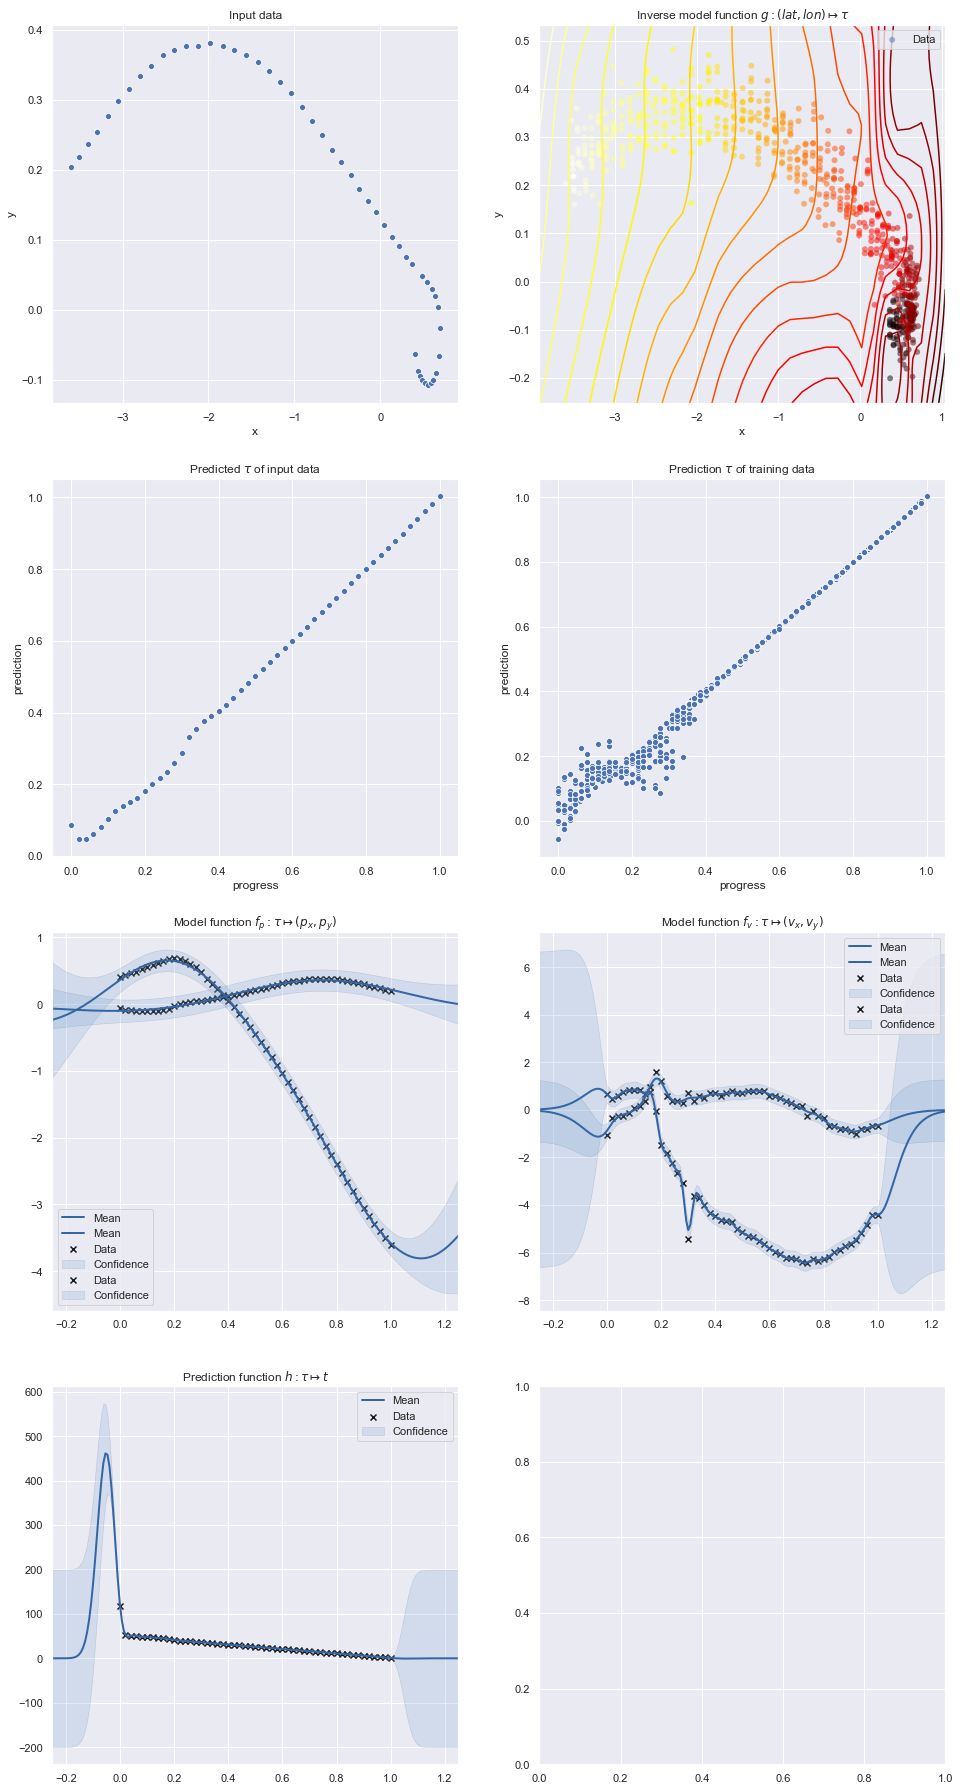

In [35]:
from math import sqrt, cos, sin, radians
from plotting import plot_model
import seaborn as sns
import GPy
from GPy.models import GPRegression
from typing import List
from model import FunctionModel
from learn import learn_model
from plotting import plot_model
from predict import predict

%matplotlib inline
sns.set(style="darkgrid")

np.random.seed(1)
route_n = 3
seg_n = 1
train_traj_ix = 21
traj_n = traj_ns[train_traj_ix]
f_v_likelihood_noise = seg_v_lik_noise[seg_n-1] # m/s
seg = in_sample_seg_loader(seg_n, traj_n)
#pre_process(
#    load_train_seg(traj_n, seg_n),
#    stop_compress_delta,
#    seg_normalisers[seg_n]
#)

f_p_codomain = ['x', 'y']
f_v_codomain = ['dx', 'dy']
m = learn_model(
    seg, route_n, seg_n, 
    f_p_codomain, f_v_codomain,
    f_p_likelihood_noise,
    f_v_likelihood_noise,
    seg_normalisers
)
plot_model(
    m, seg, 
    f_p_codomain, 
    f_v_codomain
)

## Learn many models

In [70]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import FunctionModelPriors, learn_trajectory_model, save_model, acquire_db_conn#plot_function, gamma_prior, , predict
from functools import reduce
from itertools import islice

np.random.seed(1)

def learn(traj_n, seg_n):
    seg = in_sample_seg_loader(seg_n, traj_n)
    return learn_model(
        seg, route_n, seg_n, 
        f_p_codomain, f_v_codomain,
        f_p_likelihood_noise, 
        f_v_likelihood_noise,
        seg_normalisers
    )

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

# Batch to avoid memory error

seg_ns_to_train = seg_ns
seg_n = 11
batch_size = 10
already_trained = 0
n_to_train = 50
batches = list(chunk(traj_ns[already_trained:already_trained+n_to_train], batch_size))
print(batches)
models = []
with acquire_db_conn() as conn:
    for seg_n in seg_ns_to_train:
        for batch in tqdm(batches):
            batch_models = []
            for traj_n in batch:
                model = learn(traj_n, seg_n)
                m_id = save_model(model, conn)

[(58, 147, 251, 299, 392, 572, 709, 776, 870, 875), (983, 1278, 1283, 1378, 1388, 1476, 1488, 1546, 1604, 1654), (1727, 1769, 1773, 2090, 2100, 2176, 2270, 2283, 2300, 2331), (2361, 2635, 2671, 2673, 2699, 2702, 2710, 2728, 2752, 2758), (2780, 2850, 2853, 2911, 2994, 3000, 3132, 3184, 3217, 3436)]








  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.32000055748449
Optimization restart 2/3, f = -54.32000055712746
Optimization restart 3/3, f = -54.32000055732774


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.36584630393703
Optimization restart 2/3, f = -68.36584630393702
Optimization restart 3/3, f = -68.36584630393696
Optimization restart 1/3, f = 72.19771353305579
Optimization restart 2/3, f = 72.19771353310222
Optimization restart 3/3, f = 72.19771353305094
Optimization restart 1/3, f = -3.570788282027266
Optimization restart 2/3, f = -3.5707882820288717
Optimization restart 3/3, f = -3.57078828202944
Optimization restart 1/3, f = -1334.591039305325
Optimization restart 2/3, f = -1334.5910371499276
Optimization restart 3/3, f = -1334.5910393053227
Optimization restart 1/3, f = 182.7867477126738
Optimization restart 2/3, f = 257.28455326202703
Optimization restart 3/3, f = 257.284544204565


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.16266123235492
Optimization restart 2/3, f = -63.16266123235448
Optimization restart 3/3, f = -63.16266123235437


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.85163682911634
Optimization restart 2/3, f = -77.85163682893794
Optimization restart 3/3, f = -77.85163682911546
Optimization restart 1/3, f = 11.552007499518066
Optimization restart 2/3, f = 11.552007499460721
Optimization restart 3/3, f = 11.552007499460814
Optimization restart 1/3, f = -10.143577235757608
Optimization restart 2/3, f = -10.143577235758613
Optimization restart 3/3, f = -10.143577235758624
Optimization restart 1/3, f = -1250.7626525059
Optimization restart 2/3, f = -1250.7626523168406
Optimization restart 3/3, f = -1250.7626525053004
Optimization restart 1/3, f = 291.2364514690697
Optimization restart 2/3, f = 291.2364523066907
Optimization restart 3/3, f = 291.23645088990725


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.43326739841166
Optimization restart 2/3, f = -57.43326739839914
Optimization restart 3/3, f = -57.43326739841144


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.6955580443438
Optimization restart 2/3, f = -72.69555804434638
Optimization restart 3/3, f = -72.69555804434475
Optimization restart 1/3, f = 74.8352494163693
Optimization restart 2/3, f = 74.8352494169213
Optimization restart 3/3, f = 74.83524941635201
Optimization restart 1/3, f = -5.592812568048711
Optimization restart 2/3, f = -5.592812568035427
Optimization restart 3/3, f = -5.592812568050142
Optimization restart 1/3, f = -1507.5482986290285
Optimization restart 2/3, f = -1507.5482986289594
Optimization restart 3/3, f = -1507.5482986289053
Optimization restart 1/3, f = 209.05611175291844
Optimization restart 2/3, f = 265.5623562010576
Optimization restart 3/3, f = 209.03670439621453


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.21623124377242
Optimization restart 2/3, f = -60.216231243763474
Optimization restart 3/3, f = -60.21623124353689


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.01264944377198
Optimization restart 2/3, f = -73.01264944373337
Optimization restart 3/3, f = -73.01264943292753
Optimization restart 1/3, f = 32.230468028959635
Optimization restart 2/3, f = 32.2304680288855
Optimization restart 3/3, f = 32.23046802889443
Optimization restart 1/3, f = -5.250858063546939
Optimization restart 2/3, f = -5.2508580635464135
Optimization restart 3/3, f = -5.250858063547241
Optimization restart 1/3, f = -1300.6219822213002
Optimization restart 2/3, f = -1300.621982770226
Optimization restart 3/3, f = -1300.6219825549379
Optimization restart 1/3, f = 210.00119882365618
Optimization restart 2/3, f = 210.06867389602982
Optimization restart 3/3, f = 271.4477825231447


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.134268452942095
Optimization restart 2/3, f = -49.134268452346596
Optimization restart 3/3, f = -49.13426845285028


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.20190239188005
Optimization restart 2/3, f = -62.201902391879585
Optimization restart 3/3, f = -62.20190239187998
Optimization restart 1/3, f = 71.37987116354878
Optimization restart 2/3, f = 71.37987116309266
Optimization restart 3/3, f = 71.37987116303131
Optimization restart 1/3, f = -4.454838132764575
Optimization restart 2/3, f = -4.45483813276212
Optimization restart 3/3, f = -4.454838132739351
Optimization restart 1/3, f = -1348.6086377937795
Optimization restart 2/3, f = -1348.6086379585743
Optimization restart 3/3, f = -1348.6086381670373
Optimization restart 1/3, f = 240.74875325462443
Optimization restart 2/3, f = 240.74878629049246
Optimization restart 3/3, f = 240.7487710885663


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.46513792620765
Optimization restart 2/3, f = -45.465137926922324
Optimization restart 3/3, f = -45.46513792597615


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.703187758442745
Optimization restart 2/3, f = -59.70318775843462
Optimization restart 3/3, f = -59.703187758440905
Optimization restart 1/3, f = 66.20789678159804
Optimization restart 2/3, f = 66.20789678142322
Optimization restart 3/3, f = 66.20789952876538
Optimization restart 1/3, f = -14.128767773337263
Optimization restart 2/3, f = -14.12876777333318
Optimization restart 3/3, f = -14.128767773336243
Optimization restart 1/3, f = -1206.208721027749
Optimization restart 2/3, f = -1206.2087209021915
Optimization restart 3/3, f = -1206.2087210239017
Optimization restart 1/3, f = 175.4460385437769
Optimization restart 2/3, f = 219.35253798987804
Optimization restart 3/3, f = 219.35253795650047


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.21794053312688
Optimization restart 2/3, f = -53.217940533120355
Optimization restart 3/3, f = -53.21794053312923


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.01533086606607
Optimization restart 2/3, f = -65.01533086606567
Optimization restart 3/3, f = -65.01533086604164
Optimization restart 1/3, f = 62.181432273731204
Optimization restart 2/3, f = 62.181432275339645
Optimization restart 3/3, f = 62.18143228483572
Optimization restart 1/3, f = -6.64096069627988
Optimization restart 2/3, f = -6.640960696279926
Optimization restart 3/3, f = -6.640960696275425
Optimization restart 1/3, f = -1157.8847878734223
Optimization restart 2/3, f = -1157.8847898994832
Optimization restart 3/3, f = -1157.8847899796633
Optimization restart 1/3, f = 188.99530619454646
Optimization restart 2/3, f = 242.67883754901874
Optimization restart 3/3, f = 188.99331471816376


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.27850984652952
Optimization restart 2/3, f = -73.27850984963892
Optimization restart 3/3, f = -73.27850984968492


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -90.09733915285499
Optimization restart 2/3, f = -90.09733915285703
Optimization restart 3/3, f = -90.09733915285223
Optimization restart 1/3, f = 16.505736279649774
Optimization restart 2/3, f = 16.50573627964131
Optimization restart 3/3, f = 16.505736279639457
Optimization restart 1/3, f = -20.044272272226568
Optimization restart 2/3, f = -20.04427227222688
Optimization restart 3/3, f = -20.044272272225175
Optimization restart 1/3, f = -1542.115299019074
Optimization restart 2/3, f = -1542.1152990193996
Optimization restart 3/3, f = -1542.1152974899646
Optimization restart 1/3, f = 105.06568559565405
Optimization restart 2/3, f = 105.06568559557556
Optimization restart 3/3, f = 105.06568559570997


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.73379488724667
Optimization restart 2/3, f = -54.733794887144505
Optimization restart 3/3, f = -54.733794887248415


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.15279489420689
Optimization restart 2/3, f = -71.15279489405988
Optimization restart 3/3, f = -71.1527948942378
Optimization restart 1/3, f = 69.91000986965724
Optimization restart 2/3, f = 69.91000986970424
Optimization restart 3/3, f = 69.91001008780987
Optimization restart 1/3, f = -9.587948136900124
Optimization restart 2/3, f = -9.587948136899964
Optimization restart 3/3, f = -9.587948136889857
Optimization restart 1/3, f = -1443.1428399010729
Optimization restart 2/3, f = -1443.1428407264498
Optimization restart 3/3, f = -1443.1428407286444
Optimization restart 1/3, f = 202.06102330820391
Optimization restart 2/3, f = 265.8161018409869
Optimization restart 3/3, f = 202.06997821265335


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.699106790236776
Optimization restart 2/3, f = -56.69910679023661
Optimization restart 3/3, f = -56.699106789945986


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.34339967423419
Optimization restart 2/3, f = -68.34339967424363
Optimization restart 3/3, f = -68.34339967424354
Optimization restart 1/3, f = 153.10990690237605
Optimization restart 2/3, f = 153.10990690237625
Optimization restart 3/3, f = 81.70099465083453
Optimization restart 1/3, f = -6.280202017891877
Optimization restart 2/3, f = 51.067830991417736
Optimization restart 3/3, f = -6.28020201789273
Optimization restart 1/3, f = -1308.066966188464
Optimization restart 2/3, f = -1308.066966097131
Optimization restart 3/3, f = -1308.066966186318
Optimization restart 1/3, f = 196.34578287849885
Optimization restart 2/3, f = 196.2559758207713
Optimization restart 3/3, f = 253.82015926461725








 20%|████████████████▌                                                                  | 1/5 [02:16<09:07, 136.91s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.76598261992143
Optimization restart 2/3, f = -54.76598261992149
Optimization restart 3/3, f = -54.76598261990883


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.4019912595951
Optimization restart 2/3, f = -68.40199125952478
Optimization restart 3/3, f = -68.40199125957957
Optimization restart 1/3, f = 63.68455373730509
Optimization restart 2/3, f = 63.68455373730172
Optimization restart 3/3, f = 63.68455373730428
Optimization restart 1/3, f = -6.931456947380131
Optimization restart 2/3, f = -6.931456947378493
Optimization restart 3/3, f = 51.37924951632381
Optimization restart 1/3, f = -1389.970203423112
Optimization restart 2/3, f = -1389.9702026907999
Optimization restart 3/3, f = -1389.9702034189918
Optimization restart 1/3, f = 109.89447231340003
Optimization restart 2/3, f = 109.997665106697
Optimization restart 3/3, f = 109.89447231241351


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.889939434399
Optimization restart 2/3, f = -49.88993943446267
Optimization restart 3/3, f = -49.88993943441425


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.50765787368029
Optimization restart 2/3, f = -64.50765787368029
Optimization restart 3/3, f = -64.50765787368026
Optimization restart 1/3, f = 36.09932018254891
Optimization restart 2/3, f = 36.099320183116404
Optimization restart 3/3, f = 36.0993201825413
Optimization restart 1/3, f = -10.244411734958291
Optimization restart 2/3, f = -10.244411734958604
Optimization restart 3/3, f = -10.244411734958547
Optimization restart 1/3, f = -1345.1920017110604
Optimization restart 2/3, f = -1345.1920017300745
Optimization restart 3/3, f = -1345.1920017300333
Optimization restart 1/3, f = 182.29567807959188
Optimization restart 2/3, f = 236.12517953061345
Optimization restart 3/3, f = 236.12517985112441


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.26126520965175
Optimization restart 2/3, f = -64.26126520965464
Optimization restart 3/3, f = -64.26126520947369


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.37580311334719
Optimization restart 2/3, f = -77.37580311333606
Optimization restart 3/3, f = -77.37580311223654
Optimization restart 1/3, f = 89.43695660283672
Optimization restart 2/3, f = 166.62194180684958
Optimization restart 3/3, f = 166.6219418064156
Optimization restart 1/3, f = -20.00545920383545
Optimization restart 2/3, f = -20.005459203835553
Optimization restart 3/3, f = -20.005459203842282
Optimization restart 1/3, f = -1340.5517483345934
Optimization restart 2/3, f = -1340.551748332781
Optimization restart 3/3, f = -1340.5517474265275
Optimization restart 1/3, f = 217.3769907352836
Optimization restart 2/3, f = 217.39753717946564
Optimization restart 3/3, f = 217.4098106854271


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.65032748723499
Optimization restart 2/3, f = -73.65032748726095
Optimization restart 3/3, f = -73.650327487076


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -89.6804358861943
Optimization restart 2/3, f = -89.68043588619457
Optimization restart 3/3, f = -89.6804358861946
Optimization restart 1/3, f = 73.53265494204
Optimization restart 2/3, f = 73.53265494204061
Optimization restart 3/3, f = 73.53265494204246
Optimization restart 1/3, f = -11.961190566665422
Optimization restart 2/3, f = -11.961190566664168
Optimization restart 3/3, f = -11.961190566661976
Optimization restart 1/3, f = -1503.4340852452206
Optimization restart 2/3, f = -1503.4340852971184
Optimization restart 3/3, f = -1503.4340844739418
Optimization restart 1/3, f = 325.9240515963195
Optimization restart 2/3, f = 214.58356987749792
Optimization restart 3/3, f = 325.9239806156148


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.23658944770255
Optimization restart 2/3, f = -54.23658944768971
Optimization restart 3/3, f = -54.23658944769914


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.8935933411473
Optimization restart 2/3, f = -66.89359334114727
Optimization restart 3/3, f = -66.89359334114586
Optimization restart 1/3, f = 77.19028306681942
Optimization restart 2/3, f = 77.1902830668205
Optimization restart 3/3, f = 77.1902830668183
Optimization restart 1/3, f = -6.126231851400778
Optimization restart 2/3, f = -6.126231851409877
Optimization restart 3/3, f = -6.126231851408999
Optimization restart 1/3, f = -1205.1809154418052
Optimization restart 2/3, f = -1205.180915449099
Optimization restart 3/3, f = -1205.1809114525313
Optimization restart 1/3, f = 243.1118127872662
Optimization restart 2/3, f = 129.72600379053864
Optimization restart 3/3, f = 129.8851797687079


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.41096060914057
Optimization restart 2/3, f = -62.410960609140965
Optimization restart 3/3, f = -62.4109606091404


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.00453761633607
Optimization restart 2/3, f = -77.00453761634543
Optimization restart 3/3, f = -77.00453761629451
Optimization restart 1/3, f = 66.19993745054458
Optimization restart 2/3, f = 66.19993751665217
Optimization restart 3/3, f = 66.19993745055771
Optimization restart 1/3, f = -8.315996712542528
Optimization restart 2/3, f = -8.315996712542638
Optimization restart 3/3, f = -8.315996712542503
Optimization restart 1/3, f = -1305.11412544217
Optimization restart 2/3, f = -1305.1141254439663
Optimization restart 3/3, f = -1305.114125443689
Optimization restart 1/3, f = 208.1344227919942
Optimization restart 2/3, f = 282.3696078636159
Optimization restart 3/3, f = 208.09797785154478


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.100507518946245
Optimization restart 2/3, f = -63.100507519085795
Optimization restart 3/3, f = -63.10050751911777


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -78.7345420318772
Optimization restart 2/3, f = -78.73454203185344
Optimization restart 3/3, f = -78.73454203188679
Optimization restart 1/3, f = 3.981596007521432
Optimization restart 2/3, f = 3.9815960075233576
Optimization restart 3/3, f = 3.9815960075262673
Optimization restart 1/3, f = -14.642627565779552
Optimization restart 2/3, f = -14.642627565777136
Optimization restart 3/3, f = -14.642627565779488
Optimization restart 1/3, f = -1470.6302423260688
Optimization restart 2/3, f = -1470.6302423172847
Optimization restart 3/3, f = -1470.6302422931328
Optimization restart 1/3, f = 287.01782415554675
Optimization restart 2/3, f = 287.01782458512514
Optimization restart 3/3, f = 211.7293812078363


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.66362881127628
Optimization restart 2/3, f = -65.66362881126938
Optimization restart 3/3, f = -65.66362881127283


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -81.7609965464987
Optimization restart 2/3, f = -81.76099654651091
Optimization restart 3/3, f = -81.76099654659271
Optimization restart 1/3, f = 78.42531892658795
Optimization restart 2/3, f = 78.42531892928075
Optimization restart 3/3, f = 78.42531892658894
Optimization restart 1/3, f = -7.918671084601364
Optimization restart 2/3, f = -7.918671084601325
Optimization restart 3/3, f = -7.918671084600934
Optimization restart 1/3, f = -1416.6324240180286
Optimization restart 2/3, f = -1416.6324206100514
Optimization restart 3/3, f = -1416.6324240199629
Optimization restart 1/3, f = 223.1963426418084
Optimization restart 2/3, f = 299.858292661939
Optimization restart 3/3, f = 299.85828739660735


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.54331964783698
Optimization restart 2/3, f = -52.54331964491222
Optimization restart 3/3, f = -52.54331964783703


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.64014372723072
Optimization restart 2/3, f = -67.64014372724353
Optimization restart 3/3, f = -67.64014372675489
Optimization restart 1/3, f = 80.67360847482176
Optimization restart 2/3, f = 80.67360847704408
Optimization restart 3/3, f = 80.67360847722955
Optimization restart 1/3, f = -5.95088846857271
Optimization restart 2/3, f = -5.950888468566074
Optimization restart 3/3, f = -5.950888468573261
Optimization restart 1/3, f = -1325.0286524549451
Optimization restart 2/3, f = -1325.0286523633254
Optimization restart 3/3, f = -1325.0286521366836
Optimization restart 1/3, f = 198.429473835497
Optimization restart 2/3, f = 198.49698821873204
Optimization restart 3/3, f = 248.9650979881937


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.55243003157576
Optimization restart 2/3, f = -44.55243003158019
Optimization restart 3/3, f = -44.55243003158021


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.73119005353109
Optimization restart 2/3, f = -59.7311900535159
Optimization restart 3/3, f = -59.731190053517885
Optimization restart 1/3, f = 76.27466787383594
Optimization restart 2/3, f = 76.27466787383604
Optimization restart 3/3, f = 140.3499326137195
Optimization restart 1/3, f = -0.04815138388682527
Optimization restart 2/3, f = -0.04815138388651974
Optimization restart 3/3, f = -0.04815138388682527
Optimization restart 1/3, f = -1248.7605353464162
Optimization restart 2/3, f = -1248.7605344243502
Optimization restart 3/3, f = -1248.760535076567
Optimization restart 1/3, f = 224.0424653555633
Optimization restart 2/3, f = 182.73459663858708
Optimization restart 3/3, f = 224.0424512802632








 40%|█████████████████████████████████▏                                                 | 2/5 [04:29<06:47, 135.70s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.75296714983299
Optimization restart 2/3, f = -52.75296714983568
Optimization restart 3/3, f = -52.75296714983023


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.70167239387992
Optimization restart 2/3, f = -67.70167239388049
Optimization restart 3/3, f = -67.7016723938769
Optimization restart 1/3, f = 74.5078080743794
Optimization restart 2/3, f = 74.50780807171107
Optimization restart 3/3, f = 74.50780807167986
Optimization restart 1/3, f = 5.47995265417029
Optimization restart 2/3, f = 5.479952654168361
Optimization restart 3/3, f = 5.4799526541683505
Optimization restart 1/3, f = -1179.1958308970857
Optimization restart 2/3, f = -1179.195830897353
Optimization restart 3/3, f = -1179.1958308504018
Optimization restart 1/3, f = 253.5874591870567
Optimization restart 2/3, f = 253.5874580350992
Optimization restart 3/3, f = 253.587460500826


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.969685852431425
Optimization restart 2/3, f = -51.96968585258529
Optimization restart 3/3, f = -51.969685852580795


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.6001487357036
Optimization restart 2/3, f = -67.600148735712
Optimization restart 3/3, f = -67.60014873571419
Optimization restart 1/3, f = 65.47904928640293
Optimization restart 2/3, f = 65.47904942481844
Optimization restart 3/3, f = 65.47904927497683
Optimization restart 1/3, f = 0.9534311021063004
Optimization restart 2/3, f = 0.9534311021063964
Optimization restart 3/3, f = 0.9534311021116544
Optimization restart 1/3, f = -1154.905556430503
Optimization restart 2/3, f = -1154.9055564271953
Optimization restart 3/3, f = -1154.905556428689
Optimization restart 1/3, f = 193.5581921682289
Optimization restart 2/3, f = 248.1586535315348
Optimization restart 3/3, f = 193.60320578503337


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.107617843198064
Optimization restart 2/3, f = -50.107617842109505
Optimization restart 3/3, f = -50.10761784325626


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.19858464226135
Optimization restart 2/3, f = -64.19858464225592
Optimization restart 3/3, f = -64.19858464226112
Optimization restart 1/3, f = 6.211158580863856
Optimization restart 2/3, f = 6.211158580860872
Optimization restart 3/3, f = 6.211158580866563
Optimization restart 1/3, f = -11.30721650524518
Optimization restart 2/3, f = -11.307216505142865
Optimization restart 3/3, f = -11.30721650524212
Optimization restart 1/3, f = -1274.220410405828
Optimization restart 2/3, f = -1274.22041041461
Optimization restart 3/3, f = -1274.2204103942413
Optimization restart 1/3, f = 187.99681600944317
Optimization restart 2/3, f = 187.96249033587117
Optimization restart 3/3, f = 237.2807137323103


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.196701367370444
Optimization restart 2/3, f = -56.19670136737726
Optimization restart 3/3, f = -56.19670136738006


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.44021581596056
Optimization restart 2/3, f = -72.4402158159004
Optimization restart 3/3, f = -72.44021581605107
Optimization restart 1/3, f = 28.936782554948927
Optimization restart 2/3, f = 28.936782554942667
Optimization restart 3/3, f = 28.936782554944024
Optimization restart 1/3, f = -9.812028300475347
Optimization restart 2/3, f = -9.812028300468125
Optimization restart 3/3, f = -9.812028300483039
Optimization restart 1/3, f = -1331.8050529838365
Optimization restart 2/3, f = -1331.8050531651365
Optimization restart 3/3, f = -1331.805053233805
Optimization restart 1/3, f = 207.0764813238634
Optimization restart 2/3, f = 265.4210328647023
Optimization restart 3/3, f = 265.42103165157124


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.593033369810364
Optimization restart 2/3, f = -47.59303336968998
Optimization restart 3/3, f = -47.59303336991283


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.255601760291015
Optimization restart 2/3, f = -61.25560176025041
Optimization restart 3/3, f = -61.25560176029094
Optimization restart 1/3, f = -0.08723202226717319
Optimization restart 2/3, f = -0.08723202226681082
Optimization restart 3/3, f = -0.08723202226730109
Optimization restart 1/3, f = -12.091976969262593
Optimization restart 2/3, f = -12.091976969296278
Optimization restart 3/3, f = -12.091976969308774
Optimization restart 1/3, f = -1299.7276733142055
Optimization restart 2/3, f = -1299.7276731107713
Optimization restart 3/3, f = -1299.72767331361
Optimization restart 1/3, f = 177.92052493879117
Optimization restart 2/3, f = 178.01215118934434
Optimization restart 3/3, f = 225.0468354101546


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.827155496185306
Optimization restart 2/3, f = -47.827155496384925
Optimization restart 3/3, f = -47.82715549635408


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.77610308887263
Optimization restart 2/3, f = -62.776103088898786
Optimization restart 3/3, f = -62.776103088882685
Optimization restart 1/3, f = 76.91485715772178
Optimization restart 2/3, f = 145.74723230869995
Optimization restart 3/3, f = 76.91485715478363
Optimization restart 1/3, f = -9.390081461182437
Optimization restart 2/3, f = -9.390081461181126
Optimization restart 3/3, f = -9.390081461182142
Optimization restart 1/3, f = -1303.2372079325883
Optimization restart 2/3, f = -1303.2372084802935
Optimization restart 3/3, f = -1303.2372084556841
Optimization restart 1/3, f = 235.1345350694547
Optimization restart 2/3, f = 200.9307834549456
Optimization restart 3/3, f = 200.90557697453897


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -80.34780654927947
Optimization restart 2/3, f = -80.34780654927951
Optimization restart 3/3, f = -80.3478065487411


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -97.80881280046559
Optimization restart 2/3, f = -97.80881280050258
Optimization restart 3/3, f = -97.8088128005
Optimization restart 1/3, f = 67.87363055063699
Optimization restart 2/3, f = 67.87363055063473
Optimization restart 3/3, f = 67.87363055117922
Optimization restart 1/3, f = -24.09182909025697
Optimization restart 2/3, f = -24.091829090254837
Optimization restart 3/3, f = -24.091829090259687
Optimization restart 1/3, f = -1531.3952499784548
Optimization restart 2/3, f = -1531.395251362483
Optimization restart 3/3, f = -1531.3952513611723
Optimization restart 1/3, f = 357.59305519496206
Optimization restart 2/3, f = 357.5930405789934
Optimization restart 3/3, f = 357.59303410280546


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.674572266838425
Optimization restart 2/3, f = -37.674572266819744
Optimization restart 3/3, f = -37.674572266870626


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.31864374505578
Optimization restart 2/3, f = -52.31864374505131
Optimization restart 3/3, f = -52.31864374506215
Optimization restart 1/3, f = 18.105107663653328
Optimization restart 2/3, f = 18.105107663641956
Optimization restart 3/3, f = 18.105107663639288
Optimization restart 1/3, f = -2.271768899247398
Optimization restart 2/3, f = -2.2717688992470464
Optimization restart 3/3, f = -2.271768899247572
Optimization restart 1/3, f = -1366.6581176926748
Optimization restart 2/3, f = -1366.6581176991588
Optimization restart 3/3, f = -1366.6581176279656
Optimization restart 1/3, f = 195.26338507416932
Optimization restart 2/3, f = 195.26338525834282
Optimization restart 3/3, f = 195.26338490007933


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.509613573489546
Optimization restart 2/3, f = -61.50961357360945
Optimization restart 3/3, f = -61.50961357381889


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -79.12972930377846
Optimization restart 2/3, f = -79.12972930376162
Optimization restart 3/3, f = -79.12972930321503
Optimization restart 1/3, f = 51.836029239225326
Optimization restart 2/3, f = 51.836029239168425
Optimization restart 3/3, f = 51.83602923915839
Optimization restart 1/3, f = -8.150044117926388
Optimization restart 2/3, f = -8.150044117926413
Optimization restart 3/3, f = -8.150044117884445
Optimization restart 1/3, f = -1530.8587650320897
Optimization restart 2/3, f = -1530.8587650317124
Optimization restart 3/3, f = -1530.8587608391356
Optimization restart 1/3, f = 229.43668741987125
Optimization restart 2/3, f = 229.41846153741642
Optimization restart 3/3, f = 229.43191953241765


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.01823907122636
Optimization restart 2/3, f = -45.018239071210516
Optimization restart 3/3, f = -45.018239071157055


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.79466315739902
Optimization restart 2/3, f = -59.794663157334405
Optimization restart 3/3, f = -59.79466315735799
Optimization restart 1/3, f = 58.643606554304675
Optimization restart 2/3, f = 58.643606554300774
Optimization restart 3/3, f = 58.64360655429996
Optimization restart 1/3, f = 2.8779290182216926
Optimization restart 2/3, f = 2.877929018222204
Optimization restart 3/3, f = 2.8779290182217956
Optimization restart 1/3, f = -1481.4981775054794
Optimization restart 2/3, f = -1481.4981778041383
Optimization restart 3/3, f = -1481.4981780139162
Optimization restart 1/3, f = 223.70760151381987
Optimization restart 2/3, f = 223.7075957539157
Optimization restart 3/3, f = 223.70760656656648








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:46<04:32, 136.01s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.01654244714804
Optimization restart 2/3, f = -47.01654244718877
Optimization restart 3/3, f = -47.01654244719654


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.830939313462345
Optimization restart 2/3, f = -61.830939313461464
Optimization restart 3/3, f = -61.830939313441135
Optimization restart 1/3, f = 0.4935840576154362
Optimization restart 2/3, f = 0.49358405761548596
Optimization restart 3/3, f = 0.49358405761477187
Optimization restart 1/3, f = -15.883610520669853
Optimization restart 2/3, f = -15.883610520030292
Optimization restart 3/3, f = -15.883610520402469
Optimization restart 1/3, f = -1345.9292570713244
Optimization restart 2/3, f = -1345.929257168002
Optimization restart 3/3, f = -1345.92925718089
Optimization restart 1/3, f = 179.2722508515959
Optimization restart 2/3, f = 179.24881870310008
Optimization restart 3/3, f = 225.55149996307256


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.737825312640275
Optimization restart 2/3, f = -44.73782531272152
Optimization restart 3/3, f = -44.73782531277886


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.0392359745442
Optimization restart 2/3, f = -64.03923597468304
Optimization restart 3/3, f = -64.0392359746712
Optimization restart 1/3, f = 99.52947847904245
Optimization restart 2/3, f = 99.52947847904125
Optimization restart 3/3, f = 99.5294784790414
Optimization restart 1/3, f = 22.225447535580585
Optimization restart 2/3, f = 55.25330874673219
Optimization restart 3/3, f = 22.225447535577345
Optimization restart 1/3, f = -1329.326282635279
Optimization restart 2/3, f = -1329.3262878846413
Optimization restart 3/3, f = -1329.3262878793519
Optimization restart 1/3, f = 188.99850892353797
Optimization restart 2/3, f = 242.32554399795498
Optimization restart 3/3, f = 242.32553836218813


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.08879475047934
Optimization restart 2/3, f = -59.08879475047443
Optimization restart 3/3, f = -59.08879475017745


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.95645794319957
Optimization restart 2/3, f = -73.9564579432193
Optimization restart 3/3, f = -73.95645794320103
Optimization restart 1/3, f = 74.84431188558526
Optimization restart 2/3, f = 74.84431188527269
Optimization restart 3/3, f = 74.84431188528276
Optimization restart 1/3, f = -14.321752786583534
Optimization restart 2/3, f = -14.321752786574386
Optimization restart 3/3, f = -14.321752786583541
Optimization restart 1/3, f = -1388.4413921394378
Optimization restart 2/3, f = -1388.441392081771
Optimization restart 3/3, f = -1388.441392135355
Optimization restart 1/3, f = 269.72574170280075
Optimization restart 2/3, f = 269.72574267433987
Optimization restart 3/3, f = 205.6457423737115


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.94362709806348
Optimization restart 2/3, f = -51.943627098028735
Optimization restart 3/3, f = -51.943627098186525


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.9355584960652
Optimization restart 2/3, f = -65.93555849572023
Optimization restart 3/3, f = -65.93555849607027
Optimization restart 1/3, f = 72.97837990428047
Optimization restart 2/3, f = 72.9783802361387
Optimization restart 3/3, f = 72.9783799146889
Optimization restart 1/3, f = -11.052037574079908
Optimization restart 2/3, f = -11.052037574079904
Optimization restart 3/3, f = -11.05203757408
Optimization restart 1/3, f = -1234.7457499515835
Optimization restart 2/3, f = -1234.745753370066
Optimization restart 3/3, f = -1234.7457531771577
Optimization restart 1/3, f = 190.11966396648904
Optimization restart 2/3, f = 242.5684617319284
Optimization restart 3/3, f = 190.19535744353558


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.663185016886004
Optimization restart 2/3, f = -49.66318501721207
Optimization restart 3/3, f = -49.66318501720414


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.56353463313326
Optimization restart 2/3, f = -64.56353463313502
Optimization restart 3/3, f = -64.56353463300862
Optimization restart 1/3, f = 6.788735972309965
Optimization restart 2/3, f = 6.788735972308054
Optimization restart 3/3, f = 6.788735972339797
Optimization restart 1/3, f = -11.95441113215093
Optimization restart 2/3, f = -11.954411132150344
Optimization restart 3/3, f = -11.95441113215092
Optimization restart 1/3, f = -1332.6185804531822
Optimization restart 2/3, f = -1332.6185797976814
Optimization restart 3/3, f = -1332.618580453193
Optimization restart 1/3, f = 186.21793825281907
Optimization restart 2/3, f = 186.19966746675277
Optimization restart 3/3, f = 186.12246951033916


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.93626775948273
Optimization restart 2/3, f = -41.93626775880149
Optimization restart 3/3, f = -41.936267759482796


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.337302492019916
Optimization restart 2/3, f = -56.33730249215268
Optimization restart 3/3, f = -56.337302492157086
Optimization restart 1/3, f = 137.20945275718947
Optimization restart 2/3, f = 99.25474844213653
Optimization restart 3/3, f = 137.20945275660253
Optimization restart 1/3, f = -6.774819338155858
Optimization restart 2/3, f = -6.774819338156556
Optimization restart 3/3, f = -6.774819338156611
Optimization restart 1/3, f = -1266.6248246622536
Optimization restart 2/3, f = -1266.6248246622563
Optimization restart 3/3, f = -1266.6248246620735
Optimization restart 1/3, f = 179.91817675951708
Optimization restart 2/3, f = 213.03574945642674
Optimization restart 3/3, f = 179.81441954592918


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.79790708612677
Optimization restart 2/3, f = -46.797907085934774
Optimization restart 3/3, f = -46.79790708629571


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.45113224270737
Optimization restart 2/3, f = -61.45113224270947
Optimization restart 3/3, f = -61.45113224270942
Optimization restart 1/3, f = 66.53870341454555
Optimization restart 2/3, f = 66.53870341454791
Optimization restart 3/3, f = 66.53870341555441
Optimization restart 1/3, f = -3.3900807613717987
Optimization restart 2/3, f = -3.390080761372925
Optimization restart 3/3, f = -3.390080761372978
Optimization restart 1/3, f = -1269.428902536327
Optimization restart 2/3, f = -1269.4289046896474
Optimization restart 3/3, f = -1269.4289046887661
Optimization restart 1/3, f = 181.50538813168833
Optimization restart 2/3, f = 181.21096218702078
Optimization restart 3/3, f = 226.39597044491163


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.65399968689532
Optimization restart 2/3, f = -52.653999686889264
Optimization restart 3/3, f = -52.653999686891616


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.84663487930499
Optimization restart 2/3, f = -66.8466348793369
Optimization restart 3/3, f = -66.84663487933572
Optimization restart 1/3, f = 75.879609355568
Optimization restart 2/3, f = 75.87960935584705
Optimization restart 3/3, f = 75.87960935471705
Optimization restart 1/3, f = -3.668673378470892
Optimization restart 2/3, f = -3.668673378471013
Optimization restart 3/3, f = -3.668673378467716
Optimization restart 1/3, f = -1270.8328260302867
Optimization restart 2/3, f = -1270.832808206832
Optimization restart 3/3, f = -1270.8328260399294
Optimization restart 1/3, f = 192.94273606410735
Optimization restart 2/3, f = 248.01331226425188
Optimization restart 3/3, f = 248.01329910645427


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.46895297942836
Optimization restart 2/3, f = -45.46895297561558
Optimization restart 3/3, f = -45.46895297912093


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.37686888246361
Optimization restart 2/3, f = -59.3768688824666
Optimization restart 3/3, f = -59.376868882481574
Optimization restart 1/3, f = 73.57975690296341
Optimization restart 2/3, f = 73.57975690290911
Optimization restart 3/3, f = 73.57975690290912
Optimization restart 1/3, f = 0.2292616214712382
Optimization restart 2/3, f = 0.2292616214715082
Optimization restart 3/3, f = 0.22926162147136608
Optimization restart 1/3, f = -1287.4091330402803
Optimization restart 2/3, f = -1287.4091330402468
Optimization restart 3/3, f = -1287.409133010455
Optimization restart 1/3, f = 177.10658293032685
Optimization restart 2/3, f = 220.22520925825364
Optimization restart 3/3, f = 177.0261302427994


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.0915986888522
Optimization restart 2/3, f = -60.091598688850176
Optimization restart 3/3, f = -60.09159868885158


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -75.52803364504621
Optimization restart 2/3, f = -75.52803364498934
Optimization restart 3/3, f = -75.52803364504858
Optimization restart 1/3, f = 64.8383777673263
Optimization restart 2/3, f = 64.83837776756323
Optimization restart 3/3, f = 64.83837776730897
Optimization restart 1/3, f = -12.416278671698642
Optimization restart 2/3, f = -12.416278671698699
Optimization restart 3/3, f = -12.41627867169872
Optimization restart 1/3, f = -1435.9086616887423
Optimization restart 2/3, f = -1435.9086616879067
Optimization restart 3/3, f = -1435.9086616822058
Optimization restart 1/3, f = 237.71102279662895
Optimization restart 2/3, f = 281.184137992095
Optimization restart 3/3, f = 281.1841376993934








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [08:55<02:13, 133.99s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.53828742403163
Optimization restart 2/3, f = -49.53828742403637
Optimization restart 3/3, f = -49.53828742403663


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.29678677845055
Optimization restart 2/3, f = -64.29678677851183
Optimization restart 3/3, f = -64.29678677851093
Optimization restart 1/3, f = 72.34896978542645
Optimization restart 2/3, f = 72.34896978542673
Optimization restart 3/3, f = 72.34896978543173
Optimization restart 1/3, f = -6.708853545355126
Optimization restart 2/3, f = -6.708853545381132
Optimization restart 3/3, f = 51.857669336338546
Optimization restart 1/3, f = -1204.4619264386881
Optimization restart 2/3, f = -1204.4619264452917
Optimization restart 3/3, f = -1204.4619264386956
Optimization restart 1/3, f = 188.42818557138236
Optimization restart 2/3, f = 237.65122754087525
Optimization restart 3/3, f = 237.65122862580074


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.24185792604477
Optimization restart 2/3, f = -50.2418579267517
Optimization restart 3/3, f = -50.24185792677768


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.67603829980548
Optimization restart 2/3, f = -64.67603829980962
Optimization restart 3/3, f = -64.67603829981212
Optimization restart 1/3, f = -7.179919486573359
Optimization restart 2/3, f = -7.179919486529316
Optimization restart 3/3, f = -7.179919486582113
Optimization restart 1/3, f = -10.717092497822819
Optimization restart 2/3, f = -10.717092497822286
Optimization restart 3/3, f = -10.717092497822701
Optimization restart 1/3, f = -1232.4523669831183
Optimization restart 2/3, f = -1232.4523670108133
Optimization restart 3/3, f = -1232.4523669534178
Optimization restart 1/3, f = 185.60617505789673
Optimization restart 2/3, f = 185.5953946689037
Optimization restart 3/3, f = 185.7056930309502


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.20206249069615
Optimization restart 2/3, f = -47.202062490696335
Optimization restart 3/3, f = -47.20206249062535


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.94547632845732
Optimization restart 2/3, f = -60.945476336796574
Optimization restart 3/3, f = -60.945476336814124
Optimization restart 1/3, f = 72.43090564171123
Optimization restart 2/3, f = 143.31296992966918
Optimization restart 3/3, f = 72.43090559062026
Optimization restart 1/3, f = -2.5812062690678523
Optimization restart 2/3, f = -2.5812062690871755
Optimization restart 3/3, f = -2.581206269086671
Optimization restart 1/3, f = -1192.098819306148
Optimization restart 2/3, f = -1192.0988185504782
Optimization restart 3/3, f = -1192.0988193240585
Optimization restart 1/3, f = 181.91846495548393
Optimization restart 2/3, f = 182.13373375502852
Optimization restart 3/3, f = 227.89207127978906


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.00996771273985
Optimization restart 2/3, f = -72.00996771337118
Optimization restart 3/3, f = -72.00996771340185


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -86.94956097434698
Optimization restart 2/3, f = -86.9495609743428
Optimization restart 3/3, f = -86.94956097431654
Optimization restart 1/3, f = 55.71470362884289
Optimization restart 2/3, f = 55.71470362896783
Optimization restart 3/3, f = 55.71470362884451
Optimization restart 1/3, f = 9.594303540500164
Optimization restart 2/3, f = 9.594303540499979
Optimization restart 3/3, f = 9.59430354049838
Optimization restart 1/3, f = -1424.3450205086106
Optimization restart 2/3, f = -1424.3450205109805
Optimization restart 3/3, f = -1424.3450203042776
Optimization restart 1/3, f = 248.9649156627803
Optimization restart 2/3, f = 338.93376127685866
Optimization restart 3/3, f = 338.9338131110567


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.80203993606352
Optimization restart 2/3, f = -65.80203993653168
Optimization restart 3/3, f = -65.80203993672973


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -83.66244797315186
Optimization restart 2/3, f = -83.66244797355111
Optimization restart 3/3, f = -83.66244797344784
Optimization restart 1/3, f = 89.71467313490922
Optimization restart 2/3, f = 89.7146731348995
Optimization restart 3/3, f = 89.71467313489923
Optimization restart 1/3, f = -11.837389665685969
Optimization restart 2/3, f = -11.837389665712898
Optimization restart 3/3, f = -11.83738966571294
Optimization restart 1/3, f = -1529.8979535627732
Optimization restart 2/3, f = -1529.8979758480748
Optimization restart 3/3, f = -1529.8979757559234
Optimization restart 1/3, f = 304.35462861645675
Optimization restart 2/3, f = 222.85511831206173
Optimization restart 3/3, f = 304.3546249490388


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.750616635267406
Optimization restart 2/3, f = -53.75061663714097
Optimization restart 3/3, f = -53.75061663720387


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.185751959564
Optimization restart 2/3, f = -69.1857519596136
Optimization restart 3/3, f = -69.18575195961374
Optimization restart 1/3, f = 70.11899805020184
Optimization restart 2/3, f = 70.11899813541147
Optimization restart 3/3, f = 70.11899805021716
Optimization restart 1/3, f = -9.565428281700012
Optimization restart 2/3, f = -9.56542828168033
Optimization restart 3/3, f = -9.56542828170123
Optimization restart 1/3, f = -1415.9723523853468
Optimization restart 2/3, f = -1415.9723523876305
Optimization restart 3/3, f = -1415.9723518743358
Optimization restart 1/3, f = 199.95390088121283
Optimization restart 2/3, f = 199.94211843232858
Optimization restart 3/3, f = 199.90099018427588


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.55284774606652
Optimization restart 2/3, f = -51.55284774603304
Optimization restart 3/3, f = -51.552847746068316


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.53823246212137
Optimization restart 2/3, f = -65.53823246329958
Optimization restart 3/3, f = -65.5382324633009
Optimization restart 1/3, f = 63.48008937094563
Optimization restart 2/3, f = 63.48008937094508
Optimization restart 3/3, f = 63.48008937096121
Optimization restart 1/3, f = -8.996699957493924
Optimization restart 2/3, f = -8.996699957482033
Optimization restart 3/3, f = -8.996699957493824
Optimization restart 1/3, f = -1260.571181020362
Optimization restart 2/3, f = -1260.571182494586
Optimization restart 3/3, f = -1260.5711824944203
Optimization restart 1/3, f = 188.2334401383395
Optimization restart 2/3, f = 241.69936603543957
Optimization restart 3/3, f = 241.699366331479


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.02289904506944
Optimization restart 2/3, f = -55.02289904505681
Optimization restart 3/3, f = -55.02289904380961


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.51800832816147
Optimization restart 2/3, f = -67.51800832806967
Optimization restart 3/3, f = -67.51800832816514
Optimization restart 1/3, f = 0.4333916003111682
Optimization restart 2/3, f = 0.43339160031210255
Optimization restart 3/3, f = 0.4333916003186644
Optimization restart 1/3, f = -14.962969300377644
Optimization restart 2/3, f = 49.420415396860065
Optimization restart 3/3, f = -14.96296930037317
Optimization restart 1/3, f = -1372.9416778415402
Optimization restart 2/3, f = -1372.941677864901
Optimization restart 3/3, f = -1372.9416778646994
Optimization restart 1/3, f = 205.01289860644468
Optimization restart 2/3, f = 205.0077959114449
Optimization restart 3/3, f = 204.99239278377252


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.7457401734999
Optimization restart 2/3, f = -50.745740173501844
Optimization restart 3/3, f = -50.74574017350026


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.08348450840415
Optimization restart 2/3, f = -68.08348450840616
Optimization restart 3/3, f = -68.08348450840613
Optimization restart 1/3, f = 71.29630226302116
Optimization restart 2/3, f = 71.2963022639847
Optimization restart 3/3, f = 71.29630226308129
Optimization restart 1/3, f = -2.87857362878837
Optimization restart 2/3, f = -2.8785736288376143
Optimization restart 3/3, f = -2.87857362883112
Optimization restart 1/3, f = -1465.72415791806
Optimization restart 2/3, f = -1465.7241580620837
Optimization restart 3/3, f = -1465.7241580443435
Optimization restart 1/3, f = 208.78374863961307
Optimization restart 2/3, f = 251.1275692944948
Optimization restart 3/3, f = 251.1275639256379


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.38348304705349
Optimization restart 2/3, f = -51.38348304706213
Optimization restart 3/3, f = -51.38348304670627


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.0796388882831
Optimization restart 2/3, f = -68.07963888828313
Optimization restart 3/3, f = -68.07963888827055
Optimization restart 1/3, f = 76.53089239975266
Optimization restart 2/3, f = 76.53089239975547
Optimization restart 3/3, f = 76.53089239975367
Optimization restart 1/3, f = -4.6401365925753915
Optimization restart 2/3, f = -4.64013659256868
Optimization restart 3/3, f = -4.640136592573555
Optimization restart 1/3, f = -1449.9846088551087
Optimization restart 2/3, f = -1449.984608833231
Optimization restart 3/3, f = -1449.984608794788
Optimization restart 1/3, f = 211.27641097383471
Optimization restart 2/3, f = 251.37130140755752
Optimization restart 3/3, f = 211.62681694590873








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [11:09<00:00, 133.76s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.292197508234835
Optimization restart 2/3, f = -47.292197508236036
Optimization restart 3/3, f = -47.29219750822847


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.70274222385738
Optimization restart 2/3, f = -54.70274222385761
Optimization restart 3/3, f = -54.702742223847515
Optimization restart 1/3, f = 23.687749438358377
Optimization restart 2/3, f = 23.687749436647305
Optimization restart 3/3, f = 23.687749436811508
Optimization restart 1/3, f = -11.079529210258503
Optimization restart 2/3, f = -11.079529210248968
Optimization restart 3/3, f = -11.079529210189975
Optimization restart 1/3, f = -3469.155140539174
Optimization restart 2/3, f = -3469.1551481238234
Optimization restart 3/3, f = -3469.1551481106326
Optimization restart 1/3, f = 189.6463591180247
Optimization restart 2/3, f = 98.88615372991508
Optimization restart 3/3, f = 189.64635914412045


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.12920528560436
Optimization restart 2/3, f = -41.129205285691356
Optimization restart 3/3, f = -41.129205285697665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.92389164478556
Optimization restart 2/3, f = -47.92389164478229
Optimization restart 3/3, f = -47.923891644784234
Optimization restart 1/3, f = -16.64982189644148
Optimization restart 2/3, f = -16.649821896537205
Optimization restart 3/3, f = -16.649821896542825
Optimization restart 1/3, f = -29.21233464321785
Optimization restart 2/3, f = -29.212334643217865
Optimization restart 3/3, f = -29.212334643217424
Optimization restart 1/3, f = -3575.6389311064636
Optimization restart 2/3, f = -3575.638930981037
Optimization restart 3/3, f = -3575.6389310896384
Optimization restart 1/3, f = 4.295404905251907
Optimization restart 2/3, f = 4.29538732460989
Optimization restart 3/3, f = 4.295484592935482


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.74936640469754
Optimization restart 2/3, f = -47.74936640469635
Optimization restart 3/3, f = -47.74936640469738


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.696251657502074
Optimization restart 2/3, f = -54.69625165750231
Optimization restart 3/3, f = -54.69625165750178
Optimization restart 1/3, f = 30.291155217206658
Optimization restart 2/3, f = 30.29115521708401
Optimization restart 3/3, f = 30.291155217091536
Optimization restart 1/3, f = -21.660168649157182
Optimization restart 2/3, f = -21.66016864920929
Optimization restart 3/3, f = -21.660168649208792
Optimization restart 1/3, f = -3466.4480676259723
Optimization restart 2/3, f = -3466.4480676064104
Optimization restart 3/3, f = -3466.448067563577
Optimization restart 1/3, f = 125.5091532023724
Optimization restart 2/3, f = 125.50755562980379
Optimization restart 3/3, f = 125.51890357799942


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -39.29516505717471
Optimization restart 2/3, f = -39.295165057174536
Optimization restart 3/3, f = -39.29516505717452


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.88072153055057
Optimization restart 2/3, f = -46.88072153043877
Optimization restart 3/3, f = -46.88072153035519
Optimization restart 1/3, f = 9.920822564689995
Optimization restart 2/3, f = 9.920822564693442
Optimization restart 3/3, f = 9.920822564687711
Optimization restart 1/3, f = -12.383546393898232
Optimization restart 2/3, f = -12.383546393730203
Optimization restart 3/3, f = -12.38354639389739
Optimization restart 1/3, f = -3590.550150278169
Optimization restart 2/3, f = -3590.5501505622005
Optimization restart 3/3, f = -3590.550150687763
Optimization restart 1/3, f = 90.13016985957631
Optimization restart 2/3, f = 90.13690418265729
Optimization restart 3/3, f = 163.56274052841525


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -33.794443205700546
Optimization restart 2/3, f = -33.79444320569493
Optimization restart 3/3, f = -33.79444320568946


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.18422241818857
Optimization restart 2/3, f = -42.184222418188135
Optimization restart 3/3, f = -42.18422241788848
Optimization restart 1/3, f = 10.442116020531792
Optimization restart 2/3, f = 10.442116020970616
Optimization restart 3/3, f = 10.442116020521219
Optimization restart 1/3, f = -14.70279674777803
Optimization restart 2/3, f = -14.7027967477406
Optimization restart 3/3, f = -14.702796747775615
Optimization restart 1/3, f = -3547.340540950144
Optimization restart 2/3, f = -3547.3405408801354
Optimization restart 3/3, f = -3547.340540791385
Optimization restart 1/3, f = 146.65646868577588
Optimization restart 2/3, f = 146.6564682395624
Optimization restart 3/3, f = 76.0873077584822


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -38.8578713113919
Optimization restart 2/3, f = -38.85787131139537
Optimization restart 3/3, f = -38.85787131139581


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.75845973518452
Optimization restart 2/3, f = -46.75845973517895
Optimization restart 3/3, f = -46.758459735037015
Optimization restart 1/3, f = -4.20865498348385
Optimization restart 2/3, f = -4.2086549834861025
Optimization restart 3/3, f = -4.208654983483189
Optimization restart 1/3, f = -18.799376552066644
Optimization restart 2/3, f = -18.799376552074825
Optimization restart 3/3, f = -18.799376552034797
Optimization restart 1/3, f = -3249.5931190469237
Optimization restart 2/3, f = -3249.593121400673
Optimization restart 3/3, f = -3249.5931213895983
Optimization restart 1/3, f = 88.15640690963235
Optimization restart 2/3, f = 162.2140321463089
Optimization restart 3/3, f = 162.21403215380812


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.51666422399846
Optimization restart 2/3, f = -46.51666422348297
Optimization restart 3/3, f = -46.51666422399469


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.953542023272796
Optimization restart 2/3, f = -54.95354202326109
Optimization restart 3/3, f = -54.95354202327038
Optimization restart 1/3, f = 26.215343240441264
Optimization restart 2/3, f = 26.215343240537607
Optimization restart 3/3, f = 26.215343240434613
Optimization restart 1/3, f = -23.38730414907499
Optimization restart 2/3, f = -23.387304149072985
Optimization restart 3/3, f = -23.387304149075057
Optimization restart 1/3, f = -3112.5337883017573
Optimization restart 2/3, f = -3112.5337893334067
Optimization restart 3/3, f = -3112.5337893305295
Optimization restart 1/3, f = 106.7389812855427
Optimization restart 2/3, f = 106.73898130825786
Optimization restart 3/3, f = 106.74068259704605


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.62792551354488
Optimization restart 2/3, f = -42.62792551354413
Optimization restart 3/3, f = -42.62792551353848


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.023552557635114
Optimization restart 2/3, f = -50.0235525575579
Optimization restart 3/3, f = -50.02355255760739
Optimization restart 1/3, f = 30.076964204261152
Optimization restart 2/3, f = 30.076964204261348
Optimization restart 3/3, f = 30.076964204258093
Optimization restart 1/3, f = -16.985238941469337
Optimization restart 2/3, f = -16.985238941465855
Optimization restart 3/3, f = -16.985238941469394
Optimization restart 1/3, f = -3478.003885353702
Optimization restart 2/3, f = -3478.0038856236383
Optimization restart 3/3, f = -3478.003885573791
Optimization restart 1/3, f = 118.14278352044545
Optimization restart 2/3, f = 118.14278351872883
Optimization restart 3/3, f = 118.14278352016058


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.353612037275525
Optimization restart 2/3, f = -47.353612037272796
Optimization restart 3/3, f = -47.35361203727584


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.855738830776644
Optimization restart 2/3, f = -54.85573883076754
Optimization restart 3/3, f = -54.85573883077808
Optimization restart 1/3, f = 18.58594706562667
Optimization restart 2/3, f = 18.585947065622946
Optimization restart 3/3, f = 18.585947065671398
Optimization restart 1/3, f = -28.67051924671222
Optimization restart 2/3, f = -28.67051924671866
Optimization restart 3/3, f = -28.6705192466596
Optimization restart 1/3, f = -3530.640827833193
Optimization restart 2/3, f = -3530.64082786168
Optimization restart 3/3, f = -3530.6408278223425
Optimization restart 1/3, f = 187.63441298476744
Optimization restart 2/3, f = 187.63441339312064
Optimization restart 3/3, f = 187.63441958340258


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.16299336578695
Optimization restart 2/3, f = -42.16299336578235
Optimization restart 3/3, f = -42.162993365786875


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.960582251625
Optimization restart 2/3, f = -49.96058225162498
Optimization restart 3/3, f = -49.960582251620906
Optimization restart 1/3, f = 14.164476750158364
Optimization restart 2/3, f = 14.164476750145177
Optimization restart 3/3, f = 14.16447675014561
Optimization restart 1/3, f = -16.414141527211303
Optimization restart 2/3, f = -16.41414152721211
Optimization restart 3/3, f = -16.41414152721212
Optimization restart 1/3, f = -3060.237577514526
Optimization restart 2/3, f = -3060.2375775147125
Optimization restart 3/3, f = -3060.2375774905063
Optimization restart 1/3, f = 174.10067990542274
Optimization restart 2/3, f = 99.60479452299406
Optimization restart 3/3, f = 99.60753253924139








 20%|████████████████▌                                                                  | 1/5 [01:58<07:55, 118.92s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.939761006422096
Optimization restart 2/3, f = -47.93976100637198
Optimization restart 3/3, f = -47.93976100641805


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.76477047226935
Optimization restart 2/3, f = -56.76477047171719
Optimization restart 3/3, f = -56.76477047217148
Optimization restart 1/3, f = 30.697070938116994
Optimization restart 2/3, f = 30.69707093811612
Optimization restart 3/3, f = 30.697070938138964
Optimization restart 1/3, f = -26.208962799427955
Optimization restart 2/3, f = -26.208962799445246
Optimization restart 3/3, f = -26.208962799474556
Optimization restart 1/3, f = -3423.0143929730934
Optimization restart 2/3, f = -3423.014392973082
Optimization restart 3/3, f = -3423.0143929756387
Optimization restart 1/3, f = 195.75912988900402
Optimization restart 2/3, f = 106.17279259285128
Optimization restart 3/3, f = 106.17161825897884


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.435639627507534
Optimization restart 2/3, f = -36.43563962750756
Optimization restart 3/3, f = -36.4356396275077


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.62475684475635
Optimization restart 2/3, f = -43.62475684476924
Optimization restart 3/3, f = -43.624756844493675
Optimization restart 1/3, f = -3.6422976672458525
Optimization restart 2/3, f = -3.6422976672313645
Optimization restart 3/3, f = -3.6422976672480694
Optimization restart 1/3, f = -22.372737874679224
Optimization restart 2/3, f = -22.372737874601047
Optimization restart 3/3, f = -22.372737874676297
Optimization restart 1/3, f = -3805.2117275709097
Optimization restart 2/3, f = -3805.2117281047354
Optimization restart 3/3, f = -3805.2117261398107
Optimization restart 1/3, f = 72.9079700399357
Optimization restart 2/3, f = 72.91086371809781
Optimization restart 3/3, f = 72.90845744546917


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -39.627652091980984
Optimization restart 2/3, f = -39.62765209198279
Optimization restart 3/3, f = -39.627652091982746


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.82534140896196
Optimization restart 2/3, f = -46.82534140898082
Optimization restart 3/3, f = -46.825341408973735
Optimization restart 1/3, f = 12.88853425944373
Optimization restart 2/3, f = 12.888534259446935
Optimization restart 3/3, f = 12.888534259502386
Optimization restart 1/3, f = -20.037217221407396
Optimization restart 2/3, f = -20.037217221365857
Optimization restart 3/3, f = -20.037217220252245
Optimization restart 1/3, f = -3636.0048165206126
Optimization restart 2/3, f = -3635.70898011594
Optimization restart 3/3, f = -3636.0048164737345
Optimization restart 1/3, f = 78.28798563103008
Optimization restart 2/3, f = 78.28783939382288
Optimization restart 3/3, f = 161.78521372600835


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.21491245557706
Optimization restart 2/3, f = -55.21491245562198
Optimization restart 3/3, f = -55.214912455620905


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.104774376403654
Optimization restart 2/3, f = -63.1047743763865
Optimization restart 3/3, f = -63.104774376403505
Optimization restart 1/3, f = 26.589665326251698
Optimization restart 2/3, f = 26.58966532678142
Optimization restart 3/3, f = 26.589665326255464
Optimization restart 1/3, f = -26.969724178161215
Optimization restart 2/3, f = -26.969724178135515
Optimization restart 3/3, f = -26.969724178128846
Optimization restart 1/3, f = -3544.3809651133447
Optimization restart 2/3, f = -3547.222221397125
Optimization restart 3/3, f = -3544.3809662238773
Optimization restart 1/3, f = 105.20784944644927
Optimization restart 2/3, f = 105.2250787865536
Optimization restart 3/3, f = 105.20784944649199


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.63372313585878
Optimization restart 2/3, f = -42.63372313585873
Optimization restart 3/3, f = -42.633723135858716


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.98368505066843
Optimization restart 2/3, f = -49.98368505065584
Optimization restart 3/3, f = -49.98368505066164
Optimization restart 1/3, f = 8.513363924242597
Optimization restart 2/3, f = 8.513363924229196
Optimization restart 3/3, f = 8.51336392422622
Optimization restart 1/3, f = -25.80415788097128
Optimization restart 2/3, f = -25.80415788097128
Optimization restart 3/3, f = -25.804157880770273
Optimization restart 1/3, f = -3709.9919557964204
Optimization restart 2/3, f = -3709.991955848909
Optimization restart 3/3, f = -3709.991955838693
Optimization restart 1/3, f = 123.51190595381033
Optimization restart 2/3, f = 123.51972655263975
Optimization restart 3/3, f = 180.19477597157342


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.438009582933795
Optimization restart 2/3, f = -50.43800958293366
Optimization restart 3/3, f = -50.438009582929496


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.25985900673351
Optimization restart 2/3, f = -58.25985900515652
Optimization restart 3/3, f = -58.2598590067293
Optimization restart 1/3, f = 1.016292890624456
Optimization restart 2/3, f = 1.0162928906238733
Optimization restart 3/3, f = 1.0162928906249356
Optimization restart 1/3, f = -25.021153410813127
Optimization restart 2/3, f = -25.02115341081314
Optimization restart 3/3, f = -25.02115341079567
Optimization restart 1/3, f = -3765.555968333434
Optimization restart 2/3, f = -3765.555968286134
Optimization restart 3/3, f = -3765.555965510591
Optimization restart 1/3, f = 86.94727213373773
Optimization restart 2/3, f = 86.99215082650716
Optimization restart 3/3, f = 86.94516190004603


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.22088637855025
Optimization restart 2/3, f = -44.220886378548016
Optimization restart 3/3, f = -44.22088637854924


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.782196071164506
Optimization restart 2/3, f = -51.782196071159014
Optimization restart 3/3, f = -51.782196071164485
Optimization restart 1/3, f = -24.141513161257606
Optimization restart 2/3, f = -24.141513161263504
Optimization restart 3/3, f = -24.141513161262147
Optimization restart 1/3, f = -33.48255971177486
Optimization restart 2/3, f = -33.48255971178011
Optimization restart 3/3, f = -33.482559711782514
Optimization restart 1/3, f = -3524.649599451074
Optimization restart 2/3, f = -3524.649599434787
Optimization restart 3/3, f = -3524.6495994399074
Optimization restart 1/3, f = 3.9887974249958624
Optimization restart 2/3, f = 6.610544293856428
Optimization restart 3/3, f = 3.988761300436796


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.63833053850652
Optimization restart 2/3, f = -44.63833053850912
Optimization restart 3/3, f = -44.63833053850697


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.74576826204937
Optimization restart 2/3, f = -51.74576826451823
Optimization restart 3/3, f = -51.745768264643715
Optimization restart 1/3, f = -0.6828052568860308
Optimization restart 2/3, f = -0.682805256869127
Optimization restart 3/3, f = -0.682805256884869
Optimization restart 1/3, f = -17.852663838741655
Optimization restart 2/3, f = -17.85266383844902
Optimization restart 3/3, f = -17.852663838731388
Optimization restart 1/3, f = -3841.544949236126
Optimization restart 2/3, f = -3841.544948763736
Optimization restart 3/3, f = -3841.544949011718
Optimization restart 1/3, f = 79.97334967978435
Optimization restart 2/3, f = 79.97138881396224
Optimization restart 3/3, f = 79.97140461834046


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -40.845702815097184
Optimization restart 2/3, f = -40.8457028151461
Optimization restart 3/3, f = -40.84570281492725


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.44430612775818
Optimization restart 2/3, f = -48.44430612729258
Optimization restart 3/3, f = -48.444306127618994
Optimization restart 1/3, f = 6.920580501328214
Optimization restart 2/3, f = 6.920580501326548
Optimization restart 3/3, f = 6.920580501317666
Optimization restart 1/3, f = -25.480627434451836
Optimization restart 2/3, f = -25.480627434456537
Optimization restart 3/3, f = -25.48062743445859
Optimization restart 1/3, f = -3484.3581626124724
Optimization restart 2/3, f = -3484.3581623232594
Optimization restart 3/3, f = -3484.3581626188925
Optimization restart 1/3, f = 82.12239608106265
Optimization restart 2/3, f = 167.12785165365858
Optimization restart 3/3, f = 82.13584451260117


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.17125936516644
Optimization restart 2/3, f = -37.171259365181925
Optimization restart 3/3, f = -37.171259365181996


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.245183830406184
Optimization restart 2/3, f = -45.24518383064914
Optimization restart 3/3, f = -45.24518383070764
Optimization restart 1/3, f = 8.730053364840582
Optimization restart 2/3, f = 8.730053364836696
Optimization restart 3/3, f = 8.73005336483607
Optimization restart 1/3, f = -18.247342300231224
Optimization restart 2/3, f = -18.247342299981813
Optimization restart 3/3, f = -18.247342300231793
Optimization restart 1/3, f = -3485.115854527058
Optimization restart 2/3, f = -3485.115854450636
Optimization restart 3/3, f = -3485.115854505413
Optimization restart 1/3, f = 70.8873153955628
Optimization restart 2/3, f = 155.55197261118104
Optimization restart 3/3, f = 70.88773079046732








 40%|█████████████████████████████████▏                                                 | 2/5 [04:13<06:11, 123.71s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.4318351064302
Optimization restart 2/3, f = -47.43183510650275
Optimization restart 3/3, f = -47.431835106502696


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.84701531181052
Optimization restart 2/3, f = -54.84701531149871
Optimization restart 3/3, f = -54.84701531167505
Optimization restart 1/3, f = 29.977895611362413
Optimization restart 2/3, f = 29.977895611368467
Optimization restart 3/3, f = 29.97789561137016
Optimization restart 1/3, f = -23.878494394633876
Optimization restart 2/3, f = -23.87849439463379
Optimization restart 3/3, f = -23.878494394278277
Optimization restart 1/3, f = -3537.995618069302
Optimization restart 2/3, f = -3537.995618026456
Optimization restart 3/3, f = -3537.995614362704
Optimization restart 1/3, f = 190.6629003385427
Optimization restart 2/3, f = 109.90356330007151
Optimization restart 3/3, f = 190.6628850573965


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.058551182961644
Optimization restart 2/3, f = -43.05855118221327
Optimization restart 3/3, f = -43.0585511829739


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.83183297646649
Optimization restart 2/3, f = -51.83183297646655
Optimization restart 3/3, f = -51.831832976467055
Optimization restart 1/3, f = 26.3934984560307
Optimization restart 2/3, f = 26.393498456042636
Optimization restart 3/3, f = 26.393498456051766
Optimization restart 1/3, f = -18.94676403455051
Optimization restart 2/3, f = -18.946764034552714
Optimization restart 3/3, f = -18.946764034554594
Optimization restart 1/3, f = -3344.6482926175613
Optimization restart 2/3, f = -3344.6482926176777
Optimization restart 3/3, f = -3344.6482925980436
Optimization restart 1/3, f = 111.96828891717985
Optimization restart 2/3, f = 111.99582895158089
Optimization restart 3/3, f = 111.96719837493222


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -39.05050402828395
Optimization restart 2/3, f = -39.05050402828279
Optimization restart 3/3, f = -39.0505040282467


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.75151572201878
Optimization restart 2/3, f = -46.75151572201705
Optimization restart 3/3, f = -46.75151572201818
Optimization restart 1/3, f = 0.9058202427411324
Optimization restart 2/3, f = 0.9058202427418287
Optimization restart 3/3, f = 0.9058202427405213
Optimization restart 1/3, f = -25.92940946780094
Optimization restart 2/3, f = -25.929409467800884
Optimization restart 3/3, f = -25.92940946780095
Optimization restart 1/3, f = -3408.100491301935
Optimization restart 2/3, f = -3408.100491309479
Optimization restart 3/3, f = -3408.100491296104
Optimization restart 1/3, f = 76.57328244957299
Optimization restart 2/3, f = 76.58527155762118
Optimization restart 3/3, f = 76.57412642522586


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.66796528267926
Optimization restart 2/3, f = -44.6679652826877
Optimization restart 3/3, f = -44.6679652826862


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.775638063487435
Optimization restart 2/3, f = -51.775638063488586
Optimization restart 3/3, f = -51.77563806348394
Optimization restart 1/3, f = 10.991467860322185
Optimization restart 2/3, f = 10.991467860317947
Optimization restart 3/3, f = 10.991467860317698
Optimization restart 1/3, f = -26.607542021288047
Optimization restart 2/3, f = -26.607542021288168
Optimization restart 3/3, f = -26.607542021288197
Optimization restart 1/3, f = -3679.3164262084624
Optimization restart 2/3, f = -3679.3164262133987
Optimization restart 3/3, f = -3679.3164176864616
Optimization restart 1/3, f = 74.13363861228402
Optimization restart 2/3, f = 74.05929275051828
Optimization restart 3/3, f = 74.05929246539264


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -38.93286346443086
Optimization restart 2/3, f = -38.93286346443254
Optimization restart 3/3, f = -38.93286346443409


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.864237321093604
Optimization restart 2/3, f = -46.86423732184428
Optimization restart 3/3, f = -46.864237321087714
Optimization restart 1/3, f = 9.702581900345045
Optimization restart 2/3, f = 9.702581900346399
Optimization restart 3/3, f = 9.702581900348989
Optimization restart 1/3, f = -23.525196194375035
Optimization restart 2/3, f = -23.52519619434756
Optimization restart 3/3, f = -23.52519619437325
Optimization restart 1/3, f = -3402.7910497814382
Optimization restart 2/3, f = -3402.791048244849
Optimization restart 3/3, f = -3402.7910491761477
Optimization restart 1/3, f = 162.16621037605844
Optimization restart 2/3, f = 81.95291224972969
Optimization restart 3/3, f = 81.95249553332552


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.497398769766804
Optimization restart 2/3, f = -37.49739876977179
Optimization restart 3/3, f = -37.49739876976908


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.156059417946864
Optimization restart 2/3, f = -45.15605941794817
Optimization restart 3/3, f = -45.156059417931786
Optimization restart 1/3, f = 43.265301975521865
Optimization restart 2/3, f = 43.26530197552168
Optimization restart 3/3, f = 104.9801173943344
Optimization restart 1/3, f = -13.896168458423269
Optimization restart 2/3, f = -13.896168458438332
Optimization restart 3/3, f = -13.896168458436737
Optimization restart 1/3, f = -3367.855104337622
Optimization restart 2/3, f = -3367.8551034786087
Optimization restart 3/3, f = -3367.8551043406333
Optimization restart 1/3, f = 70.88731539556039
Optimization restart 2/3, f = 155.55197286002448
Optimization restart 3/3, f = 70.88733274525424


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.81347871651725
Optimization restart 2/3, f = -57.81347871582141
Optimization restart 3/3, f = -57.81347871652529


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.70067095331896
Optimization restart 2/3, f = -64.70067095333393
Optimization restart 3/3, f = -64.70067095332865
Optimization restart 1/3, f = 28.50909715223822
Optimization restart 2/3, f = 28.50909715219487
Optimization restart 3/3, f = 28.509097152227007
Optimization restart 1/3, f = -39.52350971255287
Optimization restart 2/3, f = -39.52350971102098
Optimization restart 3/3, f = -39.52350971258206
Optimization restart 1/3, f = -3437.70606162509
Optimization restart 2/3, f = -3437.7060612477117
Optimization restart 3/3, f = -3437.70605945196
Optimization restart 1/3, f = 221.1357922761538
Optimization restart 2/3, f = 97.59199180541299
Optimization restart 3/3, f = 97.51284213945625


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -34.47547018120857
Optimization restart 2/3, f = -34.475470181208685
Optimization restart 3/3, f = -34.47547018120433


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.04541506105622
Optimization restart 2/3, f = -42.04541506121597
Optimization restart 3/3, f = -42.045415061209965
Optimization restart 1/3, f = 4.747781062246368
Optimization restart 2/3, f = 4.747781062248986
Optimization restart 3/3, f = 4.747781062248194
Optimization restart 1/3, f = -16.861273640742745
Optimization restart 2/3, f = -16.861273640737025
Optimization restart 3/3, f = -16.861273640742592
Optimization restart 1/3, f = -3400.5873204264335
Optimization restart 2/3, f = -3400.5873383022586
Optimization restart 3/3, f = -3400.5873385360546
Optimization restart 1/3, f = 69.27420229381062
Optimization restart 2/3, f = 69.28002999593622
Optimization restart 3/3, f = 69.27519538014246


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.583343494814855
Optimization restart 2/3, f = -50.58334349481511
Optimization restart 3/3, f = -50.58334349481789


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.08766052026539
Optimization restart 2/3, f = -58.08766052726975
Optimization restart 3/3, f = -58.08766052726909
Optimization restart 1/3, f = 23.147842180157177
Optimization restart 2/3, f = 23.147842180216912
Optimization restart 3/3, f = 23.1478421801527
Optimization restart 1/3, f = -29.22399772361788
Optimization restart 2/3, f = -29.223997723617295
Optimization restart 3/3, f = -29.223997723612207
Optimization restart 1/3, f = -3761.9169371962307
Optimization restart 2/3, f = -3761.916937332552
Optimization restart 3/3, f = -3761.916935939578
Optimization restart 1/3, f = 117.81755925180431
Optimization restart 2/3, f = 117.8291360446509
Optimization restart 3/3, f = 117.82967432700697


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -27.623738995501654
Optimization restart 2/3, f = -27.60788174799667
Optimization restart 3/3, f = -27.607881747995542


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.358079122767464
Optimization restart 2/3, f = -35.35807912278756
Optimization restart 3/3, f = -35.35807912268552
Optimization restart 1/3, f = 2.6697157538395224
Optimization restart 2/3, f = 2.669715753817524
Optimization restart 3/3, f = 2.6697157538174885
Optimization restart 1/3, f = -14.409299320104967
Optimization restart 2/3, f = -14.40929931962082
Optimization restart 3/3, f = -14.409299320104115
Optimization restart 1/3, f = -3558.9390695325214
Optimization restart 2/3, f = -3558.9390695554953
Optimization restart 3/3, f = -3560.7917221074576
Optimization restart 1/3, f = 7.627057979210524
Optimization restart 2/3, f = 7.627057979193035
Optimization restart 3/3, f = 5.423032578898033








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:24<04:11, 125.69s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.17759167259249
Optimization restart 2/3, f = -22.17759167259024
Optimization restart 3/3, f = -22.177591672587788


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -30.107310529870162
Optimization restart 2/3, f = -30.107310529868386
Optimization restart 3/3, f = -30.107310529868876
Optimization restart 1/3, f = 59.83841632092544
Optimization restart 2/3, f = 83.43223209393348
Optimization restart 3/3, f = 83.43223209659814
Optimization restart 1/3, f = 29.65029193685852
Optimization restart 2/3, f = 29.650291936857545
Optimization restart 3/3, f = 46.44073508923633
Optimization restart 1/3, f = -3254.192908761885
Optimization restart 2/3, f = -3254.1929082249703
Optimization restart 3/3, f = -3254.1929087521794
Optimization restart 1/3, f = 13.522781424288443
Optimization restart 2/3, f = 13.5227814244453
Optimization restart 3/3, f = 13.165260316692658


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -40.705809319635016
Optimization restart 2/3, f = -40.705809319414776
Optimization restart 3/3, f = -40.705809319676355


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.557120845221334
Optimization restart 2/3, f = -48.557120845228
Optimization restart 3/3, f = -48.557120845213895
Optimization restart 1/3, f = 25.087198822904483
Optimization restart 2/3, f = 25.087198822860838
Optimization restart 3/3, f = 25.087198873562706
Optimization restart 1/3, f = -11.803122060321591
Optimization restart 2/3, f = -11.803122060287667
Optimization restart 3/3, f = -11.80312206032167
Optimization restart 1/3, f = -3282.786302938499
Optimization restart 2/3, f = -3282.7863031916972
Optimization restart 3/3, f = -3282.7863030138615
Optimization restart 1/3, f = 106.77066741385852
Optimization restart 2/3, f = 172.02689514967017
Optimization restart 3/3, f = 106.77063172846445


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.0574821841803
Optimization restart 2/3, f = -46.05748218417846
Optimization restart 3/3, f = -46.05748218417959


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.33691764725484
Optimization restart 2/3, f = -53.3369176479166
Optimization restart 3/3, f = -53.33691764776026
Optimization restart 1/3, f = 10.343856447118029
Optimization restart 2/3, f = 10.343856447121475
Optimization restart 3/3, f = 10.343856447128704
Optimization restart 1/3, f = -30.560595913784596
Optimization restart 2/3, f = -30.560595913785924
Optimization restart 3/3, f = -30.560595913227985
Optimization restart 1/3, f = -3579.3061557805813
Optimization restart 2/3, f = -3579.3061675823783
Optimization restart 3/3, f = -3579.306168165411
Optimization restart 1/3, f = 117.93781642548959
Optimization restart 2/3, f = 117.94467970055493
Optimization restart 3/3, f = 117.94222861442154


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.53630861806703
Optimization restart 2/3, f = -42.536308618066975
Optimization restart 3/3, f = -42.53630861806659


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.033136371881014
Optimization restart 2/3, f = -50.03313637188028
Optimization restart 3/3, f = -50.03313637187318
Optimization restart 1/3, f = 18.809213047293348
Optimization restart 2/3, f = 18.809213017148362
Optimization restart 3/3, f = 18.80921301695188
Optimization restart 1/3, f = -21.697762990010933
Optimization restart 2/3, f = -21.69776298992891
Optimization restart 3/3, f = -21.697762990010915
Optimization restart 1/3, f = -3389.550718351583
Optimization restart 2/3, f = -3389.5507200954944
Optimization restart 3/3, f = -3389.550720078617
Optimization restart 1/3, f = 174.10067990542274
Optimization restart 2/3, f = 99.60489715931375
Optimization restart 3/3, f = 99.60530335068712


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -39.42695281088516
Optimization restart 2/3, f = -39.426952810885204
Optimization restart 3/3, f = -39.42695281088528


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.7867583777782
Optimization restart 2/3, f = -46.786758377550214
Optimization restart 3/3, f = -46.78675837777014
Optimization restart 1/3, f = 25.762334604356685
Optimization restart 2/3, f = 25.762334604390286
Optimization restart 3/3, f = 25.76233460435726
Optimization restart 1/3, f = -21.963081860444532
Optimization restart 2/3, f = -21.963081860444767
Optimization restart 3/3, f = -21.96308186044454
Optimization restart 1/3, f = -3203.1615668934255
Optimization restart 2/3, f = -3203.1615668284503
Optimization restart 3/3, f = -3203.1615669348503
Optimization restart 1/3, f = 74.64419642391624
Optimization restart 2/3, f = 74.6483185511191
Optimization restart 3/3, f = 74.6436550723559


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -34.198128495733776
Optimization restart 2/3, f = -34.198128495706996
Optimization restart 3/3, f = -34.1981284957374


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.901307594380015
Optimization restart 2/3, f = -41.901307594214224
Optimization restart 3/3, f = -41.90130759437818
Optimization restart 1/3, f = 8.92535540803356
Optimization restart 2/3, f = 8.92535540803285
Optimization restart 3/3, f = 8.925355408053608
Optimization restart 1/3, f = -19.705951569500797
Optimization restart 2/3, f = -19.705951569492747
Optimization restart 3/3, f = -19.70595156950086
Optimization restart 1/3, f = -3130.049486971944
Optimization restart 2/3, f = -3130.049486970226
Optimization restart 3/3, f = -3130.049486957957
Optimization restart 1/3, f = 65.40945601618222
Optimization restart 2/3, f = 65.40975955938165
Optimization restart 3/3, f = 65.4094560161965


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -29.433036259770162
Optimization restart 2/3, f = -29.433036259109294
Optimization restart 3/3, f = -29.433036259655534


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.21130480589464
Optimization restart 2/3, f = -37.211304805849764
Optimization restart 3/3, f = -37.21130480588997
Optimization restart 1/3, f = -16.08378359498857
Optimization restart 2/3, f = -16.08378359514342
Optimization restart 3/3, f = -16.083783594887066
Optimization restart 1/3, f = -20.314500209651428
Optimization restart 2/3, f = -20.31450020965052
Optimization restart 3/3, f = -20.314500209651637
Optimization restart 1/3, f = -3764.399787509634
Optimization restart 2/3, f = -3764.399787491402
Optimization restart 3/3, f = -3755.966456477747
Optimization restart 1/3, f = 7.543781142374813
Optimization restart 2/3, f = 5.292510998916873
Optimization restart 3/3, f = 5.292571911477109


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.992927496869356
Optimization restart 2/3, f = -35.9929274970027
Optimization restart 3/3, f = -35.992927497145175


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.067252691962636
Optimization restart 2/3, f = -45.06725269196098
Optimization restart 3/3, f = -45.067252691955126
Optimization restart 1/3, f = 55.076202404391516
Optimization restart 2/3, f = 104.95462403433554
Optimization restart 3/3, f = 55.076202403226766
Optimization restart 1/3, f = 34.22226427636682
Optimization restart 2/3, f = 34.222264274857544
Optimization restart 3/3, f = 34.22226427485756
Optimization restart 1/3, f = -1964.0240530399694
Optimization restart 2/3, f = -1964.024052937119
Optimization restart 3/3, f = -1964.0240530443532
Optimization restart 1/3, f = 158.48548143855604
Optimization restart 2/3, f = 74.48274921048791
Optimization restart 3/3, f = 74.44347234391907


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -28.21277744854897
Optimization restart 2/3, f = -28.212777448550867
Optimization restart 3/3, f = -28.212777448537288


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.49975012386206
Optimization restart 2/3, f = -35.49975012384778
Optimization restart 3/3, f = -35.49975012385699
Optimization restart 1/3, f = -3.2048758377425592
Optimization restart 2/3, f = -3.2048758377388076
Optimization restart 3/3, f = -3.2048758377107625
Optimization restart 1/3, f = -16.57326410740885
Optimization restart 2/3, f = -16.5732641074137
Optimization restart 3/3, f = -16.573264107463515
Optimization restart 1/3, f = -3510.008265910357
Optimization restart 2/3, f = -3510.008265834057
Optimization restart 3/3, f = -3510.00826590771
Optimization restart 1/3, f = 7.627057979179822
Optimization restart 2/3, f = 5.423053560499732
Optimization restart 3/3, f = 5.423121479838522


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.74602537623501
Optimization restart 2/3, f = -53.74602537624301
Optimization restart 3/3, f = -53.746025376204294


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.50801621082317
Optimization restart 2/3, f = -61.50801621057618
Optimization restart 3/3, f = -61.50801621082387
Optimization restart 1/3, f = 12.558086321368997
Optimization restart 2/3, f = 12.55808632140414
Optimization restart 3/3, f = 12.558086321361422
Optimization restart 1/3, f = -31.359037402585393
Optimization restart 2/3, f = -31.359037402582352
Optimization restart 3/3, f = -31.35903740258363
Optimization restart 1/3, f = -3498.6363305710765
Optimization restart 2/3, f = -3498.6363250326185
Optimization restart 3/3, f = -3498.6363305610253
Optimization restart 1/3, f = 103.24093245619063
Optimization restart 2/3, f = 103.24527900674052
Optimization restart 3/3, f = 103.24093245526387








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [08:25<02:04, 124.46s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.28854491307019
Optimization restart 2/3, f = -43.2885449130726
Optimization restart 3/3, f = -43.28854491307236


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.02977052396472
Optimization restart 2/3, f = -50.02977052393281
Optimization restart 3/3, f = -50.02977052360891
Optimization restart 1/3, f = 13.009863147751204
Optimization restart 2/3, f = 13.00986315325257
Optimization restart 3/3, f = 13.009863149207842
Optimization restart 1/3, f = -22.93216230399134
Optimization restart 2/3, f = -22.93216230402687
Optimization restart 3/3, f = -22.932162304025226
Optimization restart 1/3, f = -3706.507927788351
Optimization restart 2/3, f = -3706.5079278542116
Optimization restart 3/3, f = -3706.507927881563
Optimization restart 1/3, f = 171.2263535468084
Optimization restart 2/3, f = 83.20085937383543
Optimization restart 3/3, f = 83.33080620744656


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.89240042767402
Optimization restart 2/3, f = -42.892400427675646
Optimization restart 3/3, f = -42.892400427676286


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.9332831261553
Optimization restart 2/3, f = -49.93328312616508
Optimization restart 3/3, f = -49.933283126165655
Optimization restart 1/3, f = -11.836126443522257
Optimization restart 2/3, f = -11.836126443525862
Optimization restart 3/3, f = -11.836126443515939
Optimization restart 1/3, f = -29.083541773830955
Optimization restart 2/3, f = -29.083541773341484
Optimization restart 3/3, f = -29.083541773839915
Optimization restart 1/3, f = -3242.917851740884
Optimization restart 2/3, f = -3242.9178520464025
Optimization restart 3/3, f = -3242.9178520447426
Optimization restart 1/3, f = 85.84089960964458
Optimization restart 2/3, f = 172.66463925396457
Optimization restart 3/3, f = 85.83401553244198


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.233045695677998
Optimization restart 2/3, f = -17.233045695672054
Optimization restart 3/3, f = -17.233045695677152


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -27.30934446252038
Optimization restart 2/3, f = -27.309344462520837
Optimization restart 3/3, f = -27.30934446252071
Optimization restart 1/3, f = 63.26260372978331
Optimization restart 2/3, f = 78.80956242870784
Optimization restart 3/3, f = 63.26260373031489
Optimization restart 1/3, f = 28.982440304199077
Optimization restart 2/3, f = 28.982440304206698
Optimization restart 3/3, f = 28.982440304482225
Optimization restart 1/3, f = -2889.137884112006
Optimization restart 2/3, f = -2889.1378844651563
Optimization restart 3/3, f = -2889.137884466308
Optimization restart 1/3, f = 24.66649750331993
Optimization restart 2/3, f = 24.66649829596228
Optimization restart 3/3, f = 24.66649698481318


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.54611412221622
Optimization restart 2/3, f = -45.54611412221564
Optimization restart 3/3, f = -45.546114121717466


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.15480296490734
Optimization restart 2/3, f = -53.154802964907965
Optimization restart 3/3, f = -53.15480296488769
Optimization restart 1/3, f = 116.42321852149604
Optimization restart 2/3, f = 116.42321852153067
Optimization restart 3/3, f = 71.14496064005843
Optimization restart 1/3, f = 11.413140155431599
Optimization restart 2/3, f = 11.413140155431925
Optimization restart 3/3, f = 11.413140155431648
Optimization restart 1/3, f = -3429.174873409557
Optimization restart 2/3, f = -3429.1748736141635
Optimization restart 3/3, f = -3429.174873693213
Optimization restart 1/3, f = 111.40848510939263
Optimization restart 2/3, f = 111.39556159305276
Optimization restart 3/3, f = 184.95563659651543


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.762968371156056
Optimization restart 2/3, f = -47.762968371193715
Optimization restart 3/3, f = -47.76296837119286


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.32154567116988
Optimization restart 2/3, f = -56.32154567104164
Optimization restart 3/3, f = -56.321545671153444
Optimization restart 1/3, f = 0.08013333272733192
Optimization restart 2/3, f = 0.08013333276631585
Optimization restart 3/3, f = 0.08013333277352785
Optimization restart 1/3, f = -32.580645487087324
Optimization restart 2/3, f = -32.5806454870881
Optimization restart 3/3, f = -32.58064548708161
Optimization restart 1/3, f = -3867.2287073116186
Optimization restart 2/3, f = -3867.22870724928
Optimization restart 3/3, f = -3867.228707299848
Optimization restart 1/3, f = 3.5139803390564364
Optimization restart 2/3, f = 3.514033404830843
Optimization restart 3/3, f = 6.241732579731163


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.75853754475078
Optimization restart 2/3, f = -35.75853754477809
Optimization restart 3/3, f = -35.75853754477651


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.764661721827984
Optimization restart 2/3, f = -43.764661721737866
Optimization restart 3/3, f = -43.76466172182951
Optimization restart 1/3, f = 6.365950414680533
Optimization restart 2/3, f = 6.365950414674909
Optimization restart 3/3, f = 6.365950414676508
Optimization restart 1/3, f = -24.09981216893244
Optimization restart 2/3, f = -24.099812168921897
Optimization restart 3/3, f = -24.09981216884612
Optimization restart 1/3, f = -3538.3757768456776
Optimization restart 2/3, f = -3538.375776893999
Optimization restart 3/3, f = -3538.375776893912
Optimization restart 1/3, f = 62.02205657799151
Optimization restart 2/3, f = 62.02205668593777
Optimization restart 3/3, f = 62.02388110326365


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.82294016279497
Optimization restart 2/3, f = -45.82294016279944
Optimization restart 3/3, f = -45.82294016278992


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.383374389817575
Optimization restart 2/3, f = -53.38337438960712
Optimization restart 3/3, f = -53.38337438983231
Optimization restart 1/3, f = 11.391078884232833
Optimization restart 2/3, f = 11.391078884235213
Optimization restart 3/3, f = 11.391078884231035
Optimization restart 1/3, f = -27.324175977186073
Optimization restart 2/3, f = -27.32417597722428
Optimization restart 3/3, f = -27.32417597721683
Optimization restart 1/3, f = -3200.170636734957
Optimization restart 2/3, f = -3200.170636726929
Optimization restart 3/3, f = -3200.1706367290685
Optimization restart 1/3, f = 185.009892571762
Optimization restart 2/3, f = 105.94516998917688
Optimization restart 3/3, f = 105.94571318283099


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.023467254227214
Optimization restart 2/3, f = -49.023467254236735
Optimization restart 3/3, f = -49.02346725423667


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.408499625797134
Optimization restart 2/3, f = -56.408499626124936
Optimization restart 3/3, f = -56.40849962605148
Optimization restart 1/3, f = -17.070299549335942
Optimization restart 2/3, f = -17.070299549336028
Optimization restart 3/3, f = -17.07029954933732
Optimization restart 1/3, f = -31.940850707485954
Optimization restart 2/3, f = -31.940850707486366
Optimization restart 3/3, f = -31.940850707486256
Optimization restart 1/3, f = -3198.3567890761296
Optimization restart 2/3, f = -3198.3567899881746
Optimization restart 3/3, f = -3198.3567903326616
Optimization restart 1/3, f = 125.4403789658026
Optimization restart 2/3, f = 125.44433226681515
Optimization restart 3/3, f = 125.43927235397692


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.55224791445826
Optimization restart 2/3, f = -37.55224791448666
Optimization restart 3/3, f = -37.55224791448665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.19648789006354
Optimization restart 2/3, f = -45.19648789005993
Optimization restart 3/3, f = -45.19648788995879
Optimization restart 1/3, f = 2.6403825337042583
Optimization restart 2/3, f = 2.6403825337161493
Optimization restart 3/3, f = 2.640382533710344
Optimization restart 1/3, f = -18.750509791395206
Optimization restart 2/3, f = -18.750509791445864
Optimization restart 3/3, f = -18.750509791445978
Optimization restart 1/3, f = -3486.0919024920368
Optimization restart 2/3, f = -3486.0919025934977
Optimization restart 3/3, f = -3486.0919025539224
Optimization restart 1/3, f = 96.1409994156084
Optimization restart 2/3, f = 159.54507641751556
Optimization restart 3/3, f = 159.54507641830003


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.089148948703674
Optimization restart 2/3, f = -43.08914894870428
Optimization restart 3/3, f = -43.08914894870427


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.89908735835187
Optimization restart 2/3, f = -49.899087358474944
Optimization restart 3/3, f = -49.89908735837838
Optimization restart 1/3, f = 27.77834521797534
Optimization restart 2/3, f = 27.7783452179779
Optimization restart 3/3, f = 27.778345218531847
Optimization restart 1/3, f = -25.192857406933268
Optimization restart 2/3, f = -25.192857406934465
Optimization restart 3/3, f = -25.192857406852056
Optimization restart 1/3, f = -3620.1308147827795
Optimization restart 2/3, f = -3620.130814782932
Optimization restart 3/3, f = -3620.1308147907607
Optimization restart 1/3, f = 97.5683023772604
Optimization restart 2/3, f = 97.56685932479756
Optimization restart 3/3, f = 97.56399743382147








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:35<00:00, 126.16s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.84208555090032
Optimization restart 2/3, f = -66.84208555081553
Optimization restart 3/3, f = -66.84208555044141


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.85504912382677
Optimization restart 2/3, f = -66.85504912385149
Optimization restart 3/3, f = -66.85504912384782
Optimization restart 1/3, f = 19.660855976825026
Optimization restart 2/3, f = 19.660855976725088
Optimization restart 3/3, f = 19.660855977861793
Optimization restart 1/3, f = -25.28779806344772
Optimization restart 2/3, f = -25.287798063460524
Optimization restart 3/3, f = -25.28779806346085
Optimization restart 1/3, f = -4044.3702627109087
Optimization restart 2/3, f = -4044.370262644805
Optimization restart 3/3, f = -4044.370262701488
Optimization restart 1/3, f = 136.93779659033197
Optimization restart 2/3, f = 136.90559880969548
Optimization restart 3/3, f = 250.87351742875728


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.23519859074753
Optimization restart 2/3, f = -59.235198590747466
Optimization restart 3/3, f = -59.235198590746954


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.891736721703495
Optimization restart 2/3, f = -60.891736721702074
Optimization restart 3/3, f = -60.891736721703474
Optimization restart 1/3, f = -14.914869373729971
Optimization restart 2/3, f = -14.91486937372623
Optimization restart 3/3, f = -14.914869373723956
Optimization restart 1/3, f = -39.08062974552374
Optimization restart 2/3, f = -39.08062974329695
Optimization restart 3/3, f = -39.080629745673306
Optimization restart 1/3, f = -3180.3684355749565
Optimization restart 2/3, f = -3180.368435576807
Optimization restart 3/3, f = -3180.3684353188
Optimization restart 1/3, f = 154.42721656318804
Optimization restart 2/3, f = 154.488728035402
Optimization restart 3/3, f = 235.93486979621218


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.24189315855184
Optimization restart 2/3, f = -62.241893158552145
Optimization restart 3/3, f = -62.24189315855226


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.6596748950753
Optimization restart 2/3, f = -64.65967489507067
Optimization restart 3/3, f = -64.659674895075
Optimization restart 1/3, f = 9.962427878589423
Optimization restart 2/3, f = 9.962427878606228
Optimization restart 3/3, f = 9.96242787859397
Optimization restart 1/3, f = -33.79156587931507
Optimization restart 2/3, f = -33.791565878751875
Optimization restart 3/3, f = -33.791565879304315
Optimization restart 1/3, f = -3620.4649529128455
Optimization restart 2/3, f = -3620.464952939265
Optimization restart 3/3, f = -3620.464952899053
Optimization restart 1/3, f = 115.14584098065066
Optimization restart 2/3, f = 238.58476152349454
Optimization restart 3/3, f = 115.12253789857375


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.271480919481014
Optimization restart 2/3, f = -50.27148091948102
Optimization restart 3/3, f = -50.27148091948081


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.9427149229691
Optimization restart 2/3, f = -50.942714922919336
Optimization restart 3/3, f = -50.94271492248171
Optimization restart 1/3, f = 35.87458902240027
Optimization restart 2/3, f = 35.87458902686221
Optimization restart 3/3, f = 35.874589022339755
Optimization restart 1/3, f = -12.046851289930132
Optimization restart 2/3, f = -12.046851289905273
Optimization restart 3/3, f = -12.046851289935852
Optimization restart 1/3, f = -3713.0260297828945
Optimization restart 2/3, f = -3713.0260319913086
Optimization restart 3/3, f = -3713.0260319530016
Optimization restart 1/3, f = 195.75912988900402
Optimization restart 2/3, f = 106.17138743787528
Optimization restart 3/3, f = 106.17138743765686


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -40.54669397209485
Optimization restart 2/3, f = -40.54669397203701
Optimization restart 3/3, f = -40.546693972093394


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.07752121564041
Optimization restart 2/3, f = -45.07752121564035
Optimization restart 3/3, f = -45.07752121563128
Optimization restart 1/3, f = -16.149341367147336
Optimization restart 2/3, f = -16.149341367260057
Optimization restart 3/3, f = -16.149341365814976
Optimization restart 1/3, f = -25.342229917011274
Optimization restart 2/3, f = -25.342229917007444
Optimization restart 3/3, f = -25.34222991644
Optimization restart 1/3, f = -3988.3864589482237
Optimization restart 2/3, f = -3988.3864592008667
Optimization restart 3/3, f = -3988.3864586101045
Optimization restart 1/3, f = 4.29540490514005
Optimization restart 2/3, f = 4.29558039262465
Optimization restart 3/3, f = 6.842362280478104


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.98295434663336
Optimization restart 2/3, f = -49.98295434663472
Optimization restart 3/3, f = -49.98295434662579


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.763198515715175
Optimization restart 2/3, f = -51.76319851570794
Optimization restart 3/3, f = -51.76319851571304
Optimization restart 1/3, f = -10.652022630596717
Optimization restart 2/3, f = -10.652022630599198
Optimization restart 3/3, f = -10.652022630599552
Optimization restart 1/3, f = -25.70110521081139
Optimization restart 2/3, f = -25.701105210811818
Optimization restart 3/3, f = -25.701105210807537
Optimization restart 1/3, f = -3436.174596017272
Optimization restart 2/3, f = -3436.174282632744
Optimization restart 3/3, f = -3436.1745978038953
Optimization restart 1/3, f = 193.03269041376467
Optimization restart 2/3, f = 193.03269044858374
Optimization restart 3/3, f = 193.03269063221813


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.73559387536913
Optimization restart 2/3, f = -53.73559387536976
Optimization restart 3/3, f = -53.735593875358994


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.06619626705873
Optimization restart 2/3, f = -58.066196267058956
Optimization restart 3/3, f = -58.06619626703553
Optimization restart 1/3, f = 30.741207060262447
Optimization restart 2/3, f = 30.741207060263697
Optimization restart 3/3, f = 30.741207061368726
Optimization restart 1/3, f = -22.938069226445133
Optimization restart 2/3, f = -22.938069226446743
Optimization restart 3/3, f = -22.938069226393115
Optimization restart 1/3, f = -2741.341942116276
Optimization restart 2/3, f = -2741.3419422051797
Optimization restart 3/3, f = -2741.3419422390216
Optimization restart 1/3, f = 134.82754684841518
Optimization restart 2/3, f = 134.82528859014735
Optimization restart 3/3, f = 221.06320700465128


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.42976108312688
Optimization restart 2/3, f = -60.42976108314248
Optimization restart 3/3, f = -60.42976108314243


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.22224889543769
Optimization restart 2/3, f = -63.22224889543585
Optimization restart 3/3, f = -63.2222488954322
Optimization restart 1/3, f = 13.926248181918744
Optimization restart 2/3, f = 13.92624818191264
Optimization restart 3/3, f = 13.926248203874607
Optimization restart 1/3, f = -36.59451163255592
Optimization restart 2/3, f = -36.594511632532175
Optimization restart 3/3, f = -36.59451163248509
Optimization restart 1/3, f = -3649.3664179131742
Optimization restart 2/3, f = -3649.366417928723
Optimization restart 3/3, f = -3649.3664178778167
Optimization restart 1/3, f = 158.56304266466506
Optimization restart 2/3, f = 237.17302740463992
Optimization restart 3/3, f = 237.17304222235379


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.64159038984765
Optimization restart 2/3, f = -54.64159038984714
Optimization restart 3/3, f = -54.64159038984789


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.9589588468411
Optimization restart 2/3, f = -56.95895884683875
Optimization restart 3/3, f = -56.95895884682715
Optimization restart 1/3, f = 9.587894547994857
Optimization restart 2/3, f = 9.587894548002772
Optimization restart 3/3, f = 9.58789454799754
Optimization restart 1/3, f = -24.871996799860035
Optimization restart 2/3, f = -24.871996799869226
Optimization restart 3/3, f = -24.87199679941659
Optimization restart 1/3, f = -3713.9986302558
Optimization restart 2/3, f = -3713.998631965409
Optimization restart 3/3, f = -3713.9986319484224
Optimization restart 1/3, f = 212.19270882403862
Optimization restart 2/3, f = 132.7275677890628
Optimization restart 3/3, f = 132.7512811518387


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.69604671462848
Optimization restart 2/3, f = -59.69604671462866
Optimization restart 3/3, f = -59.6960467146286


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.24389479115903
Optimization restart 2/3, f = -60.243894791155675
Optimization restart 3/3, f = -60.24389479115689
Optimization restart 1/3, f = -3.310985288903318
Optimization restart 2/3, f = -3.3109852889018825
Optimization restart 3/3, f = -3.310985288901456
Optimization restart 1/3, f = -24.07506509069021
Optimization restart 2/3, f = -24.075065090684554
Optimization restart 3/3, f = -24.075065090681534
Optimization restart 1/3, f = -3213.5071220675472
Optimization restart 2/3, f = -3213.507121470618
Optimization restart 3/3, f = -3213.50712206556
Optimization restart 1/3, f = 123.48142179854878
Optimization restart 2/3, f = 123.48871530774393
Optimization restart 3/3, f = 123.48665374073533








 20%|████████████████▌                                                                  | 1/5 [02:06<08:25, 126.45s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.815487959208866
Optimization restart 2/3, f = -57.81548795918991
Optimization restart 3/3, f = -57.81548795920805


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.11171712036973
Optimization restart 2/3, f = -59.111717120378785
Optimization restart 3/3, f = -59.111717116493736
Optimization restart 1/3, f = -9.463096460961737
Optimization restart 2/3, f = -9.463096461008789
Optimization restart 3/3, f = -9.463096461012483
Optimization restart 1/3, f = -27.07439952157022
Optimization restart 2/3, f = -27.074399521672255
Optimization restart 3/3, f = -27.074399521678238
Optimization restart 1/3, f = -3418.146339622776
Optimization restart 2/3, f = -3418.1463412561297
Optimization restart 3/3, f = -3418.146341339433
Optimization restart 1/3, f = 134.56525354979618
Optimization restart 2/3, f = 134.5614748380745
Optimization restart 3/3, f = 134.58690537719716


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.067136187801516
Optimization restart 2/3, f = -54.06713618790073
Optimization restart 3/3, f = -54.067136187832425


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.47145875725706
Optimization restart 2/3, f = -56.471458757255505
Optimization restart 3/3, f = -56.4714587572216
Optimization restart 1/3, f = -10.464155564152659
Optimization restart 2/3, f = -10.464155564154524
Optimization restart 3/3, f = -10.464155564138448
Optimization restart 1/3, f = -28.43633290615313
Optimization restart 2/3, f = -28.43633290144703
Optimization restart 3/3, f = -28.436332906155382
Optimization restart 1/3, f = -3280.5388836031616
Optimization restart 2/3, f = -3280.5388788731116
Optimization restart 3/3, f = -3280.5388739671853
Optimization restart 1/3, f = 138.17190652409982
Optimization restart 2/3, f = 215.8398520790813
Optimization restart 3/3, f = 138.17190652122423


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.45582679744308
Optimization restart 2/3, f = -50.455826797439286
Optimization restart 3/3, f = -50.4558267974335


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.16129736722217
Optimization restart 2/3, f = -54.16129736725956
Optimization restart 3/3, f = -54.16129736735009
Optimization restart 1/3, f = -11.340503874760135
Optimization restart 2/3, f = -11.340503874359278
Optimization restart 3/3, f = -11.340503850623872
Optimization restart 1/3, f = -28.7997944991653
Optimization restart 2/3, f = -28.799794499106262
Optimization restart 3/3, f = -28.7997944972847
Optimization restart 1/3, f = -3826.2960564689147
Optimization restart 2/3, f = -3826.296056764131
Optimization restart 3/3, f = -3826.2960566677066
Optimization restart 1/3, f = 3.352273868425522
Optimization restart 2/3, f = 6.113696588073376
Optimization restart 3/3, f = 6.113696588237211


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.43747004733879
Optimization restart 2/3, f = -69.43747004733771
Optimization restart 3/3, f = -69.43747004733856


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.1076261384729
Optimization restart 2/3, f = -74.10762613955931
Optimization restart 3/3, f = -74.10762613955895
Optimization restart 1/3, f = -29.15316400895314
Optimization restart 2/3, f = -29.153164008949915
Optimization restart 3/3, f = -29.153164008956445
Optimization restart 1/3, f = -39.12769609303665
Optimization restart 2/3, f = -39.12769609303892
Optimization restart 3/3, f = -39.12769609303831
Optimization restart 1/3, f = -3916.4472358096245
Optimization restart 2/3, f = -3916.447235839748
Optimization restart 3/3, f = -3916.4472335834153
Optimization restart 1/3, f = 4.418978625340671
Optimization restart 2/3, f = 1.3032872805581959
Optimization restart 3/3, f = 1.3039694272122546


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.59168273772659
Optimization restart 2/3, f = -54.59168273772592
Optimization restart 3/3, f = -54.59168273757516


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.307571853850476
Optimization restart 2/3, f = -56.30757185385456
Optimization restart 3/3, f = -56.307571853854355
Optimization restart 1/3, f = 26.28155030343043
Optimization restart 2/3, f = 26.28155027676405
Optimization restart 3/3, f = 26.2815502767918
Optimization restart 1/3, f = -26.16547453688416
Optimization restart 2/3, f = -26.165474537458643
Optimization restart 3/3, f = -26.16547453748457
Optimization restart 1/3, f = -3655.9876560097755
Optimization restart 2/3, f = -3655.9876539908028
Optimization restart 3/3, f = -3655.98765597719
Optimization restart 1/3, f = 119.61421111886206
Optimization restart 2/3, f = 119.61730435750134
Optimization restart 3/3, f = 119.59615802326212


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.326470161908276
Optimization restart 2/3, f = -59.32647016190758
Optimization restart 3/3, f = -59.32647016190758


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.84517373613473
Optimization restart 2/3, f = -60.84517373585121
Optimization restart 3/3, f = -60.845173736135706
Optimization restart 1/3, f = -4.8355757087003255
Optimization restart 2/3, f = -4.8355757087039635
Optimization restart 3/3, f = -4.83557570870466
Optimization restart 1/3, f = -29.82050570293344
Optimization restart 2/3, f = -29.820505703023247
Optimization restart 3/3, f = -29.820505703027454
Optimization restart 1/3, f = -3608.3891411149043
Optimization restart 2/3, f = -3608.389141151377
Optimization restart 3/3, f = -3608.3891411642935
Optimization restart 1/3, f = 95.54349866727766
Optimization restart 2/3, f = 95.57639027687429
Optimization restart 3/3, f = 95.54349866551753


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.45774944856548
Optimization restart 2/3, f = -71.45774944856505
Optimization restart 3/3, f = -71.45774944856471


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.71620694900082
Optimization restart 2/3, f = -72.7162069489923
Optimization restart 3/3, f = -72.71620694900234
Optimization restart 1/3, f = -38.535450789428545
Optimization restart 2/3, f = -38.53545078942787
Optimization restart 3/3, f = -38.53545078852486
Optimization restart 1/3, f = -46.59958994256664
Optimization restart 2/3, f = -46.59958994256674
Optimization restart 3/3, f = -46.59958994254207
Optimization restart 1/3, f = -4254.606483908544
Optimization restart 2/3, f = -4254.606484028396
Optimization restart 3/3, f = -4254.606483770783
Optimization restart 1/3, f = 146.15979185341902
Optimization restart 2/3, f = 146.14143661812076
Optimization restart 3/3, f = 146.12209436049022


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.74122932620077
Optimization restart 2/3, f = -63.74122932620164
Optimization restart 3/3, f = -63.741229326201385


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.77301476203493
Optimization restart 2/3, f = -66.77301476203665
Optimization restart 3/3, f = -66.77301476187984
Optimization restart 1/3, f = -8.9198978925406
Optimization restart 2/3, f = -8.91989789254006
Optimization restart 3/3, f = -8.919897892542554
Optimization restart 1/3, f = -25.47278581272108
Optimization restart 2/3, f = -25.472785812758467
Optimization restart 3/3, f = -25.47278581264395
Optimization restart 1/3, f = -3605.671926631282
Optimization restart 2/3, f = -3605.6719265136426
Optimization restart 3/3, f = -3605.671921387577
Optimization restart 1/3, f = 95.96114533128966
Optimization restart 2/3, f = 95.96875960169164
Optimization restart 3/3, f = 95.96116011017429


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.08999979882741
Optimization restart 2/3, f = -46.089999798823705
Optimization restart 3/3, f = -46.08999979848735


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.21278698787779
Optimization restart 2/3, f = -49.21278698787286
Optimization restart 3/3, f = -49.212786987788654
Optimization restart 1/3, f = 0.10074615142841736
Optimization restart 2/3, f = 0.10074615143559384
Optimization restart 3/3, f = 0.10074615143026477
Optimization restart 1/3, f = -20.95663479235264
Optimization restart 2/3, f = -20.956634793238372
Optimization restart 3/3, f = -20.956634792968007
Optimization restart 1/3, f = -3932.1522117498753
Optimization restart 2/3, f = -3932.1522116641645
Optimization restart 3/3, f = -3932.1522116794895
Optimization restart 1/3, f = 3.832300021842165
Optimization restart 2/3, f = 6.490280205673541
Optimization restart 3/3, f = 6.490280203854994


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.73115767179605
Optimization restart 2/3, f = -51.731157671799366
Optimization restart 3/3, f = -51.73115767180057


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.81952466058088
Optimization restart 2/3, f = -52.819524660493556
Optimization restart 3/3, f = -52.81952466057706
Optimization restart 1/3, f = -4.159901043861968
Optimization restart 2/3, f = -4.1599010438572535
Optimization restart 3/3, f = -4.159901043858255
Optimization restart 1/3, f = 4.728015280309393
Optimization restart 2/3, f = 4.728015280351862
Optimization restart 3/3, f = 4.728015280303474
Optimization restart 1/3, f = -3807.4421904121136
Optimization restart 2/3, f = -3807.4421964609974
Optimization restart 3/3, f = -3807.4421958759503
Optimization restart 1/3, f = 200.63779768939705
Optimization restart 2/3, f = 200.63781242498476
Optimization restart 3/3, f = 104.78818817678322








 40%|█████████████████████████████████▏                                                 | 2/5 [04:12<06:18, 126.26s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.610019351059904
Optimization restart 2/3, f = -54.61001935105885
Optimization restart 3/3, f = -54.610019348599515


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.59255383966438
Optimization restart 2/3, f = -56.59255383956673
Optimization restart 3/3, f = -56.59255383966326
Optimization restart 1/3, f = 1.647946933113019
Optimization restart 2/3, f = 1.6479469331117826
Optimization restart 3/3, f = 1.647946933126775
Optimization restart 1/3, f = -22.04570878954653
Optimization restart 2/3, f = -22.045708789510464
Optimization restart 3/3, f = -22.04570878937335
Optimization restart 1/3, f = -3496.585987140437
Optimization restart 2/3, f = -3496.5859906645846
Optimization restart 3/3, f = -3496.5859905794837
Optimization restart 1/3, f = 119.61421111886091
Optimization restart 2/3, f = 119.59861487402719
Optimization restart 3/3, f = 119.61660592371027


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.22641137401665
Optimization restart 2/3, f = -43.22641137398345
Optimization restart 3/3, f = -43.22641137401487


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.71800535541313
Optimization restart 2/3, f = -45.718005355354556
Optimization restart 3/3, f = -45.718005355240976
Optimization restart 1/3, f = -17.702374419517504
Optimization restart 2/3, f = -17.702374419501773
Optimization restart 3/3, f = -17.702374419516296
Optimization restart 1/3, f = -22.95094900717065
Optimization restart 2/3, f = -22.950949007148502
Optimization restart 3/3, f = -22.950949007104146
Optimization restart 1/3, f = -3804.421228804101
Optimization restart 2/3, f = -3804.421228824158
Optimization restart 3/3, f = -3804.4212079313374
Optimization restart 1/3, f = 4.143149614053517
Optimization restart 2/3, f = 4.143112762083964
Optimization restart 3/3, f = 4.143076329590694


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.88948250902653
Optimization restart 2/3, f = -46.8894825084795
Optimization restart 3/3, f = -46.88948250902015


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.039390108402586
Optimization restart 2/3, f = -48.039390108402465
Optimization restart 3/3, f = -48.0393901084026
Optimization restart 1/3, f = 4.7392551406285435
Optimization restart 2/3, f = 4.739255140625481
Optimization restart 3/3, f = 4.739255140621957
Optimization restart 1/3, f = -28.635544145162942
Optimization restart 2/3, f = -28.635544145207504
Optimization restart 3/3, f = -28.635544145203944
Optimization restart 1/3, f = -2995.2977365742145
Optimization restart 2/3, f = -2995.2977403258737
Optimization restart 3/3, f = -2995.2977387968094
Optimization restart 1/3, f = 101.88590854807549
Optimization restart 2/3, f = 185.0964565385166
Optimization restart 3/3, f = 101.88416838780425


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.44979503264231
Optimization restart 2/3, f = -62.449795032718946
Optimization restart 3/3, f = -62.44979503199851


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.63140469025097
Optimization restart 2/3, f = -64.63140469024268
Optimization restart 3/3, f = -64.63140469026003
Optimization restart 1/3, f = -10.618377228181483
Optimization restart 2/3, f = -10.618377228180847
Optimization restart 3/3, f = -10.618377228110909
Optimization restart 1/3, f = -30.078860413790135
Optimization restart 2/3, f = -30.078860413790686
Optimization restart 3/3, f = -30.078860413665314
Optimization restart 1/3, f = -3720.236454171219
Optimization restart 2/3, f = -3720.2364540679932
Optimization restart 3/3, f = -3720.2364540994595
Optimization restart 1/3, f = 115.14584098063011
Optimization restart 2/3, f = 115.16654501289594
Optimization restart 3/3, f = 115.1225378351892


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.684057010273165
Optimization restart 2/3, f = -54.684057010273044
Optimization restart 3/3, f = -54.68405701027168


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.39638476027234
Optimization restart 2/3, f = -56.39638476025984
Optimization restart 3/3, f = -56.39638476027237
Optimization restart 1/3, f = 4.5221348240004495
Optimization restart 2/3, f = 4.522134823974618
Optimization restart 3/3, f = 4.522134823972685
Optimization restart 1/3, f = -31.512213768732302
Optimization restart 2/3, f = -31.512213768552286
Optimization restart 3/3, f = -31.512213768663045
Optimization restart 1/3, f = -3373.9363303536916
Optimization restart 2/3, f = -3373.9363456843244
Optimization restart 3/3, f = -3373.9363456822502
Optimization restart 1/3, f = 69.38973412925841
Optimization restart 2/3, f = 69.47646651066918
Optimization restart 3/3, f = 69.38973410158924


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.40408741074135
Optimization restart 2/3, f = -51.40408741077016
Optimization restart 3/3, f = -51.404087410775006


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.09701512534581
Optimization restart 2/3, f = -53.09701512534477
Optimization restart 3/3, f = -53.09701512534886
Optimization restart 1/3, f = 24.032780106418095
Optimization restart 2/3, f = 24.0327801064792
Optimization restart 3/3, f = 24.032780106431154
Optimization restart 1/3, f = -7.5212768425163965
Optimization restart 2/3, f = -7.521276842516588
Optimization restart 3/3, f = -7.52127684252644
Optimization restart 1/3, f = -2859.802797380256
Optimization restart 2/3, f = -2859.802798053452
Optimization restart 3/3, f = -2859.8027953886303
Optimization restart 1/3, f = 127.16971569852507
Optimization restart 2/3, f = 127.19023964593073
Optimization restart 3/3, f = 127.16922835352955


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.6061039812158
Optimization restart 2/3, f = -72.60610398121715
Optimization restart 3/3, f = -72.60610398121703


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.23654991279699
Optimization restart 2/3, f = -74.23654991279423
Optimization restart 3/3, f = -74.23654991279504
Optimization restart 1/3, f = -2.279588691745488
Optimization restart 2/3, f = -2.2795886916745545
Optimization restart 3/3, f = -2.279588691747307
Optimization restart 1/3, f = -39.93049129268034
Optimization restart 2/3, f = -39.93049129278443
Optimization restart 3/3, f = -39.93049129278471
Optimization restart 1/3, f = -3645.892257307631
Optimization restart 2/3, f = -3645.8922566507517
Optimization restart 3/3, f = -3645.892257309804
Optimization restart 1/3, f = 116.90418252154295
Optimization restart 2/3, f = 116.89851349623214
Optimization restart 3/3, f = 116.88852393840631


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.783971106785806
Optimization restart 2/3, f = -48.78397110679807
Optimization restart 3/3, f = -48.7839711067974


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.27788604133263
Optimization restart 2/3, f = -52.277886041332195
Optimization restart 3/3, f = -52.27788604133112
Optimization restart 1/3, f = -2.8588369484968794
Optimization restart 2/3, f = -2.858836948499601
Optimization restart 3/3, f = -2.85883694849581
Optimization restart 1/3, f = -27.94883642931912
Optimization restart 2/3, f = -27.94883642953928
Optimization restart 3/3, f = -27.948836429543107
Optimization restart 1/3, f = -3080.745637878318
Optimization restart 2/3, f = -3080.7456378935203
Optimization restart 3/3, f = -3080.7456370649797
Optimization restart 1/3, f = 90.83237840089761
Optimization restart 2/3, f = 90.83889442014242
Optimization restart 3/3, f = 90.84450156206046


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.82878760789985
Optimization restart 2/3, f = -63.82878760789988
Optimization restart 3/3, f = -63.828787607899855


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.44484992980873
Optimization restart 2/3, f = -66.44484992904438
Optimization restart 3/3, f = -66.44484992981013
Optimization restart 1/3, f = -1.813733178880625
Optimization restart 2/3, f = -1.8137331788226447
Optimization restart 3/3, f = -1.8137331788799216
Optimization restart 1/3, f = -38.322091686242814
Optimization restart 2/3, f = -38.322091686271854
Optimization restart 3/3, f = -38.322091685625324
Optimization restart 1/3, f = -4298.1906962127505
Optimization restart 2/3, f = -4298.190695912881
Optimization restart 3/3, f = -4298.190695876539
Optimization restart 1/3, f = 75.08952359020022
Optimization restart 2/3, f = 75.11649547394146
Optimization restart 3/3, f = 75.0895235902311


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.58582894692267
Optimization restart 2/3, f = -51.5858289469227
Optimization restart 3/3, f = -51.58582894684022


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.08276558661135
Optimization restart 2/3, f = -53.08276558660782
Optimization restart 3/3, f = -53.08276558586975
Optimization restart 1/3, f = 14.371900999196146
Optimization restart 2/3, f = 14.37190099919555
Optimization restart 3/3, f = 14.371900999193556
Optimization restart 1/3, f = -29.33584155097953
Optimization restart 2/3, f = -29.335841551091566
Optimization restart 3/3, f = -29.33584155108396
Optimization restart 1/3, f = -3597.292046525231
Optimization restart 2/3, f = -3597.29203864397
Optimization restart 3/3, f = -3597.2920467297586
Optimization restart 1/3, f = 82.10935927957935
Optimization restart 2/3, f = 82.02006421983585
Optimization restart 3/3, f = 197.79186995090797








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:11<04:08, 124.24s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.18536594083396
Optimization restart 2/3, f = -50.18536594083419
Optimization restart 3/3, f = -50.18536594080495


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.096886461557
Optimization restart 2/3, f = -54.09688646155673
Optimization restart 3/3, f = -54.096886461557744
Optimization restart 1/3, f = -9.72425680766375
Optimization restart 2/3, f = -9.72425680766397
Optimization restart 3/3, f = -9.724256806255845
Optimization restart 1/3, f = -28.591952807600375
Optimization restart 2/3, f = -28.591952807619695
Optimization restart 3/3, f = -28.591952807625358
Optimization restart 1/3, f = -3074.0522660099887
Optimization restart 2/3, f = -3074.052265692309
Optimization restart 3/3, f = -3074.0522659963563
Optimization restart 1/3, f = 201.13186400494726
Optimization restart 2/3, f = 108.32616766515777
Optimization restart 3/3, f = 108.3101222498114


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.33801312245129
Optimization restart 2/3, f = -48.33801312245369
Optimization restart 3/3, f = -48.33801312245283


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.76716080775127
Optimization restart 2/3, f = -50.76716080767828
Optimization restart 3/3, f = -50.767160807763545
Optimization restart 1/3, f = -25.77844126597663
Optimization restart 2/3, f = -25.77844126679033
Optimization restart 3/3, f = -25.778441266791226
Optimization restart 1/3, f = -34.09062584724896
Optimization restart 2/3, f = -34.090625847209864
Optimization restart 3/3, f = -34.09062584705933
Optimization restart 1/3, f = -3760.188011363388
Optimization restart 2/3, f = -3759.694853802434
Optimization restart 3/3, f = -3759.6948538421957
Optimization restart 1/3, f = 3.674026420977249
Optimization restart 2/3, f = 6.367300233578166
Optimization restart 3/3, f = 3.67404119477563


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.29292346246878
Optimization restart 2/3, f = -60.29292346246982
Optimization restart 3/3, f = -60.292923462023985


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.63728426832549
Optimization restart 2/3, f = -60.63728426829441
Optimization restart 3/3, f = -60.63728426832361
Optimization restart 1/3, f = 21.317455854535048
Optimization restart 2/3, f = 21.31745585452775
Optimization restart 3/3, f = 21.317455854522173
Optimization restart 1/3, f = -28.88101829933862
Optimization restart 2/3, f = -28.88101829934529
Optimization restart 3/3, f = -28.881018299343584
Optimization restart 1/3, f = -3639.8678835804667
Optimization restart 2/3, f = -3639.8678867186018
Optimization restart 3/3, f = -3639.86788670792
Optimization restart 1/3, f = 92.22381059010115
Optimization restart 2/3, f = 92.22381075697778
Optimization restart 3/3, f = 92.23467381012219


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.667755295231814
Optimization restart 2/3, f = -58.667755295233675
Optimization restart 3/3, f = -58.66775529523368


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.44109624312103
Optimization restart 2/3, f = -61.44109624306563
Optimization restart 3/3, f = -61.44109624311674
Optimization restart 1/3, f = 23.99997462759834
Optimization restart 2/3, f = 23.9999746275776
Optimization restart 3/3, f = 23.99997462757546
Optimization restart 1/3, f = 15.659001292854704
Optimization restart 2/3, f = 15.659001292802166
Optimization restart 3/3, f = 15.659001292821678
Optimization restart 1/3, f = -3652.7740841282794
Optimization restart 2/3, f = -3652.774084172943
Optimization restart 3/3, f = -3652.7740809836014
Optimization restart 1/3, f = 228.39945555200728
Optimization restart 2/3, f = 228.3994788814955
Optimization restart 3/3, f = 111.69332036007526


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.5011933215464
Optimization restart 2/3, f = -57.501193321547206
Optimization restart 3/3, f = -57.50119332154666


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.04848031326158
Optimization restart 2/3, f = -60.04848031326133
Optimization restart 3/3, f = -60.0484803132548
Optimization restart 1/3, f = -20.54521153103453
Optimization restart 2/3, f = -20.545211531030102
Optimization restart 3/3, f = -20.545211530939834
Optimization restart 1/3, f = -35.502233945936574
Optimization restart 2/3, f = -35.50223394602756
Optimization restart 3/3, f = -35.502233946027125
Optimization restart 1/3, f = -3332.797618736106
Optimization restart 2/3, f = -3332.7976194012476
Optimization restart 3/3, f = -3332.7976171563664
Optimization restart 1/3, f = 104.49428237456533
Optimization restart 2/3, f = 104.49446934694214
Optimization restart 3/3, f = 104.49429305642829


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -38.17712580875741
Optimization restart 2/3, f = -38.17712580875233
Optimization restart 3/3, f = -38.17712580871493


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -40.97820672513821
Optimization restart 2/3, f = -40.978206724812736
Optimization restart 3/3, f = -40.978206725129766
Optimization restart 1/3, f = -19.24335800428495
Optimization restart 2/3, f = -19.243358004292574
Optimization restart 3/3, f = -19.243358004287153
Optimization restart 1/3, f = -25.507220107265056
Optimization restart 2/3, f = -25.507220106976444
Optimization restart 3/3, f = -25.50722010703921
Optimization restart 1/3, f = -3664.721545841462
Optimization restart 2/3, f = -3664.721545608585
Optimization restart 3/3, f = -3664.7215455051887
Optimization restart 1/3, f = 4.59337577635027
Optimization restart 2/3, f = 4.5933492997672225
Optimization restart 3/3, f = 7.061514428487107


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.44514226653975
Optimization restart 2/3, f = -49.4451422665484
Optimization restart 3/3, f = -49.44514226644093


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.98412997871582
Optimization restart 2/3, f = -51.98412997864601
Optimization restart 3/3, f = -51.984129978141546
Optimization restart 1/3, f = -17.629005665092244
Optimization restart 2/3, f = -17.629005665082037
Optimization restart 3/3, f = -17.62900566509368
Optimization restart 1/3, f = -27.00011807764421
Optimization restart 2/3, f = -27.000118077656886
Optimization restart 3/3, f = -27.0001180778042
Optimization restart 1/3, f = -3718.787958345143
Optimization restart 2/3, f = -3718.787958676642
Optimization restart 3/3, f = -3718.7879586438357
Optimization restart 1/3, f = 3.5139803388542505
Optimization restart 2/3, f = 6.241732579713641
Optimization restart 3/3, f = 3.5141963586912217


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.898194281803775
Optimization restart 2/3, f = -37.89819428182159
Optimization restart 3/3, f = -37.898194281821894


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.14419899577118
Optimization restart 2/3, f = -41.144198995773635
Optimization restart 3/3, f = -41.14419899577359
Optimization restart 1/3, f = -5.945085291877547
Optimization restart 2/3, f = -5.945085291895342
Optimization restart 3/3, f = -5.945085291893285
Optimization restart 1/3, f = 0.7957593837612613
Optimization restart 2/3, f = 0.7957593837628139
Optimization restart 3/3, f = 0.7957593837608492
Optimization restart 1/3, f = -3669.912761984655
Optimization restart 2/3, f = -3669.912754078504
Optimization restart 3/3, f = -3672.4090861769073
Optimization restart 1/3, f = 4.593358990717396
Optimization restart 2/3, f = 4.593362610212479
Optimization restart 3/3, f = 7.061514428502707


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.10152826010681
Optimization restart 2/3, f = -54.10152826010646
Optimization restart 3/3, f = -54.101528260106555


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.92750744282027
Optimization restart 2/3, f = -56.927507442696445
Optimization restart 3/3, f = -56.92750744239844
Optimization restart 1/3, f = 6.856295921038175
Optimization restart 2/3, f = 6.856295921738479
Optimization restart 3/3, f = 6.856295921058127
Optimization restart 1/3, f = -19.0876793073772
Optimization restart 2/3, f = -19.087679307379712
Optimization restart 3/3, f = -19.087679307381144
Optimization restart 1/3, f = -3403.941405065709
Optimization restart 2/3, f = -3403.9414050668106
Optimization restart 3/3, f = -3403.9413764240057
Optimization restart 1/3, f = 108.23322862431846
Optimization restart 2/3, f = 108.22959756007339
Optimization restart 3/3, f = 108.22953941370689


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.48658236089584
Optimization restart 2/3, f = -63.48658236081088
Optimization restart 3/3, f = -63.486582360871836


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.21269789431976
Optimization restart 2/3, f = -64.21269789433256
Optimization restart 3/3, f = -64.21269789433359
Optimization restart 1/3, f = 24.553745008468077
Optimization restart 2/3, f = 24.553745008334566
Optimization restart 3/3, f = 24.553745008346688
Optimization restart 1/3, f = -36.21443592817094
Optimization restart 2/3, f = -36.21443592812481
Optimization restart 3/3, f = -36.214435928204544
Optimization restart 1/3, f = -3892.296238049693
Optimization restart 2/3, f = -3892.296238289652
Optimization restart 3/3, f = -3892.296238255846
Optimization restart 1/3, f = 238.22271470159433
Optimization restart 2/3, f = 107.57925647815766
Optimization restart 3/3, f = 107.67990239154774








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [08:18<02:04, 124.94s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.22895639186195
Optimization restart 2/3, f = -52.22895639186943
Optimization restart 3/3, f = -52.22895639151936


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.63632873022652
Optimization restart 2/3, f = -52.63632873023476
Optimization restart 3/3, f = -52.63632873013745
Optimization restart 1/3, f = 15.607101589199068
Optimization restart 2/3, f = 15.607101591286543
Optimization restart 3/3, f = 15.607101589203616
Optimization restart 1/3, f = -23.21581543005513
Optimization restart 2/3, f = -23.215815430001555
Optimization restart 3/3, f = -23.215815430025348
Optimization restart 1/3, f = -3661.820372500855
Optimization restart 2/3, f = -3661.8203724928794
Optimization restart 3/3, f = -3661.820370995883
Optimization restart 1/3, f = 86.94727213373942
Optimization restart 2/3, f = 86.94711944545035
Optimization restart 3/3, f = 86.94541620027005


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.01019884192506
Optimization restart 2/3, f = -50.010198841925074
Optimization restart 3/3, f = -50.010198841921536


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.70840768946741
Optimization restart 2/3, f = -51.708407689462945
Optimization restart 3/3, f = -51.708407689457715
Optimization restart 1/3, f = 11.987103196352102
Optimization restart 2/3, f = 11.987103196330878
Optimization restart 3/3, f = 11.987103196330523
Optimization restart 1/3, f = -31.207267701337763
Optimization restart 2/3, f = -31.207267701330366
Optimization restart 3/3, f = -31.20726770131627
Optimization restart 1/3, f = -3151.9323690818483
Optimization restart 2/3, f = -3151.9323690365018
Optimization restart 3/3, f = -3151.932369002894
Optimization restart 1/3, f = 82.87212292690901
Optimization restart 2/3, f = 82.89431275373643
Optimization restart 3/3, f = 192.79111700172498


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.359290334077706
Optimization restart 2/3, f = -53.3592903340751
Optimization restart 3/3, f = -53.359290334042086


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.320880017045376
Optimization restart 2/3, f = -54.32088001704531
Optimization restart 3/3, f = -54.32088001702187
Optimization restart 1/3, f = 32.23351653980955
Optimization restart 2/3, f = 32.233516539763606
Optimization restart 3/3, f = 32.23351654015202
Optimization restart 1/3, f = -22.898644383148387
Optimization restart 2/3, f = -22.898644383199326
Optimization restart 3/3, f = -22.89864438321047
Optimization restart 1/3, f = -3476.766466650029
Optimization restart 2/3, f = -3476.7664655755816
Optimization restart 3/3, f = -3476.7664666265164
Optimization restart 1/3, f = 101.28171713726803
Optimization restart 2/3, f = 101.28180342754439
Optimization restart 3/3, f = 101.28213408917678


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.393181094931755
Optimization restart 2/3, f = -45.39318109493179
Optimization restart 3/3, f = -45.39318109493171


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.90947251393903
Optimization restart 2/3, f = -46.90947251393235
Optimization restart 3/3, f = -46.909472513939534
Optimization restart 1/3, f = 18.323458342290316
Optimization restart 2/3, f = 18.32345834228996
Optimization restart 3/3, f = 18.32345834229895
Optimization restart 1/3, f = -21.358452405937022
Optimization restart 2/3, f = -21.358452405916722
Optimization restart 3/3, f = -21.358452404120982
Optimization restart 1/3, f = -3604.1558672261995
Optimization restart 2/3, f = -3604.155867109368
Optimization restart 3/3, f = -3604.1558672277747
Optimization restart 1/3, f = 81.07982870285414
Optimization restart 2/3, f = 81.04864806934785
Optimization restart 3/3, f = 176.3763380957979


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.49144916988753
Optimization restart 2/3, f = -57.49144916992912
Optimization restart 3/3, f = -57.491449169927094


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.30674764960928
Optimization restart 2/3, f = -60.30674764960962
Optimization restart 3/3, f = -60.306747649547795
Optimization restart 1/3, f = -5.496411193879432
Optimization restart 2/3, f = -5.496411194022592
Optimization restart 3/3, f = -5.496411194012346
Optimization restart 1/3, f = -32.56375270125343
Optimization restart 2/3, f = -32.56375270117362
Optimization restart 3/3, f = -32.56375270115058
Optimization restart 1/3, f = -3958.328240048504
Optimization restart 2/3, f = -3958.3282399707405
Optimization restart 3/3, f = -3958.328237589805
Optimization restart 1/3, f = 2.690014714440009
Optimization restart 2/3, f = 2.689715687228102
Optimization restart 3/3, f = 5.578988503668328


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.00799437833005
Optimization restart 2/3, f = -41.007994378316475
Optimization restart 3/3, f = -41.007994378330004


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.5346554504676
Optimization restart 2/3, f = -44.53465545047489
Optimization restart 3/3, f = -44.534655450476095
Optimization restart 1/3, f = -7.744574720566305
Optimization restart 2/3, f = -7.7445747205824915
Optimization restart 3/3, f = -7.7445747206707765
Optimization restart 1/3, f = -24.79144319167435
Optimization restart 2/3, f = -24.791443191710943
Optimization restart 3/3, f = -24.791443191702985
Optimization restart 1/3, f = -4022.519525737198
Optimization restart 2/3, f = -4022.5195256194393
Optimization restart 3/3, f = -4022.5195256985007
Optimization restart 1/3, f = 4.295404905212333
Optimization restart 2/3, f = 4.295432397278304
Optimization restart 3/3, f = 4.295640210660737


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.68424877363535
Optimization restart 2/3, f = -54.684248773635694
Optimization restart 3/3, f = -54.68424877363253


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.165596460162526
Optimization restart 2/3, f = -56.165596460162575
Optimization restart 3/3, f = -56.16559646015958
Optimization restart 1/3, f = 4.2743422009208984
Optimization restart 2/3, f = 4.27434220092114
Optimization restart 3/3, f = 4.274342200918319
Optimization restart 1/3, f = -29.7125566219636
Optimization restart 2/3, f = -29.712556621964154
Optimization restart 3/3, f = -29.712556621948075
Optimization restart 1/3, f = -3522.3115156642325
Optimization restart 2/3, f = -3522.311541521036
Optimization restart 3/3, f = -3522.3115435832497
Optimization restart 1/3, f = 100.33754523238841
Optimization restart 2/3, f = 100.31360160705668
Optimization restart 3/3, f = 100.31462477936302


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.05127522463655
Optimization restart 2/3, f = -59.0512752246428
Optimization restart 3/3, f = -59.05127522464265


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.42592598369068
Optimization restart 2/3, f = -61.42592598339201
Optimization restart 3/3, f = -61.425925983690135
Optimization restart 1/3, f = -19.491591772012782
Optimization restart 2/3, f = -19.491591772071587
Optimization restart 3/3, f = -19.491591772068737
Optimization restart 1/3, f = -35.16018472601066
Optimization restart 2/3, f = -35.1601847260489
Optimization restart 3/3, f = -35.16018472604783
Optimization restart 1/3, f = -3583.0466020124695
Optimization restart 2/3, f = -3583.0466021912735
Optimization restart 3/3, f = -3583.046591030142
Optimization restart 1/3, f = 226.81760648631553
Optimization restart 2/3, f = 104.95618273861363
Optimization restart 3/3, f = 104.92158995611604


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -39.70034208242649
Optimization restart 2/3, f = -39.70034208242589
Optimization restart 3/3, f = -39.70034208242612


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.4847393857233
Optimization restart 2/3, f = -42.48473938560673
Optimization restart 3/3, f = -42.48473938571332
Optimization restart 1/3, f = -6.56558727840229
Optimization restart 2/3, f = -6.565587278408419
Optimization restart 3/3, f = -6.565587278403189
Optimization restart 1/3, f = -16.412770861761448
Optimization restart 2/3, f = -16.412770861693858
Optimization restart 3/3, f = -16.412770861756478
Optimization restart 1/3, f = -3749.3440161961216
Optimization restart 2/3, f = -3749.3440113445913
Optimization restart 3/3, f = -3749.3440162035613
Optimization restart 1/3, f = 4.4456405818337945
Optimization restart 2/3, f = 4.445542856327771
Optimization restart 3/3, f = 6.953606849521555


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.60320427581632
Optimization restart 2/3, f = -54.60320427581878
Optimization restart 3/3, f = -54.60320427581803


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.163942939590285
Optimization restart 2/3, f = -56.163942939574376
Optimization restart 3/3, f = -56.16394293955163
Optimization restart 1/3, f = -0.6413960481108703
Optimization restart 2/3, f = -0.6413960481036938
Optimization restart 3/3, f = -0.6413960481099714
Optimization restart 1/3, f = -9.833297797712813
Optimization restart 2/3, f = -9.833297797717321
Optimization restart 3/3, f = -9.833297797715673
Optimization restart 1/3, f = -3471.266914623594
Optimization restart 2/3, f = -3471.266914324814
Optimization restart 3/3, f = -3471.2669145328064
Optimization restart 1/3, f = 107.65120264530951
Optimization restart 2/3, f = 107.64948647974347
Optimization restart 3/3, f = 107.64960966220603








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:17<00:00, 123.23s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -25.61646872528631
Optimization restart 2/3, f = -25.61646872528648
Optimization restart 3/3, f = -25.616468725286474


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -16.403771779149967
Optimization restart 2/3, f = -16.4037717791659
Optimization restart 3/3, f = -16.403771779163208
Optimization restart 1/3, f = 0.13179835618775293
Optimization restart 2/3, f = 0.13179835618802294
Optimization restart 3/3, f = 0.1317983561892344
Optimization restart 1/3, f = -15.466019900314809
Optimization restart 2/3, f = -15.466019900434361
Optimization restart 3/3, f = -15.46601990038739
Optimization restart 1/3, f = -3374.061906919271
Optimization restart 2/3, f = -3374.0619099572727
Optimization restart 3/3, f = -3374.0619099479236
Optimization restart 1/3, f = 64.73684256698944
Optimization restart 2/3, f = 64.73684203406388
Optimization restart 3/3, f = 64.73684294748047


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.42757595080513
Optimization restart 2/3, f = -26.427575950805046
Optimization restart 3/3, f = -26.427575950783297


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.38227147114594
Optimization restart 2/3, f = -17.382271471131567
Optimization restart 3/3, f = -17.382271471143696
Optimization restart 1/3, f = -22.61286401507824
Optimization restart 2/3, f = -22.612864015089887
Optimization restart 3/3, f = -22.612864015099362
Optimization restart 1/3, f = -18.175305256187016
Optimization restart 2/3, f = -18.175305256604783
Optimization restart 3/3, f = -18.175305256385233
Optimization restart 1/3, f = -3326.7323618842966
Optimization restart 2/3, f = -3326.922957621825
Optimization restart 3/3, f = -3326.922957691968
Optimization restart 1/3, f = 7.705253143341543
Optimization restart 2/3, f = 7.705253143298758
Optimization restart 3/3, f = 5.550068468047826


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -30.281631465263136
Optimization restart 2/3, f = -30.281631465253714
Optimization restart 3/3, f = -30.28163146525886


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -21.110145823405684
Optimization restart 2/3, f = -21.1101458234024
Optimization restart 3/3, f = -21.11014582339797
Optimization restart 1/3, f = -6.332590963735026
Optimization restart 2/3, f = -6.332590963700596
Optimization restart 3/3, f = -6.332590963735916
Optimization restart 1/3, f = 26.38117447803613
Optimization restart 2/3, f = 26.381174478032424
Optimization restart 3/3, f = 26.381174478041164
Optimization restart 1/3, f = -3071.691980473685
Optimization restart 2/3, f = -3072.5595166403764
Optimization restart 3/3, f = -3072.559516633713
Optimization restart 1/3, f = 136.26642244516535
Optimization restart 2/3, f = 136.2664217076951
Optimization restart 3/3, f = 68.31750322840776


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -16.669419567398272
Optimization restart 2/3, f = -16.669419567400066
Optimization restart 3/3, f = -16.6694195673774


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -8.088573939154578
Optimization restart 2/3, f = -8.08857393915367
Optimization restart 3/3, f = -8.08857393914419
Optimization restart 1/3, f = -9.007395000103738
Optimization restart 2/3, f = -9.007395001212206
Optimization restart 3/3, f = -9.007395001209831
Optimization restart 1/3, f = -10.3766805562229
Optimization restart 2/3, f = -10.376680556400668
Optimization restart 3/3, f = -10.376680555987878
Optimization restart 1/3, f = -3069.1390750364826
Optimization restart 2/3, f = -3069.1390748224617
Optimization restart 3/3, f = -3069.1390750148125
Optimization restart 1/3, f = 6.398588060988007
Optimization restart 2/3, f = 6.39859669100159
Optimization restart 3/3, f = 6.3987116102524455


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -30.004881020745863
Optimization restart 2/3, f = -30.004881020687943
Optimization restart 3/3, f = -30.00488102074575


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -21.835658637806837
Optimization restart 2/3, f = -21.83565863780581
Optimization restart 3/3, f = -21.83565863780757
Optimization restart 1/3, f = 59.80482086227021
Optimization restart 2/3, f = 59.804820862273836
Optimization restart 3/3, f = 59.8048208622706
Optimization restart 1/3, f = -11.157782619994508
Optimization restart 2/3, f = -11.157782619855258
Optimization restart 3/3, f = -11.157782619920015
Optimization restart 1/3, f = -3351.8994620822536
Optimization restart 2/3, f = -3351.899462076287
Optimization restart 3/3, f = -3351.8994620837634
Optimization restart 1/3, f = 103.24700083545649
Optimization restart 2/3, f = 103.27260843849163
Optimization restart 3/3, f = 103.25093212419925


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -29.05754800767831
Optimization restart 2/3, f = -29.057548007600158
Optimization restart 3/3, f = -29.057548007586817


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -20.156557844080577
Optimization restart 2/3, f = -20.15655784407933
Optimization restart 3/3, f = -20.156557844080414
Optimization restart 1/3, f = -7.09477801484897
Optimization restart 2/3, f = -7.094778015026863
Optimization restart 3/3, f = -7.0947780150314035
Optimization restart 1/3, f = 9.365689111822412
Optimization restart 2/3, f = 9.365689111803917
Optimization restart 3/3, f = 9.365689111912321
Optimization restart 1/3, f = -3082.9154728057733
Optimization restart 2/3, f = -3086.548555427421
Optimization restart 3/3, f = -3082.9154638146224
Optimization restart 1/3, f = 130.91704865211003
Optimization restart 2/3, f = 64.82052893191221
Optimization restart 3/3, f = 64.81068945219093


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -31.84028710903715
Optimization restart 2/3, f = -31.840287109053264
Optimization restart 3/3, f = -31.84028710907791


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.467316815207113
Optimization restart 2/3, f = -22.467316815206605
Optimization restart 3/3, f = -22.46731681520515
Optimization restart 1/3, f = 5.18724079097931
Optimization restart 2/3, f = 5.1872407909797715
Optimization restart 3/3, f = 5.187240790980368
Optimization restart 1/3, f = 9.164498948695666
Optimization restart 2/3, f = 9.164498948696476
Optimization restart 3/3, f = 9.1644989493089
Optimization restart 1/3, f = -3202.2988918349924
Optimization restart 2/3, f = -3202.2988417695924
Optimization restart 3/3, f = -3202.298890118497
Optimization restart 1/3, f = 93.60152537210516
Optimization restart 2/3, f = 93.60152537261102
Optimization restart 3/3, f = 93.60671883952283


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -31.622489650432534
Optimization restart 2/3, f = -31.62248965043239
Optimization restart 3/3, f = -31.622489650426004


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -23.454272393409752
Optimization restart 2/3, f = -23.45427239341355
Optimization restart 3/3, f = -23.45427239341079
Optimization restart 1/3, f = -5.828149531360268
Optimization restart 2/3, f = -5.828149531362989
Optimization restart 3/3, f = -5.828149531270071
Optimization restart 1/3, f = -11.636739827445401
Optimization restart 2/3, f = -11.636739827290821
Optimization restart 3/3, f = -11.636739827445455
Optimization restart 1/3, f = -3339.6648133362005
Optimization restart 2/3, f = -3440.0346750462027
Optimization restart 3/3, f = -3339.6648133905846
Optimization restart 1/3, f = 112.87006096410582
Optimization restart 2/3, f = 112.8618812038251
Optimization restart 3/3, f = 112.85210323997177


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -23.940777720721776
Optimization restart 2/3, f = -23.94077772072061
Optimization restart 3/3, f = -23.94077772064259


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -15.142218628196979
Optimization restart 2/3, f = -15.142218628214842
Optimization restart 3/3, f = -15.142218628214748
Optimization restart 1/3, f = -17.50913161084594
Optimization restart 2/3, f = -17.509131610881784
Optimization restart 3/3, f = -17.509131610885284
Optimization restart 1/3, f = -16.388477522977446
Optimization restart 2/3, f = -16.388477522926152
Optimization restart 3/3, f = -16.38847752301775
Optimization restart 1/3, f = -3169.3722845468483
Optimization restart 2/3, f = -3143.553738878385
Optimization restart 3/3, f = -3143.461194285019
Optimization restart 1/3, f = 7.844930051286534
Optimization restart 2/3, f = 7.844930051274102
Optimization restart 3/3, f = 5.792304550938704


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.99075849578712
Optimization restart 2/3, f = -17.990758495803636
Optimization restart 3/3, f = -17.990758495804144


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -9.579283743439687
Optimization restart 2/3, f = -9.579283743439433
Optimization restart 3/3, f = -9.579283743437754
Optimization restart 1/3, f = -11.144038112919219
Optimization restart 2/3, f = -11.144038112944001
Optimization restart 3/3, f = -11.14403811294467
Optimization restart 1/3, f = -15.83417029937382
Optimization restart 2/3, f = -15.834170299267289
Optimization restart 3/3, f = -15.8341702988218
Optimization restart 1/3, f = -2998.487919523919
Optimization restart 2/3, f = -3062.3201832583754
Optimization restart 3/3, f = -3062.32018715772
Optimization restart 1/3, f = 6.312989289841012
Optimization restart 2/3, f = 8.074553319386222
Optimization restart 3/3, f = 6.313011698116801








 20%|████████████████▌                                                                  | 1/5 [02:03<08:13, 123.31s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.27558528467839
Optimization restart 2/3, f = -35.27558528467833
Optimization restart 3/3, f = -35.275585284594136


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -25.62763765871049
Optimization restart 2/3, f = -25.62763765870353
Optimization restart 3/3, f = -25.627637658708192
Optimization restart 1/3, f = -3.8715614077151557
Optimization restart 2/3, f = -3.871561407719863
Optimization restart 3/3, f = -3.871561407715678
Optimization restart 1/3, f = -11.337324803348004
Optimization restart 2/3, f = -11.33732480325165
Optimization restart 3/3, f = -11.337324803405622
Optimization restart 1/3, f = -3397.9766304821965
Optimization restart 2/3, f = -3397.976630665556
Optimization restart 3/3, f = -3397.9766306535316
Optimization restart 1/3, f = 108.22496020154847
Optimization restart 2/3, f = 108.21820913891472
Optimization restart 3/3, f = 108.2164881186004


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -24.336713941591597
Optimization restart 2/3, f = -24.336713941648544
Optimization restart 3/3, f = -24.336713941648526


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -15.786366531533483
Optimization restart 2/3, f = -15.786366531537196
Optimization restart 3/3, f = -15.786366531536475
Optimization restart 1/3, f = 0.09884991971553703
Optimization restart 2/3, f = 0.09884991976996638
Optimization restart 3/3, f = 0.09884991971575907
Optimization restart 1/3, f = -4.342628709681488
Optimization restart 2/3, f = -4.342628709654244
Optimization restart 3/3, f = -4.342628709469706
Optimization restart 1/3, f = -3219.811652684397
Optimization restart 2/3, f = -3125.555939608673
Optimization restart 3/3, f = -3219.81165267926
Optimization restart 1/3, f = 100.17590367536602
Optimization restart 2/3, f = 100.25072766011948
Optimization restart 3/3, f = 125.87527859492549


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -34.001243235422606
Optimization restart 2/3, f = -34.00124323542235
Optimization restart 3/3, f = -34.00124323541697


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -25.85097147596918
Optimization restart 2/3, f = -25.850971475967647
Optimization restart 3/3, f = -25.850971475969143
Optimization restart 1/3, f = 30.593922788321684
Optimization restart 2/3, f = 30.593922788321592
Optimization restart 3/3, f = 30.593922789524363
Optimization restart 1/3, f = -12.74755153530958
Optimization restart 2/3, f = -12.74755153554734
Optimization restart 3/3, f = -12.747551535543172
Optimization restart 1/3, f = -3310.3463102114197
Optimization restart 2/3, f = 1730.271727479525
Optimization restart 3/3, f = -3310.3463105988503
Optimization restart 1/3, f = 83.19291226010344
Optimization restart 2/3, f = 83.19291226021423
Optimization restart 3/3, f = 153.58983267415846


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.5224156481759
Optimization restart 2/3, f = -36.52241564810844
Optimization restart 3/3, f = -36.5224156481914


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -27.90067315681232
Optimization restart 2/3, f = -27.900673156602128
Optimization restart 3/3, f = -27.900673155357993
Optimization restart 1/3, f = -7.342622812260558
Optimization restart 2/3, f = -6.413789810567927
Optimization restart 3/3, f = -6.4137898104957145
Optimization restart 1/3, f = 2.9886445978745613
Optimization restart 2/3, f = 2.9886445978271112
Optimization restart 3/3, f = 2.9886445978309766
Optimization restart 1/3, f = -3310.5406196189188
Optimization restart 2/3, f = -3321.6539291313497
Optimization restart 3/3, f = -3310.5406189216874
Optimization restart 1/3, f = 72.80620660237594
Optimization restart 2/3, f = 164.43921638658483
Optimization restart 3/3, f = 72.80309206874107


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -30.36311438031831
Optimization restart 2/3, f = -30.363114380332902
Optimization restart 3/3, f = -30.36311438029147


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -21.842209445826157
Optimization restart 2/3, f = -21.84220944583039
Optimization restart 3/3, f = -21.842209445830395
Optimization restart 1/3, f = 20.716086490745035
Optimization restart 2/3, f = 20.716086490708555
Optimization restart 3/3, f = 20.716086490705642
Optimization restart 1/3, f = -5.289050363579946
Optimization restart 2/3, f = -5.289050363588721
Optimization restart 3/3, f = -5.289050363564279
Optimization restart 1/3, f = -3150.111274595976
Optimization restart 2/3, f = -3150.1112747770453
Optimization restart 3/3, f = -3150.111274781065
Optimization restart 1/3, f = 83.21601797464598
Optimization restart 2/3, f = 83.2189756174815
Optimization restart 3/3, f = 83.20124909379928


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -20.544979603253577
Optimization restart 2/3, f = -20.544979603190768
Optimization restart 3/3, f = -20.544979603128915


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -11.563211751291547
Optimization restart 2/3, f = -11.563211750950956
Optimization restart 3/3, f = -11.563211751291561
Optimization restart 1/3, f = -6.2358246932021935
Optimization restart 2/3, f = -6.235824693233258
Optimization restart 3/3, f = -6.235824693227013
Optimization restart 1/3, f = -13.722829143621517
Optimization restart 2/3, f = -13.722829143657634
Optimization restart 3/3, f = -13.722829143456062
Optimization restart 1/3, f = -3365.050742158541
Optimization restart 2/3, f = -3360.523548608254
Optimization restart 3/3, f = -3365.0507423467975
Optimization restart 1/3, f = 6.121269816639816
Optimization restart 2/3, f = 6.121259873446881
Optimization restart 3/3, f = 8.006000074165323


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -34.19074588686143
Optimization restart 2/3, f = -34.1907458868641
Optimization restart 3/3, f = -34.190745886864065


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -24.526052686164093
Optimization restart 2/3, f = -24.526052686133724
Optimization restart 3/3, f = -24.526052685660403
Optimization restart 1/3, f = -9.479141421159095
Optimization restart 2/3, f = -9.47914142103696
Optimization restart 3/3, f = -9.761734354344703
Optimization restart 1/3, f = -2.95463354519935
Optimization restart 2/3, f = -2.9546335452328023
Optimization restart 3/3, f = -2.9546335452192167
Optimization restart 1/3, f = -3309.390267167887
Optimization restart 2/3, f = -3309.390267140711
Optimization restart 3/3, f = -3309.3902671620276
Optimization restart 1/3, f = 151.8771104204813
Optimization restart 2/3, f = 75.65512703037604
Optimization restart 3/3, f = 75.65371792138761


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.109039016178045
Optimization restart 2/3, f = -36.10903901617498
Optimization restart 3/3, f = -36.10903901616433


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -28.27195755507264
Optimization restart 2/3, f = -28.271957555072753
Optimization restart 3/3, f = -28.271957555072312
Optimization restart 1/3, f = 5.080868794878775
Optimization restart 2/3, f = 5.080868794892787
Optimization restart 3/3, f = 5.080868794886825
Optimization restart 1/3, f = -3.736395980190469
Optimization restart 2/3, f = -3.7363959801906006
Optimization restart 3/3, f = -3.7363959801865434
Optimization restart 1/3, f = -3333.339437659696
Optimization restart 2/3, f = -3333.3394376310325
Optimization restart 3/3, f = -3333.3394311709017
Optimization restart 1/3, f = 162.6469014711362
Optimization restart 2/3, f = 87.3064704212077
Optimization restart 3/3, f = 87.32850525454474


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -25.538705849356088
Optimization restart 2/3, f = -25.538705849341955
Optimization restart 3/3, f = -25.53870584935437


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.041300814490135
Optimization restart 2/3, f = -17.04130081447807
Optimization restart 3/3, f = -17.04130081449328
Optimization restart 1/3, f = 6.297021031330285
Optimization restart 2/3, f = 6.297021032998808
Optimization restart 3/3, f = 6.297021031162414
Optimization restart 1/3, f = 7.428637620404027
Optimization restart 2/3, f = 7.428637620380476
Optimization restart 3/3, f = 7.428637620388443
Optimization restart 1/3, f = -3195.144036449111
Optimization restart 2/3, f = -3195.144035975118
Optimization restart 3/3, f = -3195.1440364520067
Optimization restart 1/3, f = 115.85527370775203
Optimization restart 2/3, f = 115.85527406824406
Optimization restart 3/3, f = 65.09020316724799


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -30.213639322871316
Optimization restart 2/3, f = -30.21363932286699
Optimization restart 3/3, f = -30.213639322817816


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -21.653024596160495
Optimization restart 2/3, f = -21.653024596156133
Optimization restart 3/3, f = -21.65302459616188
Optimization restart 1/3, f = 17.657796470853942
Optimization restart 2/3, f = 17.657796470832146
Optimization restart 3/3, f = 17.65779647084347
Optimization restart 1/3, f = -12.118945330635874
Optimization restart 2/3, f = -12.11894533061893
Optimization restart 3/3, f = -12.118945330636839
Optimization restart 1/3, f = -3213.4276212921386
Optimization restart 2/3, f = -3213.4276444658085
Optimization restart 3/3, f = -3213.427644213699
Optimization restart 1/3, f = 135.84589742555272
Optimization restart 2/3, f = 64.75064899398241
Optimization restart 3/3, f = 64.75066946883281








 40%|█████████████████████████████████▏                                                 | 2/5 [04:04<06:08, 122.77s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -20.21664173314553
Optimization restart 2/3, f = -20.216641733145657
Optimization restart 3/3, f = -20.216641732964092


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -11.88105498857006
Optimization restart 2/3, f = -11.881054988392023
Optimization restart 3/3, f = -11.881054988540129
Optimization restart 1/3, f = -10.618530330490755
Optimization restart 2/3, f = -10.618530330490692
Optimization restart 3/3, f = -10.618530330483004
Optimization restart 1/3, f = -0.5439497399959485
Optimization restart 2/3, f = -0.5439497399992348
Optimization restart 3/3, f = -0.5439497399993449
Optimization restart 1/3, f = -3232.072849604202
Optimization restart 2/3, f = -3312.6960018870095
Optimization restart 3/3, f = -3312.69600198939
Optimization restart 1/3, f = 6.121269816636853
Optimization restart 2/3, f = 8.00600007415891
Optimization restart 3/3, f = 6.1212586585623825


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -21.38673679652843
Optimization restart 2/3, f = -21.386736796532333
Optimization restart 3/3, f = -21.386736796532194


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -12.684746350930805
Optimization restart 2/3, f = -12.684746350929595
Optimization restart 3/3, f = -12.68474635089778
Optimization restart 1/3, f = -7.175581491516201
Optimization restart 2/3, f = -7.175581491489581
Optimization restart 3/3, f = -7.175581491497557
Optimization restart 1/3, f = -12.987154272485865
Optimization restart 2/3, f = -12.987154272543837
Optimization restart 3/3, f = -12.98715427232825
Optimization restart 1/3, f = -3412.3483498379437
Optimization restart 2/3, f = -3372.604607543639
Optimization restart 3/3, f = -3412.3483503980847
Optimization restart 1/3, f = 6.016695318262482
Optimization restart 2/3, f = 6.016696375271385
Optimization restart 3/3, f = 7.959448751933448


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.794102437950553


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:119: RuntimeWarning:overflow encountered in expm1
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:121: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/3, f = -17.79410243801908
Optimization restart 3/3, f = -17.794102438013667


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -9.123235120158462
Optimization restart 2/3, f = -9.123235120204509
Optimization restart 3/3, f = -9.123235120206786
Optimization restart 1/3, f = -12.551552155426851
Optimization restart 2/3, f = -12.5515521560372
Optimization restart 3/3, f = -12.551552154791251
Optimization restart 1/3, f = -10.543586274140058
Optimization restart 2/3, f = -10.543586274141305
Optimization restart 3/3, f = -10.543586274135873
Optimization restart 1/3, f = -3347.42870233768
Optimization restart 2/3, f = -3347.4287009582504
Optimization restart 3/3, f = -3345.639810577422
Optimization restart 1/3, f = 6.312989289841012
Optimization restart 2/3, f = 6.312952406831624
Optimization restart 3/3, f = 6.312804320775351


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -33.05271235643426
Optimization restart 2/3, f = -33.052712356434114
Optimization restart 3/3, f = -33.052712356434306


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -24.394806072363373
Optimization restart 2/3, f = -24.394806072372994
Optimization restart 3/3, f = -24.394806072390413
Optimization restart 1/3, f = 0.053256482721199205
Optimization restart 2/3, f = 0.053256482721316445
Optimization restart 3/3, f = 0.05325648274005701
Optimization restart 1/3, f = 0.015214854127417965
Optimization restart 2/3, f = 0.015214854104247166
Optimization restart 3/3, f = 0.01521485410487955
Optimization restart 1/3, f = -3382.056444595254
Optimization restart 2/3, f = -3382.0564623395726
Optimization restart 3/3, f = -3382.056462358356
Optimization restart 1/3, f = 69.27420229381207
Optimization restart 2/3, f = 69.27379143258723
Optimization restart 3/3, f = 69.27379143258679


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -24.19526981463153
Optimization restart 2/3, f = -24.19526981461247
Optimization restart 3/3, f = -24.195269814630656


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -15.224088860749902
Optimization restart 2/3, f = -15.224088860622526
Optimization restart 3/3, f = -15.224088860750044
Optimization restart 1/3, f = 14.40587401790172
Optimization restart 2/3, f = 14.405874017901414
Optimization restart 3/3, f = 14.405874017906598
Optimization restart 1/3, f = 5.1950242145088374
Optimization restart 2/3, f = 5.195024214507033
Optimization restart 3/3, f = 5.195024214560181
Optimization restart 1/3, f = -3232.6799989617552
Optimization restart 2/3, f = -3233.6123747632005
Optimization restart 3/3, f = -3233.6123765568564
Optimization restart 1/3, f = 111.13367136253619
Optimization restart 2/3, f = 57.43831940582093
Optimization restart 3/3, f = 57.43831925466016


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -30.36623955791198
Optimization restart 2/3, f = -30.36623955792482
Optimization restart 3/3, f = -30.366239557924775


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -21.80240356514831
Optimization restart 2/3, f = -21.802403565081867
Optimization restart 3/3, f = -21.80240356515084
Optimization restart 1/3, f = 4.780635585109202
Optimization restart 2/3, f = 4.78063558505691
Optimization restart 3/3, f = 4.780635585056455
Optimization restart 1/3, f = 0.24338258038993743
Optimization restart 2/3, f = 0.24338258039083271
Optimization restart 3/3, f = 0.24338258039161786
Optimization restart 1/3, f = -3119.21978276826
Optimization restart 2/3, f = -3119.2197827672153
Optimization restart 3/3, f = -3119.2197827797713
Optimization restart 1/3, f = 82.60651313264452
Optimization restart 2/3, f = 82.6065131326559
Optimization restart 3/3, f = 82.60651413454467


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -31.089225350021017
Optimization restart 2/3, f = -31.089225350018836
Optimization restart 3/3, f = -31.08922535002207


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.079395615437743
Optimization restart 2/3, f = -22.079395615437583
Optimization restart 3/3, f = -22.079395615437697
Optimization restart 1/3, f = -16.77768427422027
Optimization restart 2/3, f = -16.777684274169182
Optimization restart 3/3, f = -16.777684273883494
Optimization restart 1/3, f = -13.407885088376023
Optimization restart 2/3, f = -13.407885088376108
Optimization restart 3/3, f = -13.407885088375357
Optimization restart 1/3, f = -3516.122913939609
Optimization restart 2/3, f = -3495.0155885975155
Optimization restart 3/3, f = -3495.0155886032876
Optimization restart 1/3, f = 5.021450396627676
Optimization restart 2/3, f = 7.36324586317345
Optimization restart 3/3, f = 7.363245863192194


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.18729987928818
Optimization restart 2/3, f = -26.187299879233986
Optimization restart 3/3, f = -26.187299879276416


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.779436649649732
Optimization restart 2/3, f = -17.77943664964773
Optimization restart 3/3, f = -17.779436649649444
Optimization restart 1/3, f = 24.84417430519886
Optimization restart 2/3, f = 24.84417430523322
Optimization restart 3/3, f = 24.844174305198877
Optimization restart 1/3, f = 0.922042805329987
Optimization restart 2/3, f = 0.9220428053326479
Optimization restart 3/3, f = 0.9220428053291485
Optimization restart 1/3, f = -3022.9572740008425
Optimization restart 2/3, f = -3022.9572759847174
Optimization restart 3/3, f = -3022.957275746857
Optimization restart 1/3, f = 121.81094372948995
Optimization restart 2/3, f = 69.98484670121185
Optimization restart 3/3, f = 121.8109443454394


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -32.993052268776516
Optimization restart 2/3, f = -32.99305226877343
Optimization restart 3/3, f = -32.99305226877441


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -24.516581664059405
Optimization restart 2/3, f = -24.51658166405939
Optimization restart 3/3, f = -24.516581664045226
Optimization restart 1/3, f = 8.14985563526703
Optimization restart 2/3, f = 8.149855635282087
Optimization restart 3/3, f = 8.149855635267535
Optimization restart 1/3, f = 42.86236055649752
Optimization restart 2/3, f = 42.86236055644581
Optimization restart 3/3, f = 42.8623605564364
Optimization restart 1/3, f = -3408.943966556503
Optimization restart 2/3, f = -3408.9439665564996
Optimization restart 3/3, f = -3408.9439665735863
Optimization restart 1/3, f = 146.49979655838573
Optimization restart 2/3, f = 69.16459042492464
Optimization restart 3/3, f = 69.1645904233999


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.84184697341177
Optimization restart 2/3, f = -17.841846973410625
Optimization restart 3/3, f = -17.84184697338563


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -9.74437474931262
Optimization restart 2/3, f = -9.744374749289467
Optimization restart 3/3, f = -9.744374749312344
Optimization restart 1/3, f = -13.238271776060826
Optimization restart 2/3, f = -13.238271776012684
Optimization restart 3/3, f = -13.23827177612144
Optimization restart 1/3, f = -17.426954879905026
Optimization restart 2/3, f = -17.426954874304663
Optimization restart 3/3, f = -17.42695487975108
Optimization restart 1/3, f = -3015.500714904696
Optimization restart 2/3, f = -3015.5007149050534
Optimization restart 3/3, f = -3079.685814999997
Optimization restart 1/3, f = 6.312989289841012
Optimization restart 2/3, f = 6.31278324977025
Optimization restart 3/3, f = 6.312779236823436








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:02<04:02, 121.21s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -25.45211540470884
Optimization restart 2/3, f = -25.45211540470525
Optimization restart 3/3, f = -25.452115404708834


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -16.643608036321517
Optimization restart 2/3, f = -16.643608036321552
Optimization restart 3/3, f = -16.64360803631991
Optimization restart 1/3, f = -1.706073402943817
Optimization restart 2/3, f = -1.706073402966517
Optimization restart 3/3, f = -1.7060734029671387
Optimization restart 1/3, f = 17.257214716941604
Optimization restart 2/3, f = 17.25721471694166
Optimization restart 3/3, f = 17.257214716941668
Optimization restart 1/3, f = -3038.7872344321113
Optimization restart 2/3, f = -3038.787234442564
Optimization restart 3/3, f = -3038.7872344425596
Optimization restart 1/3, f = 73.37169377206415
Optimization restart 2/3, f = 73.33264035622635
Optimization restart 3/3, f = 73.35800169953144


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -24.981615953565083
Optimization restart 2/3, f = -24.981615953563065
Optimization restart 3/3, f = -24.981615953565182


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -16.39404541585071
Optimization restart 2/3, f = -16.394045415745772
Optimization restart 3/3, f = -16.39404541585921
Optimization restart 1/3, f = -12.773243015769834
Optimization restart 2/3, f = -12.773243015769392
Optimization restart 3/3, f = -12.773243015770632
Optimization restart 1/3, f = -12.603977984547825
Optimization restart 2/3, f = -12.603977984552053
Optimization restart 3/3, f = -12.603977983833971
Optimization restart 1/3, f = -3152.0662266733048
Optimization restart 2/3, f = -3151.1508550017174
Optimization restart 3/3, f = -3152.0662266654554
Optimization restart 1/3, f = 7.778009280709452
Optimization restart 2/3, f = 5.67329110407829
Optimization restart 3/3, f = 7.7780092806864385


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -24.866107570161596
Optimization restart 2/3, f = -24.866107570161432
Optimization restart 3/3, f = -24.866107570161013


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -16.254788710993225
Optimization restart 2/3, f = -16.254788710983384
Optimization restart 3/3, f = -16.25478871099302
Optimization restart 1/3, f = -16.532090174025992
Optimization restart 2/3, f = -16.53209017402735
Optimization restart 3/3, f = -16.532090173973447
Optimization restart 1/3, f = -15.254056377838156
Optimization restart 2/3, f = -15.254056377841412
Optimization restart 3/3, f = -15.254056377842678
Optimization restart 1/3, f = -3133.3767481747436
Optimization restart 2/3, f = -3137.24182004538
Optimization restart 3/3, f = -3133.3767478643285
Optimization restart 1/3, f = 7.778009280697322
Optimization restart 2/3, f = 5.67330709014909
Optimization restart 3/3, f = 5.673241132620746


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.773822480309196
Optimization restart 2/3, f = -26.7738224803092
Optimization restart 3/3, f = -26.7738224803092


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -18.428036789607713
Optimization restart 2/3, f = -18.42803678960988
Optimization restart 3/3, f = -18.42803678960242
Optimization restart 1/3, f = -8.501132503045369
Optimization restart 2/3, f = -8.501132503044628
Optimization restart 3/3, f = -8.501132503045552
Optimization restart 1/3, f = 1.4538927918784381
Optimization restart 2/3, f = 1.4538927918813194
Optimization restart 3/3, f = 1.453892791880488
Optimization restart 1/3, f = -3288.640435069392
Optimization restart 2/3, f = -3288.640435068226
Optimization restart 3/3, f = -3288.640435081389
Optimization restart 1/3, f = 57.51801059988275
Optimization restart 2/3, f = 119.33704686692032
Optimization restart 3/3, f = 119.33705060791671


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -27.905333490981416
Optimization restart 2/3, f = -27.905333490805194
Optimization restart 3/3, f = -27.905333490949424


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -19.309419402583135
Optimization restart 2/3, f = -19.30941940256572
Optimization restart 3/3, f = -19.309419402444185
Optimization restart 1/3, f = -7.881186106627716
Optimization restart 2/3, f = -7.881186106709233
Optimization restart 3/3, f = -7.881186106703305
Optimization restart 1/3, f = -11.64072853884775
Optimization restart 2/3, f = -11.64072853882531
Optimization restart 3/3, f = -11.640728538848736
Optimization restart 1/3, f = -3203.06379122628
Optimization restart 2/3, f = -3203.063787985805
Optimization restart 3/3, f = -3203.0637912311595
Optimization restart 1/3, f = 77.03443457044001
Optimization restart 2/3, f = 76.99588055731513
Optimization restart 3/3, f = 128.8403826199158


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -20.269456348470392
Optimization restart 2/3, f = -20.269456348471508
Optimization restart 3/3, f = -20.269456348471714


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -11.308914867168705
Optimization restart 2/3, f = -11.308914867320578
Optimization restart 3/3, f = -11.308914867330296
Optimization restart 1/3, f = -17.657160724360924
Optimization restart 2/3, f = -17.65716072436245
Optimization restart 3/3, f = -17.65716072433743
Optimization restart 1/3, f = -13.864560945530393
Optimization restart 2/3, f = -13.864560945536464
Optimization restart 3/3, f = -13.864560945502813
Optimization restart 1/3, f = -3469.6365093652785
Optimization restart 2/3, f = -3469.6365103557837
Optimization restart 3/3, f = -3469.6365145417467
Optimization restart 1/3, f = 6.121269816640682
Optimization restart 2/3, f = 8.006000074301923
Optimization restart 3/3, f = 8.006000074791599


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.326788960943734
Optimization restart 2/3, f = -26.326788960943354
Optimization restart 3/3, f = -26.326788960942178


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.152113346625608
Optimization restart 2/3, f = -17.15211334664303
Optimization restart 3/3, f = -17.15211334577063
Optimization restart 1/3, f = 6.73541252851086
Optimization restart 2/3, f = 6.735412528510281
Optimization restart 3/3, f = 6.735412528512867
Optimization restart 1/3, f = 29.722808179515454
Optimization restart 2/3, f = 29.722808179542717
Optimization restart 3/3, f = 29.72280817951605
Optimization restart 1/3, f = -3144.6018015869276
Optimization restart 2/3, f = -3144.6018016160597
Optimization restart 3/3, f = -3144.601801491718
Optimization restart 1/3, f = 120.29131442041972
Optimization restart 2/3, f = 57.867536944138024
Optimization restart 3/3, f = 57.88581625903275


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.62125747805024
Optimization restart 2/3, f = -17.62125747805267
Optimization restart 3/3, f = -17.62125747802358


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -9.04355651691369
Optimization restart 2/3, f = -9.043556516913709
Optimization restart 3/3, f = -9.04355651691369
Optimization restart 1/3, f = -11.698634376786067
Optimization restart 2/3, f = -11.698634376787332
Optimization restart 3/3, f = -11.698634376785689
Optimization restart 1/3, f = -9.289957998098581
Optimization restart 2/3, f = -9.289957998093115
Optimization restart 3/3, f = -9.289957998106779
Optimization restart 1/3, f = -3079.9580003060355
Optimization restart 2/3, f = -3079.9580003770134
Optimization restart 3/3, f = -3079.958000374848
Optimization restart 1/3, f = 6.312989289841012
Optimization restart 2/3, f = 6.31277954719285
Optimization restart 3/3, f = 8.074553319927887


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.884794426932153
Optimization restart 2/3, f = -26.88479442693383
Optimization restart 3/3, f = -26.884794426933816


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.35435092176838
Optimization restart 2/3, f = -17.35435092176761
Optimization restart 3/3, f = -17.35435092161986
Optimization restart 1/3, f = 26.748977431025693
Optimization restart 2/3, f = 26.74897743102428
Optimization restart 3/3, f = 26.74897743142231
Optimization restart 1/3, f = 6.996634705107638
Optimization restart 2/3, f = 6.996634705046489
Optimization restart 3/3, f = 6.996634705112186
Optimization restart 1/3, f = -3300.4900642988227
Optimization restart 2/3, f = -3300.490064349161
Optimization restart 3/3, f = -3300.4900642610532
Optimization restart 1/3, f = 59.929850154613135
Optimization restart 2/3, f = 59.92985671940065
Optimization restart 3/3, f = 59.929849065547685


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.304957857795515
Optimization restart 2/3, f = -26.304957857515422
Optimization restart 3/3, f = -26.304957857799508


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.442899496469195
Optimization restart 2/3, f = -17.44289949646212
Optimization restart 3/3, f = -17.442899496080823
Optimization restart 1/3, f = -11.850130214927196
Optimization restart 2/3, f = -11.850130214920133
Optimization restart 3/3, f = -11.850130214929031
Optimization restart 1/3, f = -23.744034058846005
Optimization restart 2/3, f = -23.744034040640045
Optimization restart 3/3, f = -23.74403406011681
Optimization restart 1/3, f = -3414.4289764659507
Optimization restart 2/3, f = -3388.6390357530627
Optimization restart 3/3, f = -3415.7117492069956
Optimization restart 1/3, f = 7.7052531433131595
Optimization restart 2/3, f = 5.550196805734149
Optimization restart 3/3, f = 7.705253143564328








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:59<01:59, 119.90s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.765551193334055
Optimization restart 2/3, f = -17.765551193327404
Optimization restart 3/3, f = -17.765551193335543


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -9.015287581448497
Optimization restart 2/3, f = -9.015287581451393
Optimization restart 3/3, f = -9.01528758145136
Optimization restart 1/3, f = -7.81174921025834
Optimization restart 2/3, f = -7.811749210258057
Optimization restart 3/3, f = -7.811749210258263
Optimization restart 1/3, f = -11.012110075234158
Optimization restart 2/3, f = -11.01211007329827
Optimization restart 3/3, f = -11.012110075273027
Optimization restart 1/3, f = -3073.2768102419527
Optimization restart 2/3, f = -3073.276810225944
Optimization restart 3/3, f = -3073.2767984423213
Optimization restart 1/3, f = 6.312989289841012
Optimization restart 2/3, f = 6.312774839902453
Optimization restart 3/3, f = 6.31291109559041


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -16.535346973891343
Optimization restart 2/3, f = -16.535346973891343
Optimization restart 3/3, f = -16.535346973854512


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -7.964799702150297
Optimization restart 2/3, f = -7.9647997021508345
Optimization restart 3/3, f = -7.9647997021473875
Optimization restart 1/3, f = -13.889166418666793
Optimization restart 2/3, f = -13.889166418722242
Optimization restart 3/3, f = -13.889166418636458
Optimization restart 1/3, f = -18.399679235728254
Optimization restart 2/3, f = -18.399679236408584
Optimization restart 3/3, f = -18.399679176469476
Optimization restart 1/3, f = -3042.8219539068764
Optimization restart 2/3, f = -3098.216179824246
Optimization restart 3/3, f = -3042.821953857144
Optimization restart 1/3, f = 6.398588060988007
Optimization restart 2/3, f = 6.3985848363046784
Optimization restart 3/3, f = 6.398585727421585


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -20.014583792306105
Optimization restart 2/3, f = -20.014583792267494
Optimization restart 3/3, f = -20.014583792303654


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -11.259035054782611
Optimization restart 2/3, f = -11.259035054783618
Optimization restart 3/3, f = -11.259035054765846
Optimization restart 1/3, f = -14.889564246181255
Optimization restart 2/3, f = -14.889564245947088
Optimization restart 3/3, f = -14.889564246173657
Optimization restart 1/3, f = -10.601192335799883
Optimization restart 2/3, f = -10.60119233742374
Optimization restart 3/3, f = -10.601192337429374
Optimization restart 1/3, f = -3443.339746295127
Optimization restart 2/3, f = -3347.7296165634452
Optimization restart 3/3, f = -3443.3397489898352
Optimization restart 1/3, f = 6.121269816639561
Optimization restart 2/3, f = 8.006000074280884
Optimization restart 3/3, f = 6.121320379640363


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -16.458859374694246
Optimization restart 2/3, f = -16.45885937475366
Optimization restart 3/3, f = -16.458859374756216


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -7.966995762446155
Optimization restart 2/3, f = -7.966995762446453
Optimization restart 3/3, f = -7.966995762305952
Optimization restart 1/3, f = -3.701160899801982
Optimization restart 2/3, f = -3.7011608998015753
Optimization restart 3/3, f = -3.7011608997890093
Optimization restart 1/3, f = -12.512328977031556
Optimization restart 2/3, f = -12.512328974870883
Optimization restart 3/3, f = -12.512328973076269
Optimization restart 1/3, f = -3255.4222726778867
Optimization restart 2/3, f = -3199.70194673565
Optimization restart 3/3, f = -3255.4222726772773
Optimization restart 1/3, f = 6.398588060988007
Optimization restart 2/3, f = 8.09504172621191
Optimization restart 3/3, f = 6.398589641007419


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -31.3686892370512
Optimization restart 2/3, f = -31.3686892370519
Optimization restart 3/3, f = -31.368689237023613


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.831264599300237
Optimization restart 2/3, f = -22.83126459929988
Optimization restart 3/3, f = -22.831264599302926
Optimization restart 1/3, f = 32.80083327096726
Optimization restart 2/3, f = 32.80083327097258
Optimization restart 3/3, f = 32.800833270968546
Optimization restart 1/3, f = 34.64479005797581
Optimization restart 2/3, f = 34.64479005797173
Optimization restart 3/3, f = 34.64479005797058
Optimization restart 1/3, f = -3123.7338441562297
Optimization restart 2/3, f = -3123.733844217068
Optimization restart 3/3, f = -3120.1286920089055
Optimization restart 1/3, f = 142.85417558755654
Optimization restart 2/3, f = 75.90104685487802
Optimization restart 3/3, f = 75.9047121666912


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -30.34744377992185
Optimization restart 2/3, f = -30.347443779932423
Optimization restart 3/3, f = -30.34744377993207


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -20.57354762583019
Optimization restart 2/3, f = -20.573547625829633
Optimization restart 3/3, f = -20.57354762582988
Optimization restart 1/3, f = -0.7018050449415902
Optimization restart 2/3, f = -0.701805044939185
Optimization restart 3/3, f = -0.7018050449429651
Optimization restart 1/3, f = -7.958938385694678
Optimization restart 2/3, f = -7.958938385694772
Optimization restart 3/3, f = -7.958938385694754
Optimization restart 1/3, f = -3069.1240777952135
Optimization restart 2/3, f = -3069.124077767199
Optimization restart 3/3, f = -3069.1240777606376
Optimization restart 1/3, f = 135.37244077305107
Optimization restart 2/3, f = 74.51862877774639
Optimization restart 3/3, f = 74.51862866256116


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -27.861027842665166
Optimization restart 2/3, f = -27.86102784266512
Optimization restart 3/3, f = -27.861027842665152


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -18.935238957395327
Optimization restart 2/3, f = -18.93523895738329
Optimization restart 3/3, f = -18.93523895739263
Optimization restart 1/3, f = -3.669839223058535
Optimization restart 2/3, f = -3.669839223058169
Optimization restart 3/3, f = -3.669839223057167
Optimization restart 1/3, f = -17.721024933607417
Optimization restart 2/3, f = -17.721024933602695
Optimization restart 3/3, f = -17.721024933606643
Optimization restart 1/3, f = -3349.3117472841404
Optimization restart 2/3, f = -3349.3117384482034
Optimization restart 3/3, f = -3349.31174721362
Optimization restart 1/3, f = 62.031241378957
Optimization restart 2/3, f = 62.025654062931025
Optimization restart 3/3, f = 62.0249480539211


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.789943283766604
Optimization restart 2/3, f = -26.789943283766593
Optimization restart 3/3, f = -26.789943283766096


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -17.571277333527753
Optimization restart 2/3, f = -17.57127733352748
Optimization restart 3/3, f = -17.571277333406474
Optimization restart 1/3, f = -8.19987968605899
Optimization restart 2/3, f = -8.199879686095617
Optimization restart 3/3, f = -8.199879686219628
Optimization restart 1/3, f = -6.359725137254102
Optimization restart 2/3, f = -6.359725137254909
Optimization restart 3/3, f = -6.359725134520065
Optimization restart 1/3, f = -3224.660969724457
Optimization restart 2/3, f = -3224.6609695423276
Optimization restart 3/3, f = -3224.6609697154454
Optimization restart 1/3, f = 79.00391503123842
Optimization restart 2/3, f = 78.98193290614003
Optimization restart 3/3, f = 78.98193438759392


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -21.52276491221061
Optimization restart 2/3, f = -21.52276491221042
Optimization restart 3/3, f = -21.522764912179916


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -13.250292814827432
Optimization restart 2/3, f = -13.250292814832612
Optimization restart 3/3, f = -13.250292814814536
Optimization restart 1/3, f = -9.45779915464788
Optimization restart 2/3, f = -9.457799154648491
Optimization restart 3/3, f = -9.457799154648002
Optimization restart 1/3, f = -9.182324305249622
Optimization restart 2/3, f = -9.182324305241671
Optimization restart 3/3, f = -9.182324305249718
Optimization restart 1/3, f = -3259.4136154612706
Optimization restart 2/3, f = -3259.4136154491293
Optimization restart 3/3, f = -3259.4136154489747
Optimization restart 1/3, f = 6.016693600294912
Optimization restart 2/3, f = 6.016700940611702
Optimization restart 3/3, f = 6.0168746053414965


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -20.235088317792766
Optimization restart 2/3, f = -20.235088317779272
Optimization restart 3/3, f = -20.23508831779276


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -11.702933600171525
Optimization restart 2/3, f = -11.702933600169114
Optimization restart 3/3, f = -11.702933600026835
Optimization restart 1/3, f = -10.408433754094956
Optimization restart 2/3, f = -10.4084337540945
Optimization restart 3/3, f = -10.408433754091416
Optimization restart 1/3, f = -17.499627227789972
Optimization restart 2/3, f = -17.499627225339978
Optimization restart 3/3, f = -17.49962722621431
Optimization restart 1/3, f = -3315.3794325790827
Optimization restart 2/3, f = -3310.5254099266967
Optimization restart 3/3, f = -3310.525408087548
Optimization restart 1/3, f = 6.121269816642957
Optimization restart 2/3, f = 6.121254387959304
Optimization restart 3/3, f = 8.006000074185083








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:14<00:00, 124.45s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.062623895205704
Optimization restart 2/3, f = -51.062623895201554
Optimization restart 3/3, f = -51.06262389520548


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.78061644810168
Optimization restart 2/3, f = -55.78061644780078
Optimization restart 3/3, f = -55.780616448010456
Optimization restart 1/3, f = 6.7791166627690025
Optimization restart 2/3, f = 6.779116662723865
Optimization restart 3/3, f = 6.779116662723226
Optimization restart 1/3, f = -8.035862115139128
Optimization restart 2/3, f = -8.035862115150735
Optimization restart 3/3, f = -8.035862115150866
Optimization restart 1/3, f = -2943.310215936116
Optimization restart 2/3, f = -2943.310215936355
Optimization restart 3/3, f = -2943.310212388869
Optimization restart 1/3, f = 2.350144413452197
Optimization restart 2/3, f = 2.350431386258477
Optimization restart 3/3, f = 2.3502733817923245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.26309072121909
Optimization restart 2/3, f = -58.26309072121899
Optimization restart 3/3, f = -58.26309072121544


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.936813667366934
Optimization restart 2/3, f = -63.9368136673792
Optimization restart 3/3, f = -63.93681366737994
Optimization restart 1/3, f = -14.298485391694257
Optimization restart 2/3, f = -14.298485391706478
Optimization restart 3/3, f = -14.298485391687525
Optimization restart 1/3, f = -17.92415458067825
Optimization restart 2/3, f = -17.924154580677758
Optimization restart 3/3, f = -17.924154580654676
Optimization restart 1/3, f = -3065.491473739327
Optimization restart 2/3, f = -3065.4914739130827
Optimization restart 3/3, f = -3065.4914739989526
Optimization restart 1/3, f = 1.480167971553166
Optimization restart 2/3, f = 1.4804178313538978
Optimization restart 3/3, f = 1.4802776153337884


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.02851665173791
Optimization restart 2/3, f = -54.02851665174127
Optimization restart 3/3, f = -54.02851665169188


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.737808721804285
Optimization restart 2/3, f = -57.737808721799304
Optimization restart 3/3, f = -57.737808721120174
Optimization restart 1/3, f = -5.044390830120275
Optimization restart 2/3, f = -5.0443908301197204
Optimization restart 3/3, f = -5.044390830120252
Optimization restart 1/3, f = -11.210565328439287
Optimization restart 2/3, f = -11.210565328441552
Optimization restart 3/3, f = -11.210565328441717
Optimization restart 1/3, f = -3405.5205315005132
Optimization restart 2/3, f = -3405.5205315474855
Optimization restart 3/3, f = -3405.520530363203
Optimization restart 1/3, f = 2.1784363610839534
Optimization restart 2/3, f = 2.1783540747291235
Optimization restart 3/3, f = 5.156827849804114


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.687832454606514
Optimization restart 2/3, f = -41.68783245483053
Optimization restart 3/3, f = -41.68783245475989


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.61862341905321
Optimization restart 2/3, f = -46.61862341892595
Optimization restart 3/3, f = -46.618623419053264
Optimization restart 1/3, f = 5.032909279371106
Optimization restart 2/3, f = 5.0329092793711165
Optimization restart 3/3, f = 5.032909279393133
Optimization restart 1/3, f = -4.842295658731693
Optimization restart 2/3, f = -4.8422956589061865
Optimization restart 3/3, f = -4.842295658907339
Optimization restart 1/3, f = -2957.8704421259386
Optimization restart 2/3, f = -2957.8704421277594
Optimization restart 3/3, f = -2957.8704421259936
Optimization restart 1/3, f = 3.5139803389849185
Optimization restart 2/3, f = 6.241732579869483
Optimization restart 3/3, f = 3.5140030672325584


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.767732900359334
Optimization restart 2/3, f = -54.767732900357245
Optimization restart 3/3, f = -54.76773290035893


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.775470623963166
Optimization restart 2/3, f = -61.77547062392939
Optimization restart 3/3, f = -61.77547062398369
Optimization restart 1/3, f = 15.376485559661337
Optimization restart 2/3, f = 15.376485559661457
Optimization restart 3/3, f = 15.376485559661539
Optimization restart 1/3, f = 3.1784248885184603
Optimization restart 2/3, f = 3.178424888560702
Optimization restart 3/3, f = 3.1784248885297117
Optimization restart 1/3, f = -3342.929544429891
Optimization restart 2/3, f = -3342.9295444316276
Optimization restart 3/3, f = -3342.9295444375175
Optimization restart 1/3, f = 72.21531097753012
Optimization restart 2/3, f = 72.16658872472924
Optimization restart 3/3, f = 72.17019331182982


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.06924502150061
Optimization restart 2/3, f = -46.06924502153246
Optimization restart 3/3, f = -46.06924502153059


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.908554673092745
Optimization restart 2/3, f = -52.90855467352338
Optimization restart 3/3, f = -52.90855467352341
Optimization restart 1/3, f = 9.681724934688305
Optimization restart 2/3, f = 9.681724934695431
Optimization restart 3/3, f = 9.681724934687306
Optimization restart 1/3, f = -4.920140725190899
Optimization restart 2/3, f = -4.9201407251802145
Optimization restart 3/3, f = -4.92014072252698
Optimization restart 1/3, f = -3264.3468702476553
Optimization restart 2/3, f = -3264.3468702375835
Optimization restart 3/3, f = -3264.3468701981474
Optimization restart 1/3, f = 91.92789180642339
Optimization restart 2/3, f = 214.60456423913104
Optimization restart 3/3, f = 91.92407573668241


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.475405087103155
Optimization restart 2/3, f = -55.475405087100505
Optimization restart 3/3, f = -55.475405087035746


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.09968832182922
Optimization restart 2/3, f = -62.09968832182928
Optimization restart 3/3, f = -62.09968832182921
Optimization restart 1/3, f = -2.6038087966107
Optimization restart 2/3, f = -2.6038087966203065
Optimization restart 3/3, f = -2.60380879664784
Optimization restart 1/3, f = -11.899469693618197
Optimization restart 2/3, f = -11.899469693624255
Optimization restart 3/3, f = -11.899469693606214
Optimization restart 1/3, f = -3409.663609997651
Optimization restart 2/3, f = -3409.6636102174257
Optimization restart 3/3, f = -3409.66360868288
Optimization restart 1/3, f = 102.17554288006234
Optimization restart 2/3, f = 102.33509807597986
Optimization restart 3/3, f = 102.17554287303942


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.675397922845804
Optimization restart 2/3, f = -58.67539792284673
Optimization restart 3/3, f = -58.675397922558034


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.21347309688483
Optimization restart 2/3, f = -64.21347312590196
Optimization restart 3/3, f = -64.21347312580633
Optimization restart 1/3, f = 16.97177414851767
Optimization restart 2/3, f = 16.97177414850912
Optimization restart 3/3, f = 16.971774148853083
Optimization restart 1/3, f = -10.834989787305517
Optimization restart 2/3, f = -10.834989787297332
Optimization restart 3/3, f = -10.83498978729737
Optimization restart 1/3, f = -3551.366403879774
Optimization restart 2/3, f = -3551.3664039537157
Optimization restart 3/3, f = -3551.366402349155
Optimization restart 1/3, f = 124.16982084848725
Optimization restart 2/3, f = 124.03966752719053
Optimization restart 3/3, f = 124.14740789791429


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.73584203406348
Optimization restart 2/3, f = -48.735842034063594
Optimization restart 3/3, f = -48.73584203404344


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.236272317390366
Optimization restart 2/3, f = -52.23627231699238
Optimization restart 3/3, f = -52.236272317371785
Optimization restart 1/3, f = 21.084766068835556
Optimization restart 2/3, f = 21.084766068836228
Optimization restart 3/3, f = 21.08476606883541
Optimization restart 1/3, f = -0.04969608631630251
Optimization restart 2/3, f = -0.049696086346457946
Optimization restart 3/3, f = -0.04969608630287681
Optimization restart 1/3, f = -3437.436071063784
Optimization restart 2/3, f = -3437.436070993955
Optimization restart 3/3, f = -3437.4360710834903
Optimization restart 1/3, f = 2.8577361568138278
Optimization restart 2/3, f = 2.8576931173165514
Optimization restart 3/3, f = 5.715855355670314


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.74959647603116
Optimization restart 2/3, f = -54.74959647586985
Optimization restart 3/3, f = -54.74959647603118


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.11178105618508
Optimization restart 2/3, f = -60.11178105560422
Optimization restart 3/3, f = -60.11178105616581
Optimization restart 1/3, f = 42.37174605168056
Optimization restart 2/3, f = 42.3717460516804
Optimization restart 3/3, f = 42.3717460516805
Optimization restart 1/3, f = 1.620551178510059
Optimization restart 2/3, f = 1.620551178538193
Optimization restart 3/3, f = 1.620551178517804
Optimization restart 1/3, f = -2891.0910716506523
Optimization restart 2/3, f = -2891.0910715406894
Optimization restart 3/3, f = -2891.0910715819527
Optimization restart 1/3, f = 1.8314185083773418
Optimization restart 2/3, f = 4.866498933466999
Optimization restart 3/3, f = 1.8315712034632106








 20%|████████████████▌                                                                  | 1/5 [02:28<09:55, 148.81s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.72560153158239
Optimization restart 2/3, f = -58.72560153158264
Optimization restart 3/3, f = -58.72560153157987


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.76689909086464
Optimization restart 2/3, f = -65.76689909063624
Optimization restart 3/3, f = -65.76689909086964
Optimization restart 1/3, f = 25.076687845903407
Optimization restart 2/3, f = 25.076687845903635
Optimization restart 3/3, f = 25.076687845910172
Optimization restart 1/3, f = -3.635789001159072
Optimization restart 2/3, f = -3.6357890011591323
Optimization restart 3/3, f = -3.6357890011590683
Optimization restart 1/3, f = -3495.983103144769
Optimization restart 2/3, f = -3495.9831030917967
Optimization restart 3/3, f = -3495.9831028942885
Optimization restart 1/3, f = 82.36990515164247
Optimization restart 2/3, f = 82.39467339686095
Optimization restart 3/3, f = 82.3699051515992


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.15409074764433
Optimization restart 2/3, f = -48.15409074764432
Optimization restart 3/3, f = -48.15409074763424


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.76647017703638
Optimization restart 2/3, f = -52.76647017703618
Optimization restart 3/3, f = -52.7664701747739
Optimization restart 1/3, f = 31.508329476557073
Optimization restart 2/3, f = 31.508329476560338
Optimization restart 3/3, f = 31.50832947655962
Optimization restart 1/3, f = 14.225067630157888
Optimization restart 2/3, f = 14.225067646470222
Optimization restart 3/3, f = 103.48305150478215
Optimization restart 1/3, f = -2992.7732628965096
Optimization restart 2/3, f = -2992.773263313128
Optimization restart 3/3, f = -2992.7732629021707
Optimization restart 1/3, f = 58.90472618420334
Optimization restart 2/3, f = 58.90565079329851
Optimization restart 3/3, f = 58.91660485364815


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.353037529031795
Optimization restart 2/3, f = -60.35303752903272
Optimization restart 3/3, f = -60.35303752903393


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.86639317411925
Optimization restart 2/3, f = -66.8663931739345
Optimization restart 3/3, f = -66.8663931739274
Optimization restart 1/3, f = 6.738471515260208
Optimization restart 2/3, f = 6.738471515280381
Optimization restart 3/3, f = 6.738471515259732
Optimization restart 1/3, f = 49.58598360812116
Optimization restart 2/3, f = 49.58598360811437
Optimization restart 3/3, f = 49.58598360811801
Optimization restart 1/3, f = -3127.977108872037
Optimization restart 2/3, f = -3127.9771088708703
Optimization restart 3/3, f = -3127.9771088695816
Optimization restart 1/3, f = 89.46878509617449
Optimization restart 2/3, f = 89.37141335938428
Optimization restart 3/3, f = 89.45590714508772


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.66390902802479
Optimization restart 2/3, f = -67.66390902802465
Optimization restart 3/3, f = -67.66390902802472


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.84536474313333
Optimization restart 2/3, f = -70.84536474313377
Optimization restart 3/3, f = -70.84536474309371
Optimization restart 1/3, f = -4.579783597459674
Optimization restart 2/3, f = -4.579783597459681
Optimization restart 3/3, f = -4.579783597459187
Optimization restart 1/3, f = -15.972197937020493
Optimization restart 2/3, f = -15.972197937020617
Optimization restart 3/3, f = -15.972197937022266
Optimization restart 1/3, f = -3518.8825636742067
Optimization restart 2/3, f = -3518.8825635639887
Optimization restart 3/3, f = -3518.88254674458
Optimization restart 1/3, f = 3.8021528124053114
Optimization restart 2/3, f = 0.5839814134180639
Optimization restart 3/3, f = 0.5840984731305752


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.375434154751886
Optimization restart 2/3, f = -59.3754341547516
Optimization restart 3/3, f = -59.37543415475262


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.81475126290103
Optimization restart 2/3, f = -65.81475126289594
Optimization restart 3/3, f = -65.8147512628994
Optimization restart 1/3, f = -1.2000051068303748
Optimization restart 2/3, f = -1.2000051068294937
Optimization restart 3/3, f = -1.2000051068311954
Optimization restart 1/3, f = 17.05390190858197
Optimization restart 2/3, f = 17.053901908581267
Optimization restart 3/3, f = 17.05390190858227
Optimization restart 1/3, f = -3373.264414157478
Optimization restart 2/3, f = -3373.2644162736246
Optimization restart 3/3, f = -3373.2644139658964
Optimization restart 1/3, f = 90.34217133390956
Optimization restart 2/3, f = 90.35862183548815
Optimization restart 3/3, f = 90.35017924798404


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.39940635783705
Optimization restart 2/3, f = -48.39940635787085
Optimization restart 3/3, f = -48.399406357871484


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.68045848661407
Optimization restart 2/3, f = -51.68045848660175
Optimization restart 3/3, f = -51.680458485767964
Optimization restart 1/3, f = 14.893651838651149
Optimization restart 2/3, f = 14.89365183865031
Optimization restart 3/3, f = 14.893651838648612
Optimization restart 1/3, f = -2.872237253702444
Optimization restart 2/3, f = -2.8722372537024015
Optimization restart 3/3, f = -2.8722372537011047
Optimization restart 1/3, f = -3474.2131996424428
Optimization restart 2/3, f = -3474.2131990960547
Optimization restart 3/3, f = -3474.2131981230477
Optimization restart 1/3, f = 2.857850296079336
Optimization restart 2/3, f = 2.857572566955991
Optimization restart 3/3, f = 2.8575409373549627


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.459471856864056
Optimization restart 2/3, f = -57.459471856870465
Optimization restart 3/3, f = -57.4594718568694


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.70411480113076
Optimization restart 2/3, f = -60.70411480106753
Optimization restart 3/3, f = -60.704114799925286
Optimization restart 1/3, f = -9.706020791065747
Optimization restart 2/3, f = -9.7060207910658
Optimization restart 3/3, f = -9.706020789947313
Optimization restart 1/3, f = -18.431925798853296
Optimization restart 2/3, f = -18.431925798853364
Optimization restart 3/3, f = 106.56769367055361
Optimization restart 1/3, f = -3435.840031254275
Optimization restart 2/3, f = -3435.8400332992605
Optimization restart 3/3, f = -3435.840017414573
Optimization restart 1/3, f = 1.8314185653232622
Optimization restart 2/3, f = 4.8664989336191
Optimization restart 3/3, f = 1.8319469058243452


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.84458814896651
Optimization restart 2/3, f = -53.84458814896642
Optimization restart 3/3, f = -53.84458814895449


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.332312301159966
Optimization restart 2/3, f = -59.332312301161195
Optimization restart 3/3, f = -59.33231230112913
Optimization restart 1/3, f = 34.8770969790112
Optimization restart 2/3, f = 34.877096979022674
Optimization restart 3/3, f = 34.877096979010275
Optimization restart 1/3, f = 15.118122162201175
Optimization restart 2/3, f = 15.118122162209445
Optimization restart 3/3, f = 15.118122162199185
Optimization restart 1/3, f = -3632.080221529818
Optimization restart 2/3, f = -3632.08022195412
Optimization restart 3/3, f = -3632.080221974168
Optimization restart 1/3, f = 95.43783364258971
Optimization restart 2/3, f = 95.4378336425643
Optimization restart 3/3, f = 95.45135426080827


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.083672667081885
Optimization restart 2/3, f = -41.08367266708212
Optimization restart 3/3, f = -41.08367266708214


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.6732815616426
Optimization restart 2/3, f = -45.67328156164257
Optimization restart 3/3, f = -45.67328156163672
Optimization restart 1/3, f = 86.33054398016526
Optimization restart 2/3, f = 82.67197313411002
Optimization restart 3/3, f = 86.33054398016529
Optimization restart 1/3, f = 98.5830413165104
Optimization restart 2/3, f = 98.5830413165104
Optimization restart 3/3, f = 98.58304131658532
Optimization restart 1/3, f = -3083.336347955219
Optimization restart 2/3, f = -3083.3363470250683
Optimization restart 3/3, f = -3083.336347910693
Optimization restart 1/3, f = 27.70185334409301
Optimization restart 2/3, f = 27.701853343995214
Optimization restart 3/3, f = 27.701853343540076


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.91993362602611
Optimization restart 2/3, f = -51.91993362602841
Optimization restart 3/3, f = -51.91993362602434


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.59107652887727
Optimization restart 2/3, f = -58.59107652886082
Optimization restart 3/3, f = -58.59107652887679
Optimization restart 1/3, f = 12.988873972041617
Optimization restart 2/3, f = 12.988873972127042
Optimization restart 3/3, f = 12.988873971958594
Optimization restart 1/3, f = 1.006842966641731
Optimization restart 2/3, f = 1.0068429667864187
Optimization restart 3/3, f = 1.0068429666371514
Optimization restart 1/3, f = -3403.138623944588
Optimization restart 2/3, f = -3403.138624981408
Optimization restart 3/3, f = -3403.138624941563
Optimization restart 1/3, f = 238.09130079254712
Optimization restart 2/3, f = 238.09130315310293
Optimization restart 3/3, f = 127.80682599465169








 40%|█████████████████████████████████▏                                                 | 2/5 [04:56<07:24, 148.33s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.14402029527417
Optimization restart 2/3, f = -47.14402029524517
Optimization restart 3/3, f = -47.1440202952748


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.71860694795249
Optimization restart 2/3, f = -51.71860694794539
Optimization restart 3/3, f = -51.71860694793904
Optimization restart 1/3, f = 34.67675587845083
Optimization restart 2/3, f = 34.67675587842673
Optimization restart 3/3, f = 34.67675587842677
Optimization restart 1/3, f = 8.638429005299596
Optimization restart 2/3, f = 8.63842900529989
Optimization restart 3/3, f = 8.63842900530047
Optimization restart 1/3, f = -3309.8769666515855
Optimization restart 2/3, f = -3309.8769667750767
Optimization restart 3/3, f = -3309.8769667768206
Optimization restart 1/3, f = 2.857739578787326
Optimization restart 2/3, f = 5.715855355187658
Optimization restart 3/3, f = 2.857967670978426


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.93136252062908
Optimization restart 2/3, f = -47.931362520629385
Optimization restart 3/3, f = -47.93136252063482


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.5182241603962
Optimization restart 2/3, f = -51.51822416038734
Optimization restart 3/3, f = -51.518224160314425
Optimization restart 1/3, f = 7.632069286409795
Optimization restart 2/3, f = 7.632069286411038
Optimization restart 3/3, f = 7.632069286409969
Optimization restart 1/3, f = -0.5525084925774344
Optimization restart 2/3, f = -0.5525084925730361
Optimization restart 3/3, f = -0.5525084925768944
Optimization restart 1/3, f = -3475.9210764294194
Optimization restart 2/3, f = -3475.921076842572
Optimization restart 3/3, f = -3475.921076667495
Optimization restart 1/3, f = 2.857680276950827
Optimization restart 2/3, f = 5.7158553551416444
Optimization restart 3/3, f = 5.715855355928497


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -39.60358371976608
Optimization restart 2/3, f = -39.603583719766235
Optimization restart 3/3, f = -39.6035837197662


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.434441535302504
Optimization restart 2/3, f = -44.43444153530276
Optimization restart 3/3, f = -44.434441535292066
Optimization restart 1/3, f = 9.06244222503605
Optimization restart 2/3, f = 9.062442225031415
Optimization restart 3/3, f = 9.062442225029569
Optimization restart 1/3, f = -2.46315389464087
Optimization restart 2/3, f = -2.463153894641062
Optimization restart 3/3, f = -2.4631538946408114
Optimization restart 1/3, f = -3034.6014870666136
Optimization restart 2/3, f = -3034.60148701336
Optimization restart 3/3, f = -3034.6014873572517
Optimization restart 1/3, f = 3.6740264208677766
Optimization restart 2/3, f = 6.367300233638439
Optimization restart 3/3, f = 6.367300233020967


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.81214364381646
Optimization restart 2/3, f = -51.812143643808724
Optimization restart 3/3, f = -51.812143643640916


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.517330563811804
Optimization restart 2/3, f = -55.51733056381113
Optimization restart 3/3, f = -55.51733056382517
Optimization restart 1/3, f = 85.28339594557222
Optimization restart 2/3, f = 56.40129601722394
Optimization restart 3/3, f = 56.40129601722596
Optimization restart 1/3, f = 44.18518761902139
Optimization restart 2/3, f = 44.18518761902095
Optimization restart 3/3, f = 44.18518761902079
Optimization restart 1/3, f = -3363.9379764816017
Optimization restart 2/3, f = -3363.937976972062
Optimization restart 3/3, f = -3363.9379776287565
Optimization restart 1/3, f = 112.86639546627606
Optimization restart 2/3, f = 3057.24188320084
Optimization restart 3/3, f = 112.95177261845014


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.78803066254865
Optimization restart 2/3, f = -47.788030662549644
Optimization restart 3/3, f = -47.788030660282146


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.26672501794514
Optimization restart 2/3, f = -51.26672501790511
Optimization restart 3/3, f = -51.26672501785927
Optimization restart 1/3, f = 1.7152718152413424
Optimization restart 2/3, f = 1.7152718153122155
Optimization restart 3/3, f = 1.7152718152429998
Optimization restart 1/3, f = -5.168079319666811
Optimization restart 2/3, f = -5.16807931961228
Optimization restart 3/3, f = -5.168079319660311
Optimization restart 1/3, f = -3464.2665012616317
Optimization restart 2/3, f = -3464.266501160724
Optimization restart 3/3, f = -3464.266501256099
Optimization restart 1/3, f = 2.8577371738249835
Optimization restart 2/3, f = 5.715855355338459
Optimization restart 3/3, f = 5.715855355253918


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.00809659894484
Optimization restart 2/3, f = -53.00809659895731
Optimization restart 3/3, f = -53.008096598957266


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.90634282567687
Optimization restart 2/3, f = -59.9063428259144
Optimization restart 3/3, f = -59.90634282580801
Optimization restart 1/3, f = 28.85684119522491
Optimization restart 2/3, f = 28.856841195225066
Optimization restart 3/3, f = 28.85684119522393
Optimization restart 1/3, f = 34.76919885800086
Optimization restart 2/3, f = 34.76919885799986
Optimization restart 3/3, f = 105.64540932017718
Optimization restart 1/3, f = -3311.9531432504805
Optimization restart 2/3, f = -3311.9531431893743
Optimization restart 3/3, f = -3311.9531432497383
Optimization restart 1/3, f = 108.25931806793304
Optimization restart 2/3, f = 108.24582264713743
Optimization restart 3/3, f = 108.37365217920001


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.156838599500205
Optimization restart 2/3, f = -56.15683859990828
Optimization restart 3/3, f = -56.156838599907175


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.67572012952048
Optimization restart 2/3, f = -60.67572012943219
Optimization restart 3/3, f = -60.675720129461034
Optimization restart 1/3, f = -1.638011887462799
Optimization restart 2/3, f = -1.6380118874619676
Optimization restart 3/3, f = -1.6380118874625929
Optimization restart 1/3, f = -9.644673411302886
Optimization restart 2/3, f = -9.64467341130067
Optimization restart 3/3, f = -9.64467341130294
Optimization restart 1/3, f = -3477.9287290400925
Optimization restart 2/3, f = -3477.928729013714
Optimization restart 3/3, f = -3477.9287290890056
Optimization restart 1/3, f = 1.8314185160180783
Optimization restart 2/3, f = 1.8316945178223523
Optimization restart 3/3, f = 1.8312822794887629


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.388466584072106
Optimization restart 2/3, f = -41.388466584072674
Optimization restart 3/3, f = -41.388466584076404


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.61745053974653
Optimization restart 2/3, f = -46.61745053969556
Optimization restart 3/3, f = -46.617450539747594
Optimization restart 1/3, f = 7.90257510623584
Optimization restart 2/3, f = 7.902575106231879
Optimization restart 3/3, f = 7.902575106232781
Optimization restart 1/3, f = 0.6181503711578173
Optimization restart 2/3, f = 0.6181503711578564
Optimization restart 3/3, f = 0.6181503711595724
Optimization restart 1/3, f = -3267.2222096922133
Optimization restart 2/3, f = -3267.2222100595845
Optimization restart 3/3, f = -3267.22221002409
Optimization restart 1/3, f = 3.513980339197057
Optimization restart 2/3, f = 3.514084287524498
Optimization restart 3/3, f = 3.5139869711851652


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.239017557399585
Optimization restart 2/3, f = -56.23901755745093
Optimization restart 3/3, f = -56.239017557293664


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.17391179985891
Optimization restart 2/3, f = -61.17391179985862
Optimization restart 3/3, f = -61.17391179985856
Optimization restart 1/3, f = -2.669366888458093
Optimization restart 2/3, f = -2.6693668884609387
Optimization restart 3/3, f = -2.6693668884611306
Optimization restart 1/3, f = -5.801485835715653
Optimization restart 2/3, f = -5.801485834957763
Optimization restart 3/3, f = -5.8014858357167505
Optimization restart 1/3, f = -3596.9831698030944
Optimization restart 2/3, f = -3596.9831713952303
Optimization restart 3/3, f = -3596.983170074405
Optimization restart 1/3, f = 86.40550001741784
Optimization restart 2/3, f = 86.45943418094242
Optimization restart 3/3, f = 86.40550001748801


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.03600453255659
Optimization restart 2/3, f = -48.03600453255657
Optimization restart 3/3, f = -48.03600453255319


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.13573976798625
Optimization restart 2/3, f = -52.13573976772497
Optimization restart 3/3, f = -52.13573976798542
Optimization restart 1/3, f = 9.392161646872808
Optimization restart 2/3, f = 9.39216164687275
Optimization restart 3/3, f = 9.392161646872886
Optimization restart 1/3, f = -7.351787232018786
Optimization restart 2/3, f = -7.351787232019332
Optimization restart 3/3, f = -7.351787232017566
Optimization restart 1/3, f = -3366.2701695321175
Optimization restart 2/3, f = -3366.270168039115
Optimization restart 3/3, f = -3366.2701695277638
Optimization restart 1/3, f = 2.8575489215982284
Optimization restart 2/3, f = 5.715855355701413
Optimization restart 3/3, f = 5.715855356118636








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [07:20<04:54, 147.12s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.54945018032709
Optimization restart 2/3, f = -49.54945018032308
Optimization restart 3/3, f = -49.549450180327085


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.12656045434108
Optimization restart 2/3, f = -55.126560454337934
Optimization restart 3/3, f = -55.12656045424717
Optimization restart 1/3, f = 1.727624447245356
Optimization restart 2/3, f = 1.7276244472434303
Optimization restart 3/3, f = 1.7276244472461784
Optimization restart 1/3, f = -3.2333371799665844
Optimization restart 2/3, f = -3.2333371799793955
Optimization restart 3/3, f = -3.23333717997944
Optimization restart 1/3, f = -3469.250957852665
Optimization restart 2/3, f = -3469.250955415374
Optimization restart 3/3, f = -3469.250962630376
Optimization restart 1/3, f = 106.8391475526749
Optimization restart 2/3, f = 106.82686518510525
Optimization restart 3/3, f = 106.86408864100738


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.45184181077879
Optimization restart 2/3, f = -62.451841810778866
Optimization restart 3/3, f = -62.451841810775825


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.27112053979933
Optimization restart 2/3, f = -68.27112053921812
Optimization restart 3/3, f = -68.27112053977575
Optimization restart 1/3, f = 15.129396495412497
Optimization restart 2/3, f = 15.12939649540289
Optimization restart 3/3, f = 15.12939649540856
Optimization restart 1/3, f = 34.41281129686525
Optimization restart 2/3, f = 34.41281129732022
Optimization restart 3/3, f = 34.41281129697981
Optimization restart 1/3, f = -3294.0188861336596
Optimization restart 2/3, f = -3294.0188812662022
Optimization restart 3/3, f = -3294.0188861475276
Optimization restart 1/3, f = 112.2461355007972
Optimization restart 2/3, f = 112.34172330015107
Optimization restart 3/3, f = 112.29454511295577


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.11035536447363
Optimization restart 2/3, f = -62.1103553644727
Optimization restart 3/3, f = -62.110355364473975


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.9250556115668
Optimization restart 2/3, f = -68.92505561090083
Optimization restart 3/3, f = -68.92505561129384
Optimization restart 1/3, f = -5.007882919733731
Optimization restart 2/3, f = -5.007882919733859
Optimization restart 3/3, f = -5.0078829197337384
Optimization restart 1/3, f = 17.016992834058183
Optimization restart 2/3, f = 17.01699283383973
Optimization restart 3/3, f = 17.016992833840842
Optimization restart 1/3, f = -3367.907594816939
Optimization restart 2/3, f = -3367.907595405996
Optimization restart 3/3, f = -3367.9075953910174
Optimization restart 1/3, f = 108.96960324641105
Optimization restart 2/3, f = 109.01182054423964
Optimization restart 3/3, f = 108.94204997536946


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.82388091654043
Optimization restart 2/3, f = -50.82388091653134
Optimization restart 3/3, f = -50.82388091653996


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.183461414185594
Optimization restart 2/3, f = -56.18346141416522
Optimization restart 3/3, f = -56.18346141009889
Optimization restart 1/3, f = 29.702886394203546
Optimization restart 2/3, f = 29.70288639420368
Optimization restart 3/3, f = 29.702886394318178
Optimization restart 1/3, f = 0.4485288353424295
Optimization restart 2/3, f = 0.4485288353416692
Optimization restart 3/3, f = 0.44852883534428756
Optimization restart 1/3, f = -2943.7466263165143
Optimization restart 2/3, f = -2943.746626335441
Optimization restart 3/3, f = -2943.7466263354518
Optimization restart 1/3, f = 68.81595037407754
Optimization restart 2/3, f = 44.912652612427394
Optimization restart 3/3, f = 44.912628986002616


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.284753598519444
Optimization restart 2/3, f = -52.284753598480954
Optimization restart 3/3, f = -52.28475359852051


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.02286486231875
Optimization restart 2/3, f = -60.02286486227471
Optimization restart 3/3, f = -60.02286486231871
Optimization restart 1/3, f = 3.9366610049432964
Optimization restart 2/3, f = 3.9366610049437405
Optimization restart 3/3, f = 3.9366610049431223
Optimization restart 1/3, f = 18.314702074283332
Optimization restart 2/3, f = 18.314702074248096
Optimization restart 3/3, f = 18.31470207433844
Optimization restart 1/3, f = -3103.713375463026
Optimization restart 2/3, f = -3103.7133754602232
Optimization restart 3/3, f = -3103.7133751712013
Optimization restart 1/3, f = 111.2837844213495
Optimization restart 2/3, f = 111.28378442073185
Optimization restart 3/3, f = 245.87201686022627


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.515546268399966
Optimization restart 2/3, f = -56.5155462684072
Optimization restart 3/3, f = -56.515546268407235


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.43557226507971
Optimization restart 2/3, f = -60.43557226502134
Optimization restart 3/3, f = -60.43557226509843
Optimization restart 1/3, f = -9.350445055335637
Optimization restart 2/3, f = -9.350445055302623
Optimization restart 3/3, f = -9.35044505533171
Optimization restart 1/3, f = -19.997261264234083
Optimization restart 2/3, f = -19.99726126314092
Optimization restart 3/3, f = -19.99726126213033
Optimization restart 1/3, f = -3197.3391162366206
Optimization restart 2/3, f = -3197.339115104869
Optimization restart 3/3, f = -3197.3391163868
Optimization restart 1/3, f = 46.44665087015094
Optimization restart 2/3, f = 46.44666863030036
Optimization restart 3/3, f = 46.44731479546677


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.1735039734078
Optimization restart 2/3, f = -37.173503973406056
Optimization restart 3/3, f = -37.17350397340783


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.28612207506029
Optimization restart 2/3, f = -42.28612207506132
Optimization restart 3/3, f = -42.286122075061
Optimization restart 1/3, f = 4.67630258717854
Optimization restart 2/3, f = 4.676302587178451
Optimization restart 3/3, f = 4.676302587179844
Optimization restart 1/3, f = -0.6403465044742003
Optimization restart 2/3, f = -0.6403465044702958
Optimization restart 3/3, f = -0.6403465044743495
Optimization restart 1/3, f = -3221.472450067661
Optimization restart 2/3, f = -3221.472450282471
Optimization restart 3/3, f = -3221.472444778099
Optimization restart 1/3, f = 3.988669690588149
Optimization restart 2/3, f = 6.610544293703114
Optimization restart 3/3, f = 3.988658833686376


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.03245350983889
Optimization restart 2/3, f = -50.03245350983701
Optimization restart 3/3, f = -50.03245350971471


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.80993558722057
Optimization restart 2/3, f = -54.80993558720896
Optimization restart 3/3, f = -54.80993558714853
Optimization restart 1/3, f = -2.0426960822400986
Optimization restart 2/3, f = -2.0426960822386633
Optimization restart 3/3, f = -2.042696082156681
Optimization restart 1/3, f = -4.18015267152871
Optimization restart 2/3, f = -4.180152671526795
Optimization restart 3/3, f = -4.180152671529889
Optimization restart 1/3, f = -2968.952296130012
Optimization restart 2/3, f = -2968.9522961272664
Optimization restart 3/3, f = -2968.9522960139043
Optimization restart 1/3, f = 2.520551798008984
Optimization restart 2/3, f = 2.5206935281229343
Optimization restart 3/3, f = 2.520683827174566


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.186529792559796
Optimization restart 2/3, f = -41.18652979255795
Optimization restart 3/3, f = -41.18652979255726


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.801631986608996
Optimization restart 2/3, f = -45.801631986600725
Optimization restart 3/3, f = -45.80163198660251
Optimization restart 1/3, f = 4.9170428162118345
Optimization restart 2/3, f = 4.917042816220096
Optimization restart 3/3, f = 4.9170428162116
Optimization restart 1/3, f = -0.1716924616410438
Optimization restart 2/3, f = -0.17169246163951257
Optimization restart 3/3, f = -0.17169246164024088
Optimization restart 1/3, f = -3264.389609364248
Optimization restart 2/3, f = -3264.3896096851076
Optimization restart 3/3, f = -3264.3896096993817
Optimization restart 1/3, f = 3.51398033900609
Optimization restart 2/3, f = 3.5139908964963165
Optimization restart 3/3, f = 3.514019133691858


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.25751198804938
Optimization restart 2/3, f = -57.25751198805942
Optimization restart 3/3, f = -57.25751198805935


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.69278206864764
Optimization restart 2/3, f = -60.692782068622016
Optimization restart 3/3, f = -60.69278206864892
Optimization restart 1/3, f = -0.2694885992460563
Optimization restart 2/3, f = -0.2694885992460456
Optimization restart 3/3, f = -0.269488599245566
Optimization restart 1/3, f = -7.112296927162529
Optimization restart 2/3, f = -7.112296927162376
Optimization restart 3/3, f = -7.112296927162589
Optimization restart 1/3, f = -3488.783110399867
Optimization restart 2/3, f = -3488.7831103876542
Optimization restart 3/3, f = -3488.783110130068
Optimization restart 1/3, f = 1.8314463433337
Optimization restart 2/3, f = 1.831409075381386
Optimization restart 3/3, f = 1.8313054879922408








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [09:43<02:25, 145.80s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.22889970908337
Optimization restart 2/3, f = -46.228899709083315
Optimization restart 3/3, f = -46.22889970908334


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.97651875610641
Optimization restart 2/3, f = -49.976518756104745
Optimization restart 3/3, f = -49.97651875610373
Optimization restart 1/3, f = 4.664446548447895
Optimization restart 2/3, f = 4.6644465484476925
Optimization restart 3/3, f = 4.664446548449703
Optimization restart 1/3, f = 3.7370789582419057
Optimization restart 2/3, f = 3.7370789582374293
Optimization restart 3/3, f = 3.7370789582365838
Optimization restart 1/3, f = -3254.6850477274565
Optimization restart 2/3, f = -3254.685047742757
Optimization restart 3/3, f = -3254.68504774529
Optimization restart 1/3, f = 3.0242014273255844
Optimization restart 2/3, f = 5.850657748078552
Optimization restart 3/3, f = 3.024135906091983


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.18692350468772
Optimization restart 2/3, f = -42.18692350469428
Optimization restart 3/3, f = -42.186923504593715


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -45.96368253622912
Optimization restart 2/3, f = -45.9683526098509
Optimization restart 3/3, f = -45.96835260328978
Optimization restart 1/3, f = -2.277505693967287
Optimization restart 2/3, f = -2.277505693968026
Optimization restart 3/3, f = -2.277505693919391
Optimization restart 1/3, f = -5.454327409838925
Optimization restart 2/3, f = 95.47493342342983
Optimization restart 3/3, f = -5.454327409839172
Optimization restart 1/3, f = -3358.813553737058
Optimization restart 2/3, f = -3358.813554120309
Optimization restart 3/3, f = -3358.8135541202905
Optimization restart 1/3, f = 3.5139803389471105
Optimization restart 2/3, f = 6.241732585697347
Optimization restart 3/3, f = 3.514114980203398


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.580927691075814
Optimization restart 2/3, f = -51.58092769109455
Optimization restart 3/3, f = -51.58092769108988


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.7722382767725
Optimization restart 2/3, f = -55.77223827700531
Optimization restart 3/3, f = -55.772238277079644
Optimization restart 1/3, f = 7.009926218492559
Optimization restart 2/3, f = 7.009926218492655
Optimization restart 3/3, f = 7.009926218496396
Optimization restart 1/3, f = -9.422004792737933
Optimization restart 2/3, f = -9.42200479274086
Optimization restart 3/3, f = -9.422004792738303
Optimization restart 1/3, f = -3320.9708051622624
Optimization restart 2/3, f = -3320.970805160652
Optimization restart 3/3, f = -3320.9708051695043
Optimization restart 1/3, f = 2.350144413569963
Optimization restart 2/3, f = 2.3501895894936125
Optimization restart 3/3, f = 2.350048833464244


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.33848112456377
Optimization restart 2/3, f = -46.338481124530844
Optimization restart 3/3, f = -46.33848112456481


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.60818700854854
Optimization restart 2/3, f = -50.60818700854892
Optimization restart 3/3, f = -50.608187008548974
Optimization restart 1/3, f = 8.846502039987847
Optimization restart 2/3, f = 8.846502039957777
Optimization restart 3/3, f = 8.846502040058294
Optimization restart 1/3, f = -4.408234654104476
Optimization restart 2/3, f = -4.408234654104399
Optimization restart 3/3, f = -4.408234654105069
Optimization restart 1/3, f = -3331.316824788624
Optimization restart 2/3, f = -3331.3168239113256
Optimization restart 3/3, f = -3331.316824689232
Optimization restart 1/3, f = 3.0242014283333774
Optimization restart 2/3, f = 5.8506573939291115
Optimization restart 3/3, f = 3.02400477633317


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.06051796520536
Optimization restart 2/3, f = -53.06051796520981
Optimization restart 3/3, f = -53.06051796521108


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.963174273809656
Optimization restart 2/3, f = -58.96317427395261
Optimization restart 3/3, f = -58.96317427394335
Optimization restart 1/3, f = 11.363687498918324
Optimization restart 2/3, f = 11.363687498927753
Optimization restart 3/3, f = 11.363687498884836
Optimization restart 1/3, f = 1.2061228327186484
Optimization restart 2/3, f = 1.206122832721455
Optimization restart 3/3, f = 1.2061228327189468
Optimization restart 1/3, f = -3505.7221901788994
Optimization restart 2/3, f = -3505.722190164716
Optimization restart 3/3, f = -3505.7221897378276
Optimization restart 1/3, f = 245.94410664439926
Optimization restart 2/3, f = 245.94414219694144
Optimization restart 3/3, f = 245.9441045589339


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -40.40235861712606
Optimization restart 2/3, f = -40.40235861713077
Optimization restart 3/3, f = -40.402358617130126


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.715480991568434
Optimization restart 2/3, f = -44.715480991631324
Optimization restart 3/3, f = -44.71548099163285
Optimization restart 1/3, f = 8.661162578984563
Optimization restart 2/3, f = 8.66116257898176
Optimization restart 3/3, f = 8.661162578982069
Optimization restart 1/3, f = -2.200212076491951
Optimization restart 2/3, f = -2.200212076486075
Optimization restart 3/3, f = 90.83925269502484
Optimization restart 1/3, f = -3264.034763305228
Optimization restart 2/3, f = -3264.034763332862
Optimization restart 3/3, f = -3264.034763334938
Optimization restart 1/3, f = 3.6740264209370803
Optimization restart 2/3, f = 3.674114511100729
Optimization restart 3/3, f = 6.367300233261832


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.387654086362794
Optimization restart 2/3, f = -42.387654086362424
Optimization restart 3/3, f = -42.387654086362595


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.45213912775169
Optimization restart 2/3, f = -47.45213912766813
Optimization restart 3/3, f = -47.452139127743635
Optimization restart 1/3, f = 4.020178203968742
Optimization restart 2/3, f = 4.020178203965774
Optimization restart 3/3, f = 4.020178203966289
Optimization restart 1/3, f = -1.7654709305587488
Optimization restart 2/3, f = -1.765470930577731
Optimization restart 3/3, f = -1.765470930577905
Optimization restart 1/3, f = -3243.8298785068523
Optimization restart 2/3, f = -3243.8298784883555
Optimization restart 3/3, f = -3243.8298734138484
Optimization restart 1/3, f = 3.3522738662448437
Optimization restart 2/3, f = 6.11369658787256
Optimization restart 3/3, f = 3.3522511078774175


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.09815575232407
Optimization restart 2/3, f = -57.098155752323684
Optimization restart 3/3, f = -57.09815575232384


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.68703902936036
Optimization restart 2/3, f = -61.687039029246
Optimization restart 3/3, f = -61.68703902932629
Optimization restart 1/3, f = -8.105900206258156
Optimization restart 2/3, f = -8.10590020625872
Optimization restart 3/3, f = -8.105900206245874
Optimization restart 1/3, f = -7.382024485034616
Optimization restart 2/3, f = -7.382024485035103
Optimization restart 3/3, f = -7.382024484941127
Optimization restart 1/3, f = -3047.447317698658
Optimization restart 2/3, f = -3047.4473176525344
Optimization restart 3/3, f = -3047.4473122601385
Optimization restart 1/3, f = 36.33838135209063
Optimization restart 2/3, f = 36.53664452149009
Optimization restart 3/3, f = 36.53664416454366


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.02951797490686
Optimization restart 2/3, f = -57.02951797473579
Optimization restart 3/3, f = -57.02951797454125


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.10748157879877
Optimization restart 2/3, f = -65.10748157898921
Optimization restart 3/3, f = -65.1074815789867
Optimization restart 1/3, f = 23.275622082267784
Optimization restart 2/3, f = 23.27562208226107
Optimization restart 3/3, f = 23.275622082279817
Optimization restart 1/3, f = -3.2217596410912677
Optimization restart 2/3, f = -3.221759642950481
Optimization restart 3/3, f = -3.2217596426875588
Optimization restart 1/3, f = -3247.8419409053304
Optimization restart 2/3, f = -3247.841940903276
Optimization restart 3/3, f = -3247.841938165425
Optimization restart 1/3, f = 105.84866882544799
Optimization restart 2/3, f = 105.8905941373781
Optimization restart 3/3, f = 105.85526086456244


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.693913013184094
Optimization restart 2/3, f = -50.693913013183376
Optimization restart 3/3, f = -50.69391301316921


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.43016370819987
Optimization restart 2/3, f = -54.430163708236016
Optimization restart 3/3, f = -54.430163707533794
Optimization restart 1/3, f = 9.078177651404097
Optimization restart 2/3, f = 9.078177651431325
Optimization restart 3/3, f = 9.078177651404197
Optimization restart 1/3, f = -5.273736751115798
Optimization restart 2/3, f = -5.2737367511154005
Optimization restart 3/3, f = -5.273736751113784
Optimization restart 1/3, f = -3335.750908359494
Optimization restart 2/3, f = -3335.750905116887
Optimization restart 3/3, f = -3335.750908341103
Optimization restart 1/3, f = 2.5205517988695143
Optimization restart 2/3, f = 2.520546375334792
Optimization restart 3/3, f = 2.5208096877150847








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:12<00:00, 147.05s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.73717098692995
Optimization restart 2/3, f = -68.73717098690813
Optimization restart 3/3, f = -68.73717098661997


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.18453011159336
Optimization restart 2/3, f = -74.18453011188093
Optimization restart 3/3, f = -74.18453011180658
Optimization restart 1/3, f = 14.84895395070339
Optimization restart 2/3, f = 14.84895395062501
Optimization restart 3/3, f = 14.848953950624328
Optimization restart 1/3, f = -7.538049640873336
Optimization restart 2/3, f = -7.538049640875002
Optimization restart 3/3, f = -7.538049640875858
Optimization restart 1/3, f = -3010.823117746091
Optimization restart 2/3, f = -3010.8231177569282
Optimization restart 3/3, f = -3010.8231177746284
Optimization restart 1/3, f = 126.93587489155361
Optimization restart 2/3, f = 252.26876847977152
Optimization restart 3/3, f = 126.91583617371128


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.132549150824374
Optimization restart 2/3, f = -58.13254915083779
Optimization restart 3/3, f = -58.13254915083588


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.87239004800227
Optimization restart 2/3, f = -64.87239004800023
Optimization restart 3/3, f = -64.87239004800223
Optimization restart 1/3, f = -17.533316745268543
Optimization restart 2/3, f = -17.533316722622498
Optimization restart 3/3, f = -17.533316745245905
Optimization restart 1/3, f = -24.546127242916008
Optimization restart 2/3, f = -24.54612724340283
Optimization restart 3/3, f = -24.54612724340234
Optimization restart 1/3, f = -2633.2053991287858
Optimization restart 2/3, f = -2633.2053986006854
Optimization restart 3/3, f = -2633.2053992663346
Optimization restart 1/3, f = 25.183126784606067
Optimization restart 2/3, f = 25.183126784607886
Optimization restart 3/3, f = 25.16554094776373


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.95405918495061
Optimization restart 2/3, f = -68.95405918665176
Optimization restart 3/3, f = -68.95405918665084


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.86732012272107
Optimization restart 2/3, f = -72.86732012272364
Optimization restart 3/3, f = -72.86732012272206
Optimization restart 1/3, f = -1.4962952861062462
Optimization restart 2/3, f = -1.4962952861063457
Optimization restart 3/3, f = -1.4962952861063066
Optimization restart 1/3, f = -15.554971427737378
Optimization restart 2/3, f = -15.554971427736554
Optimization restart 3/3, f = -15.554971427731196
Optimization restart 1/3, f = -2796.719851359686
Optimization restart 2/3, f = -2796.7198585759024
Optimization restart 3/3, f = -2796.7198590149233
Optimization restart 1/3, f = 162.79617285409873
Optimization restart 2/3, f = 162.83203870553817
Optimization restart 3/3, f = 162.782500578238


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.24351361806098
Optimization restart 2/3, f = -48.243513618060916
Optimization restart 3/3, f = -48.24351361806121


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -52.88874779656083
Optimization restart 2/3, f = -52.88874779656263
Optimization restart 3/3, f = -52.88874779634177
Optimization restart 1/3, f = 23.277715543718358
Optimization restart 2/3, f = 23.277715543743014
Optimization restart 3/3, f = 23.27771554371681
Optimization restart 1/3, f = -6.153233878557305
Optimization restart 2/3, f = -6.153233878586146
Optimization restart 3/3, f = -6.153233878583304
Optimization restart 1/3, f = -2609.6184671766123
Optimization restart 2/3, f = -2609.618467195476
Optimization restart 3/3, f = -2609.618467208034
Optimization restart 1/3, f = 3.988786976855213
Optimization restart 2/3, f = 6.610544293805304
Optimization restart 3/3, f = 3.9887119047082154


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.82688277932165
Optimization restart 2/3, f = -58.82688277923018
Optimization restart 3/3, f = -58.82688277931982


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.1675962422407
Optimization restart 2/3, f = -63.16759624229846
Optimization restart 3/3, f = -63.167596242279764
Optimization restart 1/3, f = 22.101574376338498
Optimization restart 2/3, f = 22.101574376333005
Optimization restart 3/3, f = 22.101574376334106
Optimization restart 1/3, f = -15.206011009845582
Optimization restart 2/3, f = -15.20601100984687
Optimization restart 3/3, f = -15.206011009846092
Optimization restart 1/3, f = -2689.2710663863927
Optimization restart 2/3, f = -2689.2710664202214
Optimization restart 3/3, f = -2689.2710663464595
Optimization restart 1/3, f = 212.19628788811875
Optimization restart 2/3, f = 114.38213528581376
Optimization restart 3/3, f = 212.196309526072


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.19033151457665
Optimization restart 2/3, f = -55.190331512099846
Optimization restart 3/3, f = -55.19033151457954


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.39628367372351
Optimization restart 2/3, f = -61.3962836738108
Optimization restart 3/3, f = -61.39628367367317
Optimization restart 1/3, f = -1.7405539292725507
Optimization restart 2/3, f = -1.7405539292719716
Optimization restart 3/3, f = -1.7405539288995886
Optimization restart 1/3, f = -9.097748600355935
Optimization restart 2/3, f = -9.097748600356088
Optimization restart 3/3, f = -9.097748600337962
Optimization restart 1/3, f = -2526.525408601596
Optimization restart 2/3, f = -2526.525408411017
Optimization restart 3/3, f = -2526.525408619943
Optimization restart 1/3, f = 121.57710810954606
Optimization restart 2/3, f = 121.57662331443093
Optimization restart 3/3, f = 121.6584979740417


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.08837945273811
Optimization restart 2/3, f = -61.08837945268056
Optimization restart 3/3, f = -61.088379452737584


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.7654554185268
Optimization restart 2/3, f = -66.7654554185953
Optimization restart 3/3, f = -66.76545541859713
Optimization restart 1/3, f = 20.455309610170538
Optimization restart 2/3, f = 20.455309610167816
Optimization restart 3/3, f = 20.455309610171575
Optimization restart 1/3, f = -15.159284676774998
Optimization restart 2/3, f = -15.159284676776089
Optimization restart 3/3, f = -15.159284676740963
Optimization restart 1/3, f = -2368.6975173086903
Optimization restart 2/3, f = -2368.6975172859543
Optimization restart 3/3, f = -2368.697517300494
Optimization restart 1/3, f = 109.17695549020789
Optimization restart 2/3, f = 109.17669827053624
Optimization restart 3/3, f = 109.17669827004438


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.63813234856568
Optimization restart 2/3, f = -71.63813234856559
Optimization restart 3/3, f = -71.63813234856056


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.33748840536606
Optimization restart 2/3, f = -76.33748840308668
Optimization restart 3/3, f = -76.33748840536599
Optimization restart 1/3, f = 25.333780334443887
Optimization restart 2/3, f = 25.333780334504155
Optimization restart 3/3, f = 25.333780334443873
Optimization restart 1/3, f = -9.254589163242294
Optimization restart 2/3, f = -9.254589163241299
Optimization restart 3/3, f = -9.254589163240095
Optimization restart 1/3, f = -2932.7966416927743
Optimization restart 2/3, f = -2932.7966418203255
Optimization restart 3/3, f = -2932.7966418274004
Optimization restart 1/3, f = 130.29733160116507
Optimization restart 2/3, f = 130.36827663106462
Optimization restart 3/3, f = 130.29733192609876


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.22061126238512
Optimization restart 2/3, f = -67.22061126215769
Optimization restart 3/3, f = -67.22061126238725


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.75557931736891
Optimization restart 2/3, f = -70.7555793174573
Optimization restart 3/3, f = -70.75557931745766
Optimization restart 1/3, f = 34.00868855628017
Optimization restart 2/3, f = 34.00868855645809
Optimization restart 3/3, f = 34.00868855628548
Optimization restart 1/3, f = 1.7688340318042748
Optimization restart 2/3, f = 1.7688340318041575
Optimization restart 3/3, f = 1.768834031804147
Optimization restart 1/3, f = -3144.6315449445133
Optimization restart 2/3, f = -3144.631545248741
Optimization restart 3/3, f = -3144.631545175446
Optimization restart 1/3, f = 11.834743574516938
Optimization restart 2/3, f = 11.834743574580987
Optimization restart 3/3, f = 13.274518840137064


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.73442846488106
Optimization restart 2/3, f = -65.73442846489507
Optimization restart 3/3, f = -65.73442846489488


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.83719372479446
Optimization restart 2/3, f = -69.83719372495145
Optimization restart 3/3, f = -69.83719372495176
Optimization restart 1/3, f = 16.108955733264178
Optimization restart 2/3, f = 16.10895573190623
Optimization restart 3/3, f = 16.108955731904878
Optimization restart 1/3, f = -19.50431864011896
Optimization restart 2/3, f = -19.50431864011869
Optimization restart 3/3, f = -19.504318640030814
Optimization restart 1/3, f = -3043.268371840331
Optimization restart 2/3, f = -3043.2683718471317
Optimization restart 3/3, f = -3043.2683718325675
Optimization restart 1/3, f = 230.91010199687125
Optimization restart 2/3, f = 88.48554167298695
Optimization restart 3/3, f = 230.91010782001365








 20%|████████████████▌                                                                  | 1/5 [02:29<09:56, 149.06s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.22656966321981
Optimization restart 2/3, f = -57.2265696632206
Optimization restart 3/3, f = -57.22656966321374


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.144506092087866
Optimization restart 2/3, f = -62.14450609201872
Optimization restart 3/3, f = -62.14450609016883
Optimization restart 1/3, f = 25.40887926039565
Optimization restart 2/3, f = 25.408879260347113
Optimization restart 3/3, f = 25.408879260383202
Optimization restart 1/3, f = -7.6052527816906945
Optimization restart 2/3, f = -7.605252781688641
Optimization restart 3/3, f = -7.605252781690606
Optimization restart 1/3, f = -3000.3744157629744
Optimization restart 2/3, f = -3000.3744157644333
Optimization restart 3/3, f = -3000.374415760922
Optimization restart 1/3, f = 88.36754033984379
Optimization restart 2/3, f = 88.36739658386071
Optimization restart 3/3, f = 88.36739169877343


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.711295288426356
Optimization restart 2/3, f = -58.7112952883861
Optimization restart 3/3, f = -58.71129528842651


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.025223563812126
Optimization restart 2/3, f = -63.025223564226316
Optimization restart 3/3, f = -63.025223564231425
Optimization restart 1/3, f = 6.264974358231353
Optimization restart 2/3, f = 6.264974358230944
Optimization restart 3/3, f = 6.264974358230877
Optimization restart 1/3, f = -4.85052788809541
Optimization restart 2/3, f = -4.850527888094881
Optimization restart 3/3, f = -4.850527888096305
Optimization restart 1/3, f = -2788.330015150833
Optimization restart 2/3, f = -2788.330015185329
Optimization restart 3/3, f = -2788.3300151757885
Optimization restart 1/3, f = 214.52531467511673
Optimization restart 2/3, f = 121.80814521924536
Optimization restart 3/3, f = 121.6951977827339


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.42654106506603
Optimization restart 2/3, f = -62.426541065068506
Optimization restart 3/3, f = -62.42654106464628


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.58968275289047
Optimization restart 2/3, f = -66.5896827528811
Optimization restart 3/3, f = -66.58968275286574
Optimization restart 1/3, f = -13.80589100997404
Optimization restart 2/3, f = -13.805891009941394
Optimization restart 3/3, f = -13.805891009753616
Optimization restart 1/3, f = -20.80898623621541
Optimization restart 2/3, f = -20.808986236221212
Optimization restart 3/3, f = -20.808986236227483
Optimization restart 1/3, f = -2776.9785034490974
Optimization restart 2/3, f = -2776.978503443288
Optimization restart 3/3, f = -2776.9785034637284
Optimization restart 1/3, f = 2.6900147144790827
Optimization restart 2/3, f = 5.578988503735342
Optimization restart 3/3, f = 2.6897921959404734


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -79.78062680223337
Optimization restart 2/3, f = -79.78062680223351
Optimization restart 3/3, f = -79.7806268022335


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.50966420173974
Optimization restart 2/3, f = -82.50966420174306
Optimization restart 3/3, f = -82.50966420170904
Optimization restart 1/3, f = -9.44112890857977
Optimization restart 2/3, f = -9.441128908587793
Optimization restart 3/3, f = -9.441128908546801
Optimization restart 1/3, f = -26.810039995806736
Optimization restart 2/3, f = -26.810039995744184
Optimization restart 3/3, f = -26.81003999580687
Optimization restart 1/3, f = -3544.9258673053087
Optimization restart 2/3, f = -3544.925867273389
Optimization restart 3/3, f = -3544.925867313114
Optimization restart 1/3, f = 4.113274579895837
Optimization restart 2/3, f = 4.113274723278856
Optimization restart 3/3, f = 0.945047364146832


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.52602397712911
Optimization restart 2/3, f = -65.52602397713025
Optimization restart 3/3, f = -65.52602397712778


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.84727143691454
Optimization restart 2/3, f = -69.84727143797394
Optimization restart 3/3, f = -69.84727143797106
Optimization restart 1/3, f = 55.946599090036884
Optimization restart 2/3, f = 55.94659909003559
Optimization restart 3/3, f = 55.946599090046035
Optimization restart 1/3, f = 26.87320253778472
Optimization restart 2/3, f = 26.873202537789915
Optimization restart 3/3, f = 26.873202537785744
Optimization restart 1/3, f = -2779.5251544284647
Optimization restart 2/3, f = -2779.5251544186413
Optimization restart 3/3, f = -2779.5251514947217
Optimization restart 1/3, f = 96.01155498083605
Optimization restart 2/3, f = 96.08643379249041
Optimization restart 3/3, f = 96.0218427738609


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.96868229960441
Optimization restart 2/3, f = -64.96868229960582
Optimization restart 3/3, f = -64.96868229704096


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.44776469383679
Optimization restart 2/3, f = -69.44776469384986
Optimization restart 3/3, f = -69.44776469286923
Optimization restart 1/3, f = 44.86327650331562
Optimization restart 2/3, f = 44.86327650326302
Optimization restart 3/3, f = 44.863276507478204
Optimization restart 1/3, f = -14.422358100027985
Optimization restart 2/3, f = -14.42235810002348
Optimization restart 3/3, f = -14.422358100027445
Optimization restart 1/3, f = -2571.555035699879
Optimization restart 2/3, f = -2571.555035700995
Optimization restart 3/3, f = -2571.555035657403
Optimization restart 1/3, f = 121.47020092680785
Optimization restart 2/3, f = 121.44135212191085
Optimization restart 3/3, f = 121.44135212906546


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.89908904954041
Optimization restart 2/3, f = -70.89908904953907
Optimization restart 3/3, f = -70.89908904953235


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.87139725445034
Optimization restart 2/3, f = -74.87139725459484
Optimization restart 3/3, f = -74.87139725470644
Optimization restart 1/3, f = -26.31039014423904
Optimization restart 2/3, f = -26.310390144203367
Optimization restart 3/3, f = -26.31039014424224
Optimization restart 1/3, f = -23.106927425711046
Optimization restart 2/3, f = -23.106927425726596
Optimization restart 3/3, f = -23.10692742571409
Optimization restart 1/3, f = -3062.3630831377836
Optimization restart 2/3, f = -3062.363083102165
Optimization restart 3/3, f = -3062.36308312998
Optimization restart 1/3, f = 11.639322898270203
Optimization restart 2/3, f = 11.639322898478039
Optimization restart 3/3, f = 11.639322898338623


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.563283865447865
Optimization restart 2/3, f = -51.56328386532517
Optimization restart 3/3, f = -51.56328386433453


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.72929317546418
Optimization restart 2/3, f = -55.72929317546408
Optimization restart 3/3, f = -55.72929317535748
Optimization restart 1/3, f = 8.30131368983799
Optimization restart 2/3, f = 8.30131369044662
Optimization restart 3/3, f = 8.301313689838516
Optimization restart 1/3, f = -9.454142117471493
Optimization restart 2/3, f = 70.47427897824952
Optimization restart 3/3, f = -9.454142117471882
Optimization restart 1/3, f = -3346.292994571724
Optimization restart 2/3, f = -3346.292994531307
Optimization restart 3/3, f = -3346.292994579113
Optimization restart 1/3, f = 3.674026420722826
Optimization restart 2/3, f = 6.3673002331412345
Optimization restart 3/3, f = 6.367300238669987


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.01662674937643
Optimization restart 2/3, f = -62.01662674933754
Optimization restart 3/3, f = -62.016626749376506


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.30272941314357
Optimization restart 2/3, f = -66.3027294131351
Optimization restart 3/3, f = -66.30272941314652
Optimization restart 1/3, f = 44.48575665886875
Optimization restart 2/3, f = 44.48575665942181
Optimization restart 3/3, f = 44.48575665870884
Optimization restart 1/3, f = -0.6406515185910493
Optimization restart 2/3, f = -0.6406515185909925
Optimization restart 3/3, f = -0.6406515185408068
Optimization restart 1/3, f = -2952.935166558584
Optimization restart 2/3, f = -2952.935166557129
Optimization restart 3/3, f = -2952.9351665599097
Optimization restart 1/3, f = 2.6900147144348887
Optimization restart 2/3, f = 2.689791921461074
Optimization restart 3/3, f = 5.57898850366204


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.47666426707661
Optimization restart 2/3, f = -60.47666426712983
Optimization restart 3/3, f = -60.476664267130495


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.20265943375173
Optimization restart 2/3, f = -64.20265943373377
Optimization restart 3/3, f = -64.2026594337405
Optimization restart 1/3, f = 17.447377907050353
Optimization restart 2/3, f = 17.4473779061775
Optimization restart 3/3, f = 17.447377906176957
Optimization restart 1/3, f = -6.842512584903545
Optimization restart 2/3, f = -6.842512584905144
Optimization restart 3/3, f = -6.842512584748814
Optimization restart 1/3, f = -3177.8608690278315
Optimization restart 2/3, f = -3177.8608689485645
Optimization restart 3/3, f = -3177.8608651824825
Optimization restart 1/3, f = 101.16504173812646
Optimization restart 2/3, f = 215.7841850561383
Optimization restart 3/3, f = 101.14853197186582








 40%|█████████████████████████████████▏                                                 | 2/5 [04:56<07:25, 148.66s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.38316537197798
Optimization restart 2/3, f = -55.383165371971856
Optimization restart 3/3, f = -55.38316537197793


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.112848109726144
Optimization restart 2/3, f = -61.112848109728354
Optimization restart 3/3, f = -61.11284810972834
Optimization restart 1/3, f = 96.55246903369685
Optimization restart 2/3, f = 96.55246903371558
Optimization restart 3/3, f = 96.55246903369687
Optimization restart 1/3, f = 30.35315749472169
Optimization restart 2/3, f = 30.353157495319962
Optimization restart 3/3, f = 72.2764907395675
Optimization restart 1/3, f = -3263.986594456519
Optimization restart 2/3, f = -3263.986593204068
Optimization restart 3/3, f = -3263.986229408869
Optimization restart 1/3, f = 92.08009476754103
Optimization restart 2/3, f = 92.0881323662557
Optimization restart 3/3, f = 92.08009476675362


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.35711594331885
Optimization restart 2/3, f = -65.3571159433575
Optimization restart 3/3, f = -65.35711594335761


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.22574801707702
Optimization restart 2/3, f = -69.22574801719617
Optimization restart 3/3, f = -69.22574801719156
Optimization restart 1/3, f = 41.27471524867164
Optimization restart 2/3, f = 97.58899896686647
Optimization restart 3/3, f = 41.274715248683364
Optimization restart 1/3, f = 40.8932582945302
Optimization restart 2/3, f = 40.893258294493386
Optimization restart 3/3, f = 40.89325829449383
Optimization restart 1/3, f = -3437.6026792931793
Optimization restart 2/3, f = -3437.602679695577
Optimization restart 3/3, f = -3437.602678213491
Optimization restart 1/3, f = 123.78001119891333
Optimization restart 2/3, f = 233.30442652803018
Optimization restart 3/3, f = 123.7622889895535


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.51554267760517
Optimization restart 2/3, f = -51.51554267774313
Optimization restart 3/3, f = -51.515542677753835


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.19816220422235
Optimization restart 2/3, f = -55.10402078835691
Optimization restart 3/3, f = -55.104020788182105
Optimization restart 1/3, f = -14.673521884405252
Optimization restart 2/3, f = -14.673521884411162
Optimization restart 3/3, f = -14.673521883763573
Optimization restart 1/3, f = -18.215281775154413
Optimization restart 2/3, f = -18.215281775880047
Optimization restart 3/3, f = -18.215281775886645
Optimization restart 1/3, f = -2934.340343928377
Optimization restart 2/3, f = -2934.340344387365
Optimization restart 3/3, f = -2934.340344733369
Optimization restart 1/3, f = 3.674026420767491
Optimization restart 2/3, f = 3.674036670174723
Optimization restart 3/3, f = 6.36730023335878


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.80761228304269
Optimization restart 2/3, f = -64.80761228306731
Optimization restart 3/3, f = -64.80761228305413


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.5577563340706
Optimization restart 2/3, f = -69.55775633407006
Optimization restart 3/3, f = -69.55775633407053
Optimization restart 1/3, f = 79.39872149082717
Optimization restart 2/3, f = 102.04654992718885
Optimization restart 3/3, f = 79.39872149084457
Optimization restart 1/3, f = 39.24264406341824
Optimization restart 2/3, f = 39.242644063482544
Optimization restart 3/3, f = 39.24264406341963
Optimization restart 1/3, f = -2872.956914390541
Optimization restart 2/3, f = -2872.956909785281
Optimization restart 3/3, f = -2872.956926942381
Optimization restart 1/3, f = 110.69232104572015
Optimization restart 2/3, f = 110.70180628426391
Optimization restart 3/3, f = 110.71939307182896


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.737639809669915
Optimization restart 2/3, f = -55.73763980967202
Optimization restart 3/3, f = -55.737639809477685


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.74550088974716
Optimization restart 2/3, f = -59.745500889745486
Optimization restart 3/3, f = -59.74550088974547
Optimization restart 1/3, f = -8.243502732166789
Optimization restart 2/3, f = -8.243502732237303
Optimization restart 3/3, f = -8.2435027322536
Optimization restart 1/3, f = -15.34736408004853
Optimization restart 2/3, f = -15.347364079943947
Optimization restart 3/3, f = -15.34736408002472
Optimization restart 1/3, f = -3583.162364901863
Optimization restart 2/3, f = -3583.162362172662
Optimization restart 3/3, f = -3583.1623648863642
Optimization restart 1/3, f = 89.46151954028109
Optimization restart 2/3, f = 89.46151988257199
Optimization restart 3/3, f = 89.46151935318815


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.99799570870502
Optimization restart 2/3, f = -56.99799570870534
Optimization restart 3/3, f = -56.99799570870519


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.2145440160502
Optimization restart 2/3, f = -63.2145440164711
Optimization restart 3/3, f = -63.214544016470704
Optimization restart 1/3, f = 63.89532222821056
Optimization restart 2/3, f = 102.19039039612358
Optimization restart 3/3, f = 63.89532222834608
Optimization restart 1/3, f = 77.97158264301308
Optimization restart 2/3, f = 39.86349905832438
Optimization restart 3/3, f = 77.97158264302335
Optimization restart 1/3, f = -2620.608980922252
Optimization restart 2/3, f = -2620.6089809815867
Optimization restart 3/3, f = -2620.6089799107144
Optimization restart 1/3, f = 93.49844399937645
Optimization restart 2/3, f = 93.49950019409113
Optimization restart 3/3, f = 93.49844399937749


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -79.3007399501566
Optimization restart 2/3, f = -79.3007399501567
Optimization restart 3/3, f = -79.30073995015658


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.77207779248911
Optimization restart 2/3, f = -82.77207779247982
Optimization restart 3/3, f = -82.77207779248914
Optimization restart 1/3, f = 2.9317105766267275
Optimization restart 2/3, f = 2.9317105766224927
Optimization restart 3/3, f = 2.9317105766216898
Optimization restart 1/3, f = -10.15866373500181
Optimization restart 2/3, f = -10.158663735028881
Optimization restart 3/3, f = -10.15866373502761
Optimization restart 1/3, f = -3331.216582967659
Optimization restart 2/3, f = -3331.2165829868627
Optimization restart 3/3, f = -3331.2165829975174
Optimization restart 1/3, f = 277.571316663324
Optimization restart 2/3, f = 116.96833543150119
Optimization restart 3/3, f = 117.03040086767244


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.36313231180265
Optimization restart 2/3, f = -46.363132311842904
Optimization restart 3/3, f = -46.36313231175072


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.58993664192343
Optimization restart 2/3, f = -50.58993664192367
Optimization restart 3/3, f = -50.58993664192366
Optimization restart 1/3, f = 27.142002393760905
Optimization restart 2/3, f = 27.142002393756158
Optimization restart 3/3, f = 27.142002395719857
Optimization restart 1/3, f = 14.89479590149056
Optimization restart 2/3, f = 14.894795901490099
Optimization restart 3/3, f = 14.894795901514534
Optimization restart 1/3, f = -2853.064369254072
Optimization restart 2/3, f = -2853.06436938712
Optimization restart 3/3, f = -2853.064368081741
Optimization restart 1/3, f = 4.143089602972995
Optimization restart 2/3, f = 6.727954555560144
Optimization restart 3/3, f = 4.143102215191931


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -80.47381751607004
Optimization restart 2/3, f = -80.47381751607327
Optimization restart 3/3, f = -80.47381751591203


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -84.66196221073774
Optimization restart 2/3, f = -84.66196221074914
Optimization restart 3/3, f = -84.6619622108118
Optimization restart 1/3, f = 18.58590544142784
Optimization restart 2/3, f = 18.585905441434463
Optimization restart 3/3, f = 18.58590544142752
Optimization restart 1/3, f = -7.815649482150022
Optimization restart 2/3, f = -7.815649482129238
Optimization restart 3/3, f = -7.815649482169761
Optimization restart 1/3, f = -2975.6396109823495
Optimization restart 2/3, f = -2975.6396111333866
Optimization restart 3/3, f = -2975.639611127287
Optimization restart 1/3, f = 121.32238794066659
Optimization restart 2/3, f = 121.32238790301733
Optimization restart 3/3, f = 121.38508112493373


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.15089710019737
Optimization restart 2/3, f = -57.15089710038954
Optimization restart 3/3, f = -57.15089710038443


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.149551758978596
Optimization restart 2/3, f = -61.149551758981914
Optimization restart 3/3, f = -61.14955175892813
Optimization restart 1/3, f = 17.814343783857012
Optimization restart 2/3, f = 17.814343784121924
Optimization restart 3/3, f = 17.814343783858064
Optimization restart 1/3, f = 1.4478153929589581
Optimization restart 2/3, f = 1.4478153929579882
Optimization restart 3/3, f = 1.447815392958347
Optimization restart 1/3, f = -2851.3835613213228
Optimization restart 2/3, f = -2851.383561315706
Optimization restart 3/3, f = -2851.383560896711
Optimization restart 1/3, f = 3.2114645286129795
Optimization restart 2/3, f = 5.98413313560234
Optimization restart 3/3, f = 3.211643411865987








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [07:17<04:52, 146.31s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.88583969225309
Optimization restart 2/3, f = -59.885839692260284
Optimization restart 3/3, f = -59.885839692260184


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.96929088473168
Optimization restart 2/3, f = -64.96929088479736
Optimization restart 3/3, f = -64.9692908847901
Optimization restart 1/3, f = -5.10425893419162
Optimization restart 2/3, f = -5.104258934191204
Optimization restart 3/3, f = -5.104258934191556
Optimization restart 1/3, f = -21.58579892833866
Optimization restart 2/3, f = -21.585798928337276
Optimization restart 3/3, f = -21.58579892830243
Optimization restart 1/3, f = -2496.6063955802724
Optimization restart 2/3, f = -2496.6063949098016
Optimization restart 3/3, f = -2496.6063958073646
Optimization restart 1/3, f = 129.3928994486521
Optimization restart 2/3, f = 219.18059179617808
Optimization restart 3/3, f = 129.41752232166917


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.97666165517292
Optimization restart 2/3, f = -61.976661655142784
Optimization restart 3/3, f = -61.976661655080235


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.77925980652014
Optimization restart 2/3, f = -65.7792598065196
Optimization restart 3/3, f = -65.77925980649893
Optimization restart 1/3, f = 3.0820038926825433
Optimization restart 2/3, f = 3.082003892682266
Optimization restart 3/3, f = 3.082003892681435
Optimization restart 1/3, f = -16.418865065057794
Optimization restart 2/3, f = -16.418865065059926
Optimization restart 3/3, f = -16.418865065060633
Optimization restart 1/3, f = -2505.1628418514683
Optimization restart 2/3, f = -2505.1628419952895
Optimization restart 3/3, f = -2505.1628420027037
Optimization restart 1/3, f = 2.6900147144887905
Optimization restart 2/3, f = 5.57898850362587
Optimization restart 3/3, f = 2.689710188340329


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.37409659769779
Optimization restart 2/3, f = -65.37409659766865
Optimization restart 3/3, f = -65.37409659769928


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.55235086473105
Optimization restart 2/3, f = -69.55235086473078
Optimization restart 3/3, f = -69.55235086469258
Optimization restart 1/3, f = 14.331814468116967
Optimization restart 2/3, f = 14.331814468122772
Optimization restart 3/3, f = 14.331814468132464
Optimization restart 1/3, f = -15.50152012762748
Optimization restart 2/3, f = -15.501520127624197
Optimization restart 3/3, f = -15.501520127615319
Optimization restart 1/3, f = -2817.6783091451616
Optimization restart 2/3, f = -2817.678309193042
Optimization restart 3/3, f = -2817.6783090807708
Optimization restart 1/3, f = 118.82885362845147
Optimization restart 2/3, f = 118.88491510231827
Optimization restart 3/3, f = 118.88498414182054


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.694658297650896
Optimization restart 2/3, f = -60.6946582976582
Optimization restart 3/3, f = -60.69465829765852


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.7117534606253
Optimization restart 2/3, f = -64.7117534604656
Optimization restart 3/3, f = -64.71175346061798
Optimization restart 1/3, f = -1.1996993893836354
Optimization restart 2/3, f = -1.199699389382186
Optimization restart 3/3, f = -1.1996993893836532
Optimization restart 1/3, f = -14.174116193396532
Optimization restart 2/3, f = -14.174116193395838
Optimization restart 3/3, f = -14.174116193399138
Optimization restart 1/3, f = -2964.5184170071925
Optimization restart 2/3, f = -2964.5184178300815
Optimization restart 3/3, f = -2964.5184178884815
Optimization restart 1/3, f = 89.55482578316119
Optimization restart 2/3, f = 89.55636462029429
Optimization restart 3/3, f = 89.5548257831503


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.56421611489373
Optimization restart 2/3, f = -58.56421611480933
Optimization restart 3/3, f = -58.564216114906536


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.11602286316698
Optimization restart 2/3, f = -63.11602286342597
Optimization restart 3/3, f = -63.11602286342605
Optimization restart 1/3, f = -13.041909392817223
Optimization restart 2/3, f = -13.04190939295198
Optimization restart 3/3, f = -13.041909389580011
Optimization restart 1/3, f = -18.534021452236807
Optimization restart 2/3, f = -18.534021452264334
Optimization restart 3/3, f = -18.534021452273716
Optimization restart 1/3, f = -2846.9606723881593
Optimization restart 2/3, f = -2846.9606713955823
Optimization restart 3/3, f = -2846.9606724120204
Optimization restart 1/3, f = 87.90528174339502
Optimization restart 2/3, f = 87.89300142445262
Optimization restart 3/3, f = 87.94182405918838


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.47540554991028
Optimization restart 2/3, f = -65.47540554933249
Optimization restart 3/3, f = -65.4754055501431


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.62944605822206
Optimization restart 2/3, f = -69.62944605819338
Optimization restart 3/3, f = -69.6294460582113
Optimization restart 1/3, f = -20.783538130432373
Optimization restart 2/3, f = -20.78353813035339
Optimization restart 3/3, f = -20.783538130432902
Optimization restart 1/3, f = -23.876182453538856
Optimization restart 2/3, f = -23.876182453535392
Optimization restart 3/3, f = -23.876182453006834
Optimization restart 1/3, f = -2937.3684514177435
Optimization restart 2/3, f = -2937.368452364675
Optimization restart 3/3, f = -2937.368452363376
Optimization restart 1/3, f = 2.3501444134205434
Optimization restart 2/3, f = 2.350152246520694
Optimization restart 3/3, f = 2.3501036778789683


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.24662549537557
Optimization restart 2/3, f = -50.24662549537625
Optimization restart 3/3, f = -50.246625495376115


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.88731419919858
Optimization restart 2/3, f = -53.88731419920689
Optimization restart 3/3, f = -53.88731419919257
Optimization restart 1/3, f = 2.792721326274293
Optimization restart 2/3, f = 2.7927213262731208
Optimization restart 3/3, f = 2.792721326273057
Optimization restart 1/3, f = -7.606603972632833
Optimization restart 2/3, f = -7.606603972621311
Optimization restart 3/3, f = -7.60660397263309
Optimization restart 1/3, f = -3080.52435413072
Optimization restart 2/3, f = -3080.5243541359305
Optimization restart 3/3, f = -3080.524354133361
Optimization restart 1/3, f = 3.83230002184473
Optimization restart 2/3, f = 3.8323300342658895
Optimization restart 3/3, f = 3.8324507118729776


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.23564802367608
Optimization restart 2/3, f = -57.23564802367627
Optimization restart 3/3, f = -57.2356480236637


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.31615370876516
Optimization restart 2/3, f = -61.31615370874511
Optimization restart 3/3, f = -61.316153708767914
Optimization restart 1/3, f = -6.2484092427796725
Optimization restart 2/3, f = -6.248409242734887
Optimization restart 3/3, f = -6.248409242780411
Optimization restart 1/3, f = -21.27878961618098
Optimization restart 2/3, f = -21.278789616871798
Optimization restart 3/3, f = -21.278789617036775
Optimization restart 1/3, f = -2719.5269435285595
Optimization restart 2/3, f = -2719.5269436068193
Optimization restart 3/3, f = -2719.5269417037043
Optimization restart 1/3, f = 3.1891321473995937
Optimization restart 2/3, f = 3.1889130433858797
Optimization restart 3/3, f = 5.983303545877548


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.240010954086756
Optimization restart 2/3, f = -55.24001095408666
Optimization restart 3/3, f = -55.24001095408411


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.55426846845805
Optimization restart 2/3, f = -59.554268468441265
Optimization restart 3/3, f = -59.554268468455824
Optimization restart 1/3, f = 5.211137861117344
Optimization restart 2/3, f = 5.2111378623272415
Optimization restart 3/3, f = 5.211137861119305
Optimization restart 1/3, f = 0.22463991742305822
Optimization restart 2/3, f = 0.22463991742312928
Optimization restart 3/3, f = 0.22463991742189293
Optimization restart 1/3, f = -2352.6404337952463
Optimization restart 2/3, f = -2352.640433776358
Optimization restart 3/3, f = -2352.640431336197
Optimization restart 1/3, f = 24.149547643532173
Optimization restart 2/3, f = 26.789076343938525
Optimization restart 3/3, f = 26.78907454496193


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.37564857204087
Optimization restart 2/3, f = -77.37564857223586
Optimization restart 3/3, f = -77.37564856901858


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -80.80882084921164
Optimization restart 2/3, f = -80.80882084914145
Optimization restart 3/3, f = -80.80882084921076
Optimization restart 1/3, f = -3.005657788711492
Optimization restart 2/3, f = -3.005657788708973
Optimization restart 3/3, f = -3.0056577887120923
Optimization restart 1/3, f = -23.531388859729564
Optimization restart 2/3, f = -23.531388859655657
Optimization restart 3/3, f = -23.53138885971947
Optimization restart 1/3, f = -3332.814967125911
Optimization restart 2/3, f = -3332.8149669844174
Optimization restart 3/3, f = -3332.814967113924
Optimization restart 1/3, f = 116.90418252153188
Optimization restart 2/3, f = 116.88852614536874
Optimization restart 3/3, f = 116.90452594864315








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [09:44<02:26, 146.57s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.23134753589021
Optimization restart 2/3, f = -62.23134753590014
Optimization restart 3/3, f = -62.23134753590226


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.14410378432083
Optimization restart 2/3, f = -66.14410379617836
Optimization restart 3/3, f = -66.14410379632699
Optimization restart 1/3, f = 4.592643927598846
Optimization restart 2/3, f = 4.592643927648641
Optimization restart 3/3, f = 4.592643927599408
Optimization restart 1/3, f = -13.29136907826085
Optimization restart 2/3, f = -13.291369078240287
Optimization restart 3/3, f = -13.29136907826636
Optimization restart 1/3, f = -2889.2524313692934
Optimization restart 2/3, f = -2889.2524312154355
Optimization restart 3/3, f = -2889.252431387227
Optimization restart 1/3, f = 91.2114489798104
Optimization restart 2/3, f = 91.21522193138287
Optimization restart 3/3, f = 91.22332188913907


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.714323580714705
Optimization restart 2/3, f = -62.71432357749974
Optimization restart 3/3, f = -62.71432358072537


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.1252380168358
Optimization restart 2/3, f = -70.12523801683581
Optimization restart 3/3, f = -70.12523801681914
Optimization restart 1/3, f = -3.371155351800672
Optimization restart 2/3, f = -3.371155351801427
Optimization restart 3/3, f = -3.371155351781132
Optimization restart 1/3, f = -18.175489689790176
Optimization restart 2/3, f = -18.175489689764632
Optimization restart 3/3, f = -18.17548968978152
Optimization restart 1/3, f = -2826.2217087807608
Optimization restart 2/3, f = -2826.221708782209
Optimization restart 3/3, f = -2826.221708157523
Optimization restart 1/3, f = 100.12174376877633
Optimization restart 2/3, f = 235.07771348766101
Optimization restart 3/3, f = 100.09241349155806


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.53775895646169
Optimization restart 2/3, f = -71.5377589490701
Optimization restart 3/3, f = -71.53775895644884


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.88593185397248
Optimization restart 2/3, f = -76.88593185453544
Optimization restart 3/3, f = -76.88593185446192
Optimization restart 1/3, f = 25.600152232547707
Optimization restart 2/3, f = 25.600152232428236
Optimization restart 3/3, f = 25.600152232433317
Optimization restart 1/3, f = -7.941963997324606
Optimization restart 2/3, f = -7.941963997323093
Optimization restart 3/3, f = -7.941963997320066
Optimization restart 1/3, f = -2260.4916282369713
Optimization restart 2/3, f = -2260.491628275069
Optimization restart 3/3, f = -2260.4916276177214
Optimization restart 1/3, f = 152.59399754478582
Optimization restart 2/3, f = 260.4462915373405
Optimization restart 3/3, f = 152.6627326276866


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -75.17841810743147
Optimization restart 2/3, f = -75.17841810743143
Optimization restart 3/3, f = -75.17841810742048


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -79.77530912616812
Optimization restart 2/3, f = -79.77530912617169
Optimization restart 3/3, f = -79.77530912616862
Optimization restart 1/3, f = 8.872166463861639
Optimization restart 2/3, f = 8.872166463859251
Optimization restart 3/3, f = 8.872166463857937
Optimization restart 1/3, f = -22.636860997488036
Optimization restart 2/3, f = -22.636860997424343
Optimization restart 3/3, f = -22.636860997473104
Optimization restart 1/3, f = -3140.582054270039
Optimization restart 2/3, f = -3140.5820542739507
Optimization restart 3/3, f = -3140.582054242895
Optimization restart 1/3, f = 140.4181228739129
Optimization restart 2/3, f = 268.0266860323398
Optimization restart 3/3, f = 268.0266906649475


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.90579862813408
Optimization restart 2/3, f = -55.90579862813392
Optimization restart 3/3, f = -55.90579862813396


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.71023092812132
Optimization restart 2/3, f = -59.71023092811618
Optimization restart 3/3, f = -59.71023092812397
Optimization restart 1/3, f = 0.27945420138731336
Optimization restart 2/3, f = 0.2794542013860024
Optimization restart 3/3, f = 0.27945420138705757
Optimization restart 1/3, f = -10.442417158305688
Optimization restart 2/3, f = -10.442417158359135
Optimization restart 3/3, f = -10.442417158360836
Optimization restart 1/3, f = -3340.9113790383544
Optimization restart 2/3, f = -3340.9113758993944
Optimization restart 3/3, f = -3340.9113143107206
Optimization restart 1/3, f = 3.3752515920874964
Optimization restart 2/3, f = 3.3754142847212263
Optimization restart 3/3, f = 3.375439721317686


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.9071209518904
Optimization restart 2/3, f = -58.90712095187236
Optimization restart 3/3, f = -58.907120951311626


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.013854814077845
Optimization restart 2/3, f = -61.97959068751381
Optimization restart 3/3, f = -61.97959068752292
Optimization restart 1/3, f = -10.067474234005612
Optimization restart 2/3, f = -10.067474234385514
Optimization restart 3/3, f = -10.06747423439004
Optimization restart 1/3, f = -14.736252275439243
Optimization restart 2/3, f = -14.736252275441485
Optimization restart 3/3, f = -14.73625227542987
Optimization restart 1/3, f = -2923.0778275449907
Optimization restart 2/3, f = -2923.0778275550833
Optimization restart 3/3, f = -2923.077802766482
Optimization restart 1/3, f = 3.0242014301747777
Optimization restart 2/3, f = 3.023986533887606
Optimization restart 3/3, f = 3.023976770464812


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.92590875928467
Optimization restart 2/3, f = -58.925908759291715
Optimization restart 3/3, f = -58.92590875929178


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.23473929378712
Optimization restart 2/3, f = -63.23473929370789
Optimization restart 3/3, f = -63.23473929376725
Optimization restart 1/3, f = 9.74797075775436
Optimization restart 2/3, f = 9.74797075775625
Optimization restart 3/3, f = 9.747970757705431
Optimization restart 1/3, f = -15.17505609388579
Optimization restart 2/3, f = -15.175056093945447
Optimization restart 3/3, f = -15.175056093954492
Optimization restart 1/3, f = -2902.7245016947186
Optimization restart 2/3, f = -2902.724501628282
Optimization restart 3/3, f = -2902.724501526068
Optimization restart 1/3, f = 87.9052817433978
Optimization restart 2/3, f = 87.89786889222364
Optimization restart 3/3, f = 87.94182405923237


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.33650400937998
Optimization restart 2/3, f = -65.33650400964237
Optimization restart 3/3, f = -65.33650400942471


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.2951708604676
Optimization restart 2/3, f = -70.29517086054106
Optimization restart 3/3, f = -70.29517086053723
Optimization restart 1/3, f = -14.262694705994608
Optimization restart 2/3, f = -14.262694706005888
Optimization restart 3/3, f = -14.262694706012272
Optimization restart 1/3, f = -26.274012778195875
Optimization restart 2/3, f = -26.27401277819108
Optimization restart 3/3, f = -26.274012778181536
Optimization restart 1/3, f = -2541.1488346082433
Optimization restart 2/3, f = -2541.148834668348
Optimization restart 3/3, f = -2541.1488346680726
Optimization restart 1/3, f = 234.08986515142854
Optimization restart 2/3, f = 127.37636976255399
Optimization restart 3/3, f = 234.0898661076588


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.59081285530849
Optimization restart 2/3, f = -58.59081285554355
Optimization restart 3/3, f = -58.59081285554344


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.040943382814916
Optimization restart 2/3, f = -62.04094338282021
Optimization restart 3/3, f = -62.04094338283609
Optimization restart 1/3, f = 29.687847964964195
Optimization restart 2/3, f = 29.68784796496418
Optimization restart 3/3, f = 29.68784796503363
Optimization restart 1/3, f = -8.337495791056249
Optimization restart 2/3, f = -8.337495791052401
Optimization restart 3/3, f = -8.33749579105557
Optimization restart 1/3, f = -3445.3132545408007
Optimization restart 2/3, f = -3445.313254754423
Optimization restart 3/3, f = -3445.313254755265
Optimization restart 1/3, f = 3.0240861682555655
Optimization restart 2/3, f = 5.850657394185658
Optimization restart 3/3, f = 3.023955856189616


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.24103443989486
Optimization restart 2/3, f = -56.241034438892534
Optimization restart 3/3, f = -56.241034439892644


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.53230399536554
Optimization restart 2/3, f = -60.45754742246871
Optimization restart 3/3, f = -60.53230399522555
Optimization restart 1/3, f = 34.823372874421125
Optimization restart 2/3, f = 34.823372874347456
Optimization restart 3/3, f = 34.82337287434697
Optimization restart 1/3, f = 16.74424808209521
Optimization restart 2/3, f = 16.74424808208606
Optimization restart 3/3, f = 16.744248082087672
Optimization restart 1/3, f = -2941.050479379368
Optimization restart 2/3, f = -2941.050479373141
Optimization restart 3/3, f = -2941.0504793738323
Optimization restart 1/3, f = 3.1889149222256994
Optimization restart 2/3, f = 3.188859207151422
Optimization restart 3/3, f = 3.1889456720112817








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:15<00:00, 147.70s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.44718598009544
Optimization restart 2/3, f = -65.44718598009528
Optimization restart 3/3, f = -65.44718598009699


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.61697705706305
Optimization restart 2/3, f = -74.61697705680874
Optimization restart 3/3, f = -74.61697705668357
Optimization restart 1/3, f = 51.948302330922225
Optimization restart 2/3, f = 51.9483023307322
Optimization restart 3/3, f = 51.9483023320932
Optimization restart 1/3, f = -4.033154698549218
Optimization restart 2/3, f = -4.0331546985586755
Optimization restart 3/3, f = -4.033154698505484
Optimization restart 1/3, f = -3224.7009922257666
Optimization restart 2/3, f = -3224.700994764017
Optimization restart 3/3, f = -3224.7009947525453
Optimization restart 1/3, f = 203.8199489318455
Optimization restart 2/3, f = 204.03912765408614
Optimization restart 3/3, f = 203.81994892555667


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -75.40863327700572
Optimization restart 2/3, f = -75.4086332770091
Optimization restart 3/3, f = -75.40863327700784


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -86.93198064391585
Optimization restart 2/3, f = -86.93198064403397
Optimization restart 3/3, f = -86.931980644034
Optimization restart 1/3, f = -22.87641723524916
Optimization restart 2/3, f = -22.87641723980624
Optimization restart 3/3, f = -22.876417239810046
Optimization restart 1/3, f = 3.4204506179171688
Optimization restart 2/3, f = 3.420450617916714
Optimization restart 3/3, f = 3.420450617916991
Optimization restart 1/3, f = -2988.8359664933687
Optimization restart 2/3, f = -2988.835969970989
Optimization restart 3/3, f = -2988.8359699785724
Optimization restart 1/3, f = 161.74156153931972
Optimization restart 2/3, f = 162.07451607579432
Optimization restart 3/3, f = 161.7415615697418


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.26522484801867
Optimization restart 2/3, f = -61.26522484815297
Optimization restart 3/3, f = -61.26522484816293


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.99317270697422
Optimization restart 2/3, f = -69.9931727069176
Optimization restart 3/3, f = -69.99317270684546
Optimization restart 1/3, f = 85.86400937033977
Optimization restart 2/3, f = 85.86400937034321
Optimization restart 3/3, f = 85.86400937033065
Optimization restart 1/3, f = 47.96910689114598
Optimization restart 2/3, f = 47.96910689114464
Optimization restart 3/3, f = 47.96910689114471
Optimization restart 1/3, f = -3273.4372576582523
Optimization restart 2/3, f = -3273.4372576561136
Optimization restart 3/3, f = -3273.437257652415
Optimization restart 1/3, f = 289.2349716865803
Optimization restart 2/3, f = 289.23497492776823
Optimization restart 3/3, f = 289.23498902798485


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.521933305160516
Optimization restart 2/3, f = -58.5219333050233
Optimization restart 3/3, f = -58.52193330516119


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.55005122126889
Optimization restart 2/3, f = -66.55005122132833
Optimization restart 3/3, f = -66.55005122132549
Optimization restart 1/3, f = 4.6219572688141
Optimization restart 2/3, f = 4.621957268809538
Optimization restart 3/3, f = 4.621957268833526
Optimization restart 1/3, f = -11.866203637396438
Optimization restart 2/3, f = -11.86620363734492
Optimization restart 3/3, f = -11.866203637396431
Optimization restart 1/3, f = -3231.6882848217324
Optimization restart 2/3, f = -3231.6882854394166
Optimization restart 3/3, f = -3231.6882853439174
Optimization restart 1/3, f = 142.7559578850519
Optimization restart 2/3, f = 273.2647701429802
Optimization restart 3/3, f = 142.74118055596892


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.63354490828254
Optimization restart 2/3, f = -65.63354490828223
Optimization restart 3/3, f = -65.63354490784788


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.09298217334414
Optimization restart 2/3, f = -73.09298217334825
Optimization restart 3/3, f = -73.09298217333479
Optimization restart 1/3, f = 66.054066343158
Optimization restart 2/3, f = 112.43234018455644
Optimization restart 3/3, f = 64.92206919105368
Optimization restart 1/3, f = 114.26675564299191
Optimization restart 2/3, f = 114.26675564202888
Optimization restart 3/3, f = 114.26675486738822
Optimization restart 1/3, f = -3150.5149375342676
Optimization restart 2/3, f = -3150.5149371737916
Optimization restart 3/3, f = -3150.514937530498
Optimization restart 1/3, f = 225.605388793713
Optimization restart 2/3, f = 315.2341099418944
Optimization restart 3/3, f = 225.58329547834074


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.973639495413266
Optimization restart 2/3, f = -56.97363949542011
Optimization restart 3/3, f = -56.97363949541952


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.6566176150671
Optimization restart 2/3, f = -64.65661761528317
Optimization restart 3/3, f = -64.65661761528222
Optimization restart 1/3, f = -10.411856901819931
Optimization restart 2/3, f = -10.411856899983537
Optimization restart 3/3, f = -10.411856901997272
Optimization restart 1/3, f = 0.3859670237065558
Optimization restart 2/3, f = 0.3859670236920216
Optimization restart 3/3, f = 0.38596702368962355
Optimization restart 1/3, f = -3433.0203113794823
Optimization restart 2/3, f = -3433.0203112876575
Optimization restart 3/3, f = -3433.0203107211887
Optimization restart 1/3, f = 112.04047463650106
Optimization restart 2/3, f = 112.06689875085235
Optimization restart 3/3, f = 112.0214365718368


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.03507608777137
Optimization restart 2/3, f = -61.03507608777314
Optimization restart 3/3, f = -61.03507608775559


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.042383891377
Optimization restart 2/3, f = -70.0423838914982
Optimization restart 3/3, f = -70.04238388946035
Optimization restart 1/3, f = 12.02030976870978
Optimization restart 2/3, f = 12.020309768683639
Optimization restart 3/3, f = 12.02030976891043
Optimization restart 1/3, f = -10.19432624658473
Optimization restart 2/3, f = -10.19432624658996
Optimization restart 3/3, f = -10.194326246588407
Optimization restart 1/3, f = -3418.3133121734745
Optimization restart 2/3, f = -3418.313312169211
Optimization restart 3/3, f = -3418.3133121217043
Optimization restart 1/3, f = 159.35316812673645
Optimization restart 2/3, f = 286.80516394308785
Optimization restart 3/3, f = 159.3531681268565


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.23497279303638
Optimization restart 2/3, f = -77.23497279303487
Optimization restart 3/3, f = -77.23497279303844


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -84.31501893226499
Optimization restart 2/3, f = -84.31501893226974
Optimization restart 3/3, f = -84.3150189322696
Optimization restart 1/3, f = -3.4777660406194713
Optimization restart 2/3, f = -3.477766040650039
Optimization restart 3/3, f = -3.4777660406500672
Optimization restart 1/3, f = -28.308946804963302
Optimization restart 2/3, f = -28.308946804704394
Optimization restart 3/3, f = -28.308946804960787
Optimization restart 1/3, f = -3555.002232753245
Optimization restart 2/3, f = -3555.002232972657
Optimization restart 3/3, f = -3555.00223298724
Optimization restart 1/3, f = 132.59423932721546
Optimization restart 2/3, f = 132.50257736824088
Optimization restart 3/3, f = 132.42973627565237


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.2165937577908
Optimization restart 2/3, f = -64.21659375774975
Optimization restart 3/3, f = -64.21659375779143


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.05554353193136
Optimization restart 2/3, f = -72.05554353215827
Optimization restart 3/3, f = -72.05554353229935
Optimization restart 1/3, f = 42.92567973217516
Optimization restart 2/3, f = 42.92567973217488
Optimization restart 3/3, f = 42.92567973216643
Optimization restart 1/3, f = -5.584554382703963
Optimization restart 2/3, f = -5.584554382704564
Optimization restart 3/3, f = -5.584554382704585
Optimization restart 1/3, f = -3383.375154770785
Optimization restart 2/3, f = -3383.3751547737306
Optimization restart 3/3, f = -3383.37515477357
Optimization restart 1/3, f = 226.7114562413186
Optimization restart 2/3, f = 226.71081997436474
Optimization restart 3/3, f = 226.66659037230983


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.37341343755335
Optimization restart 2/3, f = -77.37341343755347
Optimization restart 3/3, f = -77.37341343755244


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -85.14574573321777
Optimization restart 2/3, f = -85.14574573578365
Optimization restart 3/3, f = -85.14574573578366
Optimization restart 1/3, f = -0.6589641412437643
Optimization restart 2/3, f = -0.6589641414262744
Optimization restart 3/3, f = -0.6589641414188634
Optimization restart 1/3, f = 2.932172936930968
Optimization restart 2/3, f = 2.9321729369303284
Optimization restart 3/3, f = 2.93217293692949
Optimization restart 1/3, f = -3518.093791092433
Optimization restart 2/3, f = -3518.0937913595453
Optimization restart 3/3, f = -3518.093791354849
Optimization restart 1/3, f = 360.6634499765728
Optimization restart 2/3, f = 206.94885430803595
Optimization restart 3/3, f = 206.94885432485012








 20%|████████████████▌                                                                  | 1/5 [02:42<10:50, 162.73s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.23151247456705
Optimization restart 2/3, f = -68.23151247456761
Optimization restart 3/3, f = -68.23151247456826


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.63345609177632
Optimization restart 2/3, f = -74.63345609183789
Optimization restart 3/3, f = -74.63345609183786
Optimization restart 1/3, f = -7.6862089265020686
Optimization restart 2/3, f = -7.686208926503376
Optimization restart 3/3, f = -7.68620892643478
Optimization restart 1/3, f = -19.44712213773761
Optimization restart 2/3, f = 111.31444414960588
Optimization restart 3/3, f = -19.447122138042054
Optimization restart 1/3, f = -3592.463595116185
Optimization restart 2/3, f = -3592.463593480282
Optimization restart 3/3, f = -3592.4635951304035
Optimization restart 1/3, f = 311.7177042865647
Optimization restart 2/3, f = 129.93438584357202
Optimization restart 3/3, f = 129.93438542442846


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.5314495297016
Optimization restart 2/3, f = -68.53144952969203
Optimization restart 3/3, f = -68.53144952970212


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.65146714446072
Optimization restart 2/3, f = -76.65146713910687
Optimization restart 3/3, f = -76.65146714467186
Optimization restart 1/3, f = 3.518687181247074
Optimization restart 2/3, f = 3.518687181246044
Optimization restart 3/3, f = 3.5186871812500797
Optimization restart 1/3, f = -0.7371906681604798
Optimization restart 2/3, f = -0.7371906681607712
Optimization restart 3/3, f = -0.7371906681608493
Optimization restart 1/3, f = -3304.5506794041075
Optimization restart 2/3, f = -3304.5506794240423
Optimization restart 3/3, f = -3304.550679423227
Optimization restart 1/3, f = 324.77006054069057
Optimization restart 2/3, f = 324.770055368685
Optimization restart 3/3, f = 216.14847640646568


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.68433817867981
Optimization restart 2/3, f = -74.68433817867934
Optimization restart 3/3, f = -74.68433817864671


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -81.97161485078894
Optimization restart 2/3, f = -81.97161485077409
Optimization restart 3/3, f = -81.97161485078912
Optimization restart 1/3, f = 48.49060484336443
Optimization restart 2/3, f = 48.490604843244476
Optimization restart 3/3, f = 48.4906048432434
Optimization restart 1/3, f = 117.00728093455785
Optimization restart 2/3, f = 41.581989738089376
Optimization restart 3/3, f = 41.581989738083514
Optimization restart 1/3, f = -3147.87044054825
Optimization restart 2/3, f = -3147.8704410160753
Optimization restart 3/3, f = -3147.8703655939275
Optimization restart 1/3, f = 344.0218836324785
Optimization restart 2/3, f = 344.0218857835076
Optimization restart 3/3, f = 192.9162223057908


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.55254485775598
Optimization restart 2/3, f = -74.55254485721025
Optimization restart 3/3, f = -74.5525448575953


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -84.1479724759469
Optimization restart 2/3, f = -84.14797247597836
Optimization restart 3/3, f = -84.14797247601437
Optimization restart 1/3, f = 124.67109196710412
Optimization restart 2/3, f = 124.67109196710408
Optimization restart 3/3, f = 85.28663053502248
Optimization restart 1/3, f = 1.121291862373134
Optimization restart 2/3, f = 1.1212918623737238
Optimization restart 3/3, f = 1.1212918623736599
Optimization restart 1/3, f = -3355.28415999705
Optimization restart 2/3, f = -3355.2841556785042
Optimization restart 3/3, f = -3355.284157133623
Optimization restart 1/3, f = 174.3947494434921
Optimization restart 2/3, f = 348.6847382666915
Optimization restart 3/3, f = 348.68474241500405


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.4116362038294
Optimization restart 2/3, f = -69.41163620383281
Optimization restart 3/3, f = -69.41163620383203


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.97440062832382
Optimization restart 2/3, f = -76.97440062830863
Optimization restart 3/3, f = -76.97440062842622
Optimization restart 1/3, f = 4.612412104746298
Optimization restart 2/3, f = 4.612412104745481
Optimization restart 3/3, f = 4.612412104740713
Optimization restart 1/3, f = -10.5219053946877
Optimization restart 2/3, f = -10.521905394719056
Optimization restart 3/3, f = -10.521905394719418
Optimization restart 1/3, f = -3342.2588525584333
Optimization restart 2/3, f = -3342.2588525492456
Optimization restart 3/3, f = -3342.2588524804646
Optimization restart 1/3, f = 108.63707524468478
Optimization restart 2/3, f = 108.5484000049361
Optimization restart 3/3, f = 108.63146174005817


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.48725983035584
Optimization restart 2/3, f = -65.48725983064578
Optimization restart 3/3, f = -65.4872598307068


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.74929091152839
Optimization restart 2/3, f = -73.74929091160335
Optimization restart 3/3, f = -73.74929091146566
Optimization restart 1/3, f = 8.155100422094783
Optimization restart 2/3, f = 8.155100422095963
Optimization restart 3/3, f = 8.155100422097831
Optimization restart 1/3, f = 16.84806713844859
Optimization restart 2/3, f = 16.84806713845844
Optimization restart 3/3, f = 16.848067138448165
Optimization restart 1/3, f = -3335.2026293622207
Optimization restart 2/3, f = -3335.2026295145265
Optimization restart 3/3, f = -3335.2026263502744
Optimization restart 1/3, f = 307.8131368215797
Optimization restart 2/3, f = 151.5223594097987
Optimization restart 3/3, f = 307.81313542530035


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -79.94355699610861
Optimization restart 2/3, f = -79.94355699610844
Optimization restart 3/3, f = -79.94355699610836


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -88.49916963167261
Optimization restart 2/3, f = -88.49916963167279
Optimization restart 3/3, f = -88.49916963167193
Optimization restart 1/3, f = -32.85838838000277
Optimization restart 2/3, f = -32.858388380006815
Optimization restart 3/3, f = -32.85838837994808
Optimization restart 1/3, f = -25.279035289055393
Optimization restart 2/3, f = -25.279035289001673
Optimization restart 3/3, f = -25.279035288822115
Optimization restart 1/3, f = -3667.7610966279485
Optimization restart 2/3, f = -3667.7610976256256
Optimization restart 3/3, f = -3667.7610976311134
Optimization restart 1/3, f = 362.3211892711857
Optimization restart 2/3, f = 153.64278570832727
Optimization restart 3/3, f = 153.67688506464586


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.78367165396217
Optimization restart 2/3, f = -66.78367165400942
Optimization restart 3/3, f = -66.78367165400897


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.28092500204538
Optimization restart 2/3, f = -74.28092500204535
Optimization restart 3/3, f = -74.280925001885
Optimization restart 1/3, f = 51.536119714349894
Optimization restart 2/3, f = 51.536119714355046
Optimization restart 3/3, f = 51.536119714356325
Optimization restart 1/3, f = 4.148195337927028
Optimization restart 2/3, f = 4.14819533792641
Optimization restart 3/3, f = 4.148195337925316
Optimization restart 1/3, f = -3463.283137452294
Optimization restart 2/3, f = -3463.2831401543212
Optimization restart 3/3, f = -3463.2831401616636
Optimization restart 1/3, f = 147.24829140362283
Optimization restart 2/3, f = 147.12609096045358
Optimization restart 3/3, f = 147.251046848659


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.77378778799072
Optimization restart 2/3, f = -63.77378778774111
Optimization restart 3/3, f = -63.77378778729301


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.86890209871049
Optimization restart 2/3, f = -73.8689020988723
Optimization restart 3/3, f = -73.86890209887204
Optimization restart 1/3, f = 34.922599117576134
Optimization restart 2/3, f = 34.92259911758027
Optimization restart 3/3, f = 34.92259911757632
Optimization restart 1/3, f = 24.447760935617318
Optimization restart 2/3, f = 24.447760935591923
Optimization restart 3/3, f = 24.44776093559544
Optimization restart 1/3, f = -3180.5398233931546
Optimization restart 2/3, f = -3180.539823336128
Optimization restart 3/3, f = -3180.5398233112883
Optimization restart 1/3, f = 193.46669128776
Optimization restart 2/3, f = 304.4285655692737
Optimization restart 3/3, f = 193.46669128770992


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.73048700147396
Optimization restart 2/3, f = -55.73048700146679
Optimization restart 3/3, f = -55.73048700147427


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.579610300847484
Optimization restart 2/3, f = -63.57961029388567
Optimization restart 3/3, f = -63.57961030102937
Optimization restart 1/3, f = 16.463263660998578
Optimization restart 2/3, f = 16.463263661078948
Optimization restart 3/3, f = 16.463263661003083
Optimization restart 1/3, f = -18.639930533795695
Optimization restart 2/3, f = -18.63993053387013
Optimization restart 3/3, f = -18.639930533871944
Optimization restart 1/3, f = -3290.483386487986
Optimization restart 2/3, f = -3290.4833727433365
Optimization restart 3/3, f = -3290.4833892134534
Optimization restart 1/3, f = 127.6780602226298
Optimization restart 2/3, f = 127.54578041949138
Optimization restart 3/3, f = 127.52709434863439








 40%|█████████████████████████████████▏                                                 | 2/5 [05:26<08:08, 162.96s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.58612959761678
Optimization restart 2/3, f = -59.586129597718994
Optimization restart 3/3, f = -59.586129597437285


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.86273231278739
Optimization restart 2/3, f = -67.86273231233461
Optimization restart 3/3, f = -67.8627323127622
Optimization restart 1/3, f = 6.626232153032454
Optimization restart 2/3, f = 6.626232153028866
Optimization restart 3/3, f = 6.626232153026926
Optimization restart 1/3, f = -0.21116207554144495
Optimization restart 2/3, f = -0.21116207552950783
Optimization restart 3/3, f = -0.2111620755401944
Optimization restart 1/3, f = -3268.7554303182546
Optimization restart 2/3, f = -3268.7554305118188
Optimization restart 3/3, f = -3268.755424589261
Optimization restart 1/3, f = 278.6230254230195
Optimization restart 2/3, f = 159.72714304056
Optimization restart 3/3, f = 159.79966526721105


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.089655614478595
Optimization restart 2/3, f = -59.089655614436616
Optimization restart 3/3, f = -59.08965552446023


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.20113440317353
Optimization restart 2/3, f = -68.20113440317422
Optimization restart 3/3, f = -68.20113440317452
Optimization restart 1/3, f = 0.4464526130323385
Optimization restart 2/3, f = 0.4464526130315605
Optimization restart 3/3, f = 0.446452613032168
Optimization restart 1/3, f = -0.21559357548019875
Optimization restart 2/3, f = -0.2155935754804048
Optimization restart 3/3, f = -0.21559357545635294
Optimization restart 1/3, f = -3367.863273069492
Optimization restart 2/3, f = -3367.863273020131
Optimization restart 3/3, f = -3367.8632730653853
Optimization restart 1/3, f = 180.8091123852181
Optimization restart 2/3, f = 284.2198661027514
Optimization restart 3/3, f = 284.2199121877642


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.597657214334546
Optimization restart 2/3, f = -58.597657214695424
Optimization restart 3/3, f = -58.597657214749056


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.3998074582909
Optimization restart 2/3, f = -66.39980745831748
Optimization restart 3/3, f = -66.39980745831718
Optimization restart 1/3, f = -15.353046211432964
Optimization restart 2/3, f = -15.353046211493773
Optimization restart 3/3, f = -15.353046211492334
Optimization restart 1/3, f = -24.176381548455975
Optimization restart 2/3, f = -24.17638154849039
Optimization restart 3/3, f = -24.17638154849932
Optimization restart 1/3, f = -3286.3732477733697
Optimization restart 2/3, f = -3286.3732477447998
Optimization restart 3/3, f = -3286.3732477705666
Optimization restart 1/3, f = 272.33147966285617
Optimization restart 2/3, f = 147.15281977507715
Optimization restart 3/3, f = 272.3314894560522


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.641951176789
Optimization restart 2/3, f = -65.64195117678855
Optimization restart 3/3, f = -65.64195117678817


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.26812234070498
Optimization restart 2/3, f = -73.2681223415969
Optimization restart 3/3, f = -73.2681223416087
Optimization restart 1/3, f = 30.57715738757308
Optimization restart 2/3, f = 30.577157387557996
Optimization restart 3/3, f = 30.577157387558756
Optimization restart 1/3, f = 20.9208587317478
Optimization restart 2/3, f = 20.920858731795448
Optimization restart 3/3, f = 20.92085873200073
Optimization restart 1/3, f = -3436.458537377821
Optimization restart 2/3, f = -3436.4585373480486
Optimization restart 3/3, f = -3436.458537108613
Optimization restart 1/3, f = 315.4723106477934
Optimization restart 2/3, f = 315.4722872387427
Optimization restart 3/3, f = 180.25732125834105


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.96418909317482
Optimization restart 2/3, f = -60.9641890925893
Optimization restart 3/3, f = -60.96418909317518


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.32316874046957
Optimization restart 2/3, f = -69.32316874047088
Optimization restart 3/3, f = -69.32316873982505
Optimization restart 1/3, f = -21.979542111507754
Optimization restart 2/3, f = -21.979542111510103
Optimization restart 3/3, f = -21.9795421090961
Optimization restart 1/3, f = -7.305360079911118
Optimization restart 2/3, f = -7.305360079911516
Optimization restart 3/3, f = -7.305360079907111
Optimization restart 1/3, f = -3247.776720861244
Optimization restart 2/3, f = -3247.7767212434483
Optimization restart 3/3, f = -3247.7767212492
Optimization restart 1/3, f = 166.17677610596562
Optimization restart 2/3, f = 287.17164197983897
Optimization restart 3/3, f = 287.17164091755376


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.988279339220156
Optimization restart 2/3, f = -59.988279339207786
Optimization restart 3/3, f = -59.98827933921968


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.03896675767604
Optimization restart 2/3, f = -67.03896675768156
Optimization restart 3/3, f = -67.0389667576815
Optimization restart 1/3, f = 31.398782306183627
Optimization restart 2/3, f = 31.398782305923504
Optimization restart 3/3, f = 31.398782305929956
Optimization restart 1/3, f = 16.74947321079715
Optimization restart 2/3, f = 16.749473210771654
Optimization restart 3/3, f = 16.74947321078084
Optimization restart 1/3, f = -3358.3380347716716
Optimization restart 2/3, f = -3358.3380539654177
Optimization restart 3/3, f = -3358.338060550003
Optimization restart 1/3, f = 283.5791105263306
Optimization restart 2/3, f = 283.5791100807289
Optimization restart 3/3, f = 283.5791609507085


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.79153030213845
Optimization restart 2/3, f = -77.79153030213969
Optimization restart 3/3, f = -77.79153030213843


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -84.92966305939181
Optimization restart 2/3, f = -84.92966305939177
Optimization restart 3/3, f = -84.9296630593915
Optimization restart 1/3, f = 6.14775806894297
Optimization restart 2/3, f = 6.147758068942764
Optimization restart 3/3, f = 6.147758068943631
Optimization restart 1/3, f = -11.94160542404942
Optimization restart 2/3, f = -11.941605424046934
Optimization restart 3/3, f = -11.941605424048056
Optimization restart 1/3, f = -3507.14989878521
Optimization restart 2/3, f = -3507.1498987974446
Optimization restart 3/3, f = -3507.1498987904743
Optimization restart 1/3, f = 190.25769196456605
Optimization restart 2/3, f = 190.2941336127082
Optimization restart 3/3, f = 190.0103380587769


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.728354222721094
Optimization restart 2/3, f = -56.72835422272237
Optimization restart 3/3, f = -56.72835422269299


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.7413386645617
Optimization restart 2/3, f = -65.74133866456224
Optimization restart 3/3, f = -65.74133866454164
Optimization restart 1/3, f = 6.750884146459235
Optimization restart 2/3, f = 6.750884146464109
Optimization restart 3/3, f = 6.750884146444605
Optimization restart 1/3, f = -10.31950942517599
Optimization restart 2/3, f = -10.319509425201364
Optimization restart 3/3, f = -10.319509425049663
Optimization restart 1/3, f = -3256.9442547227795
Optimization restart 2/3, f = -3256.944254320561
Optimization restart 3/3, f = -3256.9442548204615
Optimization restart 1/3, f = 76.39978997755767
Optimization restart 2/3, f = 76.43699053107512
Optimization restart 3/3, f = 76.44560464063039


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.56879550486936
Optimization restart 2/3, f = -62.568795505257036
Optimization restart 3/3, f = -62.568795505257434


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.79547568441383
Optimization restart 2/3, f = -71.79547568441502
Optimization restart 3/3, f = -71.79547568441794
Optimization restart 1/3, f = -0.9465260670918809
Optimization restart 2/3, f = -0.946526067091952
Optimization restart 3/3, f = -0.9465260670921865
Optimization restart 1/3, f = -12.949436786090708
Optimization restart 2/3, f = -12.949436786028386
Optimization restart 3/3, f = -12.949436786129347
Optimization restart 1/3, f = -3335.8263923288905
Optimization restart 2/3, f = -3335.8263925779356
Optimization restart 3/3, f = -3335.82639284157
Optimization restart 1/3, f = 113.91062137003077
Optimization restart 2/3, f = 113.78166601971364
Optimization restart 3/3, f = 113.82195988584601


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.18394168402752
Optimization restart 2/3, f = -65.18394168397867
Optimization restart 3/3, f = -65.18394168317036


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.93534969942505
Optimization restart 2/3, f = -74.9353496994218
Optimization restart 3/3, f = -74.93534969943418
Optimization restart 1/3, f = 32.17654892432174
Optimization restart 2/3, f = 32.17654892432319
Optimization restart 3/3, f = 32.176548924358194
Optimization restart 1/3, f = 8.5028819828337
Optimization restart 2/3, f = 8.502881982833479
Optimization restart 3/3, f = 8.502881982852614
Optimization restart 1/3, f = -3151.9488630594105
Optimization restart 2/3, f = -3151.9488633021997
Optimization restart 3/3, f = -3151.948861568685
Optimization restart 1/3, f = 177.48884560222086
Optimization restart 2/3, f = 307.6176812887761
Optimization restart 3/3, f = 177.47449323880255








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [08:07<05:24, 162.45s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.14003811411121
Optimization restart 2/3, f = -54.14003811384393
Optimization restart 3/3, f = -54.14003811407123


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.47290662182745
Optimization restart 2/3, f = -64.47290662182698
Optimization restart 3/3, f = -64.47290662182748
Optimization restart 1/3, f = -17.599038480559916
Optimization restart 2/3, f = -17.599038485446613
Optimization restart 3/3, f = -17.599038485446997
Optimization restart 1/3, f = 4.747437725862678
Optimization restart 2/3, f = 4.7474377258610865
Optimization restart 3/3, f = 4.74743772586411
Optimization restart 1/3, f = -3291.937092404015
Optimization restart 2/3, f = -3291.937090393384
Optimization restart 3/3, f = -3291.9370897730864
Optimization restart 1/3, f = 137.43610981529386
Optimization restart 2/3, f = 137.46786524252434
Optimization restart 3/3, f = 137.48639276761128


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.212197520068536
Optimization restart 2/3, f = -63.212197512166156
Optimization restart 3/3, f = -63.21219752006824


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.40494630883586
Optimization restart 2/3, f = -71.40494630896589
Optimization restart 3/3, f = -71.4049463087951
Optimization restart 1/3, f = -8.894821043528577
Optimization restart 2/3, f = -8.894821043531568
Optimization restart 3/3, f = -8.89482104353143
Optimization restart 1/3, f = -0.04392750919020827
Optimization restart 2/3, f = -0.043927509119193076
Optimization restart 3/3, f = -0.043927509188200986
Optimization restart 1/3, f = -3067.737939209965
Optimization restart 2/3, f = -3067.737939209247
Optimization restart 3/3, f = -3067.737938923183
Optimization restart 1/3, f = 290.07357456792784
Optimization restart 2/3, f = 164.70090065927042
Optimization restart 3/3, f = 164.62514060646572


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.44758871256214
Optimization restart 2/3, f = -70.44758871256248
Optimization restart 3/3, f = -70.44758871256212


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -79.06158456472544
Optimization restart 2/3, f = -79.06158456525861
Optimization restart 3/3, f = -79.06158456516502
Optimization restart 1/3, f = -21.117781701474378
Optimization restart 2/3, f = -21.117781701446862
Optimization restart 3/3, f = -21.117781698958026
Optimization restart 1/3, f = -31.155207976594575
Optimization restart 2/3, f = -31.155207976592706
Optimization restart 3/3, f = -31.155207976594625
Optimization restart 1/3, f = -3371.355009300922
Optimization restart 2/3, f = -3371.355009507438
Optimization restart 3/3, f = -3371.3550093868043
Optimization restart 1/3, f = 319.73347844726374
Optimization restart 2/3, f = 319.73354446789295
Optimization restart 3/3, f = 319.73348558211063


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.37035162240231
Optimization restart 2/3, f = -64.37035162240294
Optimization restart 3/3, f = -64.37035162243218


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.47597426379667
Optimization restart 2/3, f = -72.47597426417667
Optimization restart 3/3, f = -72.47597426405237
Optimization restart 1/3, f = 25.476384786461466
Optimization restart 2/3, f = 25.47638478645507
Optimization restart 3/3, f = 25.476384786460187
Optimization restart 1/3, f = 19.183501964933683
Optimization restart 2/3, f = 19.183501964887824
Optimization restart 3/3, f = 19.18350196488943
Optimization restart 1/3, f = -3322.4677090232503
Optimization restart 2/3, f = -3322.4677090047726
Optimization restart 3/3, f = -3322.467701612945
Optimization restart 1/3, f = 307.4402979055053
Optimization restart 2/3, f = 182.03789898959317
Optimization restart 3/3, f = 307.4403741388635


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.72365367098848
Optimization restart 2/3, f = -56.723653670960545
Optimization restart 3/3, f = -56.723653670965405


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.16794157392214
Optimization restart 2/3, f = -64.16794157393636
Optimization restart 3/3, f = -64.16794157393801
Optimization restart 1/3, f = -3.486832282743329
Optimization restart 2/3, f = -3.486832282746537
Optimization restart 3/3, f = -3.486832282746647
Optimization restart 1/3, f = 0.8313734290202532
Optimization restart 2/3, f = 0.8313734290203314
Optimization restart 3/3, f = 0.8313734290172974
Optimization restart 1/3, f = -3288.725053234544
Optimization restart 2/3, f = -3288.725053245489
Optimization restart 3/3, f = -3288.725042482229
Optimization restart 1/3, f = 109.65241063477075
Optimization restart 2/3, f = 109.7878348159491
Optimization restart 3/3, f = 109.62093284947362


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.60083340003341
Optimization restart 2/3, f = -64.6008334000347
Optimization restart 3/3, f = -64.6008333999419


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.21079918392012
Optimization restart 2/3, f = -74.21079918434516
Optimization restart 3/3, f = -74.21079918349446
Optimization restart 1/3, f = -24.557286264998446
Optimization restart 2/3, f = 124.52207317300702
Optimization restart 3/3, f = -24.557286265059886
Optimization restart 1/3, f = -33.021596861118766
Optimization restart 2/3, f = -33.02159686149791
Optimization restart 3/3, f = -33.02159686140105
Optimization restart 1/3, f = -3141.522246854122
Optimization restart 2/3, f = -3141.5222470126546
Optimization restart 3/3, f = -3141.522247007834
Optimization restart 1/3, f = 230.76914807592289
Optimization restart 2/3, f = 230.75992676775508
Optimization restart 3/3, f = 317.1926792766551


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.237288836842175
Optimization restart 2/3, f = -55.23728883684249
Optimization restart 3/3, f = -55.23728883683874


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.12210386719852
Optimization restart 2/3, f = -65.12210386719755
Optimization restart 3/3, f = -65.12210386719853
Optimization restart 1/3, f = 1.1519159572968043
Optimization restart 2/3, f = 1.1519159572961968
Optimization restart 3/3, f = 1.1519159572977316
Optimization restart 1/3, f = -19.744661185418035
Optimization restart 2/3, f = -19.744661185426217
Optimization restart 3/3, f = -19.744661185426427
Optimization restart 1/3, f = -3244.701520853897
Optimization restart 2/3, f = -3244.7015223500457
Optimization restart 3/3, f = -3244.7015223396947
Optimization restart 1/3, f = 261.52399300766785
Optimization restart 2/3, f = 261.52404434217107
Optimization restart 3/3, f = 149.96134922829145


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.13433927367876
Optimization restart 2/3, f = -68.13433927368052
Optimization restart 3/3, f = -68.13433927366904


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.83737350277147
Optimization restart 2/3, f = -77.8373735027715
Optimization restart 3/3, f = -77.83737350277148
Optimization restart 1/3, f = -9.26466168450255
Optimization restart 2/3, f = -9.26466168449813
Optimization restart 3/3, f = -9.264661683863494
Optimization restart 1/3, f = 29.477915971400833
Optimization restart 2/3, f = 29.477915971147375
Optimization restart 3/3, f = 29.477915971147304
Optimization restart 1/3, f = -3354.1051575335114
Optimization restart 2/3, f = -3354.105157529898
Optimization restart 3/3, f = -3354.105081965179
Optimization restart 1/3, f = 327.71396399858196
Optimization restart 2/3, f = 187.72797228101922
Optimization restart 3/3, f = 327.71397297314815


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -57.91853264366375
Optimization restart 2/3, f = -57.91853264294191
Optimization restart 3/3, f = -57.91853264367892


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.39734717030571
Optimization restart 2/3, f = -67.39734717043943
Optimization restart 3/3, f = -67.39734717042822
Optimization restart 1/3, f = -12.013184923549858
Optimization restart 2/3, f = -12.013184923548
Optimization restart 3/3, f = -12.013184923550163
Optimization restart 1/3, f = -22.56276340305334
Optimization restart 2/3, f = -22.562763403053783
Optimization restart 3/3, f = -22.562763403046908
Optimization restart 1/3, f = -3186.780158620515
Optimization restart 2/3, f = -3186.78015869411
Optimization restart 3/3, f = -3186.780157808325
Optimization restart 1/3, f = 120.00110092512955
Optimization restart 2/3, f = 271.3148336599006
Optimization restart 3/3, f = 119.95517122636028


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -88.40432083161126
Optimization restart 2/3, f = -88.40432083161122
Optimization restart 3/3, f = -88.40432083159668


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -94.97549110918321
Optimization restart 2/3, f = -94.97549110910623
Optimization restart 3/3, f = -94.97549110893296
Optimization restart 1/3, f = -6.440876921083358
Optimization restart 2/3, f = -6.440876921082975
Optimization restart 3/3, f = -6.4408769210677335
Optimization restart 1/3, f = -3.913349720154976
Optimization restart 2/3, f = -3.913349720156333
Optimization restart 3/3, f = -3.9133497201559635
Optimization restart 1/3, f = -3729.965628751211
Optimization restart 2/3, f = -3729.9656390342266
Optimization restart 3/3, f = -3729.9656329862332
Optimization restart 1/3, f = 234.26268626206382
Optimization restart 2/3, f = 417.1344121120301
Optimization restart 3/3, f = 234.26268626211797








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [10:34<02:37, 157.89s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.68938183946174
Optimization restart 2/3, f = -61.689381840461394
Optimization restart 3/3, f = -61.68938184050124


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.28278273759693
Optimization restart 2/3, f = -72.28278273756278
Optimization restart 3/3, f = -72.28278273763485
Optimization restart 1/3, f = 24.68691310382171
Optimization restart 2/3, f = 24.686913104113444
Optimization restart 3/3, f = 24.686913103807747
Optimization restart 1/3, f = 4.108737823460011
Optimization restart 2/3, f = 4.108737823458021
Optimization restart 3/3, f = 4.108737823458313
Optimization restart 1/3, f = -3272.228531490516
Optimization restart 2/3, f = -3272.2285298769525
Optimization restart 3/3, f = -3272.22853144361
Optimization restart 1/3, f = 185.04274176239397
Optimization restart 2/3, f = 185.042741988324
Optimization restart 3/3, f = 185.04274176165407


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -56.76524764009193
Optimization restart 2/3, f = -56.76524764005944
Optimization restart 3/3, f = -56.765247640091644


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.57491521298911
Optimization restart 2/3, f = -65.57491521307578
Optimization restart 3/3, f = -65.57491521283012
Optimization restart 1/3, f = -25.43409601322901
Optimization restart 2/3, f = -25.434096010041486
Optimization restart 3/3, f = -25.43409601322736
Optimization restart 1/3, f = -16.016898280663213
Optimization restart 2/3, f = -16.016898280569933
Optimization restart 3/3, f = -16.016898280662023
Optimization restart 1/3, f = -3266.8639239848085
Optimization restart 2/3, f = -3266.8639234364987
Optimization restart 3/3, f = -3266.863923789773
Optimization restart 1/3, f = 160.54652738408845
Optimization restart 2/3, f = 271.0949744874359
Optimization restart 3/3, f = 160.42766592872294


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.6235212160801
Optimization restart 2/3, f = -65.62352121613536
Optimization restart 3/3, f = -65.6235212161354


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.73183282802864
Optimization restart 2/3, f = -76.73183282801021
Optimization restart 3/3, f = -76.73183282801782
Optimization restart 1/3, f = 34.89123263721355
Optimization restart 2/3, f = 34.89123263686374
Optimization restart 3/3, f = 34.89123263684958
Optimization restart 1/3, f = 16.97557342076246
Optimization restart 2/3, f = 16.975573420857536
Optimization restart 3/3, f = 16.975573420758124
Optimization restart 1/3, f = -3262.6680319173383
Optimization restart 2/3, f = -3262.668031936869
Optimization restart 3/3, f = -3262.6680319237557
Optimization restart 1/3, f = 322.5165734058162
Optimization restart 2/3, f = 322.51657321758216
Optimization restart 3/3, f = 215.2242685513796


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.39468798901714
Optimization restart 2/3, f = -68.3946879890177
Optimization restart 3/3, f = -68.39468798901352


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.90029358779506
Optimization restart 2/3, f = -74.90029358775693
Optimization restart 3/3, f = -74.90029358779306
Optimization restart 1/3, f = 25.58489874173621
Optimization restart 2/3, f = 25.58489874172905
Optimization restart 3/3, f = 25.584898741728686
Optimization restart 1/3, f = 35.004391039032484
Optimization restart 2/3, f = 35.00439103895035
Optimization restart 3/3, f = 35.004391039050866
Optimization restart 1/3, f = -3400.330661549281
Optimization restart 2/3, f = -3400.330678875742
Optimization restart 3/3, f = -3400.3306673334237
Optimization restart 1/3, f = 172.90167990481285
Optimization restart 2/3, f = 173.19006007976694
Optimization restart 3/3, f = 172.78607062557597


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.911307178776326
Optimization restart 2/3, f = -59.91130717877676
Optimization restart 3/3, f = -59.911307178777164


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.35529488124631
Optimization restart 2/3, f = -68.35529488171193
Optimization restart 3/3, f = -68.35529488190686
Optimization restart 1/3, f = -7.48515319226118
Optimization restart 2/3, f = -7.485153192487655
Optimization restart 3/3, f = -7.485153192487807
Optimization restart 1/3, f = -0.6724761939454247
Optimization restart 2/3, f = -0.6724761939501214
Optimization restart 3/3, f = -0.6724761939425257
Optimization restart 1/3, f = -3225.9197684101177
Optimization restart 2/3, f = -3225.919768406017
Optimization restart 3/3, f = -3225.919768324353
Optimization restart 1/3, f = 109.34878431676061
Optimization restart 2/3, f = 109.25459716719743
Optimization restart 3/3, f = 109.25459715208245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.76372715098749
Optimization restart 2/3, f = -63.76372715098789
Optimization restart 3/3, f = -63.763727150987485


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.96684332098286
Optimization restart 2/3, f = -74.96684332098287
Optimization restart 3/3, f = -74.96684332090335
Optimization restart 1/3, f = 3.9238981219219013
Optimization restart 2/3, f = 3.923898121923571
Optimization restart 3/3, f = 3.9238981219247364
Optimization restart 1/3, f = 27.49980605974045
Optimization restart 2/3, f = 27.499806059695416
Optimization restart 3/3, f = 27.499806059695146
Optimization restart 1/3, f = -3200.62701360328
Optimization restart 2/3, f = -3200.62701400923
Optimization restart 3/3, f = -3200.6270140235274
Optimization restart 1/3, f = 169.60760197519522
Optimization restart 2/3, f = 169.57522562508774
Optimization restart 3/3, f = 306.50872328408


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.24566626639978
Optimization restart 2/3, f = -61.2456662661758
Optimization restart 3/3, f = -61.24566626628263


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.68181205090566
Optimization restart 2/3, f = -68.68181205089624
Optimization restart 3/3, f = -68.68181205056709
Optimization restart 1/3, f = 4.747608323725835
Optimization restart 2/3, f = 4.747608323724656
Optimization restart 3/3, f = 4.747608323724442
Optimization restart 1/3, f = 7.045665090559282
Optimization restart 2/3, f = 7.045665090651482
Optimization restart 3/3, f = 7.0456650905613
Optimization restart 1/3, f = -3282.521165791726
Optimization restart 2/3, f = -3282.521165839192
Optimization restart 3/3, f = -3282.521163066255
Optimization restart 1/3, f = 95.23499079738701
Optimization restart 2/3, f = 95.31653498298729
Optimization restart 3/3, f = 95.29881818515373


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.13041517061653
Optimization restart 2/3, f = -76.130415170578
Optimization restart 3/3, f = -76.13041517061455


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -84.09419247993351
Optimization restart 2/3, f = -84.09419247998383
Optimization restart 3/3, f = -84.09419247998514
Optimization restart 1/3, f = -31.998416274966022
Optimization restart 2/3, f = -31.99841627496851
Optimization restart 3/3, f = -31.998416274848125
Optimization restart 1/3, f = -12.377152336058579
Optimization restart 2/3, f = -12.377152336058764
Optimization restart 3/3, f = -12.37715233597357
Optimization restart 1/3, f = -3498.328477428654
Optimization restart 2/3, f = -3498.328279224281
Optimization restart 3/3, f = -3498.3284774212675
Optimization restart 1/3, f = 350.6824336127048
Optimization restart 2/3, f = 172.48271877691124
Optimization restart 3/3, f = 172.62061283792735


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.58999070003718
Optimization restart 2/3, f = -59.589990700295566
Optimization restart 3/3, f = -59.58999070029023


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.00463941751453
Optimization restart 2/3, f = -69.00463941785436
Optimization restart 3/3, f = -69.00463941786202
Optimization restart 1/3, f = -5.890647719493241
Optimization restart 2/3, f = -5.890647719492097
Optimization restart 3/3, f = -5.890647719449305
Optimization restart 1/3, f = -12.016473739775194
Optimization restart 2/3, f = -12.01647373983441
Optimization restart 3/3, f = -12.016473739766482
Optimization restart 1/3, f = -3290.790614509204
Optimization restart 2/3, f = -3290.790614282681
Optimization restart 3/3, f = -3290.7906145639436
Optimization restart 1/3, f = 144.60824674675166
Optimization restart 2/3, f = 144.5345570633189
Optimization restart 3/3, f = 144.56640940567402


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.66394489100814
Optimization restart 2/3, f = -65.66394489108743
Optimization restart 3/3, f = -65.66394489108585


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.17847719348029
Optimization restart 2/3, f = -74.17847719352726
Optimization restart 3/3, f = -74.1784771935277
Optimization restart 1/3, f = 41.142403724926524
Optimization restart 2/3, f = 41.14240372529912
Optimization restart 3/3, f = 41.14240372496178
Optimization restart 1/3, f = 10.744253478736276
Optimization restart 2/3, f = 10.74425347873629
Optimization restart 3/3, f = 10.744253478837777
Optimization restart 1/3, f = -3261.607996000813
Optimization restart 2/3, f = -3261.607995982284
Optimization restart 3/3, f = -3261.6079959252666
Optimization restart 1/3, f = 303.8953310457417
Optimization restart 2/3, f = 183.09984760745118
Optimization restart 3/3, f = 303.8953230642539








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [13:05<00:00, 155.85s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.457502739443317
Optimization restart 2/3, f = -26.457502739444426
Optimization restart 3/3, f = -26.457502739424058


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.848866700080336
Optimization restart 2/3, f = -36.84886669951005
Optimization restart 3/3, f = -36.84886669986284
Optimization restart 1/3, f = -2.7133890671154113
Optimization restart 2/3, f = -2.7133890671934218
Optimization restart 3/3, f = -2.7133890671872685
Optimization restart 1/3, f = -21.68158546211949
Optimization restart 2/3, f = -21.68158546209512
Optimization restart 3/3, f = -21.681585461918978
Optimization restart 1/3, f = -3867.268308266426
Optimization restart 2/3, f = -3867.268308278457
Optimization restart 3/3, f = -3867.2683082009407
Optimization restart 1/3, f = 7.705253143299013
Optimization restart 2/3, f = 7.705253143756094
Optimization restart 3/3, f = 5.55005125134033


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -27.77805715146188
Optimization restart 2/3, f = -27.77805715143977
Optimization restart 3/3, f = -27.778057151461997


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.89581221341449
Optimization restart 2/3, f = -36.89581221344195
Optimization restart 3/3, f = -36.895812213398614
Optimization restart 1/3, f = -13.232873104882184
Optimization restart 2/3, f = -13.2328731048716
Optimization restart 3/3, f = -13.232873104878127
Optimization restart 1/3, f = -25.552031550605193
Optimization restart 2/3, f = -25.55203155060675
Optimization restart 3/3, f = -25.552031550534096
Optimization restart 1/3, f = -3588.4447528443825
Optimization restart 2/3, f = -3588.444752846143
Optimization restart 3/3, f = -3588.4447528471014
Optimization restart 1/3, f = 7.705253143266175
Optimization restart 2/3, f = 5.550201959142493
Optimization restart 3/3, f = 5.550151976862097


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -23.174763779753643
Optimization restart 2/3, f = -23.174763779753253
Optimization restart 3/3, f = -23.17476377973659


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -32.11006051285652
Optimization restart 2/3, f = -32.11006051300777
Optimization restart 3/3, f = -32.11006051300582
Optimization restart 1/3, f = -14.256226642311555
Optimization restart 2/3, f = -14.256226640217713
Optimization restart 3/3, f = -14.256226642312086
Optimization restart 1/3, f = -21.645684104252847
Optimization restart 2/3, f = -21.64568410425147
Optimization restart 3/3, f = -21.645684104252524
Optimization restart 1/3, f = -3565.672729153193
Optimization restart 2/3, f = -3560.2523305100544
Optimization restart 3/3, f = -3565.6727293541076
Optimization restart 1/3, f = 7.9055742562698
Optimization restart 2/3, f = 5.906907762675764
Optimization restart 3/3, f = 5.906922379769582


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -28.786267406991815
Optimization restart 2/3, f = -28.78626740699257
Optimization restart 3/3, f = -28.78626740698983


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -38.318921041120646
Optimization restart 2/3, f = -38.31892104140855
Optimization restart 3/3, f = -38.31892104144681
Optimization restart 1/3, f = 8.089937506319384
Optimization restart 2/3, f = 8.089937506310907
Optimization restart 3/3, f = 8.08993750631383
Optimization restart 1/3, f = -14.634547734326514
Optimization restart 2/3, f = -14.634547734241405
Optimization restart 3/3, f = -14.634547734347244
Optimization restart 1/3, f = -3738.291049222126
Optimization restart 2/3, f = -3738.291048931476
Optimization restart 3/3, f = -3738.2910492176784
Optimization restart 1/3, f = 58.573505054222764
Optimization restart 2/3, f = 58.573507068854404
Optimization restart 3/3, f = 58.57350648990587


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.03603457479805
Optimization restart 2/3, f = -42.03603457479697
Optimization restart 3/3, f = -42.036034574797576


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.40751525603968
Optimization restart 2/3, f = -51.407515255918575
Optimization restart 3/3, f = -51.40751525599671
Optimization restart 1/3, f = 34.66479597104966
Optimization restart 2/3, f = 34.66479597104462
Optimization restart 3/3, f = 34.66479597104289
Optimization restart 1/3, f = -25.880241403905416
Optimization restart 2/3, f = -25.880241403904606
Optimization restart 3/3, f = -25.880241403905725
Optimization restart 1/3, f = -3009.026586062585
Optimization restart 2/3, f = -3009.02658645486
Optimization restart 3/3, f = -3009.026586465281
Optimization restart 1/3, f = 83.4672884298513
Optimization restart 2/3, f = 83.46728842829654
Optimization restart 3/3, f = 83.46728842596302


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -33.4352773578663
Optimization restart 2/3, f = -33.43527735786996
Optimization restart 3/3, f = -33.43527735787085


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.19617573093808
Optimization restart 2/3, f = -43.19617573050698
Optimization restart 3/3, f = -43.196175730943075
Optimization restart 1/3, f = -1.9794498791201427
Optimization restart 2/3, f = -1.9794498791205086
Optimization restart 3/3, f = -1.979449879120967
Optimization restart 1/3, f = -25.05535429562341
Optimization restart 2/3, f = -25.055354295625097
Optimization restart 3/3, f = -25.05535429562511
Optimization restart 1/3, f = -3258.6844507969327
Optimization restart 2/3, f = -3258.6844507810174
Optimization restart 3/3, f = -3258.6844504647042
Optimization restart 1/3, f = 77.44467076598508
Optimization restart 2/3, f = 77.4437378352886
Optimization restart 3/3, f = 77.46894244241234


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.03365422856939
Optimization restart 2/3, f = -36.03365422863489
Optimization restart 3/3, f = -36.03365422863539


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.910171572911175
Optimization restart 2/3, f = -44.910171572936974
Optimization restart 3/3, f = -44.910171572690636
Optimization restart 1/3, f = 0.30549403647015083
Optimization restart 2/3, f = 0.3054940364224308
Optimization restart 3/3, f = 0.305494036392151
Optimization restart 1/3, f = -26.8212857033908
Optimization restart 2/3, f = -26.8212857033587
Optimization restart 3/3, f = -26.821285703391133
Optimization restart 1/3, f = -3122.503139551574
Optimization restart 2/3, f = -3122.5031394530597
Optimization restart 3/3, f = -3122.503139480522
Optimization restart 1/3, f = 147.24815041554479
Optimization restart 2/3, f = 79.23903694831165
Optimization restart 3/3, f = 147.248148376846


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.878154358134886
Optimization restart 2/3, f = -35.87815435813574
Optimization restart 3/3, f = -35.878154358127496


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.919332533116666
Optimization restart 2/3, f = -44.91933253305777
Optimization restart 3/3, f = -44.91933253316495
Optimization restart 1/3, f = 5.590889642119329
Optimization restart 2/3, f = 5.590889642111751
Optimization restart 3/3, f = 5.590889642110913
Optimization restart 1/3, f = -25.342906923845568
Optimization restart 2/3, f = -25.34290692386881
Optimization restart 3/3, f = -25.342906923869677
Optimization restart 1/3, f = -3723.755705527549
Optimization restart 2/3, f = -3723.7557046147476
Optimization restart 3/3, f = -3723.755705564951
Optimization restart 1/3, f = 65.40945601618292
Optimization restart 2/3, f = 65.41172341965033
Optimization restart 3/3, f = 65.41315137635775


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.566828491586676
Optimization restart 2/3, f = -37.566828491627106
Optimization restart 3/3, f = -37.56682849162404


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.52695107356969
Optimization restart 2/3, f = -46.52695107363494
Optimization restart 3/3, f = -46.52695107359529
Optimization restart 1/3, f = 2.1911527129375763
Optimization restart 2/3, f = 2.191152712937143
Optimization restart 3/3, f = 2.191152712937889
Optimization restart 1/3, f = -27.976135791272263
Optimization restart 2/3, f = -27.976135791285987
Optimization restart 3/3, f = -27.97613579129391
Optimization restart 1/3, f = -3413.0447706370646
Optimization restart 2/3, f = -3413.044770652604
Optimization restart 3/3, f = -3413.0447706252903
Optimization restart 1/3, f = 151.7934046513842
Optimization restart 2/3, f = 78.05000148921155
Optimization restart 3/3, f = 78.05020867282903


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -42.684339561960826
Optimization restart 2/3, f = -42.6843395620354
Optimization restart 3/3, f = -42.68433956203515


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.479263280748555
Optimization restart 2/3, f = -51.47926328074919
Optimization restart 3/3, f = -51.47926328072254
Optimization restart 1/3, f = -8.570755884599421
Optimization restart 2/3, f = -8.570755884544916
Optimization restart 3/3, f = -8.570755884602523
Optimization restart 1/3, f = -30.309676281124048
Optimization restart 2/3, f = -30.309676281510026
Optimization restart 3/3, f = -30.309676281517365
Optimization restart 1/3, f = -3546.475591633136
Optimization restart 2/3, f = -3546.475591650131
Optimization restart 3/3, f = -3546.475591668547
Optimization restart 1/3, f = 76.4224813551895
Optimization restart 2/3, f = 76.42177103746913
Optimization restart 3/3, f = 76.43432142971922








 20%|████████████████▌                                                                  | 1/5 [01:53<07:32, 113.10s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -40.075622826549655
Optimization restart 2/3, f = -40.07562282654873
Optimization restart 3/3, f = -40.07562282654971


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.89928471139869
Optimization restart 2/3, f = -49.89928471148195
Optimization restart 3/3, f = -49.89928471153454
Optimization restart 1/3, f = 13.125023477495226
Optimization restart 2/3, f = 13.125023477494835
Optimization restart 3/3, f = 13.125023477622712
Optimization restart 1/3, f = -29.38331922879663
Optimization restart 2/3, f = -29.383319228796218
Optimization restart 3/3, f = -29.38331922879646
Optimization restart 1/3, f = -3593.421001487825
Optimization restart 2/3, f = -3593.4210003513863
Optimization restart 3/3, f = -3593.421000834991
Optimization restart 1/3, f = 160.23868691423456
Optimization restart 2/3, f = 68.12878675461087
Optimization restart 3/3, f = 818.4804851643753


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -39.30347246198679
Optimization restart 2/3, f = -39.30347246191752
Optimization restart 3/3, f = -39.3034724620185


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.17210467317244
Optimization restart 2/3, f = -48.172104673173315
Optimization restart 3/3, f = -48.17210467317108
Optimization restart 1/3, f = 9.41512730276595
Optimization restart 2/3, f = 9.415127302898789
Optimization restart 3/3, f = 9.415127302829728
Optimization restart 1/3, f = -28.41027547173816
Optimization restart 2/3, f = -28.41027547170856
Optimization restart 3/3, f = -28.410275471723708
Optimization restart 1/3, f = -3697.9931043287415
Optimization restart 2/3, f = -3697.9931037543774
Optimization restart 3/3, f = -3697.9931032487975
Optimization restart 1/3, f = 67.76797397300402
Optimization restart 2/3, f = 67.7056355334085
Optimization restart 3/3, f = 67.70563553341145


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -39.24519513701556
Optimization restart 2/3, f = -39.24519513732401
Optimization restart 3/3, f = -39.24519513732401


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.12777269047975
Optimization restart 2/3, f = -48.12777269042106
Optimization restart 3/3, f = -48.12777268746494
Optimization restart 1/3, f = 36.14640107540762
Optimization restart 2/3, f = 36.14640107541023
Optimization restart 3/3, f = 36.14640107540765
Optimization restart 1/3, f = -28.70859908741011
Optimization restart 2/3, f = -28.708599087408842
Optimization restart 3/3, f = -28.708599087410093
Optimization restart 1/3, f = -3485.034482771387
Optimization restart 2/3, f = -3485.0344828297143
Optimization restart 3/3, f = -3485.0344828424873
Optimization restart 1/3, f = 70.8873153955646
Optimization restart 2/3, f = 155.55197267822143
Optimization restart 3/3, f = 70.89351722665194


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.54917565137898
Optimization restart 2/3, f = -43.54917564912428
Optimization restart 3/3, f = -43.54917565137908


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.12045915320854
Optimization restart 2/3, f = -53.120459153295734
Optimization restart 3/3, f = -53.120459153251964
Optimization restart 1/3, f = 29.791543175001333
Optimization restart 2/3, f = 29.791543175000314
Optimization restart 3/3, f = 29.79154317500025
Optimization restart 1/3, f = -30.238435663681816
Optimization restart 2/3, f = -30.238545248436296
Optimization restart 3/3, f = -30.238551276004998
Optimization restart 1/3, f = -3374.657122988872
Optimization restart 2/3, f = -3374.657122550846
Optimization restart 3/3, f = -3374.6571230066493
Optimization restart 1/3, f = 70.21688865524908
Optimization restart 2/3, f = 70.25342576716662
Optimization restart 3/3, f = 70.14042587624793


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -29.562056896690752
Optimization restart 2/3, f = -29.562056896754545
Optimization restart 3/3, f = -29.562056896754353


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -38.439713318158056
Optimization restart 2/3, f = -38.43971331815628
Optimization restart 3/3, f = -38.43971331815802
Optimization restart 1/3, f = -14.177792730717439
Optimization restart 2/3, f = -14.177792728429248
Optimization restart 3/3, f = -14.177792730728035
Optimization restart 1/3, f = -23.246091707802897
Optimization restart 2/3, f = -23.246091708571218
Optimization restart 3/3, f = -23.246091708570297
Optimization restart 1/3, f = -3774.3031761977945
Optimization restart 2/3, f = -3774.303176745251
Optimization restart 3/3, f = -3774.303176655576
Optimization restart 1/3, f = 7.627057979172259
Optimization restart 2/3, f = 5.423110523536202
Optimization restart 3/3, f = 5.423098319607867


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.225240570051007
Optimization restart 2/3, f = -26.225240570038363
Optimization restart 3/3, f = -26.225240570049095


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.33806697689398
Optimization restart 2/3, f = -35.338066976845624
Optimization restart 3/3, f = -35.3380669769405
Optimization restart 1/3, f = -8.825860180233779
Optimization restart 2/3, f = -8.825860180234049
Optimization restart 3/3, f = -8.825860180211974
Optimization restart 1/3, f = -21.21988322260377
Optimization restart 2/3, f = -21.219883222590813
Optimization restart 3/3, f = -21.21988322260377
Optimization restart 1/3, f = -3550.0689480652245
Optimization restart 2/3, f = -3550.068948002382
Optimization restart 3/3, f = -3550.068948047152
Optimization restart 1/3, f = 7.778009280702745
Optimization restart 2/3, f = 7.778009281943353
Optimization restart 3/3, f = 5.6732558346477315


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -38.64897086737503
Optimization restart 2/3, f = -38.64897086737495
Optimization restart 3/3, f = -38.648970867366145


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.38494268000005
Optimization restart 2/3, f = -48.38494268085186
Optimization restart 3/3, f = -48.38494268085987
Optimization restart 1/3, f = -24.95216766151574
Optimization restart 2/3, f = -24.952167661515883
Optimization restart 3/3, f = -24.95216766144054
Optimization restart 1/3, f = -34.69377105049096
Optimization restart 2/3, f = -34.693771050802766
Optimization restart 3/3, f = -34.69377105078689
Optimization restart 1/3, f = -3630.194155700876
Optimization restart 2/3, f = -3630.1941553526294
Optimization restart 3/3, f = -3630.1941556996044
Optimization restart 1/3, f = 4.593389916289409
Optimization restart 2/3, f = 4.593358678828492
Optimization restart 3/3, f = 4.593336986767378


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -38.865695737108936
Optimization restart 2/3, f = -38.86569573710301
Optimization restart 3/3, f = -38.86569573710895


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.27693099687478
Optimization restart 2/3, f = -48.276930996871386
Optimization restart 3/3, f = -48.27693099687497
Optimization restart 1/3, f = 9.055427320042789
Optimization restart 2/3, f = 9.055427319511118
Optimization restart 3/3, f = 9.05542731951445
Optimization restart 1/3, f = -26.319792070115483
Optimization restart 2/3, f = -26.319792070115454
Optimization restart 3/3, f = -26.319792070115525
Optimization restart 1/3, f = -3257.0320503049893
Optimization restart 2/3, f = -3257.0320503098505
Optimization restart 3/3, f = -3257.0320499772247
Optimization restart 1/3, f = 64.02216465950329
Optimization restart 2/3, f = 64.02120149361275
Optimization restart 3/3, f = 64.02120223589147


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.978250905068755
Optimization restart 2/3, f = -22.97825090506142
Optimization restart 3/3, f = -22.978250905067213


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -32.08323051054127
Optimization restart 2/3, f = -32.08323051115744
Optimization restart 3/3, f = -32.08323051115827
Optimization restart 1/3, f = 14.435395109894237
Optimization restart 2/3, f = 14.435395110009399
Optimization restart 3/3, f = 15.151723456968453
Optimization restart 1/3, f = -20.620740228836627
Optimization restart 2/3, f = -20.620740228811314
Optimization restart 3/3, f = -20.620740228848668
Optimization restart 1/3, f = -3569.508147268723
Optimization restart 2/3, f = -3569.5081472965544
Optimization restart 3/3, f = -3569.508147021103
Optimization restart 1/3, f = 7.905574256238268
Optimization restart 2/3, f = 5.906907406892631
Optimization restart 3/3, f = 7.905574246286757


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.69933605094294
Optimization restart 2/3, f = -22.699336050943387
Optimization restart 3/3, f = -22.69933605093814


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -32.017469768664846
Optimization restart 2/3, f = -32.0174697694085
Optimization restart 3/3, f = -32.017469769184736
Optimization restart 1/3, f = -9.042850946877437
Optimization restart 2/3, f = -9.042850946877998
Optimization restart 3/3, f = -9.042850942357948
Optimization restart 1/3, f = -21.7245708781555
Optimization restart 2/3, f = -21.724570878155895
Optimization restart 3/3, f = -21.724570876154992
Optimization restart 1/3, f = -3572.553287360796
Optimization restart 2/3, f = -3572.5532741494185
Optimization restart 3/3, f = -3572.55328732482
Optimization restart 1/3, f = 7.905574256277133
Optimization restart 2/3, f = 7.905574246308552
Optimization restart 3/3, f = 5.907008514203805








 40%|█████████████████████████████████▏                                                 | 2/5 [03:48<05:41, 113.68s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.46610816989426
Optimization restart 2/3, f = -26.46610816989465
Optimization restart 3/3, f = -26.46610816989421


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.91506456161173
Optimization restart 2/3, f = -36.91506456096563
Optimization restart 3/3, f = -36.91506456163542
Optimization restart 1/3, f = 21.68419784428673
Optimization restart 2/3, f = 21.684197842868777
Optimization restart 3/3, f = 21.684197842869217
Optimization restart 1/3, f = -23.910405559649387
Optimization restart 2/3, f = -23.910405559677876
Optimization restart 3/3, f = -23.91040555950603
Optimization restart 1/3, f = -3762.3569849189626
Optimization restart 2/3, f = -3762.3569843611485
Optimization restart 3/3, f = -3762.3569848967236
Optimization restart 1/3, f = 7.7052531432964715
Optimization restart 2/3, f = 5.550043091990323
Optimization restart 3/3, f = 5.550182568712411


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -25.483571850620528
Optimization restart 2/3, f = -25.483571850620315
Optimization restart 3/3, f = -25.48357185062044


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.210218643727345
Optimization restart 2/3, f = -35.21021864369295
Optimization restart 3/3, f = -35.2102186437174
Optimization restart 1/3, f = -11.065696974196541
Optimization restart 2/3, f = -11.065696974196314
Optimization restart 3/3, f = -11.06569697412808
Optimization restart 1/3, f = -17.43098171630895
Optimization restart 2/3, f = -17.43098171617246
Optimization restart 3/3, f = -17.43098171631737
Optimization restart 1/3, f = -3525.935996907157
Optimization restart 2/3, f = -3525.9359995579857
Optimization restart 3/3, f = -3525.93599898748
Optimization restart 1/3, f = 7.778009280668842
Optimization restart 2/3, f = 5.67335206905848
Optimization restart 3/3, f = 5.673352508826017


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -23.145201282115956
Optimization restart 2/3, f = -23.145201282116226
Optimization restart 3/3, f = -23.145201282114883


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -32.0198748754528
Optimization restart 2/3, f = -32.01987487751205
Optimization restart 3/3, f = -32.01987487753951
Optimization restart 1/3, f = -9.889186651110677
Optimization restart 2/3, f = -9.889186651114784
Optimization restart 3/3, f = -9.889186651115601
Optimization restart 1/3, f = -21.549183625840044
Optimization restart 2/3, f = -21.549183625839774
Optimization restart 3/3, f = -21.549183625840126
Optimization restart 1/3, f = -3599.2466871645024
Optimization restart 2/3, f = -3599.246687404087
Optimization restart 3/3, f = -3599.2465879584743
Optimization restart 1/3, f = 7.905574256248581
Optimization restart 2/3, f = 7.905574246302075
Optimization restart 3/3, f = 5.906916115532165


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -39.46643249072805
Optimization restart 2/3, f = -39.466432490728195
Optimization restart 3/3, f = -39.46643249072823


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.202069059212874
Optimization restart 2/3, f = -48.20206905860669
Optimization restart 3/3, f = -48.20206905913208
Optimization restart 1/3, f = 20.843504304793903
Optimization restart 2/3, f = 20.843504304772765
Optimization restart 3/3, f = 20.84350430477255
Optimization restart 1/3, f = -20.939068966387513
Optimization restart 2/3, f = -20.93906896641419
Optimization restart 3/3, f = -20.939068966384784
Optimization restart 1/3, f = -3668.276981746573
Optimization restart 2/3, f = -3668.276981292115
Optimization restart 3/3, f = -3668.2769817332164
Optimization restart 1/3, f = 70.88731539555879
Optimization restart 2/3, f = 70.88539318911106
Optimization restart 3/3, f = 155.55197790328756


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.443600621470345
Optimization restart 2/3, f = -22.443600621472903
Optimization restart 3/3, f = -22.443600621476072


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -32.04726005925589
Optimization restart 2/3, f = -32.047260059759374
Optimization restart 3/3, f = -32.047260059759374
Optimization restart 1/3, f = -11.80254696728247
Optimization restart 2/3, f = -11.80254696735205
Optimization restart 3/3, f = -11.802546967323078
Optimization restart 1/3, f = -19.41345119134064
Optimization restart 2/3, f = -19.413451191591783
Optimization restart 3/3, f = -19.413451191585242
Optimization restart 1/3, f = -3446.938349321546
Optimization restart 2/3, f = -3446.9383495639295
Optimization restart 3/3, f = -3446.938346142397
Optimization restart 1/3, f = 7.905574256270915
Optimization restart 2/3, f = 5.9070110754557135
Optimization restart 3/3, f = 5.906905103714361


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -38.626350935270295
Optimization restart 2/3, f = -38.62635093526555
Optimization restart 3/3, f = -38.62635093527033


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.089942204145196
Optimization restart 2/3, f = -48.08994220414493
Optimization restart 3/3, f = -48.08994220374128
Optimization restart 1/3, f = 29.432991662585078
Optimization restart 2/3, f = 29.432991663308204
Optimization restart 3/3, f = 29.432991662584897
Optimization restart 1/3, f = -25.927211376802006
Optimization restart 2/3, f = -25.92721137680241
Optimization restart 3/3, f = -25.9272113768024
Optimization restart 1/3, f = -3193.4438142618337
Optimization restart 2/3, f = -3193.443814343772
Optimization restart 3/3, f = -3193.443814344164
Optimization restart 1/3, f = 157.7353858100282
Optimization restart 2/3, f = 89.42655126302577
Optimization restart 3/3, f = 89.42755728606107


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.26457428895293
Optimization restart 2/3, f = -44.26457428895293
Optimization restart 3/3, f = -44.26457428895258


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.122562999722746
Optimization restart 2/3, f = -53.12256299997097
Optimization restart 3/3, f = -53.12256299978077
Optimization restart 1/3, f = -6.204193461209602
Optimization restart 2/3, f = -6.204193461201768
Optimization restart 3/3, f = -6.204193461204586
Optimization restart 1/3, f = -32.45724224432158
Optimization restart 2/3, f = -32.45724224430116
Optimization restart 3/3, f = -32.45724224409194
Optimization restart 1/3, f = -3449.048964218964
Optimization restart 2/3, f = -3449.0489709251874
Optimization restart 3/3, f = -3449.048970931224
Optimization restart 1/3, f = 91.630640200542
Optimization restart 2/3, f = 173.13917269797594
Optimization restart 3/3, f = 91.63939146751038


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.908669869132435
Optimization restart 2/3, f = -22.90866986913264
Optimization restart 3/3, f = -22.908669868692655


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -31.98008400224915
Optimization restart 2/3, f = -31.980084001613175
Optimization restart 3/3, f = -31.980084002251594
Optimization restart 1/3, f = -7.105943114175449
Optimization restart 2/3, f = -7.105943114167186
Optimization restart 3/3, f = -7.105943114051925
Optimization restart 1/3, f = -17.937169565037873
Optimization restart 2/3, f = -17.93716956503322
Optimization restart 3/3, f = -17.937169564987805
Optimization restart 1/3, f = -3588.401139461935
Optimization restart 2/3, f = -3588.40114848291
Optimization restart 3/3, f = -3588.4011480302156
Optimization restart 1/3, f = 7.905574256258314
Optimization restart 2/3, f = 5.907090992119996
Optimization restart 3/3, f = 7.905574246316023


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -27.46770385465898
Optimization restart 2/3, f = -27.46770385465868
Optimization restart 3/3, f = -27.46770385465815


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.90187362712216
Optimization restart 2/3, f = -36.901873627269616
Optimization restart 3/3, f = -36.90187362727001
Optimization restart 1/3, f = -17.06372624199315
Optimization restart 2/3, f = -17.063726241660646
Optimization restart 3/3, f = -17.063726241989826
Optimization restart 1/3, f = -23.988396691497975
Optimization restart 2/3, f = -23.98839669151841
Optimization restart 3/3, f = -23.98839669150692
Optimization restart 1/3, f = -3553.754718159776
Optimization restart 2/3, f = -3553.754723583432
Optimization restart 3/3, f = -3553.75472366568
Optimization restart 1/3, f = 7.705253143322274
Optimization restart 2/3, f = 7.705253143294498
Optimization restart 3/3, f = 5.550139977162768


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -32.536583260065456
Optimization restart 2/3, f = -32.536583260064816
Optimization restart 3/3, f = -32.53658326006382


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.737681467673156
Optimization restart 2/3, f = -41.737681467665645
Optimization restart 3/3, f = -41.73768146767624
Optimization restart 1/3, f = -4.922257354143392
Optimization restart 2/3, f = -4.922257354147872
Optimization restart 3/3, f = -4.922257353373613
Optimization restart 1/3, f = -26.839007318151804
Optimization restart 2/3, f = -26.839007317802245
Optimization restart 3/3, f = -26.83900731816565
Optimization restart 1/3, f = -3650.669265420977
Optimization restart 2/3, f = -3649.4560334202947
Optimization restart 3/3, f = -3650.669265458316
Optimization restart 1/3, f = 5.1585883116471045
Optimization restart 2/3, f = 5.1586207161430675
Optimization restart 3/3, f = 5.158582681608541








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [05:34<03:43, 111.63s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -19.856365338214964
Optimization restart 2/3, f = -19.856365338252388
Optimization restart 3/3, f = -19.85636533825052


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -28.777342080596508
Optimization restart 2/3, f = -28.777342081094474
Optimization restart 3/3, f = -28.777342081091266
Optimization restart 1/3, f = -5.175270087983034
Optimization restart 2/3, f = -5.175270087983219
Optimization restart 3/3, f = -5.175270087982826
Optimization restart 1/3, f = -17.389238940866022
Optimization restart 2/3, f = -17.389238940866036
Optimization restart 3/3, f = -17.389238940865905
Optimization restart 1/3, f = -3544.60896669463
Optimization restart 2/3, f = -3557.0861148152508
Optimization restart 3/3, f = -3544.6089666836706
Optimization restart 1/3, f = 6.121269816643001
Optimization restart 2/3, f = 6.121260115632218
Optimization restart 3/3, f = 6.121425331465715


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -33.9618143842984
Optimization restart 2/3, f = -33.96181438429859
Optimization restart 3/3, f = -33.96181438429859


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.26302046678486
Optimization restart 2/3, f = -43.26302046709117
Optimization restart 3/3, f = -43.26302046127316
Optimization restart 1/3, f = 21.058514275043844
Optimization restart 2/3, f = 21.058514275049752
Optimization restart 3/3, f = 21.05851427504363
Optimization restart 1/3, f = -25.9811248180839
Optimization restart 2/3, f = -25.981124818085068
Optimization restart 3/3, f = -25.981124818068082
Optimization restart 1/3, f = -2872.7500940238983
Optimization restart 2/3, f = -2872.750095256761
Optimization restart 3/3, f = -2872.7500952481087
Optimization restart 1/3, f = 87.58507111367913
Optimization restart 2/3, f = 87.57991393817993
Optimization restart 3/3, f = 87.58957304459955


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -40.63111401875381
Optimization restart 2/3, f = -40.63111401876814
Optimization restart 3/3, f = -40.6311140187302


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.81752081583037
Optimization restart 2/3, f = -49.81752081583088
Optimization restart 3/3, f = -49.81752081583086
Optimization restart 1/3, f = 4.828482726201514
Optimization restart 2/3, f = 4.828482726201472
Optimization restart 3/3, f = 4.8284827262236085
Optimization restart 1/3, f = -29.286741967498628
Optimization restart 2/3, f = -29.286741967485863
Optimization restart 3/3, f = -29.28674196749872
Optimization restart 1/3, f = -3262.649173737637
Optimization restart 2/3, f = -3262.6491739793164
Optimization restart 3/3, f = -3262.6491739610015
Optimization restart 1/3, f = 162.57194662690367
Optimization restart 2/3, f = 90.05296615124702
Optimization restart 3/3, f = 162.57195391698076


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.59007926095815
Optimization restart 2/3, f = -37.59007926095505
Optimization restart 3/3, f = -37.59007926095815


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.45728695348864
Optimization restart 2/3, f = -46.45728695338239
Optimization restart 3/3, f = -46.457286952487095
Optimization restart 1/3, f = 3.563932381155716
Optimization restart 2/3, f = 3.563932381154654
Optimization restart 3/3, f = 3.5639323811401518
Optimization restart 1/3, f = -27.691645371972175
Optimization restart 2/3, f = -27.691645371972257
Optimization restart 3/3, f = -27.69164537197057
Optimization restart 1/3, f = -3508.353603642096
Optimization restart 2/3, f = -3508.3536050172756
Optimization restart 3/3, f = -3508.3536050500775
Optimization restart 1/3, f = 150.06497343474496
Optimization restart 2/3, f = 67.10117311171791
Optimization restart 3/3, f = 67.103808871567


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -32.18969154416665
Optimization restart 2/3, f = -32.18969154417766
Optimization restart 3/3, f = -32.189691544177606


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.63215012527692
Optimization restart 2/3, f = -41.63215012557271
Optimization restart 3/3, f = -41.63215012561343
Optimization restart 1/3, f = 12.652422967565961
Optimization restart 2/3, f = 12.652422966742204
Optimization restart 3/3, f = 12.652422966741685
Optimization restart 1/3, f = -25.782420995450074
Optimization restart 2/3, f = -25.782420995476446
Optimization restart 3/3, f = -25.782420995470826
Optimization restart 1/3, f = -3185.0174922933393
Optimization restart 2/3, f = -3185.017495221283
Optimization restart 3/3, f = -3185.0174948680774
Optimization restart 1/3, f = 136.89750992461865
Optimization restart 2/3, f = 78.60080893297402
Optimization restart 3/3, f = 78.61315694683107


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.56335917777737
Optimization restart 2/3, f = -22.563359177774572
Optimization restart 3/3, f = -22.563359177727385


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -32.0271342082321
Optimization restart 2/3, f = -32.027134208278255
Optimization restart 3/3, f = -32.02713420827819
Optimization restart 1/3, f = -7.599006941287151
Optimization restart 2/3, f = -7.599006941387439
Optimization restart 3/3, f = -7.599006941299483
Optimization restart 1/3, f = -21.12222720957048
Optimization restart 2/3, f = -21.12222720954998
Optimization restart 3/3, f = -21.12222720957042
Optimization restart 1/3, f = -3534.790936897189
Optimization restart 2/3, f = -3534.7909368410455
Optimization restart 3/3, f = -3534.790936888558
Optimization restart 1/3, f = 7.90557425625577
Optimization restart 2/3, f = 5.9070155878956925
Optimization restart 3/3, f = 5.906978085464234


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.714505712448883
Optimization restart 2/3, f = -26.71450571244837
Optimization restart 3/3, f = -26.71450571244786


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.83748629167968
Optimization restart 2/3, f = -36.837486291956075
Optimization restart 3/3, f = -36.83748629195065
Optimization restart 1/3, f = -11.301202853254825
Optimization restart 2/3, f = -11.301202853252912
Optimization restart 3/3, f = -11.30120285325562
Optimization restart 1/3, f = -24.710056389921757
Optimization restart 2/3, f = -24.710056389921416
Optimization restart 3/3, f = -24.710056389920574
Optimization restart 1/3, f = -3573.702953896735
Optimization restart 2/3, f = -3573.702954112767
Optimization restart 3/3, f = -3573.702954089233
Optimization restart 1/3, f = 7.705253143308923
Optimization restart 2/3, f = 7.705253143749452
Optimization restart 3/3, f = 5.550159822067744


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -22.202255303291007
Optimization restart 2/3, f = -22.202255303292386
Optimization restart 3/3, f = -22.202255303255253


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -31.977897790180943
Optimization restart 2/3, f = -31.977897790078586
Optimization restart 3/3, f = -31.97789779018147
Optimization restart 1/3, f = 0.8570938648840993
Optimization restart 2/3, f = 0.8570938648877728
Optimization restart 3/3, f = 0.8570938648848774
Optimization restart 1/3, f = -18.451293817278557
Optimization restart 2/3, f = -18.45129381745538
Optimization restart 3/3, f = -18.451293817399176
Optimization restart 1/3, f = -3555.875264766604
Optimization restart 2/3, f = -3555.8752649744238
Optimization restart 3/3, f = -3555.8752630130007
Optimization restart 1/3, f = 7.905574256237886
Optimization restart 2/3, f = 5.906935835162762
Optimization restart 3/3, f = 5.90690357293785


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -14.464725790342055
Optimization restart 2/3, f = -14.464725790329863
Optimization restart 3/3, f = -14.464725790342193


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -24.04465374554977
Optimization restart 2/3, f = -24.044653745546757
Optimization restart 3/3, f = -24.04465374555016
Optimization restart 1/3, f = 2.8018051868536205
Optimization restart 2/3, f = 2.80180520440053
Optimization restart 3/3, f = 2.801805229406135
Optimization restart 1/3, f = -16.06617272667188
Optimization restart 2/3, f = -16.066057754401406
Optimization restart 3/3, f = -16.066222843109614
Optimization restart 1/3, f = -3640.7697864589036
Optimization restart 2/3, f = -3640.7697865328278
Optimization restart 3/3, f = -3640.7697864870884
Optimization restart 1/3, f = 6.398588060988007
Optimization restart 2/3, f = 6.3985861117700695
Optimization restart 3/3, f = 6.39888556979225


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.56547293602078
Optimization restart 2/3, f = -51.565472936020974
Optimization restart 3/3, f = -51.565472936020456


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.42555664575605
Optimization restart 2/3, f = -61.42555664575609
Optimization restart 3/3, f = -61.42555664574356
Optimization restart 1/3, f = 36.55101201728018
Optimization restart 2/3, f = 36.55101201728006
Optimization restart 3/3, f = 36.55101201728037
Optimization restart 1/3, f = -38.91297070230442
Optimization restart 2/3, f = -38.91297070229311
Optimization restart 3/3, f = -38.91297070230452
Optimization restart 1/3, f = -3205.812438286298
Optimization restart 2/3, f = -3205.8124420471017
Optimization restart 3/3, f = -3205.812441739877
Optimization restart 1/3, f = 157.73616660914476
Optimization restart 2/3, f = 217.8802231125458
Optimization restart 3/3, f = 157.73629157870056








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:30<01:52, 112.79s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -26.807111913039865
Optimization restart 2/3, f = -26.80711191304541
Optimization restart 3/3, f = -26.807111913063007


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -36.902780609526076
Optimization restart 2/3, f = -36.902780609547456
Optimization restart 3/3, f = -36.90278060951613
Optimization restart 1/3, f = -4.075255440243058
Optimization restart 2/3, f = -4.075255440237672
Optimization restart 3/3, f = -4.075255440250654
Optimization restart 1/3, f = -22.28314261930211
Optimization restart 2/3, f = -22.283142619311988
Optimization restart 3/3, f = -22.283142619279673
Optimization restart 1/3, f = -3781.049974891379
Optimization restart 2/3, f = -3781.049974881635
Optimization restart 3/3, f = -3781.04997486292
Optimization restart 1/3, f = 7.705253143321628
Optimization restart 2/3, f = 5.550105364700869
Optimization restart 3/3, f = 5.550171445762579


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -20.71350146704631
Optimization restart 2/3, f = -20.713501467046935
Optimization restart 3/3, f = -20.71350146679861


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -30.400242570343288
Optimization restart 2/3, f = -30.40024257121773
Optimization restart 3/3, f = -30.40024257118322
Optimization restart 1/3, f = -8.419735005595678
Optimization restart 2/3, f = -8.419735005595797
Optimization restart 3/3, f = -8.41973500558096
Optimization restart 1/3, f = -18.617857855219853
Optimization restart 2/3, f = -18.617857855218496
Optimization restart 3/3, f = -18.617857855206907
Optimization restart 1/3, f = -3487.2725590642594
Optimization restart 2/3, f = -3487.2725590690784
Optimization restart 3/3, f = -3487.2725590816494
Optimization restart 1/3, f = 6.016695607924896
Optimization restart 2/3, f = 7.959448752377228
Optimization restart 3/3, f = 6.016876652714081


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -24.86039292026996
Optimization restart 2/3, f = -24.86039292026993
Optimization restart 3/3, f = -24.86039292026993


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -33.70673063953599
Optimization restart 2/3, f = -33.70673063900774
Optimization restart 3/3, f = -33.70673063956941
Optimization restart 1/3, f = 0.16309306295486437
Optimization restart 2/3, f = 0.1630930628993852
Optimization restart 3/3, f = 0.16309306289523917
Optimization restart 1/3, f = -22.742749532738706
Optimization restart 2/3, f = -22.74274953273826
Optimization restart 3/3, f = -22.74274953273852
Optimization restart 1/3, f = -3585.187830906482
Optimization restart 2/3, f = -3586.2037799987997
Optimization restart 3/3, f = -3586.2037799908107
Optimization restart 1/3, f = 7.844930051277915
Optimization restart 2/3, f = 5.792466225580109
Optimization restart 3/3, f = 5.792481628443939


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -37.27767171773313
Optimization restart 2/3, f = -37.277671717716835
Optimization restart 3/3, f = -37.277671717740205


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.54595261597031
Optimization restart 2/3, f = -46.54595261527326
Optimization restart 3/3, f = -46.54595261241621
Optimization restart 1/3, f = 1.1481459830708083
Optimization restart 2/3, f = 1.148145983068094
Optimization restart 3/3, f = 1.1481459830674368
Optimization restart 1/3, f = -27.459418921961507
Optimization restart 2/3, f = -27.459418921792437
Optimization restart 3/3, f = -27.459418921952057
Optimization restart 1/3, f = -3328.722211452804
Optimization restart 2/3, f = -3328.722211474565
Optimization restart 3/3, f = -3328.7222114683473
Optimization restart 1/3, f = 87.38438506542069
Optimization restart 2/3, f = 87.39524008171891
Optimization restart 3/3, f = 87.38568961981106


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -33.52927335996614
Optimization restart 2/3, f = -33.529273359966176
Optimization restart 3/3, f = -33.52927335989779


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.4059855475239
Optimization restart 2/3, f = -43.405985547542585
Optimization restart 3/3, f = -43.40598554754135
Optimization restart 1/3, f = -6.356767305739801
Optimization restart 2/3, f = -6.356767305300586
Optimization restart 3/3, f = -6.356767305759517
Optimization restart 1/3, f = -27.762133916988365
Optimization restart 2/3, f = -27.762133916994635
Optimization restart 3/3, f = -27.76213391699466
Optimization restart 1/3, f = -3497.2129654047335
Optimization restart 2/3, f = -3497.2129653540683
Optimization restart 3/3, f = -3497.212965400342
Optimization restart 1/3, f = 5.0214463784249785
Optimization restart 2/3, f = 5.021498365059481
Optimization restart 3/3, f = 5.021457072073481


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -25.690059338240793
Optimization restart 2/3, f = -25.690059338241383
Optimization restart 3/3, f = -25.69005933756376


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.18606426101005
Optimization restart 2/3, f = -35.18606426096921
Optimization restart 3/3, f = -35.186064260926145
Optimization restart 1/3, f = -8.625211785489208
Optimization restart 2/3, f = -8.62521178548681
Optimization restart 3/3, f = -8.625211785484742
Optimization restart 1/3, f = -24.20598631695413
Optimization restart 2/3, f = -24.205986316954082
Optimization restart 3/3, f = -24.205986316954164
Optimization restart 1/3, f = -3552.384315218354
Optimization restart 2/3, f = -3552.384315210672
Optimization restart 3/3, f = -3552.3843151758056
Optimization restart 1/3, f = 7.77800928069728
Optimization restart 2/3, f = 7.7780092808415064
Optimization restart 3/3, f = 7.77800928065947


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -35.70743319344836
Optimization restart 2/3, f = -35.70743319344682
Optimization restart 3/3, f = -35.70743319344485


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.852989807973856
Optimization restart 2/3, f = -44.852989807972406
Optimization restart 3/3, f = -44.85298980797413
Optimization restart 1/3, f = 0.06380236202034695
Optimization restart 2/3, f = 0.06380236202067024
Optimization restart 3/3, f = 0.06380236202110368
Optimization restart 1/3, f = -23.0214796768932
Optimization restart 2/3, f = -23.021479676908303
Optimization restart 3/3, f = -23.021479676908015
Optimization restart 1/3, f = -3250.5040349736146
Optimization restart 2/3, f = -3250.504035033207
Optimization restart 3/3, f = -3250.5040313315594
Optimization restart 1/3, f = 147.82031089875736
Optimization restart 2/3, f = 86.15731695461804
Optimization restart 3/3, f = 147.82031236980833


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -41.90746315548626
Optimization restart 2/3, f = -41.90746315548632
Optimization restart 3/3, f = -41.90746315548351


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.40026234182494
Optimization restart 2/3, f = -51.40026234173102
Optimization restart 3/3, f = -51.40026234183135
Optimization restart 1/3, f = 0.6770826717372351
Optimization restart 2/3, f = 0.6770826716953628
Optimization restart 3/3, f = 0.677082671739754
Optimization restart 1/3, f = -31.837538281452822
Optimization restart 2/3, f = -31.83753828145163
Optimization restart 3/3, f = -31.83753828145111
Optimization restart 1/3, f = -2810.2277285348982
Optimization restart 2/3, f = -2810.2277287028814
Optimization restart 3/3, f = -2810.2277291217097
Optimization restart 1/3, f = 90.35066741831734
Optimization restart 2/3, f = 90.35339343595076
Optimization restart 3/3, f = 90.35042652812947


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -21.286715894094876
Optimization restart 2/3, f = -21.28671589409428
Optimization restart 3/3, f = -21.286715894095032


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -30.349393906744385
Optimization restart 2/3, f = -30.349393908502346
Optimization restart 3/3, f = -30.349393908280586
Optimization restart 1/3, f = -0.30022168610650724
Optimization restart 2/3, f = -0.3002216861060667
Optimization restart 3/3, f = -0.300221686103324
Optimization restart 1/3, f = -17.808632656343896
Optimization restart 2/3, f = -17.808632656386706
Optimization restart 3/3, f = -17.808632656389424
Optimization restart 1/3, f = -3615.3038798726157
Optimization restart 2/3, f = -3615.3038798494063
Optimization restart 3/3, f = -3615.303879899225
Optimization restart 1/3, f = 6.01669125501375
Optimization restart 2/3, f = 6.016693166568183
Optimization restart 3/3, f = 6.0168528498520795


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -40.423479233123025
Optimization restart 2/3, f = -40.42347923322971
Optimization restart 3/3, f = -40.42347923322944


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.804953692777715
Optimization restart 2/3, f = -49.80495369247187
Optimization restart 3/3, f = -49.80495369271365
Optimization restart 1/3, f = 35.56018908258853
Optimization restart 2/3, f = 35.56018908269257
Optimization restart 3/3, f = 35.56018908481263
Optimization restart 1/3, f = -15.72740608819981
Optimization restart 2/3, f = -15.72740608819543
Optimization restart 3/3, f = -15.727406088199935
Optimization restart 1/3, f = -3046.424194054477
Optimization restart 2/3, f = -3046.4241940641514
Optimization restart 3/3, f = -3046.4241933534518
Optimization restart 1/3, f = 104.03325688650403
Optimization restart 2/3, f = 104.03325688689631
Optimization restart 3/3, f = 168.58358923970133








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:19<00:00, 111.68s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -243.8032165074246
Optimization restart 2/3, f = -243.80321650743906
Optimization restart 3/3, f = -243.8032165074125


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -268.2488257206603
Optimization restart 2/3, f = -268.2488257209244
Optimization restart 3/3, f = -268.24882572088393
Optimization restart 1/3, f = 62.49914336859345
Optimization restart 2/3, f = 62.49914336879621
Optimization restart 3/3, f = 62.4991433689581
Optimization restart 1/3, f = -54.345164288351015
Optimization restart 2/3, f = -54.34516428835093
Optimization restart 3/3, f = -54.345164288350844
Optimization restart 1/3, f = -3272.215457359513
Optimization restart 2/3, f = -3272.2154573570597
Optimization restart 3/3, f = -3272.2154573535527
Optimization restart 1/3, f = 433.24430547911396
Optimization restart 2/3, f = 433.0334801894071
Optimization restart 3/3, f = 433.36259108107186


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -246.85896742788447
Optimization restart 2/3, f = -246.85896742788808
Optimization restart 3/3, f = -246.8589674278821


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -270.44812510990675
Optimization restart 2/3, f = -270.4481251100109
Optimization restart 3/3, f = -270.44812510998804
Optimization restart 1/3, f = -29.656939178159007
Optimization restart 2/3, f = -29.656939178084023
Optimization restart 3/3, f = -29.656938918598513
Optimization restart 1/3, f = -88.69917452349569
Optimization restart 2/3, f = -88.69917452063578
Optimization restart 3/3, f = -88.69917452348467
Optimization restart 1/3, f = -3814.372723751405
Optimization restart 2/3, f = -3814.372724153797
Optimization restart 3/3, f = -3814.372723150739
Optimization restart 1/3, f = 340.38220366593214
Optimization restart 2/3, f = 340.26224946830433
Optimization restart 3/3, f = 339.9225544633582


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -220.21774612206286
Optimization restart 2/3, f = -220.2177461221847
Optimization restart 3/3, f = -220.21774612218766


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -239.1925191413852
Optimization restart 2/3, f = -239.19251914358338
Optimization restart 3/3, f = -239.1925191400287
Optimization restart 1/3, f = 46.589385529287995
Optimization restart 2/3, f = 46.58938552928029
Optimization restart 3/3, f = 46.589385529282424
Optimization restart 1/3, f = -54.05981762154893
Optimization restart 2/3, f = -54.059817619697625
Optimization restart 3/3, f = -54.05981762155073
Optimization restart 1/3, f = -3595.227728830745
Optimization restart 2/3, f = -3595.227728820044
Optimization restart 3/3, f = -3595.227728784087
Optimization restart 1/3, f = 728.5788604771745
Optimization restart 2/3, f = 406.55668617652714
Optimization restart 3/3, f = 407.6001781472231


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -200.74492048689967
Optimization restart 2/3, f = -200.74492048688057
Optimization restart 3/3, f = -200.74492048689882


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -221.9475588210148
Optimization restart 2/3, f = -221.9475588182627
Optimization restart 3/3, f = -221.94755882093327
Optimization restart 1/3, f = 66.33604953537018
Optimization restart 2/3, f = 66.3360495353981
Optimization restart 3/3, f = 66.33604953537903
Optimization restart 1/3, f = -19.36824627088596
Optimization restart 2/3, f = -19.368246270883958
Optimization restart 3/3, f = -19.36824627085526
Optimization restart 1/3, f = -3413.551384427918
Optimization restart 2/3, f = -3413.551384353561
Optimization restart 3/3, f = -3413.5513842765376
Optimization restart 1/3, f = 281.0966784808391
Optimization restart 2/3, f = 281.0966621117543
Optimization restart 3/3, f = 281.0966621111625


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -218.14934735044184
Optimization restart 2/3, f = -218.14934735035337
Optimization restart 3/3, f = -218.14934735035803


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -244.21894500505107
Optimization restart 2/3, f = -244.21894500454778
Optimization restart 3/3, f = -244.21894500517777
Optimization restart 1/3, f = 39.562210577984075
Optimization restart 2/3, f = 39.562210577983706
Optimization restart 3/3, f = 39.56221057800016
Optimization restart 1/3, f = -33.60860617480378
Optimization restart 2/3, f = -33.60860617480114
Optimization restart 3/3, f = -33.60860617471187
Optimization restart 1/3, f = -3623.947304729755
Optimization restart 2/3, f = -3623.9473045999575
Optimization restart 3/3, f = -3623.947303384222
Optimization restart 1/3, f = 360.4672788552467
Optimization restart 2/3, f = 361.44238041926155
Optimization restart 3/3, f = 360.4672788407295


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -194.69328801539837
Optimization restart 2/3, f = -194.6932880153962
Optimization restart 3/3, f = -194.69328801536653


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -218.38720371271307
Optimization restart 2/3, f = -218.38720371134485
Optimization restart 3/3, f = -218.38720369078635
Optimization restart 1/3, f = 49.437199012390494
Optimization restart 2/3, f = 49.437199012393236
Optimization restart 3/3, f = 49.43719901238349
Optimization restart 1/3, f = -35.92887461028087
Optimization restart 2/3, f = -35.92887461058301
Optimization restart 3/3, f = -35.92887461060114
Optimization restart 1/3, f = -3564.1339537922786
Optimization restart 2/3, f = -3564.1339538094653
Optimization restart 3/3, f = -3564.1339536275377
Optimization restart 1/3, f = 188.08034229084092
Optimization restart 2/3, f = 188.08034229055892
Optimization restart 3/3, f = 201.22951147829738


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -223.61323205624925
Optimization restart 2/3, f = -223.61323205624828
Optimization restart 3/3, f = -223.61323205625393


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -248.4853735729558
Optimization restart 2/3, f = -248.48537357306787
Optimization restart 3/3, f = -248.48537357306733
Optimization restart 1/3, f = 42.49972236982691
Optimization restart 2/3, f = 42.499722369694524
Optimization restart 3/3, f = 42.49972236970355
Optimization restart 1/3, f = -65.46129204129727
Optimization restart 2/3, f = -65.46129204133246
Optimization restart 3/3, f = -65.46129198718612
Optimization restart 1/3, f = -3463.6870005581804
Optimization restart 2/3, f = -3463.687000568928
Optimization restart 3/3, f = -3463.687000602272
Optimization restart 1/3, f = 726.7033280291869
Optimization restart 2/3, f = 409.6146530941371
Optimization restart 3/3, f = 409.6806005446638


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -224.11842778053526
Optimization restart 2/3, f = -224.1184277803384
Optimization restart 3/3, f = -224.11842777984927


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -244.04617818623188
Optimization restart 2/3, f = -244.04617818617547
Optimization restart 3/3, f = -244.04617818621315
Optimization restart 1/3, f = 10.344509370091828
Optimization restart 2/3, f = 10.34450937009342
Optimization restart 3/3, f = 10.344509372813107
Optimization restart 1/3, f = 4.95093132087662
Optimization restart 2/3, f = 4.9509313208692305
Optimization restart 3/3, f = 4.950931320895279
Optimization restart 1/3, f = -3606.240513168221
Optimization restart 2/3, f = -3606.240513141757
Optimization restart 3/3, f = -3606.2405131692976
Optimization restart 1/3, f = 431.40588836251106
Optimization restart 2/3, f = 433.9336781736833
Optimization restart 3/3, f = 431.3001378145147


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -223.42555788326945
Optimization restart 2/3, f = -223.42555788158933
Optimization restart 3/3, f = -223.42555788346752


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -247.86056828204556
Optimization restart 2/3, f = -247.86056828195734
Optimization restart 3/3, f = -247.86056828199705
Optimization restart 1/3, f = 25.05715814440731
Optimization restart 2/3, f = 25.057158144403573
Optimization restart 3/3, f = 25.057158144406117
Optimization restart 1/3, f = -60.99149436433293
Optimization restart 2/3, f = -60.99149436430078
Optimization restart 3/3, f = -60.99149436120515
Optimization restart 1/3, f = -3369.6331541076643
Optimization restart 2/3, f = -3369.633154103397
Optimization restart 3/3, f = -3369.633154099255
Optimization restart 1/3, f = 405.9792258975214
Optimization restart 2/3, f = 406.323253972472
Optimization restart 3/3, f = 406.3829388265589


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -235.28205236511707
Optimization restart 2/3, f = -235.282052364851
Optimization restart 3/3, f = -235.2820523651185


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -256.7853415962761
Optimization restart 2/3, f = -256.78534159633574
Optimization restart 3/3, f = -256.7853415964931
Optimization restart 1/3, f = 29.090350452536555
Optimization restart 2/3, f = 29.090350452536697
Optimization restart 3/3, f = 29.090350452534906
Optimization restart 1/3, f = -52.047381484629724
Optimization restart 2/3, f = -52.04738148458588
Optimization restart 3/3, f = -52.04738148462622
Optimization restart 1/3, f = -3439.746576319247
Optimization restart 2/3, f = -3439.7465769409855
Optimization restart 3/3, f = -3439.746576606495
Optimization restart 1/3, f = 770.2782715633238
Optimization restart 2/3, f = 395.24636756748066
Optimization restart 3/3, f = 396.458923162041








 20%|████████████████▌                                                                  | 1/5 [03:00<12:01, 180.47s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -231.87352374018022
Optimization restart 2/3, f = -231.87352374018084
Optimization restart 3/3, f = -231.8735237400457


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -252.350757028225
Optimization restart 2/3, f = -252.35075702855494
Optimization restart 3/3, f = -252.35075702855406
Optimization restart 1/3, f = 18.574470976021388
Optimization restart 2/3, f = 18.57447097602187
Optimization restart 3/3, f = 18.57447097601988
Optimization restart 1/3, f = -18.190909090173022
Optimization restart 2/3, f = -18.19090909019677
Optimization restart 3/3, f = -18.190909090190843
Optimization restart 1/3, f = -3480.030123521363
Optimization restart 2/3, f = -3480.0301224562604
Optimization restart 3/3, f = -3480.030123522938
Optimization restart 1/3, f = 489.4083761906181
Optimization restart 2/3, f = 489.16696991556233
Optimization restart 3/3, f = 488.39752068218604


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -210.22303263736276
Optimization restart 2/3, f = -210.22302191245367
Optimization restart 3/3, f = -210.22303263734585


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -229.44948738131555
Optimization restart 2/3, f = -229.44948738131683
Optimization restart 3/3, f = -229.44948738131683
Optimization restart 1/3, f = 32.99487592486578
Optimization restart 2/3, f = 32.994875924839064
Optimization restart 3/3, f = 32.994875924845985
Optimization restart 1/3, f = -41.75084612549509
Optimization restart 2/3, f = -41.75084612645013
Optimization restart 3/3, f = -41.750846126460026
Optimization restart 1/3, f = -3179.8372871138467
Optimization restart 2/3, f = -3179.837286650786
Optimization restart 3/3, f = -3179.8372870555477
Optimization restart 1/3, f = 669.6170915678423
Optimization restart 2/3, f = 359.471484060562
Optimization restart 3/3, f = 359.4961257686243


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -239.83455054519473
Optimization restart 2/3, f = -239.83455054506973
Optimization restart 3/3, f = -239.83455054517805


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -260.5351547271213
Optimization restart 2/3, f = -260.5351547271313
Optimization restart 3/3, f = -260.53515472056966
Optimization restart 1/3, f = 34.02667764144711
Optimization restart 2/3, f = 34.02667764145089
Optimization restart 3/3, f = 34.026677641557455
Optimization restart 1/3, f = -55.041087246809
Optimization restart 2/3, f = -55.041087246808836
Optimization restart 3/3, f = -55.041087246802206
Optimization restart 1/3, f = -3650.1130078280926
Optimization restart 2/3, f = -3650.113007736488
Optimization restart 3/3, f = -3650.1130078425067
Optimization restart 1/3, f = 276.3362046896831
Optimization restart 2/3, f = 275.96156903384383
Optimization restart 3/3, f = 276.5108012102364


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -253.42481516367113
Optimization restart 2/3, f = -253.42481516367027
Optimization restart 3/3, f = -253.42481516366723


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -276.7645979184474
Optimization restart 2/3, f = -276.7645979149603
Optimization restart 3/3, f = -276.76459791850107
Optimization restart 1/3, f = -46.04151192501647
Optimization restart 2/3, f = -46.04151192500978
Optimization restart 3/3, f = -46.041511924925885
Optimization restart 1/3, f = -88.06499719092875
Optimization restart 2/3, f = -88.06499719082632
Optimization restart 3/3, f = -88.06499719092848
Optimization restart 1/3, f = -3933.4421269068007
Optimization restart 2/3, f = -3933.442303204338
Optimization restart 3/3, f = -3933.442303122808
Optimization restart 1/3, f = -11.355598901973785
Optimization restart 2/3, f = -11.355598812808974
Optimization restart 3/3, f = -15.854656553404903


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -226.4848172973799
Optimization restart 2/3, f = -226.48481729737964
Optimization restart 3/3, f = -226.48481729737983


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -245.47897774508593
Optimization restart 2/3, f = -245.47897774508507
Optimization restart 3/3, f = -245.47897773531045
Optimization restart 1/3, f = 57.02291422068089
Optimization restart 2/3, f = 57.02291438686166
Optimization restart 3/3, f = 57.02291422064283
Optimization restart 1/3, f = -17.786601950509592
Optimization restart 2/3, f = -17.786601950505997
Optimization restart 3/3, f = -17.78660195050672
Optimization restart 1/3, f = -3605.9988404630312
Optimization restart 2/3, f = -3605.998840279337
Optimization restart 3/3, f = -3605.998840481374
Optimization restart 1/3, f = 320.2444197015224
Optimization restart 2/3, f = 319.6636632836158
Optimization restart 3/3, f = 321.77386589474145


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -239.91585992037693
Optimization restart 2/3, f = -239.91585991953554
Optimization restart 3/3, f = -239.91585991977513


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -262.4718928489236
Optimization restart 2/3, f = -262.4718928489237
Optimization restart 3/3, f = -262.47189284884564
Optimization restart 1/3, f = 223.61995406589085
Optimization restart 2/3, f = 223.61995406986773
Optimization restart 3/3, f = 297.2618453171989
Optimization restart 1/3, f = 46.29677305887162
Optimization restart 2/3, f = 46.2967730588706
Optimization restart 3/3, f = 46.29677305887256
Optimization restart 1/3, f = -3551.5106608007172
Optimization restart 2/3, f = -3551.510661355901
Optimization restart 3/3, f = -3551.510658871424
Optimization restart 1/3, f = 369.07783600411653
Optimization restart 2/3, f = 369.65165893566007
Optimization restart 3/3, f = 369.0100660185323


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -237.5527577734861
Optimization restart 2/3, f = -237.55275777348623
Optimization restart 3/3, f = -237.5527577733434


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -258.8345916267391
Optimization restart 2/3, f = -258.8345916258246
Optimization restart 3/3, f = -258.8345916261138
Optimization restart 1/3, f = -36.58742651275232
Optimization restart 2/3, f = -36.587426512743924
Optimization restart 3/3, f = -36.587426512764395
Optimization restart 1/3, f = -66.45404286459376
Optimization restart 2/3, f = -66.45404286458627
Optimization restart 3/3, f = -66.45404286456942
Optimization restart 1/3, f = -3630.579011823571
Optimization restart 2/3, f = -3630.5790116767407
Optimization restart 3/3, f = -3630.579011822514
Optimization restart 1/3, f = 307.60113428957504
Optimization restart 2/3, f = 308.7299193230798
Optimization restart 3/3, f = 308.026612469043


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -222.6070939271279
Optimization restart 2/3, f = -222.6070939271077
Optimization restart 3/3, f = -222.60709392712752


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -243.3017439612392
Optimization restart 2/3, f = -243.30174396123832
Optimization restart 3/3, f = -243.3017439612461
Optimization restart 1/3, f = 36.3110086729299
Optimization restart 2/3, f = 36.311008672931465
Optimization restart 3/3, f = 36.31100867292719
Optimization restart 1/3, f = -11.461806202283029
Optimization restart 2/3, f = -11.461806202270509
Optimization restart 3/3, f = -11.461806201920083
Optimization restart 1/3, f = -3536.026076171177
Optimization restart 2/3, f = -3536.0260752054905
Optimization restart 3/3, f = -3536.0260761464824
Optimization restart 1/3, f = 283.79917843689293
Optimization restart 2/3, f = 283.9254027824164
Optimization restart 3/3, f = 283.88827297822695


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -220.88218639518053
Optimization restart 2/3, f = -220.88218639518087
Optimization restart 3/3, f = -220.88218639516072


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -241.58845367244152
Optimization restart 2/3, f = -241.58845367259926
Optimization restart 3/3, f = -241.58845367261338
Optimization restart 1/3, f = 28.461431946483884
Optimization restart 2/3, f = 28.461431946476623
Optimization restart 3/3, f = 279.5257623940611
Optimization restart 1/3, f = -50.687028166778894
Optimization restart 2/3, f = -50.687028165261275
Optimization restart 3/3, f = -50.68702816677405
Optimization restart 1/3, f = -3354.800679645
Optimization restart 2/3, f = -3354.800679752386
Optimization restart 3/3, f = -3354.8006783168944
Optimization restart 1/3, f = 362.0057242345821
Optimization restart 2/3, f = 704.1642072904299
Optimization restart 3/3, f = 362.0057242340781


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -208.21954468385093
Optimization restart 2/3, f = -208.21954468385016
Optimization restart 3/3, f = -208.219544683619


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -230.0199571401616
Optimization restart 2/3, f = -230.0199571401541
Optimization restart 3/3, f = -230.01995714016286
Optimization restart 1/3, f = 190.7828057425952
Optimization restart 2/3, f = 190.78280574255945
Optimization restart 3/3, f = 190.78280574256456
Optimization restart 1/3, f = 96.61200884206127
Optimization restart 2/3, f = 96.61200884205579
Optimization restart 3/3, f = 96.61200884207184
Optimization restart 1/3, f = -3374.5155234885224
Optimization restart 2/3, f = -3374.5155405071173
Optimization restart 3/3, f = -3374.5155326123677
Optimization restart 1/3, f = 315.4007961011142
Optimization restart 2/3, f = 316.4165448590631
Optimization restart 3/3, f = 315.7523256251258








 40%|█████████████████████████████████▏                                                 | 2/5 [06:11<09:10, 183.51s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -220.50952209854864
Optimization restart 2/3, f = -220.50952209892276
Optimization restart 3/3, f = -220.50952209892637


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -241.81161509683182
Optimization restart 2/3, f = -241.81161509683218
Optimization restart 3/3, f = -241.81161509682354
Optimization restart 1/3, f = 122.90180697435152
Optimization restart 2/3, f = 122.90180697477389
Optimization restart 3/3, f = 116.22641078588907
Optimization restart 1/3, f = 6.765242290131383
Optimization restart 2/3, f = 6.765242292956245
Optimization restart 3/3, f = 6.765242290029207
Optimization restart 1/3, f = -3569.3223403386164
Optimization restart 2/3, f = -3569.3223408603067
Optimization restart 3/3, f = -3569.322340413596
Optimization restart 1/3, f = 719.1166952559365
Optimization restart 2/3, f = 359.70124133252875
Optimization restart 3/3, f = 359.97752449394113


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -210.91079108069766
Optimization restart 2/3, f = -210.9107910813238
Optimization restart 3/3, f = -210.9107910808826


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -232.21311274120526
Optimization restart 2/3, f = -232.21311274165203
Optimization restart 3/3, f = -232.21311274108825
Optimization restart 1/3, f = -13.162752708182637
Optimization restart 2/3, f = -13.162752708181657
Optimization restart 3/3, f = -13.162752708000575
Optimization restart 1/3, f = -40.900976538760034
Optimization restart 2/3, f = -40.900976538683366
Optimization restart 3/3, f = -40.90097653874901
Optimization restart 1/3, f = -3519.445196002858
Optimization restart 2/3, f = -3519.4451961255427
Optimization restart 3/3, f = -3519.4451961577765
Optimization restart 1/3, f = 212.68273525855594
Optimization restart 2/3, f = 212.9498880954157
Optimization restart 3/3, f = 213.1791722809785


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -192.27234868143083
Optimization restart 2/3, f = -192.2723486814027
Optimization restart 3/3, f = -192.2723486814261


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -216.4712488744746
Optimization restart 2/3, f = -216.47124887447308
Optimization restart 3/3, f = -216.47124887382802
Optimization restart 1/3, f = -17.683342124728924
Optimization restart 2/3, f = -17.683342124739916
Optimization restart 3/3, f = -17.68334212473656
Optimization restart 1/3, f = -49.931094348540654
Optimization restart 2/3, f = -49.931094348648145
Optimization restart 3/3, f = -49.931094309217315
Optimization restart 1/3, f = -3539.0337136590347
Optimization restart 2/3, f = -3539.033623109437
Optimization restart 3/3, f = -3539.033711189173
Optimization restart 1/3, f = 276.4828166757649
Optimization restart 2/3, f = 276.47405064488817
Optimization restart 3/3, f = 276.29471658045816


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -241.69644417522125
Optimization restart 2/3, f = -241.6964441751498
Optimization restart 3/3, f = -241.69644417522088


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -262.97259092345297
Optimization restart 2/3, f = -262.9725909234591
Optimization restart 3/3, f = -262.9725909165576
Optimization restart 1/3, f = 16.1674728554905
Optimization restart 2/3, f = 16.167472855489066
Optimization restart 3/3, f = 16.167472855490217
Optimization restart 1/3, f = -61.33621831052318
Optimization restart 2/3, f = 209.6657656483415
Optimization restart 3/3, f = -61.33621831053182
Optimization restart 1/3, f = -3659.0794891765595
Optimization restart 2/3, f = -3659.079489116616
Optimization restart 3/3, f = -3659.0794891934916
Optimization restart 1/3, f = 349.10513731249796
Optimization restart 2/3, f = 350.70573926606335
Optimization restart 3/3, f = 349.10513731511026


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -226.99167488992558
Optimization restart 2/3, f = -226.99167489002824
Optimization restart 3/3, f = -226.9916748900257


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -246.81204665671277
Optimization restart 2/3, f = -246.81204665368955
Optimization restart 3/3, f = -246.81204665663316
Optimization restart 1/3, f = -10.97548726298816
Optimization restart 2/3, f = -10.975487262988175
Optimization restart 3/3, f = -10.975487262790892
Optimization restart 1/3, f = -62.538576231502475
Optimization restart 2/3, f = -62.53857623159055
Optimization restart 3/3, f = -62.538576230020404
Optimization restart 1/3, f = -3350.438811053256
Optimization restart 2/3, f = -3350.438811727388
Optimization restart 3/3, f = -3350.4388117866297
Optimization restart 1/3, f = 343.22090794761425
Optimization restart 2/3, f = 343.98299023175207
Optimization restart 3/3, f = 342.90333489820864


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -216.61616634720755
Optimization restart 2/3, f = -216.61616634648652
Optimization restart 3/3, f = -216.61616634766006


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -240.4293952870189
Optimization restart 2/3, f = -240.42939528701888
Optimization restart 3/3, f = -240.42939528701896
Optimization restart 1/3, f = 134.40663398562123
Optimization restart 2/3, f = 134.4066339858316
Optimization restart 3/3, f = 157.4594670318763
Optimization restart 1/3, f = -43.910640182611985
Optimization restart 2/3, f = -43.91064018261295
Optimization restart 3/3, f = -43.91064018261459
Optimization restart 1/3, f = -3663.019864173444
Optimization restart 2/3, f = -3663.01986425596
Optimization restart 3/3, f = -3663.0198642539353
Optimization restart 1/3, f = 359.7671546084628
Optimization restart 2/3, f = 359.2368905943756
Optimization restart 3/3, f = 359.23689058293655


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -253.14791032002393
Optimization restart 2/3, f = -253.14791031824174
Optimization restart 3/3, f = -253.14791032002273


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -274.13222990774915
Optimization restart 2/3, f = -274.13222990771067
Optimization restart 3/3, f = -274.13222990774955
Optimization restart 1/3, f = -10.607720597148557
Optimization restart 2/3, f = -10.607720597149054
Optimization restart 3/3, f = -10.60772059715039
Optimization restart 1/3, f = -61.82386208244047
Optimization restart 2/3, f = -61.823862082440314
Optimization restart 3/3, f = -61.82386208239619
Optimization restart 1/3, f = -3518.8161200043114
Optimization restart 2/3, f = -3518.8161200245204
Optimization restart 3/3, f = -3518.8161200280674
Optimization restart 1/3, f = 427.78978728023026
Optimization restart 2/3, f = 427.78978727969763
Optimization restart 3/3, f = 427.7897873129272


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -243.5383069286195
Optimization restart 2/3, f = -243.53830692862635
Optimization restart 3/3, f = -243.53830692846986


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -263.9663576064877
Optimization restart 2/3, f = -263.9663576064878
Optimization restart 3/3, f = -263.96635760648746
Optimization restart 1/3, f = 8.45060228334431
Optimization restart 2/3, f = 8.450602283092493
Optimization restart 3/3, f = 8.45060228265514
Optimization restart 1/3, f = -54.8462974485475
Optimization restart 2/3, f = -54.8462974485456
Optimization restart 3/3, f = -54.84629744854776
Optimization restart 1/3, f = -3505.04042078207
Optimization restart 2/3, f = -3505.040423094923
Optimization restart 3/3, f = -3505.040423081303
Optimization restart 1/3, f = 322.7561680357873
Optimization restart 2/3, f = 323.2758151583087
Optimization restart 3/3, f = 323.21887719816164


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -234.328058336618
Optimization restart 2/3, f = -234.32805833255404
Optimization restart 3/3, f = -234.3280583366219


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -258.68243202796106
Optimization restart 2/3, f = -258.68243202796106
Optimization restart 3/3, f = -258.68243202796083
Optimization restart 1/3, f = 7.764946381438946
Optimization restart 2/3, f = 7.764946381439273
Optimization restart 3/3, f = 7.764946381439302
Optimization restart 1/3, f = -31.534811316334526
Optimization restart 2/3, f = -31.534811316411265
Optimization restart 3/3, f = -31.534811316355075
Optimization restart 1/3, f = -3485.291100774898
Optimization restart 2/3, f = -3485.2911021435884
Optimization restart 3/3, f = -3485.291102146016
Optimization restart 1/3, f = 212.48151538316088
Optimization restart 2/3, f = 212.48159095563662
Optimization restart 3/3, f = 213.74314267402337


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -217.69986556736592
Optimization restart 2/3, f = -217.69986556613327
Optimization restart 3/3, f = -217.6998655673726


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -240.42108424444166
Optimization restart 2/3, f = -240.4210842416784
Optimization restart 3/3, f = -240.42108424438555
Optimization restart 1/3, f = 39.59943494147778
Optimization restart 2/3, f = 39.59943494997708
Optimization restart 3/3, f = 39.59943494140758
Optimization restart 1/3, f = -42.58628613889449
Optimization restart 2/3, f = -42.58628613889424
Optimization restart 3/3, f = -42.58628613866116
Optimization restart 1/3, f = -3293.8279931395755
Optimization restart 2/3, f = -3293.827992497968
Optimization restart 3/3, f = -3293.8278450482144
Optimization restart 1/3, f = 314.3936600089278
Optimization restart 2/3, f = 313.29693750004105
Optimization restart 3/3, f = 315.67575654703836








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [09:25<06:13, 186.72s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -236.56703661524975
Optimization restart 2/3, f = -236.5670366152892
Optimization restart 3/3, f = -236.5670366152749


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -260.4726475962571
Optimization restart 2/3, f = -260.4726475962378
Optimization restart 3/3, f = -260.47264759419556
Optimization restart 1/3, f = -21.362654231835847
Optimization restart 2/3, f = -21.362654231887916
Optimization restart 3/3, f = -21.36265423188265
Optimization restart 1/3, f = -29.826818947867153
Optimization restart 2/3, f = -29.826818948223035
Optimization restart 3/3, f = -29.826818948224968
Optimization restart 1/3, f = -3223.6729843652743
Optimization restart 2/3, f = -3223.6729848673344
Optimization restart 3/3, f = -3183.5053713240695
Optimization restart 1/3, f = 379.0671889882462
Optimization restart 2/3, f = 379.8879293323008
Optimization restart 3/3, f = 776.7156854636169


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -219.7401778884527
Optimization restart 2/3, f = -219.74017788903552
Optimization restart 3/3, f = -219.74017788903393


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -239.81240998598224
Optimization restart 2/3, f = -239.8124100066544
Optimization restart 3/3, f = -239.81241000668868
Optimization restart 1/3, f = -13.512367890189672
Optimization restart 2/3, f = -13.512367890187534
Optimization restart 3/3, f = -13.5123678901845
Optimization restart 1/3, f = -16.294648771827383
Optimization restart 2/3, f = -16.294648771830907
Optimization restart 3/3, f = -16.294648771606703
Optimization restart 1/3, f = -3459.114253321331
Optimization restart 2/3, f = -3459.1142534532214
Optimization restart 3/3, f = -3459.1142534005076
Optimization restart 1/3, f = 313.07725380545793
Optimization restart 2/3, f = 313.07725380532474
Optimization restart 3/3, f = 313.8497956815402


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -246.69740629376017
Optimization restart 2/3, f = -246.69740629376065
Optimization restart 3/3, f = -246.69740629376037


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -270.14341033301645
Optimization restart 2/3, f = -270.1434103330187
Optimization restart 3/3, f = -270.14341033301855
Optimization restart 1/3, f = 62.38905546900372
Optimization restart 2/3, f = 62.38905547940006
Optimization restart 3/3, f = 62.38905546869705
Optimization restart 1/3, f = -58.79721332308051
Optimization restart 2/3, f = -58.79721331900795
Optimization restart 3/3, f = -58.79721332308202
Optimization restart 1/3, f = -3672.3646536934343
Optimization restart 2/3, f = -3672.364653927223
Optimization restart 3/3, f = -3672.3646532867433
Optimization restart 1/3, f = 385.828451083714
Optimization restart 2/3, f = 387.4887898717841
Optimization restart 3/3, f = 387.8035725950966


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -220.00488087292945
Optimization restart 2/3, f = -220.00488087289173
Optimization restart 3/3, f = -220.00488087262696


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -240.9638515528291
Optimization restart 2/3, f = -240.96385155277818
Optimization restart 3/3, f = -240.96385155281092
Optimization restart 1/3, f = 35.01484559384069
Optimization restart 2/3, f = 35.01484559143256
Optimization restart 3/3, f = 35.01484559144066
Optimization restart 1/3, f = -45.70492483431128
Optimization restart 2/3, f = -45.70492483432782
Optimization restart 3/3, f = -45.704924834327116
Optimization restart 1/3, f = -3527.9340292802435
Optimization restart 2/3, f = -3527.934042866634
Optimization restart 3/3, f = -3527.9340429618615
Optimization restart 1/3, f = 281.81556953435285
Optimization restart 2/3, f = 281.81556953440827
Optimization restart 3/3, f = 281.81556953420375


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -196.96654908879464
Optimization restart 2/3, f = -196.96654908879347
Optimization restart 3/3, f = -196.96654908879324


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -217.8586878753837
Optimization restart 2/3, f = -217.85868786582972
Optimization restart 3/3, f = -217.85868787897718
Optimization restart 1/3, f = -10.92479216827546
Optimization restart 2/3, f = -10.924792168276
Optimization restart 3/3, f = -10.92479216827406
Optimization restart 1/3, f = -51.37072652150326
Optimization restart 2/3, f = -51.37072652162967
Optimization restart 3/3, f = -51.3707265211207
Optimization restart 1/3, f = -3313.902886934825
Optimization restart 2/3, f = -3313.902887006602
Optimization restart 3/3, f = -3313.9028869676517
Optimization restart 1/3, f = 176.58843040356967
Optimization restart 2/3, f = 176.53186395695096
Optimization restart 3/3, f = 176.6821970667571


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -220.8723393896118
Optimization restart 2/3, f = -220.87233938961634
Optimization restart 3/3, f = -220.8723393895766


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -242.83314779838938
Optimization restart 2/3, f = -242.83314780025313
Optimization restart 3/3, f = -242.8331478002313
Optimization restart 1/3, f = -14.788986312441466
Optimization restart 2/3, f = -14.788986312427397
Optimization restart 3/3, f = -14.788986303826114
Optimization restart 1/3, f = -35.657819168599595
Optimization restart 2/3, f = -35.65781916861849
Optimization restart 3/3, f = -35.657819168610345
Optimization restart 1/3, f = -3339.5387129363316
Optimization restart 2/3, f = -3339.538712950544
Optimization restart 3/3, f = -3339.5387116764446
Optimization restart 1/3, f = 464.13783654050576
Optimization restart 2/3, f = 462.9136018640022
Optimization restart 3/3, f = 463.53939543532294


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -243.34854390948522
Optimization restart 2/3, f = -243.3485439093842
Optimization restart 3/3, f = -243.3485439094861


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -265.5460892148659
Optimization restart 2/3, f = -265.5460892138329
Optimization restart 3/3, f = -265.54608921159837
Optimization restart 1/3, f = 49.155159349594214
Optimization restart 2/3, f = 49.15515934934524
Optimization restart 3/3, f = 49.15515934933825
Optimization restart 1/3, f = -64.98603031734956
Optimization restart 2/3, f = -64.98603031766544
Optimization restart 3/3, f = -64.98603031766405
Optimization restart 1/3, f = -3663.7171246977277
Optimization restart 2/3, f = -3663.7171246562784
Optimization restart 3/3, f = -3663.7171244283522
Optimization restart 1/3, f = 257.2194971445376
Optimization restart 2/3, f = 257.46042253316807
Optimization restart 3/3, f = 257.72678653877176


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -222.49794895686873
Optimization restart 2/3, f = -222.49794895654716
Optimization restart 3/3, f = -222.4979489568684


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -244.9183307553691
Optimization restart 2/3, f = -244.91833075536908
Optimization restart 3/3, f = -244.9183307522518
Optimization restart 1/3, f = 59.97539558650939
Optimization restart 2/3, f = 59.975395586515745
Optimization restart 3/3, f = 59.975395586513145
Optimization restart 1/3, f = -9.743239497730158
Optimization restart 2/3, f = -9.743239497728482
Optimization restart 3/3, f = -9.743239497661051
Optimization restart 1/3, f = -3673.836254797002
Optimization restart 2/3, f = -3673.8362546594017
Optimization restart 3/3, f = -3673.8362530215463
Optimization restart 1/3, f = 275.8634073618913
Optimization restart 2/3, f = 275.5696522545785
Optimization restart 3/3, f = 275.8899097506768


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -182.1826609695911
Optimization restart 2/3, f = -182.1826609695921
Optimization restart 3/3, f = -182.1826609695891


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -206.1924354024554
Optimization restart 2/3, f = -206.19243540245557
Optimization restart 3/3, f = -206.192435388502
Optimization restart 1/3, f = 13.235767409569355
Optimization restart 2/3, f = 13.235767409571352
Optimization restart 3/3, f = 13.235767409566918
Optimization restart 1/3, f = -32.73140096573701
Optimization restart 2/3, f = -32.7314009657235
Optimization restart 3/3, f = -32.73140096564986
Optimization restart 1/3, f = -3749.82986534698
Optimization restart 2/3, f = -3749.8298653397846
Optimization restart 3/3, f = -3749.829859745937
Optimization restart 1/3, f = 155.92084173284405
Optimization restart 2/3, f = 155.91568653745816
Optimization restart 3/3, f = 155.94269537783163


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -205.78788106379605
Optimization restart 2/3, f = -205.7878810642225
Optimization restart 3/3, f = -205.78788106395618


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -225.08004368772964
Optimization restart 2/3, f = -225.0800436847372
Optimization restart 3/3, f = -225.0800436877743
Optimization restart 1/3, f = 24.485033972472692
Optimization restart 2/3, f = 24.485033972452882
Optimization restart 3/3, f = 24.485033972446956
Optimization restart 1/3, f = -37.86969712536
Optimization restart 2/3, f = -37.86969712493658
Optimization restart 3/3, f = -37.86969712535441
Optimization restart 1/3, f = -3412.673079669428
Optimization restart 2/3, f = -3412.6730796956394
Optimization restart 3/3, f = -3412.6722511861362
Optimization restart 1/3, f = 350.5545360624957
Optimization restart 2/3, f = 351.7005079842025
Optimization restart 3/3, f = 350.5545560916396








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [12:25<03:04, 184.79s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -225.2446543386544
Optimization restart 2/3, f = -225.24465433891018
Optimization restart 3/3, f = -225.24465433840095


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -252.18223180933697
Optimization restart 2/3, f = -252.18223180913486
Optimization restart 3/3, f = -252.182231809335
Optimization restart 1/3, f = 179.8763633889866
Optimization restart 2/3, f = 179.87636338952973
Optimization restart 3/3, f = 179.8763633855161
Optimization restart 1/3, f = 214.55397903447502
Optimization restart 2/3, f = 214.55397901664583
Optimization restart 3/3, f = 214.55397903447502
Optimization restart 1/3, f = -3424.6904036587284
Optimization restart 2/3, f = -3424.690404383936
Optimization restart 3/3, f = -3424.6904043719655
Optimization restart 1/3, f = 318.7146096085591
Optimization restart 2/3, f = 318.96090047990333
Optimization restart 3/3, f = 319.0174072101905


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -202.20745062344474
Optimization restart 2/3, f = -202.20745062355235
Optimization restart 3/3, f = -202.20745062353927


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -221.7378682830291
Optimization restart 2/3, f = -221.73786828302357
Optimization restart 3/3, f = -221.73786828302906
Optimization restart 1/3, f = -27.653894703886884
Optimization restart 2/3, f = -27.653894705579784
Optimization restart 3/3, f = -27.65389470556841
Optimization restart 1/3, f = -40.674063122005215
Optimization restart 2/3, f = -40.67406312201815
Optimization restart 3/3, f = -40.67406312085168
Optimization restart 1/3, f = -3377.831397602817
Optimization restart 2/3, f = -3377.831397592373
Optimization restart 3/3, f = -3377.8313934572157
Optimization restart 1/3, f = 224.04600807178963
Optimization restart 2/3, f = 223.74389700844497
Optimization restart 3/3, f = 224.62125338450755


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -248.04491766570612
Optimization restart 2/3, f = -248.04491766570936
Optimization restart 3/3, f = -248.0449176656993


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -270.0950329560276
Optimization restart 2/3, f = -270.09503295981796
Optimization restart 3/3, f = -270.09503296380007
Optimization restart 1/3, f = 68.82000201409072
Optimization restart 2/3, f = 68.82000201407313
Optimization restart 3/3, f = 68.82000201412323
Optimization restart 1/3, f = -9.388692668697487
Optimization restart 2/3, f = -9.388692668671737
Optimization restart 3/3, f = -9.38869266869547
Optimization restart 1/3, f = -3338.5455742097683
Optimization restart 2/3, f = -3338.545574234295
Optimization restart 3/3, f = -3338.5455742503027
Optimization restart 1/3, f = 817.1105716620449
Optimization restart 2/3, f = 817.1105879817135
Optimization restart 3/3, f = 817.1117838172123


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -228.2461384934148
Optimization restart 2/3, f = -228.24613849332303
Optimization restart 3/3, f = -228.24613849341844


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -252.5550155664931
Optimization restart 2/3, f = -252.55501556649156
Optimization restart 3/3, f = -252.5550155595153
Optimization restart 1/3, f = 186.43932509485458
Optimization restart 2/3, f = 186.439325102017
Optimization restart 3/3, f = 186.4393250955822
Optimization restart 1/3, f = -56.77743786545847
Optimization restart 2/3, f = -56.7774378654628
Optimization restart 3/3, f = -56.77743786544579
Optimization restart 1/3, f = -3609.415418237637
Optimization restart 2/3, f = -3609.415418277653
Optimization restart 3/3, f = -3609.4154182843968
Optimization restart 1/3, f = 339.86459929604354
Optimization restart 2/3, f = 339.8645992870709
Optimization restart 3/3, f = 340.1635255974716


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -248.35858242708105
Optimization restart 2/3, f = -248.35858242708105
Optimization restart 3/3, f = -248.35858242708062


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -272.107559389309
Optimization restart 2/3, f = -272.10755938928145
Optimization restart 3/3, f = -272.1075593892937
Optimization restart 1/3, f = 30.020515171208174
Optimization restart 2/3, f = 30.020515171137816
Optimization restart 3/3, f = 30.020515171130896
Optimization restart 1/3, f = -78.09115521285737
Optimization restart 2/3, f = -78.09115521208301
Optimization restart 3/3, f = -78.0911552126729
Optimization restart 1/3, f = -3931.2549159191126
Optimization restart 2/3, f = -3931.254916228721
Optimization restart 3/3, f = -3931.2549161935676
Optimization restart 1/3, f = 387.5919258790526
Optimization restart 2/3, f = 387.59192577469753
Optimization restart 3/3, f = 388.17067223954155


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -217.64808377222354
Optimization restart 2/3, f = -217.64808377222474
Optimization restart 3/3, f = -217.64808377216977


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -242.13691950881858
Optimization restart 2/3, f = -242.13691950882315
Optimization restart 3/3, f = -242.136919508793
Optimization restart 1/3, f = -13.905973182248253
Optimization restart 2/3, f = -13.90597319238347
Optimization restart 3/3, f = -13.905973192375612
Optimization restart 1/3, f = -63.91294055946538
Optimization restart 2/3, f = -63.91294055953421
Optimization restart 3/3, f = -63.91294055951895
Optimization restart 1/3, f = -3830.2356268309427
Optimization restart 2/3, f = -3830.2356245057526
Optimization restart 3/3, f = -3830.2356261782847
Optimization restart 1/3, f = 199.3850748576343
Optimization restart 2/3, f = 199.46869256551207
Optimization restart 3/3, f = 199.6436001186097


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -220.11015802038355
Optimization restart 2/3, f = -220.1101580186956
Optimization restart 3/3, f = -220.11015802035155


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -244.2783013783867
Optimization restart 2/3, f = -244.2783013784136
Optimization restart 3/3, f = -244.27830137821314
Optimization restart 1/3, f = 64.56618056104182
Optimization restart 2/3, f = 64.56618056104169
Optimization restart 3/3, f = 64.56618056108113
Optimization restart 1/3, f = -42.51219586217438
Optimization restart 2/3, f = -42.51219586217112
Optimization restart 3/3, f = -42.51219586217671
Optimization restart 1/3, f = -3918.399100409237
Optimization restart 2/3, f = -3918.3991016164464
Optimization restart 3/3, f = -3918.399101747157
Optimization restart 1/3, f = 304.7992039305796
Optimization restart 2/3, f = 302.31616276754556
Optimization restart 3/3, f = 303.5212421740165


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -237.3945120480652
Optimization restart 2/3, f = -237.39451204810803
Optimization restart 3/3, f = -237.39451204806798


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -259.0918020784882
Optimization restart 2/3, f = -259.09180207760585
Optimization restart 3/3, f = -259.09180207976414
Optimization restart 1/3, f = -15.212055318443134
Optimization restart 2/3, f = -15.212055318442921
Optimization restart 3/3, f = -15.212055318444214
Optimization restart 1/3, f = -68.02786549026679
Optimization restart 2/3, f = -68.02786549140893
Optimization restart 3/3, f = -68.0278654913767
Optimization restart 1/3, f = -3526.516567001911
Optimization restart 2/3, f = -3526.5165670363294
Optimization restart 3/3, f = -3526.5165666710027
Optimization restart 1/3, f = 364.86375709923243
Optimization restart 2/3, f = 366.0489574734525
Optimization restart 3/3, f = 366.04895745876456


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -208.98562973960307
Optimization restart 2/3, f = -208.9856297396024
Optimization restart 3/3, f = -208.98562973949464


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -232.43630654783905
Optimization restart 2/3, f = -232.43630654766514
Optimization restart 3/3, f = -232.4363065480173
Optimization restart 1/3, f = 66.32583995193148
Optimization restart 2/3, f = 66.32583995196762
Optimization restart 3/3, f = 66.32583995192091
Optimization restart 1/3, f = -17.067470607426927
Optimization restart 2/3, f = -17.067470607428177
Optimization restart 3/3, f = -17.06747060742984
Optimization restart 1/3, f = -3188.2702284215893
Optimization restart 2/3, f = -3188.270227297318
Optimization restart 3/3, f = -3188.2702283620433
Optimization restart 1/3, f = 411.5251237767693
Optimization restart 2/3, f = 411.99483655951406
Optimization restart 3/3, f = 410.8370024904407


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -209.3158462521549
Optimization restart 2/3, f = -209.3158462521581
Optimization restart 3/3, f = -209.31584625169842


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -230.13592065864717
Optimization restart 2/3, f = -230.13592066067295
Optimization restart 3/3, f = -230.13592066067787
Optimization restart 1/3, f = 100.18184191549155
Optimization restart 2/3, f = 100.18184191573583
Optimization restart 3/3, f = 100.18184191560393
Optimization restart 1/3, f = 109.35066747034205
Optimization restart 2/3, f = 109.35066747035388
Optimization restart 3/3, f = 109.350667470343
Optimization restart 1/3, f = -3273.7647324465106
Optimization restart 2/3, f = -3273.764732162038
Optimization restart 3/3, f = -3273.764732451215
Optimization restart 1/3, f = 391.77392452373203
Optimization restart 2/3, f = 391.39514562303935
Optimization restart 3/3, f = 391.9521640114381








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [15:43<00:00, 188.69s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -79.5764080111445
Optimization restart 2/3, f = -79.57640801114219
Optimization restart 3/3, f = -79.57640801113362


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -94.93442137893439
Optimization restart 2/3, f = -94.93442137982267
Optimization restart 3/3, f = -94.93442137920783
Optimization restart 1/3, f = 56.86081924850207
Optimization restart 2/3, f = 56.8608192486907
Optimization restart 3/3, f = 56.86081924850395
Optimization restart 1/3, f = -44.57372798268176
Optimization restart 2/3, f = -44.57372798267635
Optimization restart 3/3, f = -44.5737279826708
Optimization restart 1/3, f = -3013.8847689183563
Optimization restart 2/3, f = -3013.8847710431623
Optimization restart 3/3, f = -3013.8847725189084
Optimization restart 1/3, f = 280.4290485289886
Optimization restart 2/3, f = 158.03236900514574
Optimization restart 3/3, f = 158.30165245138096


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.42040950873681
Optimization restart 2/3, f = -66.42040950782658
Optimization restart 3/3, f = -66.42040950873599


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -78.5517258961928
Optimization restart 2/3, f = -78.55172589618009
Optimization restart 3/3, f = -78.55172589619308
Optimization restart 1/3, f = -5.175282122378963
Optimization restart 2/3, f = -5.175282122393234
Optimization restart 3/3, f = -5.175282122401402
Optimization restart 1/3, f = -45.377710824366325
Optimization restart 2/3, f = -45.37771082435925
Optimization restart 3/3, f = -45.37771082436707
Optimization restart 1/3, f = -3004.1802194677143
Optimization restart 2/3, f = -3004.1802194714965
Optimization restart 3/3, f = -3004.1802194707384
Optimization restart 1/3, f = 137.8517163740148
Optimization restart 2/3, f = 137.85171638071898
Optimization restart 3/3, f = 138.19241633557135


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.74901953209798
Optimization restart 2/3, f = -72.74901953201565
Optimization restart 3/3, f = -72.74901953211659


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -85.77058127558686
Optimization restart 2/3, f = -85.77058127589953
Optimization restart 3/3, f = -85.77058127398075
Optimization restart 1/3, f = 43.01881264939077
Optimization restart 2/3, f = 43.01881264937819
Optimization restart 3/3, f = 43.01881264937538
Optimization restart 1/3, f = -45.12646329400738
Optimization restart 2/3, f = -45.12646329400727
Optimization restart 3/3, f = -45.126463294002406
Optimization restart 1/3, f = -3282.5782723983175
Optimization restart 2/3, f = -3282.5782723359803
Optimization restart 3/3, f = -3282.5782606340845
Optimization restart 1/3, f = 155.65787198130667
Optimization restart 2/3, f = 155.40041790365748
Optimization restart 3/3, f = 155.84155331654227


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.50850288302473
Optimization restart 2/3, f = -70.50850288297234
Optimization restart 3/3, f = -70.50850288299927


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -85.7667868038182
Optimization restart 2/3, f = -85.76678680389459
Optimization restart 3/3, f = -85.76678680387633
Optimization restart 1/3, f = 34.33034193228259
Optimization restart 2/3, f = 34.330341932310354
Optimization restart 3/3, f = 34.330341941461
Optimization restart 1/3, f = -39.29641849905865
Optimization restart 2/3, f = -39.296418499062014
Optimization restart 3/3, f = -39.296418499063705
Optimization restart 1/3, f = -2661.1907115179906
Optimization restart 2/3, f = -2661.190711468027
Optimization restart 3/3, f = -2661.1907108633936
Optimization restart 1/3, f = 272.569427576072
Optimization restart 2/3, f = 148.2145946954942
Optimization restart 3/3, f = 272.56943428253334


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.79068744058405
Optimization restart 2/3, f = -74.79068744014204
Optimization restart 3/3, f = -74.79068744058542


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -94.20680085123645
Optimization restart 2/3, f = -94.20680085110058
Optimization restart 3/3, f = -94.2068008512553
Optimization restart 1/3, f = 79.24325102297422
Optimization restart 2/3, f = 79.24325102297738
Optimization restart 3/3, f = 79.2432510229613
Optimization restart 1/3, f = -17.018514283261986
Optimization restart 2/3, f = -17.018514283262057
Optimization restart 3/3, f = -17.01851428326205
Optimization restart 1/3, f = -2740.088233660918
Optimization restart 2/3, f = -2740.0882336831573
Optimization restart 3/3, f = -2740.088233686884
Optimization restart 1/3, f = 145.21918380773604
Optimization restart 2/3, f = 145.2192576685137
Optimization restart 3/3, f = 145.21978260359649


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.82191019394188
Optimization restart 2/3, f = -54.82191019394999
Optimization restart 3/3, f = -54.82191019395175


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.68079348310884
Optimization restart 2/3, f = -65.68079348311355
Optimization restart 3/3, f = -65.68079348300007
Optimization restart 1/3, f = 28.288812833287295
Optimization restart 2/3, f = 28.28881283329182
Optimization restart 3/3, f = 28.288812833337836
Optimization restart 1/3, f = -30.365340069540387
Optimization restart 2/3, f = -30.365340069424562
Optimization restart 3/3, f = -30.365340069543493
Optimization restart 1/3, f = -3669.1430431791564
Optimization restart 2/3, f = -3669.1430433020714
Optimization restart 3/3, f = -3669.1430403301415
Optimization restart 1/3, f = 81.76122195790597
Optimization restart 2/3, f = 81.85470488548332
Optimization restart 3/3, f = 81.80438774123276


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.30122048035095
Optimization restart 2/3, f = -68.3012204803511
Optimization restart 3/3, f = -68.30122048034174


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.1240518171725
Optimization restart 2/3, f = -82.12405181758773
Optimization restart 3/3, f = -82.1240518175749
Optimization restart 1/3, f = 51.55298739837849
Optimization restart 2/3, f = 51.55298739841286
Optimization restart 3/3, f = 51.552987398337905
Optimization restart 1/3, f = -43.831516742052514
Optimization restart 2/3, f = -43.831516742045
Optimization restart 3/3, f = -43.83151674206819
Optimization restart 1/3, f = -3117.646052526858
Optimization restart 2/3, f = -3117.6460524067625
Optimization restart 3/3, f = -3117.646052526196
Optimization restart 1/3, f = 144.72194554915552
Optimization restart 2/3, f = 144.66090970289335
Optimization restart 3/3, f = 144.6911516268249


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.98694145622252
Optimization restart 2/3, f = -74.98694145622842
Optimization restart 3/3, f = -74.98694145622824


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -87.74685995227938
Optimization restart 2/3, f = -87.7468599522731
Optimization restart 3/3, f = -87.74685995107178
Optimization restart 1/3, f = 28.412516048760764
Optimization restart 2/3, f = 28.41251604868856
Optimization restart 3/3, f = 28.412516048688268
Optimization restart 1/3, f = -45.11587904993322
Optimization restart 2/3, f = -45.11587904993323
Optimization restart 3/3, f = -45.11587904993162
Optimization restart 1/3, f = -3412.3879962815136
Optimization restart 2/3, f = -3412.387994281936
Optimization restart 3/3, f = -3412.3879950344467
Optimization restart 1/3, f = 257.3422189305791
Optimization restart 2/3, f = 131.43208438806033
Optimization restart 3/3, f = 131.43208438817783


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.59693967438407
Optimization restart 2/3, f = -68.59693967437313
Optimization restart 3/3, f = -68.59693967438155


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.25531608121042
Optimization restart 2/3, f = -82.25531608119772
Optimization restart 3/3, f = -82.25531608121034
Optimization restart 1/3, f = 42.90066328910198
Optimization restart 2/3, f = 42.900663284652346
Optimization restart 3/3, f = 42.90066328509239
Optimization restart 1/3, f = -42.11018537145435
Optimization restart 2/3, f = -42.11018537136305
Optimization restart 3/3, f = -42.11018537145323
Optimization restart 1/3, f = -2955.4529790124093
Optimization restart 2/3, f = -2991.0000728270443
Optimization restart 3/3, f = -2953.9200078722915
Optimization restart 1/3, f = 86.69165896340927
Optimization restart 2/3, f = 86.6894994737068
Optimization restart 3/3, f = 86.69021328742309


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.72329417821885
Optimization restart 2/3, f = -70.72329417738737
Optimization restart 3/3, f = -70.72329417821915


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.16752711501717
Optimization restart 2/3, f = -82.16752711501807
Optimization restart 3/3, f = -82.16752710872429
Optimization restart 1/3, f = 47.22735468313751
Optimization restart 2/3, f = 47.227354683137804
Optimization restart 3/3, f = 47.22735468321005
Optimization restart 1/3, f = -46.49792372051886
Optimization restart 2/3, f = -46.497923720518784
Optimization restart 3/3, f = -46.49792372046918
Optimization restart 1/3, f = -3337.724848361367
Optimization restart 2/3, f = -3337.72484036846
Optimization restart 3/3, f = -3337.7248483577514
Optimization restart 1/3, f = 240.56611352576923
Optimization restart 2/3, f = 240.56611356462557
Optimization restart 3/3, f = 136.92381984015913








 20%|████████████████▌                                                                  | 1/5 [02:05<08:23, 125.89s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -83.92157132520606
Optimization restart 2/3, f = -83.92157132520602
Optimization restart 3/3, f = -83.92157132520428


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -96.9872543940086
Optimization restart 2/3, f = -96.98725439400852
Optimization restart 3/3, f = -96.98725439350524
Optimization restart 1/3, f = 30.293694063794618
Optimization restart 2/3, f = 30.293694063792913
Optimization restart 3/3, f = 30.293694063793104
Optimization restart 1/3, f = -49.68162193604943
Optimization restart 2/3, f = -49.68162193604935
Optimization restart 3/3, f = -49.68162193604905
Optimization restart 1/3, f = -3356.65185359658
Optimization restart 2/3, f = -3356.6518536437943
Optimization restart 3/3, f = -3356.651853395235
Optimization restart 1/3, f = 144.73895630175687
Optimization restart 2/3, f = 295.37439462198483
Optimization restart 3/3, f = 144.58188915772357


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.1777216595647
Optimization restart 2/3, f = -68.17772165955297
Optimization restart 3/3, f = -68.17772165920518


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.04545785333931
Optimization restart 2/3, f = -82.04545785335615
Optimization restart 3/3, f = -82.04545785331543
Optimization restart 1/3, f = 21.383037305294074
Optimization restart 2/3, f = 21.383037305293186
Optimization restart 3/3, f = 21.38303730528903
Optimization restart 1/3, f = -39.18410006330565
Optimization restart 2/3, f = -39.184100063305664
Optimization restart 3/3, f = -39.184100063305095
Optimization restart 1/3, f = -3133.149946044135
Optimization restart 2/3, f = -3133.1499457597856
Optimization restart 3/3, f = -3133.149942899951
Optimization restart 1/3, f = 245.29223981375875
Optimization restart 2/3, f = 139.26000072175304
Optimization restart 3/3, f = 139.26944721616817


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.68099999271632
Optimization restart 2/3, f = -70.68099999273916
Optimization restart 3/3, f = -70.68099999273883


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.19160945616252
Optimization restart 2/3, f = -82.19160945616257
Optimization restart 3/3, f = -82.19160945608387
Optimization restart 1/3, f = 12.72406917449262
Optimization restart 2/3, f = 12.724069174515847
Optimization restart 3/3, f = 12.724069174929284
Optimization restart 1/3, f = -41.84252602095862
Optimization restart 2/3, f = -41.8425260209567
Optimization restart 3/3, f = -41.842526020648066
Optimization restart 1/3, f = -3527.5365713007423
Optimization restart 2/3, f = -3527.5365713260217
Optimization restart 3/3, f = -3527.536571310088
Optimization restart 1/3, f = 85.42565451911003
Optimization restart 2/3, f = 85.42565421406437
Optimization restart 3/3, f = 236.37700195019403


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -91.06837863223214
Optimization restart 2/3, f = -91.0683786321205
Optimization restart 3/3, f = -91.06837863223443


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -105.95363913214884
Optimization restart 2/3, f = -105.95363913214956
Optimization restart 3/3, f = -105.95363913214922
Optimization restart 1/3, f = 28.579386200716932
Optimization restart 2/3, f = 28.57938620072087
Optimization restart 3/3, f = 28.579386200717146
Optimization restart 1/3, f = -51.0106157769665
Optimization restart 2/3, f = -51.01061577690405
Optimization restart 3/3, f = -51.01061577696656
Optimization restart 1/3, f = -3615.5102369733722
Optimization restart 2/3, f = -3615.510236995283
Optimization restart 3/3, f = -3615.510235513565
Optimization restart 1/3, f = 139.61415926868378
Optimization restart 2/3, f = 139.76592127951744
Optimization restart 3/3, f = 139.74153640494993


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.02242584285162
Optimization restart 2/3, f = -74.02242584285278
Optimization restart 3/3, f = -74.02242584284622


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -87.63810239482892
Optimization restart 2/3, f = -87.63810239483044
Optimization restart 3/3, f = -87.6381023946569
Optimization restart 1/3, f = 52.695719998898994
Optimization restart 2/3, f = 52.69572000197107
Optimization restart 3/3, f = 52.695719998900046
Optimization restart 1/3, f = -47.71831311862764
Optimization restart 2/3, f = -47.71831311863484
Optimization restart 3/3, f = -47.7183131186326
Optimization restart 1/3, f = -2855.6655741970008
Optimization restart 2/3, f = -2855.6655744425952
Optimization restart 3/3, f = -2855.6655731243372
Optimization restart 1/3, f = 170.22512234015107
Optimization restart 2/3, f = 170.25580624271166
Optimization restart 3/3, f = 170.22488005563304


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -46.02297937989535
Optimization restart 2/3, f = -46.02297937967774
Optimization restart 3/3, f = -46.022979379894736


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.67808872827859
Optimization restart 2/3, f = -58.67808872807172
Optimization restart 3/3, f = -58.67808872824926
Optimization restart 1/3, f = 86.69539442576016
Optimization restart 2/3, f = 86.69539442577039
Optimization restart 3/3, f = 86.69539442575854
Optimization restart 1/3, f = -19.325329530965806
Optimization restart 2/3, f = -19.32532953096682
Optimization restart 3/3, f = -19.325329530967174
Optimization restart 1/3, f = -3221.5398955029523
Optimization restart 2/3, f = -3226.9498869769213
Optimization restart 3/3, f = -3226.9498877512683
Optimization restart 1/3, f = 30.80327040294028
Optimization restart 2/3, f = 31.42415358269663
Optimization restart 3/3, f = 30.803270919246174


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -81.68392400890372
Optimization restart 2/3, f = -81.68392400889951
Optimization restart 3/3, f = -81.6839240089039


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -95.03764884041225
Optimization restart 2/3, f = -95.03764884040694
Optimization restart 3/3, f = -95.0376488404078
Optimization restart 1/3, f = -11.452957544989989
Optimization restart 2/3, f = -11.452957544988386
Optimization restart 3/3, f = -11.452957544981356
Optimization restart 1/3, f = -57.517740823981484
Optimization restart 2/3, f = -57.51774082393294
Optimization restart 3/3, f = -57.51774082390596
Optimization restart 1/3, f = -2962.748384521418
Optimization restart 2/3, f = -2962.7483845724764
Optimization restart 3/3, f = -2962.7483845694965
Optimization restart 1/3, f = 197.16640747055988
Optimization restart 2/3, f = 197.1476395943558
Optimization restart 3/3, f = 137.07285617235144


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.2023224603516
Optimization restart 2/3, f = -69.20232246033562
Optimization restart 3/3, f = -69.20232246035174


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.25602926308045
Optimization restart 2/3, f = -82.25602926308076
Optimization restart 3/3, f = -82.25602926308083
Optimization restart 1/3, f = 55.00386297242856
Optimization restart 2/3, f = 55.00386297242822
Optimization restart 3/3, f = 55.00386297243478
Optimization restart 1/3, f = -45.520088997207964
Optimization restart 2/3, f = -45.52008899720953
Optimization restart 3/3, f = -45.520088997209015
Optimization restart 1/3, f = -2716.2814985851774
Optimization restart 2/3, f = -2716.2815051648686
Optimization restart 3/3, f = -2716.2815052308342
Optimization restart 1/3, f = 239.99634353922463
Optimization restart 2/3, f = 239.99634357067933
Optimization restart 3/3, f = 239.99634337904888


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.83050669447093
Optimization restart 2/3, f = -60.8305066944371
Optimization restart 3/3, f = -60.83050669447139


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.01417206079998
Optimization restart 2/3, f = -73.01417206080006
Optimization restart 3/3, f = -73.01417206029134
Optimization restart 1/3, f = 13.987463507631539
Optimization restart 2/3, f = 13.987463495038256
Optimization restart 3/3, f = 13.98746349505759
Optimization restart 1/3, f = -37.78504758087851
Optimization restart 2/3, f = -37.785047580881624
Optimization restart 3/3, f = -37.78504758088365
Optimization restart 1/3, f = -3090.5131831281938
Optimization restart 2/3, f = -3090.513184381445
Optimization restart 3/3, f = -3090.5131843880695
Optimization restart 1/3, f = 131.0293379032259
Optimization restart 2/3, f = 131.3635714154003
Optimization restart 3/3, f = 131.02933790473978


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.58594619165945
Optimization restart 2/3, f = -73.58594619173212
Optimization restart 3/3, f = -73.58594619173044


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -89.50822118091044
Optimization restart 2/3, f = -89.50822118096224
Optimization restart 3/3, f = -89.5082211787259
Optimization restart 1/3, f = 59.14238667094841
Optimization restart 2/3, f = 123.94962760585551
Optimization restart 3/3, f = 59.142386670949335
Optimization restart 1/3, f = -38.61803481306262
Optimization restart 2/3, f = -38.61803481305598
Optimization restart 3/3, f = -38.618034813060355
Optimization restart 1/3, f = -2648.2122739138667
Optimization restart 2/3, f = -2648.2122815782673
Optimization restart 3/3, f = -2648.2122816846077
Optimization restart 1/3, f = 159.13065161498713
Optimization restart 2/3, f = 159.24507017784148
Optimization restart 3/3, f = 159.17914155993418








 40%|█████████████████████████████████▏                                                 | 2/5 [04:09<06:15, 125.29s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.09512501002945
Optimization restart 2/3, f = -68.09512501003272
Optimization restart 3/3, f = -68.09512501003289


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -80.38656350845584
Optimization restart 2/3, f = -80.3865635084558
Optimization restart 3/3, f = -80.3865635078735
Optimization restart 1/3, f = 54.507877773167806
Optimization restart 2/3, f = 63.264967146467995
Optimization restart 3/3, f = 63.264967146536165
Optimization restart 1/3, f = -32.97685774692972
Optimization restart 2/3, f = -32.97685774698163
Optimization restart 3/3, f = -32.97685774697979
Optimization restart 1/3, f = -3349.6620057382124
Optimization restart 2/3, f = -3349.66200605174
Optimization restart 3/3, f = -3349.662006054319
Optimization restart 1/3, f = 125.86051272873141
Optimization restart 2/3, f = 125.84653775376945
Optimization restart 3/3, f = 125.85865997623799


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -75.02693938152308
Optimization restart 2/3, f = -75.02693938152316
Optimization restart 3/3, f = -75.02693938152329


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -89.37753298159151
Optimization restart 2/3, f = -89.37753298155135
Optimization restart 3/3, f = -89.3775329815868
Optimization restart 1/3, f = 54.53711114309078
Optimization restart 2/3, f = 54.537111142999606
Optimization restart 3/3, f = 54.5371111429994
Optimization restart 1/3, f = -34.95825578941283
Optimization restart 2/3, f = -34.95825578941162
Optimization restart 3/3, f = -34.95825578941215
Optimization restart 1/3, f = -3060.630323488073
Optimization restart 2/3, f = -3060.630323509853
Optimization restart 3/3, f = -3060.6303235368255
Optimization restart 1/3, f = 174.83925048260608
Optimization restart 2/3, f = 174.4711374447629
Optimization restart 3/3, f = 174.47113744515417


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.94520986265712
Optimization restart 2/3, f = -67.9452098626561
Optimization restart 3/3, f = -67.94520986264969


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -80.3293753714116
Optimization restart 2/3, f = -80.32937537249168
Optimization restart 3/3, f = -80.32937537056186
Optimization restart 1/3, f = -16.882626401434003
Optimization restart 2/3, f = -16.88262640143527
Optimization restart 3/3, f = -16.882626401427423
Optimization restart 1/3, f = -40.05051375027952
Optimization restart 2/3, f = -40.05051375027863
Optimization restart 3/3, f = -40.05051375026737
Optimization restart 1/3, f = -3167.052027861215
Optimization restart 2/3, f = -3167.0520273900784
Optimization restart 3/3, f = -3167.052027817561
Optimization restart 1/3, f = 142.38387371904628
Optimization restart 2/3, f = 142.38097373706378
Optimization restart 3/3, f = 142.35194724361548


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.03897247021075
Optimization restart 2/3, f = -70.03897247021662
Optimization restart 3/3, f = -70.03897247021419


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.12886136074981
Optimization restart 2/3, f = -82.12886135467996
Optimization restart 3/3, f = -82.12886136101355
Optimization restart 1/3, f = 21.732808691192353
Optimization restart 2/3, f = 21.732808691313608
Optimization restart 3/3, f = 21.732808691191813
Optimization restart 1/3, f = -49.46426104344192
Optimization restart 2/3, f = -49.464261043431534
Optimization restart 3/3, f = -49.46426104343966
Optimization restart 1/3, f = -3526.9197834905776
Optimization restart 2/3, f = -3526.919781515776
Optimization restart 3/3, f = -3526.919782961099
Optimization restart 1/3, f = 91.5004129910743
Optimization restart 2/3, f = 91.50041299235409
Optimization restart 3/3, f = 246.58389859090656


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.03820834824165
Optimization restart 2/3, f = -74.03820834823784
Optimization restart 3/3, f = -74.03820834822366


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -87.74188631779256
Optimization restart 2/3, f = -87.74188631777024
Optimization restart 3/3, f = -87.74188631709595
Optimization restart 1/3, f = 17.088523007947323
Optimization restart 2/3, f = 17.088523007960802
Optimization restart 3/3, f = 17.088523007948965
Optimization restart 1/3, f = -49.22989648603027
Optimization restart 2/3, f = -49.22989648581145
Optimization restart 3/3, f = -49.229896485990196
Optimization restart 1/3, f = -3010.8261004191318
Optimization restart 2/3, f = -3010.826100421732
Optimization restart 3/3, f = -3010.8261003868365
Optimization restart 1/3, f = 172.78728144004307
Optimization restart 2/3, f = 172.86800756112842
Optimization restart 3/3, f = 172.7368543194673


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.45755428977454
Optimization restart 2/3, f = -68.4575542897748
Optimization restart 3/3, f = -68.45755428977438


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -80.33568973456515
Optimization restart 2/3, f = -80.33568973622765
Optimization restart 3/3, f = -80.3356897354583
Optimization restart 1/3, f = 55.85396575793989
Optimization restart 2/3, f = 55.853965757936706
Optimization restart 3/3, f = 55.853965757937104
Optimization restart 1/3, f = -38.254220502751025
Optimization restart 2/3, f = -38.25422050276549
Optimization restart 3/3, f = -38.25422050276642
Optimization restart 1/3, f = -3286.1451514499563
Optimization restart 2/3, f = -3286.145151571207
Optimization restart 3/3, f = -3286.1451515715357
Optimization restart 1/3, f = 144.75025471018742
Optimization restart 2/3, f = 237.36217582737314
Optimization restart 3/3, f = 144.75520501158755


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -86.73178773463913
Optimization restart 2/3, f = -86.73178773475351
Optimization restart 3/3, f = -86.7317877347536


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -98.66946867365745
Optimization restart 2/3, f = -98.66946867408654
Optimization restart 3/3, f = -98.66946867408986
Optimization restart 1/3, f = 40.9391808157553
Optimization restart 2/3, f = 40.939180815777185
Optimization restart 3/3, f = 40.939180815753915
Optimization restart 1/3, f = -53.553749439986255
Optimization restart 2/3, f = -53.55374943998079
Optimization restart 3/3, f = -53.553749439985474
Optimization restart 1/3, f = -3307.589455432366
Optimization restart 2/3, f = -3307.5894555699942
Optimization restart 3/3, f = -3307.58945557284
Optimization restart 1/3, f = 290.1525217638873
Optimization restart 2/3, f = 139.64347716538788
Optimization restart 3/3, f = 139.64347717733185


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.47369176516623
Optimization restart 2/3, f = -63.47369176516548
Optimization restart 3/3, f = -63.47369176515908


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.79623544659418
Optimization restart 2/3, f = -76.79623544705265
Optimization restart 3/3, f = -76.79623544643131
Optimization restart 1/3, f = 28.700531468735548
Optimization restart 2/3, f = 28.7005314686241
Optimization restart 3/3, f = 28.700531468631773
Optimization restart 1/3, f = -32.86077682572853
Optimization restart 2/3, f = -32.86077682573013
Optimization restart 3/3, f = -32.8607768256972
Optimization restart 1/3, f = -2935.511894810432
Optimization restart 2/3, f = -2935.5118947861706
Optimization restart 3/3, f = -2935.5118947595984
Optimization restart 1/3, f = 129.59118643836555
Optimization restart 2/3, f = 129.59118643895033
Optimization restart 3/3, f = 129.5911864377232


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.39585291283363
Optimization restart 2/3, f = -73.39585291282187
Optimization restart 3/3, f = -73.39585291283387


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -89.50888059684232
Optimization restart 2/3, f = -89.50888059684493
Optimization restart 3/3, f = -89.50888059675653
Optimization restart 1/3, f = 84.93381473588418
Optimization restart 2/3, f = 124.92781686814831
Optimization restart 3/3, f = 124.92781686814305
Optimization restart 1/3, f = -47.038024131072845
Optimization restart 2/3, f = -47.038024131072525
Optimization restart 3/3, f = -47.03802413107129
Optimization restart 1/3, f = -2641.2474661863416
Optimization restart 2/3, f = -2641.2474661981673
Optimization restart 3/3, f = -2641.2474660532507
Optimization restart 1/3, f = 6.53904710127773
Optimization restart 2/3, f = 3.5448374396251325
Optimization restart 3/3, f = 6.539046243539881


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.15333414072169
Optimization restart 2/3, f = -63.153334140724624
Optimization restart 3/3, f = -63.15333414069998


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.73855631136792
Optimization restart 2/3, f = -74.73855631147066
Optimization restart 3/3, f = -74.7385563114716
Optimization restart 1/3, f = 52.04341438074481
Optimization restart 2/3, f = 52.043414380959476
Optimization restart 3/3, f = 52.043414380744935
Optimization restart 1/3, f = -19.15081844507401
Optimization restart 2/3, f = -19.1508184450719
Optimization restart 3/3, f = -19.150818445073966
Optimization restart 1/3, f = -3279.504371118354
Optimization restart 2/3, f = -3279.5043711323383
Optimization restart 3/3, f = -3279.5043711350686
Optimization restart 1/3, f = 159.92441771086536
Optimization restart 2/3, f = 159.97609544518951
Optimization restart 3/3, f = 159.94823478957306








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:11<04:08, 124.24s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.39516121056826
Optimization restart 2/3, f = -59.395161210630164
Optimization restart 3/3, f = -59.395161210630164


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.18814445636991
Optimization restart 2/3, f = -71.18814445636836
Optimization restart 3/3, f = -71.18814445620058
Optimization restart 1/3, f = -5.26427405579274
Optimization restart 2/3, f = -5.264274055793541
Optimization restart 3/3, f = -5.264274055783478
Optimization restart 1/3, f = -40.363912863983074
Optimization restart 2/3, f = -40.363912863983444
Optimization restart 3/3, f = -40.3639128639836
Optimization restart 1/3, f = -3643.290780822217
Optimization restart 2/3, f = -3643.2907802450945
Optimization restart 3/3, f = -3643.290780803007
Optimization restart 1/3, f = 96.66914792644098
Optimization restart 2/3, f = 96.66914783435156
Optimization restart 3/3, f = 96.85273977428352


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.71525601838316
Optimization restart 2/3, f = -67.71525601838493
Optimization restart 3/3, f = -67.71525601742347


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.0718440283916
Optimization restart 2/3, f = -82.07184402839671
Optimization restart 3/3, f = -82.0718440283967
Optimization restart 1/3, f = 32.7588757031224
Optimization restart 2/3, f = 32.75887570312465
Optimization restart 3/3, f = 32.75887570312369
Optimization restart 1/3, f = -34.91092411707781
Optimization restart 2/3, f = -34.910924117075666
Optimization restart 3/3, f = -34.91092411706039
Optimization restart 1/3, f = -3008.341618570885
Optimization restart 2/3, f = -3008.3416188529573
Optimization restart 3/3, f = -3008.3416188119063
Optimization restart 1/3, f = 140.7623685555709
Optimization restart 2/3, f = 140.92038570464015
Optimization restart 3/3, f = 140.899572579


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.85693614664225
Optimization restart 2/3, f = -70.85693614664193
Optimization restart 3/3, f = -70.85693614664213


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -84.04437202545166
Optimization restart 2/3, f = -84.04437202545213
Optimization restart 3/3, f = -84.04437202543848
Optimization restart 1/3, f = 2.5993806823112706
Optimization restart 2/3, f = 2.5993806822995467
Optimization restart 3/3, f = 117.60218378770443
Optimization restart 1/3, f = -45.758444029458815
Optimization restart 2/3, f = -45.758444029458836
Optimization restart 3/3, f = -45.75844402945869
Optimization restart 1/3, f = -2854.311381031571
Optimization restart 2/3, f = -2854.3113809122133
Optimization restart 3/3, f = -2854.311381177934
Optimization restart 1/3, f = 134.08095101924152
Optimization restart 2/3, f = 134.05952302616603
Optimization restart 3/3, f = 134.0778988473954


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.2222040079556
Optimization restart 2/3, f = -60.22220400795492
Optimization restart 3/3, f = -60.22220400793077


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.12817201319501
Optimization restart 2/3, f = -71.12817201319925
Optimization restart 3/3, f = -71.1281720131994
Optimization restart 1/3, f = -8.00055271898417
Optimization restart 2/3, f = -8.000552718984004
Optimization restart 3/3, f = -8.00055271898643
Optimization restart 1/3, f = -32.122497896189714
Optimization restart 2/3, f = -32.122497896190055
Optimization restart 3/3, f = -32.12249789540705
Optimization restart 1/3, f = -3725.346464888694
Optimization restart 2/3, f = -3725.3464650417445
Optimization restart 3/3, f = -3725.346464972885
Optimization restart 1/3, f = 88.68485932637897
Optimization restart 2/3, f = 88.67713377891738
Optimization restart 3/3, f = 88.68415411295797


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.1900089817821
Optimization restart 2/3, f = -44.190008981781766
Optimization restart 3/3, f = -44.19000898177538


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.06943158277164
Optimization restart 2/3, f = -55.069431582735355
Optimization restart 3/3, f = -55.06943158277312
Optimization restart 1/3, f = -23.522321775702814
Optimization restart 2/3, f = -23.522321775688667
Optimization restart 3/3, f = -23.522321775704057
Optimization restart 1/3, f = -32.727396867273804
Optimization restart 2/3, f = -32.72739686727382
Optimization restart 3/3, f = -32.727396867273704
Optimization restart 1/3, f = -3822.2226154050704
Optimization restart 2/3, f = -3822.2226260434077
Optimization restart 3/3, f = -3822.2226260344632
Optimization restart 1/3, f = 4.59338625956443
Optimization restart 2/3, f = 7.061514429089496
Optimization restart 3/3, f = 4.593567013492766


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.22961361787961
Optimization restart 2/3, f = -71.22961361777855
Optimization restart 3/3, f = -71.22961361758945


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.01550626323034
Optimization restart 2/3, f = -82.01550626331817
Optimization restart 3/3, f = -82.01550626334483
Optimization restart 1/3, f = -28.21084381443543
Optimization restart 2/3, f = -28.210843814532588
Optimization restart 3/3, f = -28.2108438145462
Optimization restart 1/3, f = -51.566188891592695
Optimization restart 2/3, f = -51.566188891592326
Optimization restart 3/3, f = -51.56618889156761
Optimization restart 1/3, f = -3649.4431786660966
Optimization restart 2/3, f = -3649.4431784894136
Optimization restart 3/3, f = -3649.443177620526
Optimization restart 1/3, f = 34.72581679582839
Optimization restart 2/3, f = 34.85373824372954
Optimization restart 3/3, f = 34.72581679672781


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.66361155545405
Optimization restart 2/3, f = -77.66361155545388
Optimization restart 3/3, f = -77.66361155545297


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -91.31366115410759
Optimization restart 2/3, f = -91.31366115397003
Optimization restart 3/3, f = -91.31366115061934
Optimization restart 1/3, f = 122.5449746430282
Optimization restart 2/3, f = 122.54497464302824
Optimization restart 3/3, f = 70.43781559954502
Optimization restart 1/3, f = -48.39558920117962
Optimization restart 2/3, f = -48.3955892011741
Optimization restart 3/3, f = -48.395589201083325
Optimization restart 1/3, f = -2399.5016193223714
Optimization restart 2/3, f = -2399.501624429801
Optimization restart 3/3, f = -2399.501624433216
Optimization restart 1/3, f = 179.00516806738324
Optimization restart 2/3, f = 178.90822211059964
Optimization restart 3/3, f = 178.96744072835992


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.32568234583912
Optimization restart 2/3, f = -54.32568234583912
Optimization restart 3/3, f = -54.325682345785545


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.86916322318359
Optimization restart 2/3, f = -65.86916322317867
Optimization restart 3/3, f = -65.86916322318537
Optimization restart 1/3, f = -23.51905610665491
Optimization restart 2/3, f = -23.51905610685195
Optimization restart 3/3, f = -23.519056106848236
Optimization restart 1/3, f = -36.42012446198775
Optimization restart 2/3, f = -36.42012446183093
Optimization restart 3/3, f = -36.42012446196481
Optimization restart 1/3, f = -3799.3687223680827
Optimization restart 2/3, f = -3799.368722308929
Optimization restart 3/3, f = -3799.3687223769766
Optimization restart 1/3, f = 3.6740264205579765
Optimization restart 2/3, f = 3.674039646080824
Optimization restart 3/3, f = 3.6740332544609013


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.79917150323816
Optimization restart 2/3, f = -69.79917150323851
Optimization restart 3/3, f = -69.7991715032382


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -84.0814548765879
Optimization restart 2/3, f = -84.0814548765964
Optimization restart 3/3, f = -84.08145487661777
Optimization restart 1/3, f = 78.84114786990423
Optimization restart 2/3, f = 121.39413633693633
Optimization restart 3/3, f = 78.84114786777332
Optimization restart 1/3, f = -25.043403799770715
Optimization restart 2/3, f = -25.043403799774417
Optimization restart 3/3, f = -25.043403799774083
Optimization restart 1/3, f = -2958.67814710285
Optimization restart 2/3, f = -2958.6781439738525
Optimization restart 3/3, f = -2958.6781471010563
Optimization restart 1/3, f = 202.0634394613013
Optimization restart 2/3, f = 202.0979238450422
Optimization restart 3/3, f = 202.0708945179806


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.57908553954158
Optimization restart 2/3, f = -64.57908553954748
Optimization restart 3/3, f = -64.57908553954772


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.72996050393554
Optimization restart 2/3, f = -76.7299605039347
Optimization restart 3/3, f = -76.72996050353305
Optimization restart 1/3, f = 20.19773907229215
Optimization restart 2/3, f = 20.197739072291824
Optimization restart 3/3, f = 20.19773907231078
Optimization restart 1/3, f = -41.374638052735634
Optimization restart 2/3, f = -41.37463805274679
Optimization restart 3/3, f = -41.37463805274827
Optimization restart 1/3, f = -3090.428307500144
Optimization restart 2/3, f = -3090.4283074914515
Optimization restart 3/3, f = -3090.4283074789273
Optimization restart 1/3, f = 219.74961148542695
Optimization restart 2/3, f = 219.7496084014673
Optimization restart 3/3, f = 85.24585933712179








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [08:07<02:01, 121.85s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.40350314172517
Optimization restart 2/3, f = -71.4035031417231
Optimization restart 3/3, f = -71.40350314172481


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -85.8517097209522
Optimization restart 2/3, f = -85.85170972095776
Optimization restart 3/3, f = -85.85170972095392
Optimization restart 1/3, f = 120.9436914270274
Optimization restart 2/3, f = 56.509950556807134
Optimization restart 3/3, f = 56.509950554845815
Optimization restart 1/3, f = -35.73916185526974
Optimization restart 2/3, f = -35.739161855270375
Optimization restart 3/3, f = -35.739161855270396
Optimization restart 1/3, f = -3130.9960975528857
Optimization restart 2/3, f = -3130.9960975616254
Optimization restart 3/3, f = -3130.996086359285
Optimization restart 1/3, f = 141.426185563637
Optimization restart 2/3, f = 141.4261855757435
Optimization restart 3/3, f = 141.42618556437284


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.1247981763076
Optimization restart 2/3, f = -67.12479817625979
Optimization restart 3/3, f = -67.12479817630762


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -80.4063837074979
Optimization restart 2/3, f = -80.40638370749451
Optimization restart 3/3, f = -80.40638370729228
Optimization restart 1/3, f = 46.519280914011404
Optimization restart 2/3, f = 46.519280914008
Optimization restart 3/3, f = 46.5192809140117
Optimization restart 1/3, f = -46.98899029471206
Optimization restart 2/3, f = -46.98899029468429
Optimization restart 3/3, f = -46.9889902947122
Optimization restart 1/3, f = -3273.8196665001387
Optimization restart 2/3, f = -3273.819666494104
Optimization restart 3/3, f = -3273.819664244375
Optimization restart 1/3, f = 187.11453663867943
Optimization restart 2/3, f = 187.1100274806525
Optimization restart 3/3, f = 263.31921951513607


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.26818812008399
Optimization restart 2/3, f = -68.26818812005968
Optimization restart 3/3, f = -68.26818812008119


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -85.79342283444679
Optimization restart 2/3, f = -85.79342283435781
Optimization restart 3/3, f = -85.79342283444907
Optimization restart 1/3, f = 79.97892945756334
Optimization restart 2/3, f = 79.97892945755251
Optimization restart 3/3, f = 122.9621056290119
Optimization restart 1/3, f = -36.4322138336495
Optimization restart 2/3, f = -36.43221383365156
Optimization restart 3/3, f = -36.43221383365177
Optimization restart 1/3, f = -2767.9666040362677
Optimization restart 2/3, f = -2767.966602339362
Optimization restart 3/3, f = -2767.966603909585
Optimization restart 1/3, f = 128.17817639407906
Optimization restart 2/3, f = 128.48703362450212
Optimization restart 3/3, f = 128.36557956716507


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.17887658890029
Optimization restart 2/3, f = -62.178876588898504
Optimization restart 3/3, f = -62.17887658889951


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.03135613579722
Optimization restart 2/3, f = -73.0313561348823
Optimization restart 3/3, f = -73.03135613507156
Optimization restart 1/3, f = 2.082421217767582
Optimization restart 2/3, f = 2.0824212177549413
Optimization restart 3/3, f = 2.082421217749598
Optimization restart 1/3, f = -41.29831514582429
Optimization restart 2/3, f = -41.298315145818776
Optimization restart 3/3, f = -41.29831514560653
Optimization restart 1/3, f = -3742.0316282763883
Optimization restart 2/3, f = -3742.0316257563513
Optimization restart 3/3, f = -3742.0316282968383
Optimization restart 1/3, f = 210.07094357929097
Optimization restart 2/3, f = 210.07094530317363
Optimization restart 3/3, f = 210.0709432245459


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.31679941077529
Optimization restart 2/3, f = -68.31679941073915
Optimization restart 3/3, f = -68.3167994107739


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -80.5853443642096
Optimization restart 2/3, f = -80.58534436418708
Optimization restart 3/3, f = -80.58534436420837
Optimization restart 1/3, f = -33.64839008032583
Optimization restart 2/3, f = -33.6483900804392
Optimization restart 3/3, f = -33.648390080436286
Optimization restart 1/3, f = -48.5500029844593
Optimization restart 2/3, f = -48.550002984459354
Optimization restart 3/3, f = -48.550002984459326
Optimization restart 1/3, f = -4169.857723327166
Optimization restart 2/3, f = -4169.857723349607
Optimization restart 3/3, f = -4169.857692701513
Optimization restart 1/3, f = 2.350144413664583
Optimization restart 2/3, f = 5.299396894657783
Optimization restart 3/3, f = 2.3501580141054026


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.7105007787891
Optimization restart 2/3, f = -70.71050077878922
Optimization restart 3/3, f = -70.71050077850677


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -83.94208047886544
Optimization restart 2/3, f = -83.942080478843
Optimization restart 3/3, f = -83.94208047837604
Optimization restart 1/3, f = 32.55417555846504
Optimization restart 2/3, f = 32.554175558835375
Optimization restart 3/3, f = 32.55417555846365
Optimization restart 1/3, f = -43.04186563042324
Optimization restart 2/3, f = -43.04186563042244
Optimization restart 3/3, f = -43.04186562884155
Optimization restart 1/3, f = -2684.5699865217607
Optimization restart 2/3, f = -2684.5699868446977
Optimization restart 3/3, f = -2684.569991375348
Optimization restart 1/3, f = 155.87599684000972
Optimization restart 2/3, f = 249.80962211439447
Optimization restart 3/3, f = 155.9000153804129


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.048543778811634
Optimization restart 2/3, f = -59.048543778172636
Optimization restart 3/3, f = -59.04854377897566


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.97179731330895
Optimization restart 2/3, f = -72.97179731391087
Optimization restart 3/3, f = -72.97179731360274
Optimization restart 1/3, f = 28.718349408887867
Optimization restart 2/3, f = 28.718349405795557
Optimization restart 3/3, f = 28.718349411200442
Optimization restart 1/3, f = -37.47229942108481
Optimization restart 2/3, f = -37.47229942127683
Optimization restart 3/3, f = -37.47229942127673
Optimization restart 1/3, f = -3126.4411187224136
Optimization restart 2/3, f = -3126.4411187117225
Optimization restart 3/3, f = -3126.441118722196
Optimization restart 1/3, f = 119.59391986819523
Optimization restart 2/3, f = 119.59391986389838
Optimization restart 3/3, f = 119.5939198655085


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.642483783146
Optimization restart 2/3, f = -70.64248378301174
Optimization restart 3/3, f = -70.64248378313793


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -84.01295221051875
Optimization restart 2/3, f = -84.0129522105184
Optimization restart 3/3, f = -84.01295221051923
Optimization restart 1/3, f = 15.791654526374618
Optimization restart 2/3, f = 15.791654526686212
Optimization restart 3/3, f = 15.791654526372856
Optimization restart 1/3, f = -48.979801769507745
Optimization restart 2/3, f = -48.97980176950732
Optimization restart 3/3, f = -48.97980176950777
Optimization restart 1/3, f = -3347.030803683831
Optimization restart 2/3, f = -3347.0308036753995
Optimization restart 3/3, f = -3347.0308035540456
Optimization restart 1/3, f = 142.5334433323382
Optimization restart 2/3, f = 262.6226880556437
Optimization restart 3/3, f = 142.59471901249202


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.71043362180491
Optimization restart 2/3, f = -69.71043362180471
Optimization restart 3/3, f = -69.71043362179645


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -83.93917490799258
Optimization restart 2/3, f = -83.93917490799544
Optimization restart 3/3, f = -83.93917490799542
Optimization restart 1/3, f = 66.39289292937721
Optimization restart 2/3, f = 66.39289293037778
Optimization restart 3/3, f = 66.39289292940916
Optimization restart 1/3, f = -43.81471765367886
Optimization restart 2/3, f = -43.814717653661724
Optimization restart 3/3, f = -43.81471765367466
Optimization restart 1/3, f = -3375.301307603296
Optimization restart 2/3, f = -3375.3013083981423
Optimization restart 3/3, f = -3375.3013087093013
Optimization restart 1/3, f = 128.24307939868282
Optimization restart 2/3, f = 125.24873063133167
Optimization restart 3/3, f = 125.29954250152352


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.94949115846865
Optimization restart 2/3, f = -69.94949115848051
Optimization restart 3/3, f = -69.94949115847729


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -85.57293230183703
Optimization restart 2/3, f = -85.5729323025011
Optimization restart 3/3, f = -85.57293230250063
Optimization restart 1/3, f = 122.24052055580783
Optimization restart 2/3, f = 84.62020972694475
Optimization restart 3/3, f = 122.24052055583516
Optimization restart 1/3, f = -34.72052443631136
Optimization restart 2/3, f = -34.72052443631233
Optimization restart 3/3, f = -34.720524436312346
Optimization restart 1/3, f = -2794.231154231469
Optimization restart 2/3, f = -2794.2311541070653
Optimization restart 3/3, f = -2794.2311541787244
Optimization restart 1/3, f = 116.24357967785723
Optimization restart 2/3, f = 116.21857135437676
Optimization restart 3/3, f = 116.31789844689813








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:08<00:00, 121.44s/it]











  0%|                                                                                            | 0/5 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.09557424643368
Optimization restart 2/3, f = -59.095574246374206
Optimization restart 3/3, f = -59.09557424643373


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.10467407150857
Optimization restart 2/3, f = -69.10467407150894
Optimization restart 3/3, f = -69.10467407016944
Optimization restart 1/3, f = 53.007621318986125
Optimization restart 2/3, f = 53.007621318992705
Optimization restart 3/3, f = 53.00762131898685
Optimization restart 1/3, f = -28.453250020656142
Optimization restart 2/3, f = -28.45325002065641
Optimization restart 3/3, f = -28.453250020642066
Optimization restart 1/3, f = -3007.8442584659797
Optimization restart 2/3, f = -3007.8442498232484
Optimization restart 3/3, f = -3007.8442585650264
Optimization restart 1/3, f = 124.14701082081231
Optimization restart 2/3, f = 122.76312193348551
Optimization restart 3/3, f = 122.71561126961251


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.29032249165464
Optimization restart 2/3, f = -44.29032249165223
Optimization restart 3/3, f = -44.29032249165448


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.16254615529418
Optimization restart 2/3, f = -55.162546155250524
Optimization restart 3/3, f = -55.16254615528371
Optimization restart 1/3, f = -17.327943938953513
Optimization restart 2/3, f = -17.327943939884953
Optimization restart 3/3, f = -17.327943939926694
Optimization restart 1/3, f = -35.55467392600313
Optimization restart 2/3, f = -35.55467392600568
Optimization restart 3/3, f = -35.554673926005634
Optimization restart 1/3, f = -3792.7782671719715
Optimization restart 2/3, f = -3792.778267943615
Optimization restart 3/3, f = -3754.544974170316
Optimization restart 1/3, f = 4.445615448895113
Optimization restart 2/3, f = 4.445539825971544
Optimization restart 3/3, f = 4.445493252379767


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.71789297870728
Optimization restart 2/3, f = -64.71789297870971
Optimization restart 3/3, f = -64.71789297863853


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.14250318102988
Optimization restart 2/3, f = -76.14250318100004
Optimization restart 3/3, f = -76.14250318103538
Optimization restart 1/3, f = 49.22835485610463
Optimization restart 2/3, f = 49.228354856169815
Optimization restart 3/3, f = 49.22835485600072
Optimization restart 1/3, f = -43.45368000751091
Optimization restart 2/3, f = -43.453680007493546
Optimization restart 3/3, f = -43.453680007510236
Optimization restart 1/3, f = -2421.6066901422005
Optimization restart 2/3, f = -2421.606686382708
Optimization restart 3/3, f = -2421.606688075775
Optimization restart 1/3, f = 123.34467189157729
Optimization restart 2/3, f = 235.37216751701905
Optimization restart 3/3, f = 235.37217141350084


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.8485917436992
Optimization restart 2/3, f = -68.84859174368172
Optimization restart 3/3, f = -68.84859174369451


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -85.33298717989184
Optimization restart 2/3, f = -85.33298717968114
Optimization restart 3/3, f = -85.33298717989445
Optimization restart 1/3, f = 118.370028460629
Optimization restart 2/3, f = 118.37002847043412
Optimization restart 3/3, f = 94.33929676860019
Optimization restart 1/3, f = -15.242587933372072
Optimization restart 2/3, f = -15.242587933372683
Optimization restart 3/3, f = -15.242587933354905
Optimization restart 1/3, f = -3049.246070876448
Optimization restart 2/3, f = -3049.246073195552
Optimization restart 3/3, f = -3049.246073211212
Optimization restart 1/3, f = 106.71672091386401
Optimization restart 2/3, f = 106.71672091553916
Optimization restart 3/3, f = 106.71672091154858


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -50.76659012609373
Optimization restart 2/3, f = -50.766590126094144
Optimization restart 3/3, f = -50.76659012607493


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.12079945087695
Optimization restart 2/3, f = -62.12079945062929
Optimization restart 3/3, f = -62.12079945087026
Optimization restart 1/3, f = 100.97331314990952
Optimization restart 2/3, f = 70.81814303100965
Optimization restart 3/3, f = 70.81814303100963
Optimization restart 1/3, f = -10.51641098197626
Optimization restart 2/3, f = -10.51641098197586
Optimization restart 3/3, f = -10.516410981961407
Optimization restart 1/3, f = -3264.517354247127
Optimization restart 2/3, f = -3264.517354313999
Optimization restart 3/3, f = -3264.5173542832563
Optimization restart 1/3, f = 184.57462428451615
Optimization restart 2/3, f = 184.57463325196107
Optimization restart 3/3, f = 184.5746287884716


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.99453663471471
Optimization restart 2/3, f = -59.99453663468353
Optimization restart 3/3, f = -59.99453663471468


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.84355069237586
Optimization restart 2/3, f = -70.84355069223466
Optimization restart 3/3, f = -70.8435506923665
Optimization restart 1/3, f = 60.12769364220526
Optimization restart 2/3, f = 60.12769364217024
Optimization restart 3/3, f = 60.12769364217001
Optimization restart 1/3, f = -29.464277976136632
Optimization restart 2/3, f = -29.464277976153078
Optimization restart 3/3, f = -29.464277976153248
Optimization restart 1/3, f = -2845.259189944492
Optimization restart 2/3, f = -2845.259189932275
Optimization restart 3/3, f = -2845.259189667188
Optimization restart 1/3, f = 106.4172508050931
Optimization restart 2/3, f = 218.05740269306602
Optimization restart 3/3, f = 214.9002212087177


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.0125561447533
Optimization restart 2/3, f = -71.01255614475325
Optimization restart 3/3, f = -71.01255614471927


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -86.81889345450311
Optimization restart 2/3, f = -86.81889345395335
Optimization restart 3/3, f = -86.8188934548042
Optimization restart 1/3, f = 53.58683221982741
Optimization restart 2/3, f = 53.586832219555774
Optimization restart 3/3, f = 53.58683221955607
Optimization restart 1/3, f = -39.801217987478566
Optimization restart 2/3, f = -39.8012179874848
Optimization restart 3/3, f = -39.801217987430746
Optimization restart 1/3, f = -3157.4922572971404
Optimization restart 2/3, f = -3157.4922575989085
Optimization restart 3/3, f = -3157.4922575969604
Optimization restart 1/3, f = 174.65216687109086
Optimization restart 2/3, f = 174.65216687302333
Optimization restart 3/3, f = 174.65216687213572


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.83682019579169
Optimization restart 2/3, f = -82.83682019579167
Optimization restart 3/3, f = -82.83682019579157


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -96.26306099421375
Optimization restart 2/3, f = -96.26306099441939
Optimization restart 3/3, f = -96.26306099441203
Optimization restart 1/3, f = 48.91506036038933
Optimization restart 2/3, f = 48.91506036039468
Optimization restart 3/3, f = 48.91506036050199
Optimization restart 1/3, f = -49.20578769400499
Optimization restart 2/3, f = -49.20578769327828
Optimization restart 3/3, f = -49.20578769401613
Optimization restart 1/3, f = -2970.3280599587297
Optimization restart 2/3, f = -2970.3280603161948
Optimization restart 3/3, f = -2970.3280596109953
Optimization restart 1/3, f = 161.31400396023685
Optimization restart 2/3, f = 161.31400395970053
Optimization restart 3/3, f = 161.56681886296246


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -61.39584989724673
Optimization restart 2/3, f = -61.39584989724702
Optimization restart 3/3, f = -61.39584989724693


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.09754385293473
Optimization restart 2/3, f = -71.09754385298527
Optimization restart 3/3, f = -71.09754385284533
Optimization restart 1/3, f = -4.691124690764106
Optimization restart 2/3, f = -4.691124690832471
Optimization restart 3/3, f = -4.691124677612784
Optimization restart 1/3, f = -40.43259882400208
Optimization restart 2/3, f = -40.43259882400291
Optimization restart 3/3, f = -40.43259882400151
Optimization restart 1/3, f = -3597.207766590943
Optimization restart 2/3, f = -3597.2077673679737
Optimization restart 3/3, f = -3597.2077674115794
Optimization restart 1/3, f = 87.06328765303465
Optimization restart 2/3, f = 87.07955136028775
Optimization restart 3/3, f = 87.06328765313361


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.71606746993086
Optimization restart 2/3, f = -68.71606746973863
Optimization restart 3/3, f = -68.71606746928016


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -81.69303944028607
Optimization restart 2/3, f = -81.6930394402933
Optimization restart 3/3, f = -81.6930394402835
Optimization restart 1/3, f = 52.05614564929215
Optimization restart 2/3, f = 52.05614564928675
Optimization restart 3/3, f = 52.05614564938403
Optimization restart 1/3, f = -10.336245284651667
Optimization restart 2/3, f = -10.336245284729067
Optimization restart 3/3, f = -10.336245284684729
Optimization restart 1/3, f = -2319.7951605696258
Optimization restart 2/3, f = -2319.795160625189
Optimization restart 3/3, f = -2319.7951596615335
Optimization restart 1/3, f = 134.8082263553385
Optimization restart 2/3, f = 134.85082250900498
Optimization restart 3/3, f = 134.8439004548434








 20%|████████████████▌                                                                  | 1/5 [02:01<08:04, 121.19s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -51.16270759682823
Optimization restart 2/3, f = -51.162707596824475
Optimization restart 3/3, f = -51.16270759682802


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.00701178182511
Optimization restart 2/3, f = -64.00701177845569
Optimization restart 3/3, f = -64.00701178186398
Optimization restart 1/3, f = 25.35520741621052
Optimization restart 2/3, f = 25.35520741619721
Optimization restart 3/3, f = 25.355207416220956
Optimization restart 1/3, f = -27.71639534406968
Optimization restart 2/3, f = -27.716395344075117
Optimization restart 3/3, f = -27.716395344075057
Optimization restart 1/3, f = -2900.8459068456104
Optimization restart 2/3, f = -2900.845906851676
Optimization restart 3/3, f = -2900.845906853332
Optimization restart 1/3, f = 83.2412140806497
Optimization restart 2/3, f = 83.23860050768947
Optimization restart 3/3, f = 83.24371394807895


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.33865538598859
Optimization restart 2/3, f = -62.33865538584348
Optimization restart 3/3, f = -62.338655385989206


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.54791488774954
Optimization restart 2/3, f = -74.54791487741433
Optimization restart 3/3, f = -74.54791488776948
Optimization restart 1/3, f = 48.31817520174896
Optimization restart 2/3, f = 48.31817520167883
Optimization restart 3/3, f = 48.31817520206572
Optimization restart 1/3, f = -29.3196309066861
Optimization restart 2/3, f = -29.319630906686093
Optimization restart 3/3, f = -29.319630906668177
Optimization restart 1/3, f = -2738.606181248212
Optimization restart 2/3, f = -2738.6061811124528
Optimization restart 3/3, f = -2738.6061812434327
Optimization restart 1/3, f = 148.7779011672684
Optimization restart 2/3, f = 148.9470840280569
Optimization restart 3/3, f = 148.581298273964


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.503248287592164
Optimization restart 2/3, f = -63.5032482870815
Optimization restart 3/3, f = -63.50324828577699


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.66971208200057
Optimization restart 2/3, f = -74.66971208018936
Optimization restart 3/3, f = -74.66971208145328
Optimization restart 1/3, f = -6.390086509926757
Optimization restart 2/3, f = -6.390086509927887
Optimization restart 3/3, f = -6.390086509928572
Optimization restart 1/3, f = -43.91783180140397
Optimization restart 2/3, f = -43.917831801391266
Optimization restart 3/3, f = -43.91783180140348
Optimization restart 1/3, f = -3423.1120006247997
Optimization restart 2/3, f = -3423.11200020417
Optimization restart 3/3, f = -3423.112000629196
Optimization restart 1/3, f = 2.6900147143798114
Optimization restart 2/3, f = 5.578988503261571
Optimization restart 3/3, f = 2.6899235409999855


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.2862745440058
Optimization restart 2/3, f = -76.2862745439757
Optimization restart 3/3, f = -76.28627454382105


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -87.3876384246738
Optimization restart 2/3, f = -87.38763842474413
Optimization restart 3/3, f = -87.38763842474381
Optimization restart 1/3, f = -25.92719499596453
Optimization restart 2/3, f = -25.927194995960306
Optimization restart 3/3, f = -25.92719499587064
Optimization restart 1/3, f = -48.29552944295715
Optimization restart 2/3, f = -48.295529442942254
Optimization restart 3/3, f = -48.295529442909356
Optimization restart 1/3, f = -3641.533566270809
Optimization restart 2/3, f = -3641.533566164246
Optimization restart 3/3, f = -3641.533566563789
Optimization restart 1/3, f = 1.4801679709361166
Optimization restart 2/3, f = 4.569677005166147
Optimization restart 3/3, f = 4.569677005215507


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -66.72271887824775
Optimization restart 2/3, f = -66.72271887824613
Optimization restart 3/3, f = -66.72271887824742


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -81.90011282950024
Optimization restart 2/3, f = -81.90011282955828
Optimization restart 3/3, f = -81.9001128304347
Optimization restart 1/3, f = -9.725713468315234
Optimization restart 2/3, f = -9.725713468313973
Optimization restart 3/3, f = -9.72571346831332
Optimization restart 1/3, f = -46.08602663283939
Optimization restart 2/3, f = -46.08602663279091
Optimization restart 3/3, f = -46.086026630303294
Optimization restart 1/3, f = -3068.54503127285
Optimization restart 2/3, f = -3068.545031386335
Optimization restart 3/3, f = -3068.5450305411305
Optimization restart 1/3, f = 78.06805828602427
Optimization restart 2/3, f = 78.06805828646382
Optimization restart 3/3, f = 78.06805852837144


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.19298503341903
Optimization restart 2/3, f = -68.1929850334894
Optimization restart 3/3, f = -68.19298502814183


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -79.82683281417329
Optimization restart 2/3, f = -79.82683281417422
Optimization restart 3/3, f = -79.82683281390216
Optimization restart 1/3, f = 53.60948178783684
Optimization restart 2/3, f = 53.60948178783838
Optimization restart 3/3, f = 53.60948178864645
Optimization restart 1/3, f = -39.39018156901847
Optimization restart 2/3, f = -39.39018156901557
Optimization restart 3/3, f = -39.390181568722845
Optimization restart 1/3, f = -2648.0092065270105
Optimization restart 2/3, f = -2648.0092066628295
Optimization restart 3/3, f = -2648.0092063482243
Optimization restart 1/3, f = 171.6568388108126
Optimization restart 2/3, f = 171.70062550309885
Optimization restart 3/3, f = 171.68827221306162


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.30853897321182
Optimization restart 2/3, f = -67.30853897321117
Optimization restart 3/3, f = -67.30853897321194


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -78.14846129961337
Optimization restart 2/3, f = -78.14846129961438
Optimization restart 3/3, f = -78.1484612995736
Optimization restart 1/3, f = 14.995170964404814
Optimization restart 2/3, f = 14.995170964411997
Optimization restart 3/3, f = 14.995170964404167
Optimization restart 1/3, f = -44.07341005586183
Optimization restart 2/3, f = -44.07341005590988
Optimization restart 3/3, f = -44.07341005590236
Optimization restart 1/3, f = -2800.275334977686
Optimization restart 2/3, f = -2800.2753371954987
Optimization restart 3/3, f = -2800.2753372000657
Optimization restart 1/3, f = 115.98547170450088
Optimization restart 2/3, f = 115.89972000830969
Optimization restart 3/3, f = 115.98478403537914


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.352593406058205
Optimization restart 2/3, f = -59.35259340605829
Optimization restart 3/3, f = -59.352593406031176


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.04621620154064
Optimization restart 2/3, f = -73.04621620104072
Optimization restart 3/3, f = -73.04621620199688
Optimization restart 1/3, f = 4.978930745210832
Optimization restart 2/3, f = 4.978930745213312
Optimization restart 3/3, f = 4.978930745210587
Optimization restart 1/3, f = -41.77805895744896
Optimization restart 2/3, f = -41.77805895744901
Optimization restart 3/3, f = -41.77805895744899
Optimization restart 1/3, f = -2937.7656160032234
Optimization restart 2/3, f = -2937.76561614386
Optimization restart 3/3, f = -2937.7656161748
Optimization restart 1/3, f = 27.124224052897592
Optimization restart 2/3, f = 27.12422405290325
Optimization restart 3/3, f = 27.124224514089683


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -71.27047675827546
Optimization restart 2/3, f = -71.27047675827522
Optimization restart 3/3, f = -71.27047675827534


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -86.95339071190358
Optimization restart 2/3, f = -86.9533907119182
Optimization restart 3/3, f = -86.95339071191879
Optimization restart 1/3, f = 57.497924461470426
Optimization restart 2/3, f = 57.49792446148143
Optimization restart 3/3, f = 57.49792446146425
Optimization restart 1/3, f = -37.79549519686183
Optimization restart 2/3, f = -37.79549519687001
Optimization restart 3/3, f = -37.79549519686728
Optimization restart 1/3, f = -3073.6218930515897
Optimization restart 2/3, f = -3073.621893867871
Optimization restart 3/3, f = -3073.6218938687516
Optimization restart 1/3, f = 139.26042237219244
Optimization restart 2/3, f = 139.18470815582432
Optimization restart 3/3, f = 169.8788601682117


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.08592064466373
Optimization restart 2/3, f = -72.08592064466328
Optimization restart 3/3, f = -72.08592064466134


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -88.75936355670277
Optimization restart 2/3, f = -88.75936355406358
Optimization restart 3/3, f = -88.75936355690146
Optimization restart 1/3, f = 119.97279833510221
Optimization restart 2/3, f = 69.72836698055676
Optimization restart 3/3, f = 69.72836697982179
Optimization restart 1/3, f = -40.307646836737185
Optimization restart 2/3, f = -40.307646836694445
Optimization restart 3/3, f = -40.30764683674212
Optimization restart 1/3, f = -3324.840431857877
Optimization restart 2/3, f = -3324.840432043644
Optimization restart 3/3, f = -3324.8404320550067
Optimization restart 1/3, f = 128.70927526027828
Optimization restart 2/3, f = 128.76932969384023
Optimization restart 3/3, f = 128.68024285953962








 40%|█████████████████████████████████▏                                                 | 2/5 [04:13<06:13, 124.57s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -48.501729244700726
Optimization restart 2/3, f = -48.50172924630888
Optimization restart 3/3, f = -48.5017292463084


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.73291191337122
Optimization restart 2/3, f = -58.732911913379546
Optimization restart 3/3, f = -58.73291191311022
Optimization restart 1/3, f = 52.83340617346341
Optimization restart 2/3, f = 52.83340617347122
Optimization restart 3/3, f = 52.833406173814936
Optimization restart 1/3, f = -9.721348440651397
Optimization restart 2/3, f = -9.721348440651361
Optimization restart 3/3, f = -9.721348440650836
Optimization restart 1/3, f = -3700.3451061440232
Optimization restart 2/3, f = -3700.3451062255303
Optimization restart 3/3, f = -3700.3451062487457
Optimization restart 1/3, f = 4.143092400759473
Optimization restart 2/3, f = 4.143117927722257
Optimization restart 3/3, f = 4.143091720531031


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.30585570588522
Optimization restart 2/3, f = -72.30585570596097
Optimization restart 3/3, f = -72.30585569796493


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -88.77623967971141
Optimization restart 2/3, f = -88.7762396799956
Optimization restart 3/3, f = -88.77623967999787
Optimization restart 1/3, f = 57.703016278698755
Optimization restart 2/3, f = 57.70301627904827
Optimization restart 3/3, f = 57.70301627868022
Optimization restart 1/3, f = -36.909438654483836
Optimization restart 2/3, f = -36.90943865448571
Optimization restart 3/3, f = -36.90943865448565
Optimization restart 1/3, f = -2499.2540160902827
Optimization restart 2/3, f = -2499.2540165697383
Optimization restart 3/3, f = -2499.2540152558367
Optimization restart 1/3, f = 179.83476905620313
Optimization restart 2/3, f = 179.83476905989346
Optimization restart 3/3, f = 14169.022801583282


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.43846966874559
Optimization restart 2/3, f = -60.43846966907982
Optimization restart 3/3, f = -60.4384696690788


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.26141830614085
Optimization restart 2/3, f = -76.26141830874435
Optimization restart 3/3, f = -76.26141830881441
Optimization restart 1/3, f = 3.16735396996744
Optimization restart 2/3, f = 3.1673539699670847
Optimization restart 3/3, f = 3.167353969967664
Optimization restart 1/3, f = -38.61274476706209
Optimization restart 2/3, f = -38.61274476712173
Optimization restart 3/3, f = -38.61274476712096
Optimization restart 1/3, f = -3150.497890474894
Optimization restart 2/3, f = -3150.4978901807663
Optimization restart 3/3, f = -3150.4978910407685
Optimization restart 1/3, f = 157.78174744867522
Optimization restart 2/3, f = 244.25788419016345
Optimization restart 3/3, f = 157.7818682594342


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.95233261977742
Optimization restart 2/3, f = -67.95233261928348
Optimization restart 3/3, f = -67.95233261978011


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -78.05856862449112
Optimization restart 2/3, f = -78.058568624318
Optimization restart 3/3, f = -78.05856862449167
Optimization restart 1/3, f = 113.63854387052402
Optimization restart 2/3, f = 62.929753533023856
Optimization restart 3/3, f = 62.92975353302458
Optimization restart 1/3, f = -25.787966420132374
Optimization restart 2/3, f = -25.78796642014763
Optimization restart 3/3, f = -25.78796642014535
Optimization restart 1/3, f = -3299.429981415027
Optimization restart 2/3, f = -3299.412569458725
Optimization restart 3/3, f = -3299.4126770154335
Optimization restart 1/3, f = 118.82885362847516
Optimization restart 2/3, f = 118.81213770445142
Optimization restart 3/3, f = 118.88499306557961


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -73.30771211441134
Optimization restart 2/3, f = -73.30771211441167
Optimization restart 3/3, f = -73.30771211438585


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -87.17325625022113
Optimization restart 2/3, f = -87.17325625024245
Optimization restart 3/3, f = -87.17325624984188
Optimization restart 1/3, f = 9.822410446392247
Optimization restart 2/3, f = 9.822410446394088
Optimization restart 3/3, f = 9.822410446422573
Optimization restart 1/3, f = -49.340300979741116
Optimization restart 2/3, f = -49.3403009797419
Optimization restart 3/3, f = -49.3403009797377
Optimization restart 1/3, f = -2814.5888605784535
Optimization restart 2/3, f = -2814.588861451346
Optimization restart 3/3, f = -2814.588861654437
Optimization restart 1/3, f = 150.38716553176891
Optimization restart 2/3, f = 150.38716553187814
Optimization restart 3/3, f = 150.6527930635704


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.64774679375454
Optimization restart 2/3, f = -64.6477467937546
Optimization restart 3/3, f = -64.64774679369702


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.57791955865763
Optimization restart 2/3, f = -74.57791955847868
Optimization restart 3/3, f = -74.57791955861613
Optimization restart 1/3, f = 109.32909149637285
Optimization restart 2/3, f = 60.893489857305866
Optimization restart 3/3, f = 60.893489857245996
Optimization restart 1/3, f = -32.38305947993578
Optimization restart 2/3, f = -32.383059479942744
Optimization restart 3/3, f = -32.38305947994418
Optimization restart 1/3, f = -3209.985032548788
Optimization restart 2/3, f = -3209.985032968684
Optimization restart 3/3, f = -3209.9850329477954
Optimization restart 1/3, f = 160.77818710161694
Optimization restart 2/3, f = 241.66946843720947
Optimization restart 3/3, f = 160.75740263501524


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -82.50359105025315
Optimization restart 2/3, f = -82.50359105019153
Optimization restart 3/3, f = -82.50359105025387


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -94.09913848104478
Optimization restart 2/3, f = -94.09913848105225
Optimization restart 3/3, f = -94.0991384810523
Optimization restart 1/3, f = 18.742259388698685
Optimization restart 2/3, f = 18.742259388755507
Optimization restart 3/3, f = 18.742259388698677
Optimization restart 1/3, f = -45.33132954706719
Optimization restart 2/3, f = -45.33132954715712
Optimization restart 3/3, f = -45.33132954718241
Optimization restart 1/3, f = -2787.544274956341
Optimization restart 2/3, f = -2787.5442751707315
Optimization restart 3/3, f = -2787.5442750867
Optimization restart 1/3, f = 147.3921699505771
Optimization restart 2/3, f = 147.11031661597423
Optimization restart 3/3, f = 147.27210733805083


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.97146325136954
Optimization restart 2/3, f = -47.97146325136971
Optimization restart 3/3, f = -47.971463251367084


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.6423070377916
Optimization restart 2/3, f = -58.6423070378287
Optimization restart 3/3, f = -58.64230703782678
Optimization restart 1/3, f = -5.048863326808831
Optimization restart 2/3, f = -5.048863330863448
Optimization restart 3/3, f = -5.0488633308631385
Optimization restart 1/3, f = -32.89918661172746
Optimization restart 2/3, f = -32.89918661172779
Optimization restart 3/3, f = -32.89918661170644
Optimization restart 1/3, f = -3343.242059616532
Optimization restart 2/3, f = -3342.249642255055
Optimization restart 3/3, f = -3343.2420596101956
Optimization restart 1/3, f = 4.1430894919733685
Optimization restart 2/3, f = 4.143071900183934
Optimization restart 3/3, f = 6.7279545556853035


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.34151718309375
Optimization restart 2/3, f = -55.34151718309497
Optimization restart 3/3, f = -55.34151718309451


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.82330786709414
Optimization restart 2/3, f = -65.8233078664702
Optimization restart 3/3, f = -65.82330786717986
Optimization restart 1/3, f = -12.388256292998253
Optimization restart 2/3, f = -12.38825629309098
Optimization restart 3/3, f = -12.388256293161731
Optimization restart 1/3, f = -20.341954731478662
Optimization restart 2/3, f = -20.341954731479174
Optimization restart 3/3, f = -20.34195473147328
Optimization restart 1/3, f = -3824.7784751997315
Optimization restart 2/3, f = -3824.778477048919
Optimization restart 3/3, f = -3824.7784770708104
Optimization restart 1/3, f = 3.5139803388502893
Optimization restart 2/3, f = 3.5139956404890698
Optimization restart 3/3, f = 6.241732581310043


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.93136456447248
Optimization restart 2/3, f = -62.931364564450945
Optimization restart 3/3, f = -62.93136456447956


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.77803112399788
Optimization restart 2/3, f = -72.778031123998
Optimization restart 3/3, f = -72.77803112394781
Optimization restart 1/3, f = 108.39684996437063
Optimization restart 2/3, f = 52.044825521326175
Optimization restart 3/3, f = 108.39684996437096
Optimization restart 1/3, f = -27.058754876418675
Optimization restart 2/3, f = -27.058754876455513
Optimization restart 3/3, f = -27.058754876460423
Optimization restart 1/3, f = -3543.694669557327
Optimization restart 2/3, f = -3543.6946688423004
Optimization restart 3/3, f = -3543.6946695082584
Optimization restart 1/3, f = 141.8422266085814
Optimization restart 2/3, f = 225.41398889381088
Optimization restart 3/3, f = 141.82741971545445








 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:16<04:08, 124.18s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -60.208000559763825
Optimization restart 2/3, f = -60.20800055975905
Optimization restart 3/3, f = -59.75785354934523


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.42986234047416
Optimization restart 2/3, f = -74.42986234047706
Optimization restart 3/3, f = -74.42986234046151
Optimization restart 1/3, f = 9.15000798881253
Optimization restart 2/3, f = 9.150007988857997
Optimization restart 3/3, f = 9.15000798889394
Optimization restart 1/3, f = -38.828700338652474
Optimization restart 2/3, f = -38.8287003386524
Optimization restart 3/3, f = -38.82870033864499
Optimization restart 1/3, f = -2391.4584400831677
Optimization restart 2/3, f = -2391.458443265939
Optimization restart 3/3, f = -2391.458443271311
Optimization restart 1/3, f = 109.20922663051911
Optimization restart 2/3, f = 109.16489733711212
Optimization restart 3/3, f = 109.17458257913499


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -63.51901770507791
Optimization restart 2/3, f = -63.519017705081254
Optimization restart 3/3, f = -63.519017705077665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -79.75552279930501
Optimization restart 2/3, f = -79.7555227991406
Optimization restart 3/3, f = -79.75552279931085
Optimization restart 1/3, f = 67.28638702345236
Optimization restart 2/3, f = 67.28638702345009
Optimization restart 3/3, f = 67.2863870234478
Optimization restart 1/3, f = -18.93484791733257
Optimization restart 2/3, f = -18.93484791732871
Optimization restart 3/3, f = -18.934847917324674
Optimization restart 1/3, f = -2911.8602676320306
Optimization restart 2/3, f = -2911.860270119453
Optimization restart 3/3, f = -2911.8602702862186
Optimization restart 1/3, f = 117.27065042657986
Optimization restart 2/3, f = 117.52946554484927
Optimization restart 3/3, f = 117.35067181550109


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -77.35781367337867
Optimization restart 2/3, f = -77.35781367337889
Optimization restart 3/3, f = -77.35781367337246


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -94.05261312695208
Optimization restart 2/3, f = -94.05261312699635
Optimization restart 3/3, f = -94.05261312699118
Optimization restart 1/3, f = 46.16774667947215
Optimization restart 2/3, f = 46.167746679469566
Optimization restart 3/3, f = 46.16774667949689
Optimization restart 1/3, f = -47.066134460141434
Optimization restart 2/3, f = -47.06613446014046
Optimization restart 3/3, f = -47.06613446014127
Optimization restart 1/3, f = -3105.3886053730175
Optimization restart 2/3, f = -3105.3886052932016
Optimization restart 3/3, f = -3105.388605367042
Optimization restart 1/3, f = 192.5055707444689
Optimization restart 2/3, f = 192.60425633196746
Optimization restart 3/3, f = 192.49755529951688


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.11819519200017
Optimization restart 2/3, f = -65.11819519200029
Optimization restart 3/3, f = -65.11819519067309


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.27834287680908
Optimization restart 2/3, f = -76.27834287680903
Optimization restart 3/3, f = -76.27834287677874
Optimization restart 1/3, f = 47.50229612895434
Optimization restart 2/3, f = 47.50229612895295
Optimization restart 3/3, f = 47.5022961289514
Optimization restart 1/3, f = -27.39137705545535
Optimization restart 2/3, f = -27.391377058667974
Optimization restart 3/3, f = -27.391377058617266
Optimization restart 1/3, f = -2540.6238932554884
Optimization restart 2/3, f = -2540.623893075545
Optimization restart 3/3, f = -2540.6238932449032
Optimization restart 1/3, f = 122.91866785464796
Optimization restart 2/3, f = 122.9178362675132
Optimization restart 3/3, f = 122.95133440206635


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -47.69994939284497
Optimization restart 2/3, f = -47.69994939289906
Optimization restart 3/3, f = -47.699949392836245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -62.09950514151444
Optimization restart 2/3, f = -62.09950514132404
Optimization restart 3/3, f = -62.09950514151335
Optimization restart 1/3, f = -1.9628793219916147
Optimization restart 2/3, f = -1.9628793219937428
Optimization restart 3/3, f = -1.9628793219922223
Optimization restart 1/3, f = -32.73509715633364
Optimization restart 2/3, f = -32.73509715633301
Optimization restart 3/3, f = -32.73509715634249
Optimization restart 1/3, f = -3300.335645683115
Optimization restart 2/3, f = -3300.335646479515
Optimization restart 3/3, f = -3300.3356464031444
Optimization restart 1/3, f = 119.40923572366492
Optimization restart 2/3, f = 119.40923573701168
Optimization restart 3/3, f = 119.40923572279065


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -64.51454232483151
Optimization restart 2/3, f = -64.5145423247353
Optimization restart 3/3, f = -64.51454232483906


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.7372995387989
Optimization restart 2/3, f = -74.73729953911933
Optimization restart 3/3, f = -74.7372995391431
Optimization restart 1/3, f = -28.434990465418544
Optimization restart 2/3, f = -28.43499046541828
Optimization restart 3/3, f = -28.43499046538695
Optimization restart 1/3, f = -44.64064060576265
Optimization restart 2/3, f = -44.64064060576499
Optimization restart 3/3, f = -44.640640605753056
Optimization restart 1/3, f = -3505.3864277522216
Optimization restart 2/3, f = -3524.9932899743417
Optimization restart 3/3, f = -3524.993290348404
Optimization restart 1/3, f = 2.6900147144120847
Optimization restart 2/3, f = 5.578988503155272
Optimization restart 3/3, f = 2.689752533590513


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.44483992850252
Optimization restart 2/3, f = -58.44483992807204
Optimization restart 3/3, f = -58.444839928140006


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -69.47983046454405
Optimization restart 2/3, f = -69.47983046412918
Optimization restart 3/3, f = -69.47983046181453
Optimization restart 1/3, f = -18.56807717986406
Optimization restart 2/3, f = -18.56807717987342
Optimization restart 3/3, f = -18.56807717989086
Optimization restart 1/3, f = -37.20829413388601
Optimization restart 2/3, f = -37.20829413388644
Optimization restart 3/3, f = -37.2082941338862
Optimization restart 1/3, f = -4227.545040415656
Optimization restart 2/3, f = -4227.545040152453
Optimization restart 3/3, f = -4227.545039986425
Optimization restart 1/3, f = 3.189132135588383
Optimization restart 2/3, f = 3.1889637889767517
Optimization restart 3/3, f = 3.1888766733958893


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.19500823709735
Optimization restart 2/3, f = -55.24796707219963
Optimization restart 3/3, f = -55.247967072197454


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -76.201155011374
Optimization restart 2/3, f = -76.20115501138295
Optimization restart 3/3, f = -76.20115501137384
Optimization restart 1/3, f = 97.83905320096515
Optimization restart 2/3, f = 121.77494779779008
Optimization restart 3/3, f = 121.77494780309719
Optimization restart 1/3, f = 3.0087826593489346
Optimization restart 2/3, f = 3.0087826593489524
Optimization restart 3/3, f = 3.0087826594059486
Optimization restart 1/3, f = -3113.205779326984
Optimization restart 2/3, f = -3113.205779325027
Optimization restart 3/3, f = -3113.205779302364
Optimization restart 1/3, f = 236.4537755939489
Optimization restart 2/3, f = 120.29049424873695
Optimization restart 3/3, f = 136.3594924746593


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -44.89390147715884
Optimization restart 2/3, f = -44.89390147715525
Optimization restart 3/3, f = -44.893901477133085


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.176399893629174
Optimization restart 2/3, f = -55.17639989339122
Optimization restart 3/3, f = -55.17639989331992
Optimization restart 1/3, f = 4.688493738058941
Optimization restart 2/3, f = 4.688493738057662
Optimization restart 3/3, f = 4.688493738059016
Optimization restart 1/3, f = -25.942533415278156
Optimization restart 2/3, f = -25.942533415278973
Optimization restart 3/3, f = -25.942533415276536
Optimization restart 1/3, f = -3255.3780033412622
Optimization restart 2/3, f = -3255.3780033478624
Optimization restart 3/3, f = -3255.378003345697
Optimization restart 1/3, f = 4.445615441528304
Optimization restart 2/3, f = 4.4455913549217465
Optimization restart 3/3, f = 4.44555672589196


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -43.593851447565655
Optimization restart 2/3, f = -43.59385144755764
Optimization restart 3/3, f = -43.593851447565086


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -53.31309734094557
Optimization restart 2/3, f = -53.31309734094563
Optimization restart 3/3, f = -53.313097340920514
Optimization restart 1/3, f = -10.4595755341102
Optimization restart 2/3, f = -10.459575534122393
Optimization restart 3/3, f = -10.459575533810657
Optimization restart 1/3, f = -31.041141712747567
Optimization restart 2/3, f = -31.04114171273163
Optimization restart 3/3, f = -31.041141712746835
Optimization restart 1/3, f = -3726.6658690578806
Optimization restart 2/3, f = -3726.665869460433
Optimization restart 3/3, f = -3700.0088435355738
Optimization restart 1/3, f = 4.593375883607276
Optimization restart 2/3, f = 4.593319221642304
Optimization restart 3/3, f = 7.0615144284741955








 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [08:40<02:09, 129.91s/it]reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.535402362914326
Optimization restart 2/3, f = -59.53540236291444
Optimization restart 3/3, f = -59.53540236291451


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -72.80376198798795
Optimization restart 2/3, f = -72.8037619882331
Optimization restart 3/3, f = -72.80376198819201
Optimization restart 1/3, f = 20.979741527671862
Optimization restart 2/3, f = 20.979741527686315
Optimization restart 3/3, f = 20.97974152767317
Optimization restart 1/3, f = -24.842462247234906
Optimization restart 2/3, f = -24.842462247232966
Optimization restart 3/3, f = -24.84246224723056
Optimization restart 1/3, f = -3015.173965285715
Optimization restart 2/3, f = -3015.173964721893
Optimization restart 3/3, f = -3015.173965286158
Optimization restart 1/3, f = 136.39592432543697
Optimization restart 2/3, f = 136.39592433609093
Optimization restart 3/3, f = 136.39592432833248


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -68.0119574933606
Optimization restart 2/3, f = -68.01195749336904
Optimization restart 3/3, f = -68.01195749336897


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -83.69153652428028
Optimization restart 2/3, f = -83.69153652426589
Optimization restart 3/3, f = -83.69153652428045
Optimization restart 1/3, f = 33.26361499826187
Optimization restart 2/3, f = 33.26361499825495
Optimization restart 3/3, f = 33.26361499825553
Optimization restart 1/3, f = -37.291810312336025
Optimization restart 2/3, f = -37.29181031232562
Optimization restart 3/3, f = -37.29181031233041
Optimization restart 1/3, f = -3215.694974039704
Optimization restart 2/3, f = -3215.6949740919117
Optimization restart 3/3, f = -3215.694974079973
Optimization restart 1/3, f = 163.52681416797083
Optimization restart 2/3, f = 267.4869194425923
Optimization restart 3/3, f = 163.51138884513705


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.205563817905606
Optimization restart 2/3, f = -59.205563817905436
Optimization restart 3/3, f = -59.205563817905514


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.9775376948956
Optimization restart 2/3, f = -70.97753769445383
Optimization restart 3/3, f = -70.97753769489526
Optimization restart 1/3, f = 44.69173359617189
Optimization restart 2/3, f = 44.69173359653791
Optimization restart 3/3, f = 44.69173359616271
Optimization restart 1/3, f = -39.48754089376502
Optimization restart 2/3, f = -39.487540893803086
Optimization restart 3/3, f = -39.48754089380319
Optimization restart 1/3, f = -2812.1107703431326
Optimization restart 2/3, f = -2812.1107722289535
Optimization restart 3/3, f = -2812.1107722299303
Optimization restart 1/3, f = 217.77010735904113
Optimization restart 2/3, f = 123.0652456392202
Optimization restart 3/3, f = 123.06524563931104


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -49.18948996162154
Optimization restart 2/3, f = -49.18948996127904
Optimization restart 3/3, f = -49.18948996042246


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -58.8442285148963
Optimization restart 2/3, f = -58.84422851415807
Optimization restart 3/3, f = -58.844228514896365
Optimization restart 1/3, f = 90.67055693389733
Optimization restart 2/3, f = 90.67055693389727
Optimization restart 3/3, f = 46.73156939704951
Optimization restart 1/3, f = -29.423636399425472
Optimization restart 2/3, f = -29.42363639942428
Optimization restart 3/3, f = -29.4236363994256
Optimization restart 1/3, f = -2645.6732257776275
Optimization restart 2/3, f = -2645.673225959079
Optimization restart 3/3, f = -2645.6732258874817
Optimization restart 1/3, f = 123.90468193504356
Optimization restart 2/3, f = 123.25892819926818
Optimization restart 3/3, f = 207.54264279757626


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.08564695308246
Optimization restart 2/3, f = -70.0856469528022
Optimization restart 3/3, f = -70.08564695308486


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -80.02642309883649
Optimization restart 2/3, f = -80.02642309883913
Optimization restart 3/3, f = -80.02642309866826
Optimization restart 1/3, f = 13.703113782894967
Optimization restart 2/3, f = 13.703113782789643
Optimization restart 3/3, f = 13.7031137827924
Optimization restart 1/3, f = -44.1687580448933
Optimization restart 2/3, f = -44.16875804489307
Optimization restart 3/3, f = -44.168758044892414
Optimization restart 1/3, f = -3478.2411886444893
Optimization restart 2/3, f = -3478.24118859776
Optimization restart 3/3, f = -3478.24118856702
Optimization restart 1/3, f = 236.50884559230957
Optimization restart 2/3, f = 89.39604217620406
Optimization restart 3/3, f = 89.49798481935287


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.762797018269914
Optimization restart 2/3, f = -54.76279701829894
Optimization restart 3/3, f = -54.762797018271435


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.74836599937508
Optimization restart 2/3, f = -65.74836599912933
Optimization restart 3/3, f = -65.74836599917795
Optimization restart 1/3, f = -14.852949406217887
Optimization restart 2/3, f = -14.852949406214744
Optimization restart 3/3, f = -14.852949406217432
Optimization restart 1/3, f = -38.98290646186448
Optimization restart 2/3, f = -38.982906462087165
Optimization restart 3/3, f = -38.98290646051159
Optimization restart 1/3, f = -3386.606990995395
Optimization restart 2/3, f = -3386.606990719387
Optimization restart 3/3, f = -3386.606990993112
Optimization restart 1/3, f = 3.513980338900274
Optimization restart 2/3, f = 6.241732580379493
Optimization restart 3/3, f = 6.241732579782704


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.49818611706416
Optimization restart 2/3, f = -59.49818611510076
Optimization restart 3/3, f = -59.498186117058886


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -70.74387079562648
Optimization restart 2/3, f = -70.74387079520604
Optimization restart 3/3, f = -70.74387079556396
Optimization restart 1/3, f = 56.41689924886582
Optimization restart 2/3, f = 56.41689924895903
Optimization restart 3/3, f = 56.41689924886343
Optimization restart 1/3, f = -33.39264784231152
Optimization restart 2/3, f = -33.392647842316094
Optimization restart 3/3, f = -33.39264784220219
Optimization restart 1/3, f = -2395.557479621815
Optimization restart 2/3, f = -2395.5574796378896
Optimization restart 3/3, f = -2395.5574797302284
Optimization restart 1/3, f = 132.1659755842747
Optimization restart 2/3, f = 132.18279776011664
Optimization restart 3/3, f = 132.19911615763868


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -59.55684042183131
Optimization restart 2/3, f = -59.556840421682075
Optimization restart 3/3, f = -59.55684042182456


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -74.67447902196209
Optimization restart 2/3, f = -74.6744790219599
Optimization restart 3/3, f = -74.67447902193571
Optimization restart 1/3, f = -13.346321832600434
Optimization restart 2/3, f = -13.346321832599829
Optimization restart 3/3, f = -13.346321832600255
Optimization restart 1/3, f = -41.7019750682
Optimization restart 2/3, f = -41.7019750660984
Optimization restart 3/3, f = -41.70197506819317
Optimization restart 1/3, f = -3076.320774551974
Optimization restart 2/3, f = -3076.3207745505624
Optimization restart 3/3, f = -3076.3207742901113
Optimization restart 1/3, f = 2.690014714459113
Optimization restart 2/3, f = 2.6900568717770463
Optimization restart 3/3, f = 2.6897113725763155


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -54.403324968732065
Optimization restart 2/3, f = -54.40332496873188
Optimization restart 3/3, f = -54.40332496873232


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -67.45462577474895
Optimization restart 2/3, f = -67.45462577449877
Optimization restart 3/3, f = -67.45462577474957
Optimization restart 1/3, f = 9.976743207829628
Optimization restart 2/3, f = 9.976743207702683
Optimization restart 3/3, f = 9.976743207703258
Optimization restart 1/3, f = -26.019052640056557
Optimization restart 2/3, f = -26.019052640056856
Optimization restart 3/3, f = -26.019052640039586
Optimization restart 1/3, f = -3087.6584958797
Optimization restart 2/3, f = -3087.6584952166513
Optimization restart 3/3, f = -3087.6584952837707
Optimization restart 1/3, f = 101.16252081857158
Optimization restart 2/3, f = 101.15702477788432
Optimization restart 3/3, f = 101.16251958360898


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -55.629182254794564
Optimization restart 2/3, f = -55.62918225476063
Optimization restart 3/3, f = -55.629182254794735


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -65.60278072278508
Optimization restart 2/3, f = -65.60278060832611
Optimization restart 3/3, f = -65.60278072281037
Optimization restart 1/3, f = 37.6106062438636
Optimization restart 2/3, f = 37.61060624387912
Optimization restart 3/3, f = 37.610606329391274
Optimization restart 1/3, f = -33.927765018673234
Optimization restart 2/3, f = -33.92776501867927
Optimization restart 3/3, f = -33.92776501873101
Optimization restart 1/3, f = -3349.9021458513444
Optimization restart 2/3, f = -3349.9021452351653
Optimization restart 3/3, f = -3349.9021459963024
Optimization restart 1/3, f = 108.29449382998102
Optimization restart 2/3, f = 108.27801944793131
Optimization restart 3/3, f = 196.74776480509175








100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:52<00:00, 130.55s/it]







## Load many models

# Model inference

In [71]:
from functools import reduce
from scipy.stats import norm
from numpy.linalg import inv, det
from numpy import ndarray
import math
from model import TrajectoryModel
from plotting import plot_grid
from predict import  predict, model_data_loglik, normalise_logliks
from pre_process import pre_process
from model import acquire_db_conn
import model

def load_models(route_n, seg_n, limit):
    with acquire_db_conn() as conn:
        models = model.load_models(
            int(route_n), 
            int(seg_n), 
            limit, conn
        )
    
    print('loaded {} models'.format(len(models)))
    return models

def model_observations_loglik(model: TrajectoryModel, X_obs: ndarray, tau: ndarray):
    return np.array([
        model_data_loglik(
            model, 
            np.array(x).reshape(1, -1), 
            tau.reshape(-1, 1)
        )
        for x, tau in zip(X_obs, tau)
    ]).reshape(-1, 1)

def model_data_loglik(model, X_obs, tau):
    def loglik(x: ndarray, mu: ndarray, sigma: ndarray):
        """Assumes sigma is the diagonal of the covariance matrix."""
        z = x-mu
        #print(np.hstack([x,mu,sigma]))
        #print(sigma, -0.5*np.log(np.prod(sigma)))
        return -0.5*z*(1/sigma)*z \
            -0.5*np.log(np.prod(sigma))

    pos = X_obs[:,0:2]
    vel = X_obs[:,2:4]
    X_k_p_x, sigma_p_x = predict(model.f_p_x, tau)
    X_k_p_y, sigma_p_y = predict(model.f_p_y, tau)
    X_k_v_x, sigma_v_x = predict(model.f_v_x, tau)
    X_k_v_y, sigma_v_y = predict(model.f_v_y, tau)
    
    loglik_pos_x = loglik(pos[:,0].reshape(-1, 1), X_k_p_x, sigma_p_x)
    loglik_pos_y = loglik(pos[:,1].reshape(-1, 1), X_k_p_y, sigma_p_y)
    loglik_vel_x = loglik(vel[:,0].reshape(-1, 1), X_k_v_x, sigma_v_x)
    loglik_vel_y = loglik(vel[:,1].reshape(-1, 1), X_k_v_y, sigma_v_y)
    model_loglik = \
        loglik_pos_x + \
        loglik_pos_y + \
        loglik_vel_x + \
        loglik_vel_y

    if math.isinf(model_loglik) or math.isnan(model_loglik):
        print('inf loglik')
    
    return model_loglik

def to_probs(logliks):
    unnorm_probs = np.exp(logliks - np.max(logliks))
    return unnorm_probs / np.sum(unnorm_probs)

def model_weights(models, X_obs):
    pos = X_obs[:,0:2]
    tau_mus = [
        predict(m.g, pos)[0]
        for m in models
    ]
    model_logliks = np.hstack([
        model_observations_loglik(m, X_obs, tau)
        for m, tau in zip(models, tau_mus)
    ])

    model_probs = np.apply_along_axis(to_probs, 1, model_logliks)
    cum_model_probs = np.apply_along_axis(np.cumsum, 0, model_probs)
    
    D = cum_model_probs.shape[1]
    model_prob_columns = [
        model_probs[:,i]
        for i in range(D)
    ]

    normalised_cum_model_probs = np.apply_along_axis(lambda row: row / np.sum(row), 1, cum_model_probs)
    cum_model_probs_columns = [
        normalised_cum_model_probs[:,i]
        for i in range(D)
    ]

    weights = np.apply_along_axis(lambda col: col[-1], 1, cum_model_probs_columns)

    return weights, model_prob_columns, cum_model_probs_columns


def model_t_mu_predictions(models, X_obs):
    pos = X_obs[:,0:2]
    taus = [
        predict(m.g, pos)[0]
        for m in models
    ]
    t_mu_mus, t_mu_sigmas = zip(*[
        predict(m.h, tau.reshape(-1, 1))
        for m, tau in 
        zip(models, taus)
    ])

    t_mu_mus = np.hstack(t_mu_mus)
    t_mu_sigmas = np.hstack(t_mu_sigmas)
    return t_mu_mus, t_mu_sigmas


def t_prediction(t_mu_mus, t_mu_sigmas):
    sigma_h = 1
    t_mus = t_mu_mus
    t_sigmas = np.repeat(sigma_h, t_mu_sigmas.shape[0]).reshape(-1 ,1 ) 
    return t_mus, t_sigmas

In [72]:
route_n = 3
seg_n = 6
model_limit = 100
models_to_use = load_models(route_n, seg_n, model_limit)
model_ixs = range(len(models_to_use))

# Load in-sample segment
test_traj_ix = 5
test_traj_id = traj_ns[test_traj_ix]
fraction_observed = .8
seg = in_sample_seg_loader(
    seg_n, test_traj_id,
    fraction_observed
)

time_left = seg.iloc[-1].time_left
f_codomain = ['x', 'y', 'dx', 'dy']
X_obs = seg[f_codomain].values
t_mu_mus, t_mu_sigmas = model_t_mu_predictions(models_to_use, X_obs)
weights, model_probs, cum_model_probs = model_weights(models_to_use, X_obs)
print('predicting for', test_traj_id)

loaded 50 models
predicting for 572


# Plot Results

## Probability Band Plots
Plot most probable models (descending order) and their probability bands 

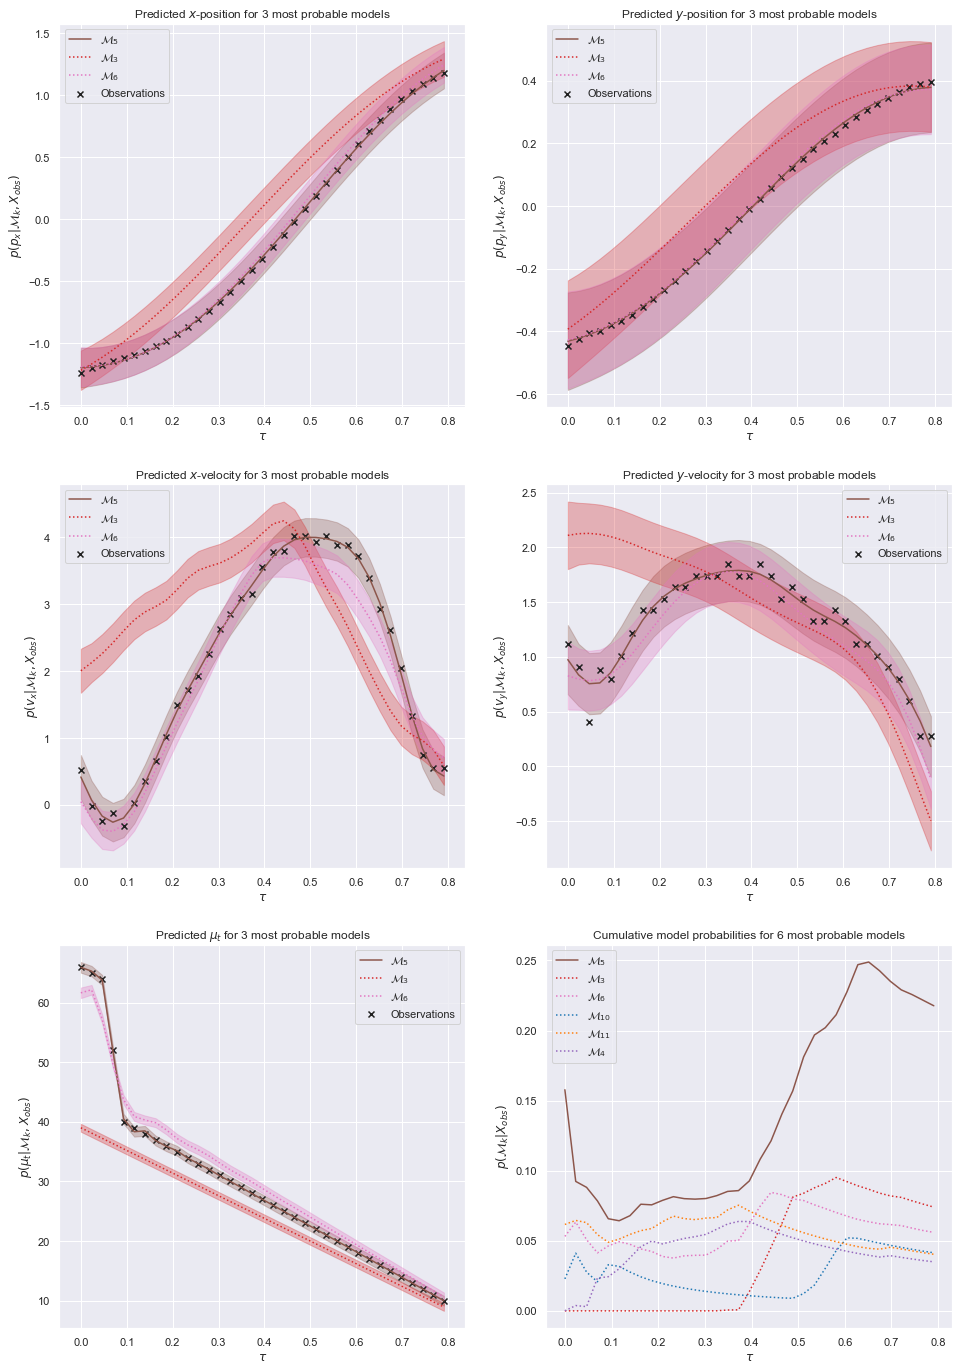

In [73]:
#plt.set_cmap()
from plotting import plot_most_probable_models, default_color
linestyle = lambda i: '-' if i == test_traj_ix else ':'

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plot_most_probable_models(
        models_to_use,
        weights,
        cum_model_probs,
        seg, 
        linestyle=linestyle,
        n_models=3
)

## Model Mean Plots

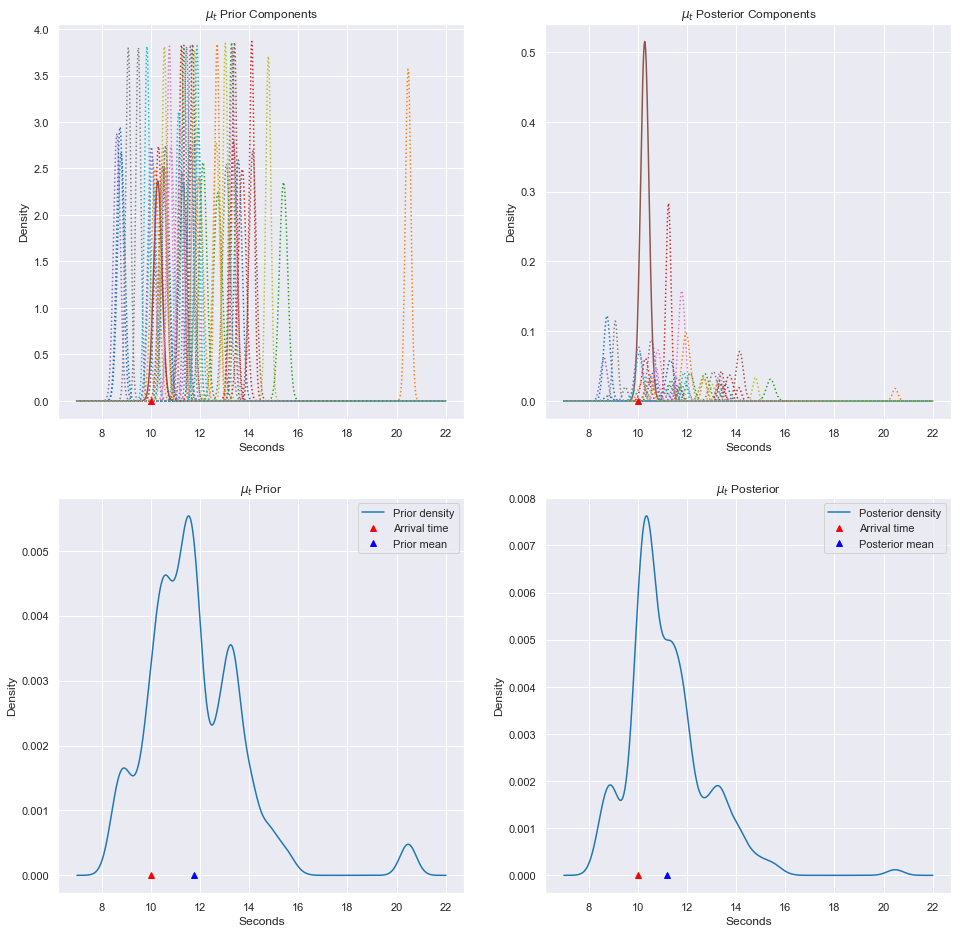

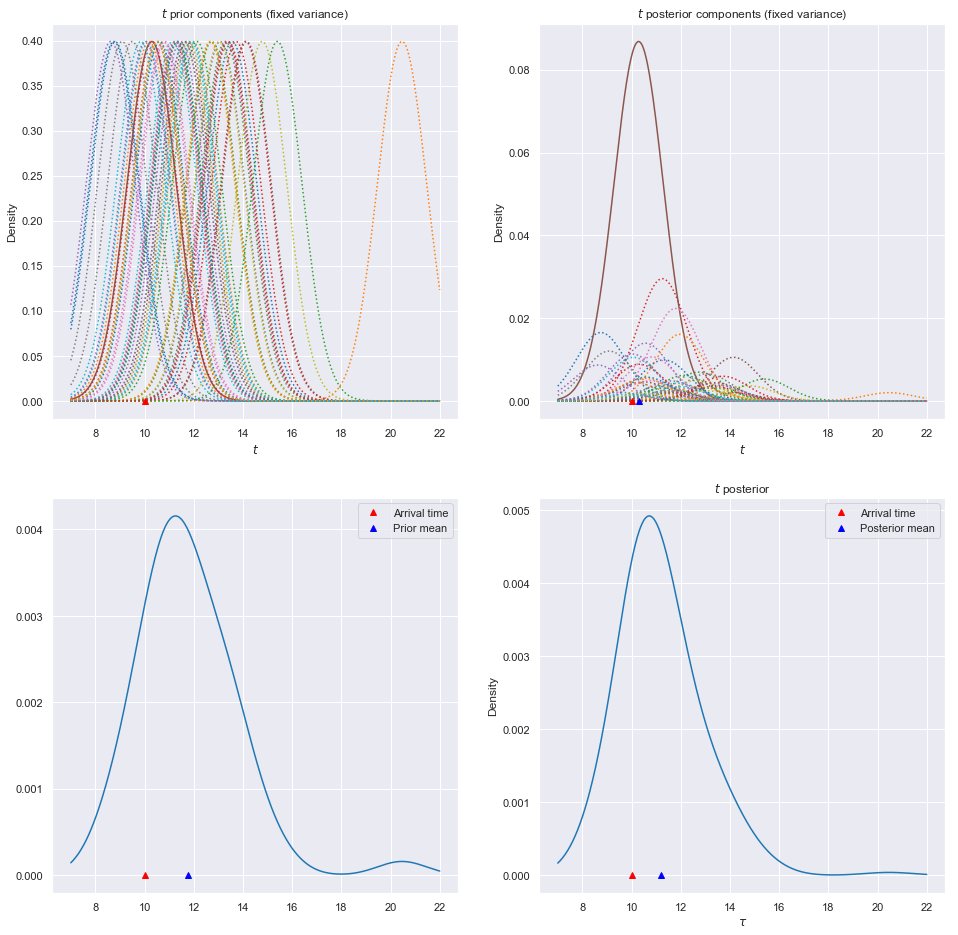

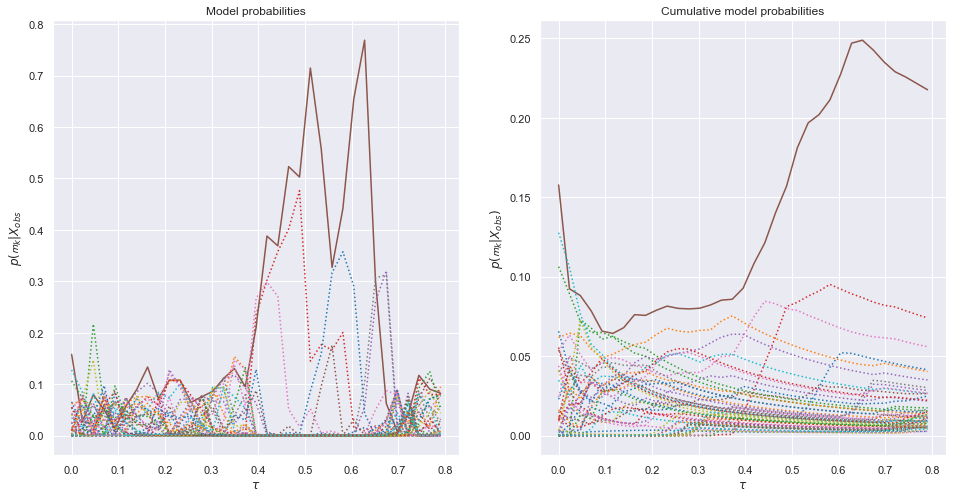

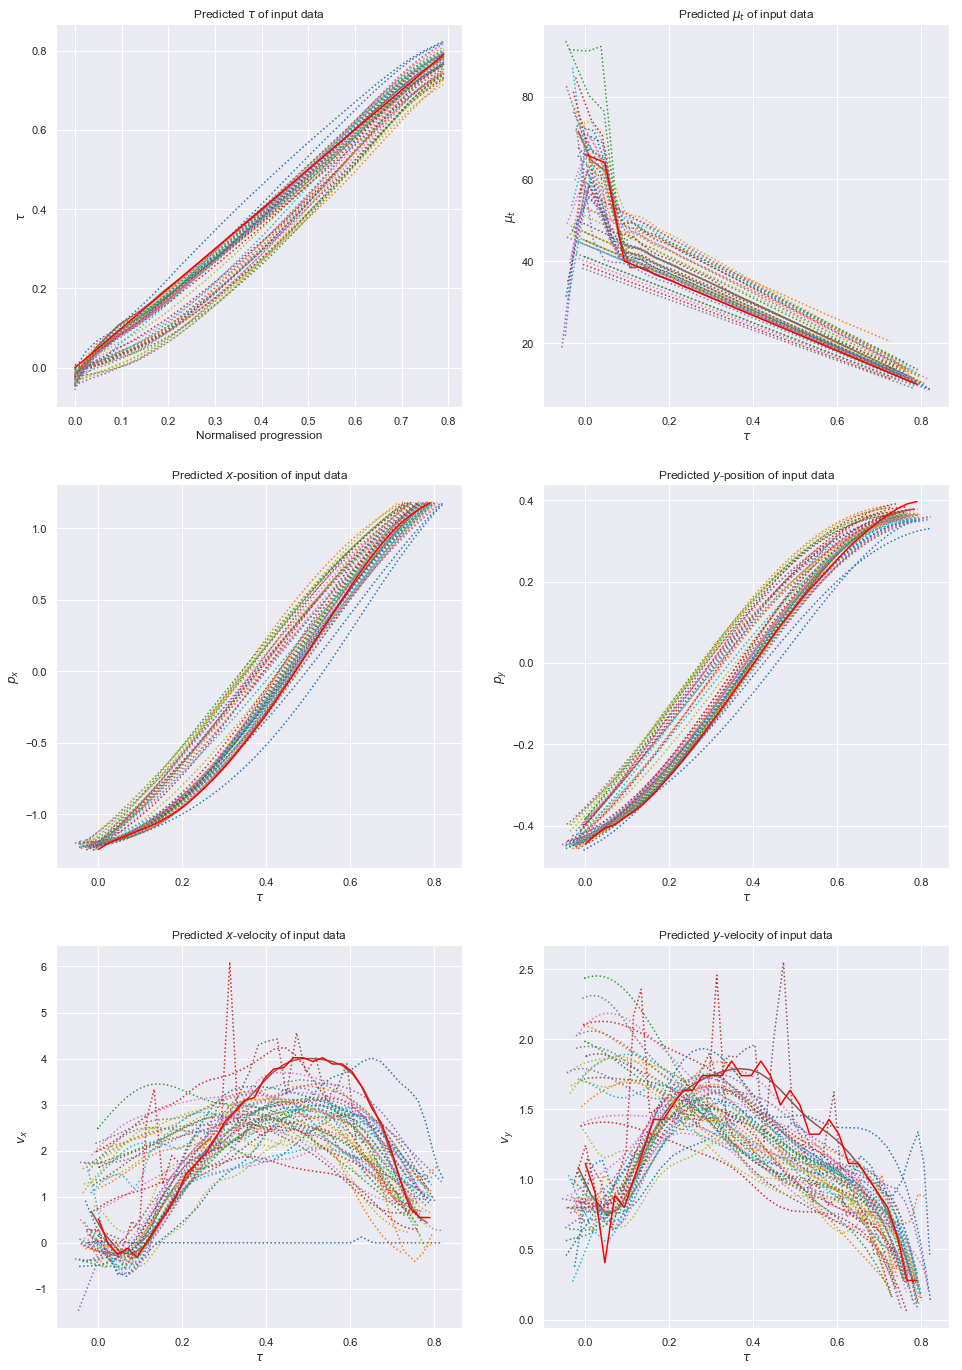

In [74]:
from predict import model_cum_loglik
from plotting import plot_grid, plot_mu_t, plot_model_probabilities, plot_state_model_means, grid_for, plot_t

t_mu_mu = np.apply_along_axis(lambda row: row[-1], 0, t_mu_mus)
t_mu_sigma = np.apply_along_axis(lambda row: row[-1], 0, t_mu_sigmas)

t_grid = grid_for(t_mu_mu, t_mu_sigma, grid_pad=6)
t_mu, t_sigma = t_prediction(t_mu_mu, t_mu_sigma)

plot_mu_t(
    t_grid, 
    model_ixs,
    t_mu_mu,
    t_mu_sigma,
    weights,
    time_left, 
    linestyle
)
plot_t(
    t_grid,
    model_ixs,
    t_mu,
    t_sigma,
    weights,
    time_left,
    linestyle
)

progression = np.linspace(
    0, seg.iloc[-1].tau, seg.shape[0]
).reshape(-1, 1)

plot_model_probabilities(
    progression, 
    model_probs, 
    model_ixs,
    cum_model_probs,
    linestyle
)

plot_state_model_means(
    models_to_use,
    model_ixs,
    seg,
    progression,
    linestyle
)

## Model Prediction

In [75]:
from IPython.display import display, clear_output
import math
from collections import defaultdict
from tqdm import tqdm
from plotting import plot_grid
import numpy as np

def compute_errors(pred, truth):
    abs_diff = np.abs(pred - truth)
    mae = abs_diff
    mape = (100*abs_diff) / np.sum(truth)
    return mae, mape
    
def most_probable_model_predictor(models, X_obs):
    weights, _, _ = model_weights(models, X_obs)
    most_probable_model = max(zip(weights, models), key=lambda x: x[0])[1]
    latest_pos = X_obs[-1,0:2].reshape(-1, 2)
    t_mu_mu, t_mu_sigma = model_t_mu_predictions([most_probable_model], latest_pos)
    t_pred, _ = t_prediction(t_mu_mu, t_mu_sigma)
    return t_pred

def evaluate(models, seg_sizes, seg_n, traj_ids, load_seg, predict):
    maes  = {s: defaultdict(dict) for s in seg_sizes}
    mapes = {s: defaultdict(dict) for s in seg_sizes}
    for seg_size in tqdm(seg_sizes):
        maes[seg_size] = []
        mapes[seg_size] = []
        for traj_id in traj_ids:
            seg = load_seg(seg_n, traj_id, seg_size)
            X_obs = seg[f_codomain].values
            pred = predict(models, X_obs)
            truth = seg.iloc[-1].time_left
            mae, mape = compute_errors(pred, truth)
            maes[seg_size].append(mae)
            mapes[seg_size].append(mape) 
            
    mean_maes = [np.mean(maes[seg_size]) for seg_size in seg_sizes]
    mean_mapes = [np.mean(mapes[seg_size]) for seg_size in seg_sizes]
    return mean_maes, mean_mapes
    

# Performance

## In Sample 

KeyboardInterrupt: 

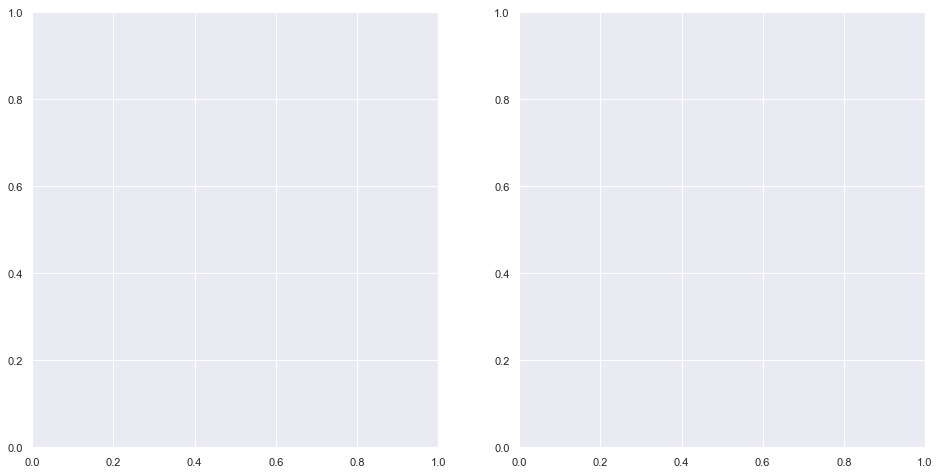

In [58]:
def plot_route_performance(route_n, seg_ns, seg_sizes, route_maes, route_mapes):
    fix, axs = plot_grid(1, 2)
    mae_ax = axs[0]
    mape_ax = axs[1]
    
    for seg_n, maes, mapes in zip(seg_ns, route_maes, route_mapes):
        mae_ax.plot(
            seg_sizes, maes, 
            marker='o', 
            label='Segment {}'.format(seg_n)
        )
        mape_ax.plot(
            seg_sizes, mapes, 
            marker='o', 
            label='Segment {}'.format(seg_n)
        )

    mae_ax.set_title('Average MAE of route {} segments using {} models'.format(route_n, model_limit))
    mae_ax.set_ylabel('MAE (s)')
    mae_ax.set_xlabel(r'Observed $\tau$')
    mae_ax.legend()

    mape_ax.set_title('Average MAPE of route {} segments using {} models'.format(route_n, model_limit))
    mape_ax.set_ylabel('MAPE (%)')
    mape_ax.set_xlabel(r'Observed $\tau$')
    mape_ax.legend()

np.random.seed(1)
f_codomain = ['x', 'y', 'dx', 'dy']
seg_sizes = [.2, .4, .6, .8]
model_limit = 100
route_ns = [3]
#seg_ns = [9]
fix, axs = plot_grid(1, 2)
mae_ax = axs[0]
mape_ax = axs[1]
in_sample_traj_ids = traj_ns[:model_limit]

for route_n in route_ns:
    route_maes = []
    route_mapes = []
    for seg_n in seg_ns:
        models = load_models(route_n, seg_n, model_limit)
        maes, mapes = evaluate(
            models, seg_sizes,  seg_n,
            in_sample_traj_ids, in_sample_seg_loader,
            most_probable_model_predictor
        )
        route_maes.append(maes)
        route_mapes.append(mapes)

    plot_route_performance(
        route_n, seg_ns, seg_sizes, 
        route_maes, route_mapes
    )
        

## Out of sample

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:43<02:10, 43.64s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [01:45<01:38, 49.22s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [03:06<00:58, 58.57s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:45<00:00, 70.78s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:29<01:28, 29.57s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [01:10<01:05, 32.99s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:04<00:39, 39.29s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:11<00:00, 47.63s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:32<01:37, 32.55s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [01:18<01:13, 36.69s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:20<00:44, 44.04s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:36<00:00, 53.87s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:23<01:09, 23.18s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [00:55<00:51, 25.95s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:37<00:30, 30.83s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:30<00:00, 37.53s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:32<01:38, 32.99s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [01:23<01:16, 38.24s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:31<00:47, 47.12s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:56<00:00, 58.52s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:31<01:33, 31.10s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [01:17<01:11, 35.77s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:20<00:44, 44.00s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:40<00:00, 54.70s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:40<02:01, 40.55s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [01:43<01:34, 47.17s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [03:04<00:57, 57.34s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:45<00:00, 70.64s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:22<01:08, 22.72s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [00:55<00:51, 25.69s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:37<00:30, 30.76s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:32<00:00, 37.83s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [01:12<03:37, 72.50s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [03:10<02:52, 86.00s/it]





 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [05:54<01:49, 109.59s/it]





100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [09:25<00:00, 139.93s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:32<01:38, 32.82s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [01:21<01:15, 37.72s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:27<00:46, 46.12s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:50<00:00, 57.20s/it]







loaded 50 models








  0%|                                                                                            | 0/4 [00:00<?, ?it/s]





 25%|█████████████████████                                                               | 1/4 [00:31<01:35, 31.80s/it]





 50%|██████████████████████████████████████████                                          | 2/4 [01:19<01:13, 36.70s/it]





 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:23<00:44, 44.85s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:44<00:00, 55.54s/it]







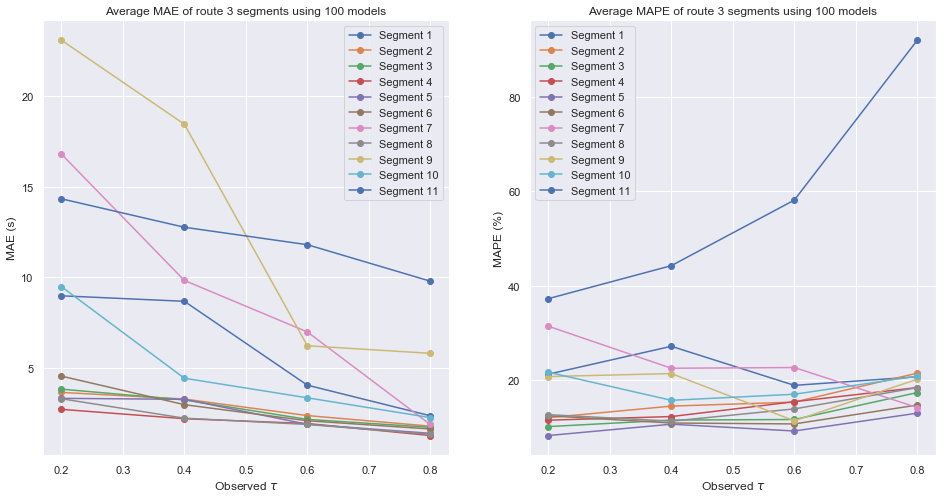

In [76]:
loaded = False
if loaded is False:
    test_trajs_pickle_path = '../data/test3.pkl'
    test_data = pd.read_pickle(test_trajs_pickle_path)
    n_test_trajs = list(test_data.traj.unique())
    n_test_trajs_to_use = 50 #len(n_trajs)
    test_trajs_to_use = frozenset(np.random.choice(n_test_trajs, size=n_test_trajs_to_use, replace=False))
    test_trajs = test_data[test_data.traj.transform(lambda j: j in test_trajs_to_use)]
    test_traj_ids = test_trajs.traj.unique()
    loaded=True
    
def load_test_seg(traj_n, seg_n):
    return test_trajs[
        (test_trajs.traj == traj_n) & 
        (test_trajs.seg == seg_n)
    ]


def out_of_sample_seg_loader(seg_n, traj_id, seg_size=1):
    return pre_process(
        load_test_seg(traj_id, seg_n), 
        stop_compress_delta, 
        seg_normalisers[seg_n],
        seg_size
    )

for route_n in route_ns:
    route_maes = []
    route_mapes = []
    for seg_n in seg_ns:
        models = load_models(route_n, seg_n, model_limit)
        maes, mapes = evaluate(
            models, seg_sizes,  seg_n,
            test_traj_ids, out_of_sample_seg_loader,
            most_probable_model_predictor
        )
        route_maes.append(maes)
        route_mapes.append(mapes)

    plot_route_performance(
        route_n, seg_ns, seg_sizes, 
        route_maes, route_mapes
    )
        

[[-50.0984473]]


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


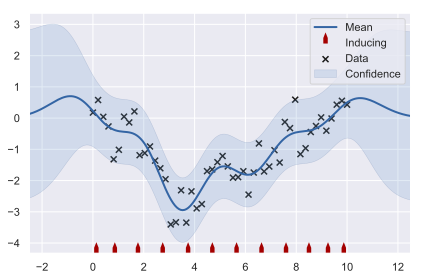

In [53]:


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)


N = 50
noise_var = 0.05

X = np.linspace(0,10,50)[:,None]
k = GPy.kern.RBF(1)
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)

#m_full = GPy.models.GPRegression(X,y)
#m_full.optimize('bfgs')
#m_full.plot()

Z = np.random.rand(12,1)
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.optimize('bfgs')
m.plot()
print(m.log_likelihood())

predicting for 66


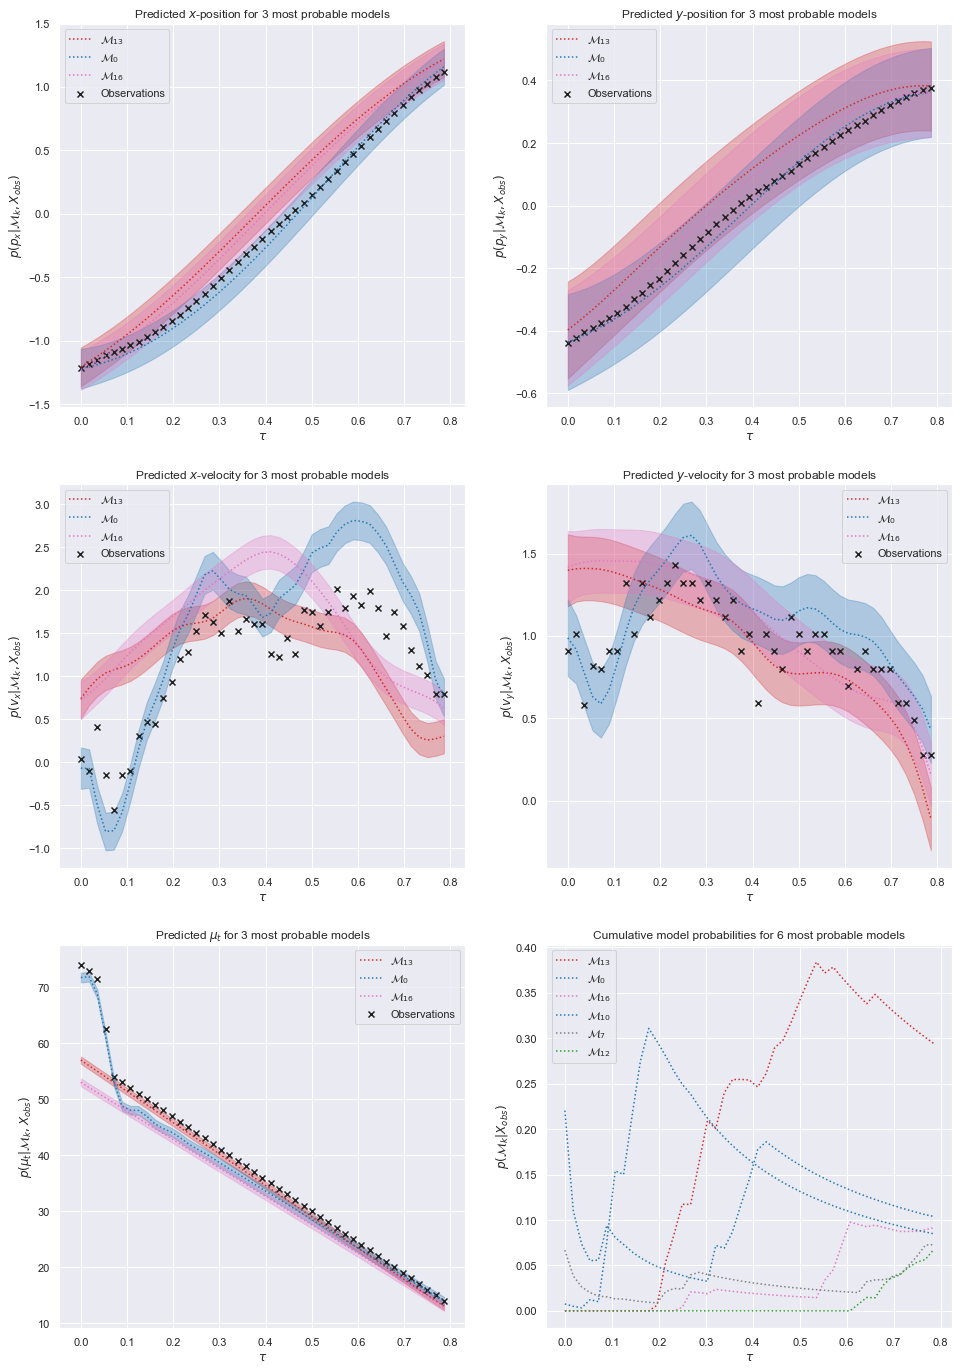

In [29]:
route_n = 3
seg_n = 6
model_limit = 5
models_to_use = load_models(route_n, seg_n, model_limit)
model_ixs = range(len(models_to_use))

# Load in-sample segment
test_traj_ix = 0
test_traj_id = test_traj_ids[test_traj_ix]
fraction_observed = .8
seg = out_of_sample_seg_loader(
    seg_n, test_traj_id,
    fraction_observed
)

time_left = seg.iloc[-1].time_left
f_codomain = ['x', 'y', 'dx', 'dy']
X_obs = seg[f_codomain].values
t_mu_mus, t_mu_sigmas = model_t_mu_predictions(models_to_use, X_obs)
weights, model_probs, cum_model_probs = model_weights(models_to_use, X_obs)
print('predicting for', test_traj_id)
#plt.set_cmap()

from plotting import plot_most_probable_models, default_color
linestyle = lambda i: ':' # if i == test_traj_ix else ':'

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plot_most_probable_models(
        models_to_use,
        weights,
        cum_model_probs,
        seg, 
        linestyle=linestyle,
        n_models=3
)